# 应用PINN求解一维欧拉方程（Sod激波管问题）

In [137]:
#from pytorchtools import EarlyStopping
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
from smt.sampling_methods import LHS


In [154]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
# Seeds
torch.manual_seed(100)
np.random.seed(100)

   
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition

    # rho, p - initial condition
    for i in range(N):
        if (x[i,1] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 5):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                # Neural network
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    # Heat Capacity Ratio

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]                    # Partial derivatives rho_t, rho_x


        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            # Partial derivatives u_t, u_x

      #  dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
      #  p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            # Partial derivatives p_t, p_x
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        
     #   drho_gg =  gradients(rho_x, x)[0]
     #   rho_xx = drho_gg[:,1:]
     #   dU2_gg =  gradients(U2_x, x)[0]
     #   U2_xx = dU2_gg[:,1:]
     #   dU3_gg =  gradients(U3_x, x)[0]
     #   U3_xx = dU3_gg[:,1:]
        
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]
        
      #  s = abs(p)/abs(rho)**1.4
      #  
      #  ds_g = gradients(s, x)[0]
      #  s_t,s_x = ds_g[:,:1], ds_g[:,1:]

       # d =0.1*(abs(rho_x))  + 1
        d = 0.1*(abs(u_x)-u_x)  + 1
        #d = 0.1*(rho_x)  + 1
        #d = 1
       # l = s_t+u*s_x
       # l2 = abs(l)-l
     
      #  a1 = (rho_xx)
      #  a2 = (U2_xx)
      #  a3 = (U3_xx)
      #  
      #  d1 = rho_t + U2_x
      #  d2 = U2_t + F2_x
      #  d3 = U3_t + F3_x
        
        f = (((rho_t + U2_x )/d)**2).mean() + \
            (((U2_t  + F2_x )/d)**2).mean() + \
            (((U3_t  + F3_x )/d)**2).mean() #+ (l**2).mean() #+\
           # 10*(((abs(a1*d1)-a1*d1)/(abs(a1)+1)/d)**2).mean() + \
           # 10*(((abs(a2*d2)-a2*d2)/(abs(a2)+1)/d)**2).mean() + \
           # 10*(((abs(a3*d3)-a3*d3)/(abs(a3)+1)/d)**2).mean() 
        #f = (((rho_t + U2_x )/d)**2).mean() + \
        #    (((U2_t  + F2_x )/d)**2).mean() + \
        #    (((U3_t  + F3_x )/d)**2).mean() 
            #(((abs(a1*d1)-a1*d1)/d)**2).mean() + \
            #(((abs(a2*d2)-a2*d2)/d)**2).mean() + \
            #(((abs(a3*d3)-a3*d3)/d)**2).mean() 
           # ((rho_t).mean())**2  +\
           # ((U3_t).mean())**2 
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
    
    def loss_con(self, x_en,x_in,Time):
        y_en = self.net(x_en)                                                      # Initial condition
        y_in = self.net(x_in)                                                      # Initial condition
        rhoen, pen,uen = y_en[:, 0], y_en[:, 1], y_en[:, 2]            # rho, u, p - initial condition
        rhoin, pin,uin = y_in[:, 0], y_in[:, 1], y_in[:, 2]            # rho, u, p - initial condition

        U3 = 0.5*rhoen*uen**2 + pen/0.4
        U3in = 0.5*rhoin*uin**2 + pin/0.4
        # Loss function for the initial condition
        loss_en = ((rhoen - rhoin).mean())**2 + \
            ((U3- U3in).mean())**2 +\
            (((1-0.1)*Time - rhoen*uen).mean())**2
        return loss_en
    
    def loss_rh(self, x_l,x_r):
        y_en = self.net(x_l)                                                      # Initial condition
        y_in = self.net(x_r)                                                      # Initial condition
        rhoen, pen,uen = y_en[:, 0], y_en[:, 1], y_en[:, 2]            # rho, u, p - initial condition
        rhoin, pin,uin = y_in[:, 0], y_in[:, 1], y_in[:, 2]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_en =  (((pen/pin - (6*rhoen-rhoin)/(6*rhoin-rhoen))*(pen-pin))**2).max()+\
                   (((uen-uin)**2 -2/rhoen*(pen-pin)**2/(0.4*pen+2.4*pin))**2).max()
        return loss_en
    

def X_entropy(x,dt):
    N=x.shape[0]
    xen =np.zeros((N,2)) 
    
    for i in range(N):
        xen[i,1] = x[i,1]
        xen[i,0] = x[i,0] + dt
    return xen

def X_right(x,dx):
    N=x.shape[0]
    xen =np.zeros((N,2)) 
    
    for i in range(N):
        xen[i,1] = x[i,1] + dx
        xen[i,0] = x[i,0] 
    return xen
    
device = torch.device('cuda')                                          # Run on CPU
num_x = 100                                                        # Number of points in t
num_t = 100                                                        # Number of points in x
num_int = 50000
num_ib = 5000                                                 # Random sampled points in interior
Tend = 0.2
Tend2 = 0.1
Tend3 = 0.05
Lx = 1.0
#x = np.linspace(0.0, 1.0, num_x)                                   # Partitioned spatial axis
#t = np.linspace(0, 0.2, num_t)                                        # Partitioned time axis
#t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
#T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
#X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
#id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)      # Random sample numbering for interior
#
#x_int = X[:, 0][id_f, None]                                           # Random x - interior
#t_int = T[:, 0][id_f, None]                                           # Random t - interior
#x_int_train = np.hstack((t_int, x_int))                               # Random (x,t) - vectorized
#
#x = np.linspace(0.0, 1.0, 1000)                                   # Partitioned spatial axis
#t = np.linspace(0, 0.2, 1000)                                        # Partitioned time axis
#t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
#id_ic = np.random.choice(1000, 1000, replace=False)           # Random sample numbering for IC
#T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
#X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
#x_ic = x_grid[id_ic, 0][:, None]                                      # Random x - initial condition
#t_ic = t_grid[id_ic, 0][:, None]                                      # random t - initial condition
#x_ic_train = np.hstack((t_ic, x_ic))                                  # Random (x,t) - vectorized

xlimits = np.array([[0.,Tend],[0.0, Lx]])  #interal
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_int)

xlimits = np.array([[0.,0],[0.0, Lx]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic_train= sampling(num_ib)

rho_ic_train, u_ic_train, p_ic_train = IC(x_ic_train)                       # Initial condition evaluated at random sample


#rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)                       # Initial condition evaluated at random sample

x = np.linspace(0.0, 1.0, 200)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 200)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
id_ic = np.random.choice(200, 200, replace=False)           # Random sample numbering for IC
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_ic = x_grid[id_ic, 0][:, None]                                      # Random x - initial condition
t_ic = t_grid[id_ic, 0][:, None]                                      # random t - initial condition
x_ic2 = np.hstack((t_ic, x_ic))                                  # Random (x,t) - vectorized

x_end = X_entropy(x_ic2,Tend)                                 # Random (x,t) - vectorized
x_r = X_right(x_end,0.01)                                 # Random (x,t) - vectorized

x_end2 = X_entropy(x_ic_train,Tend)                                 # Random (x,t) - vectorized
x_end3 = X_entropy(x_ic_train,Tend2)                                 # Random (x,t) - vectorized
x_end4 = X_entropy(x_ic_train,Tend3)                                 # Random (x,t) - vectorized

x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

x_end       = torch.tensor(x_end, dtype=torch.float32).to(device)
x_end2       = torch.tensor(x_end2, dtype=torch.float32).to(device)
x_end3       = torch.tensor(x_end3, dtype=torch.float32).to(device)
x_end4       = torch.tensor(x_end4, dtype=torch.float32).to(device)
x_r         = torch.tensor(x_r, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


In [156]:
def train(epoch):
    model.train()
    model.it = 1
    tocs1 = time.time()
   # outputfile = open('loss_history_sod_100.dat','a+')
    
    #print(f'Training time with Adam: {tocs1 - tics1}')
    def closure():
        optimizer.zero_grad()                                                     # Optimizer
        loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   # Loss function of IC
        loss_con = model.loss_con(x_end2,x_ic_train,Tend)
        loss_con2 = model.loss_con(x_end3,x_ic_train,Tend2)
        loss_con3 = model.loss_con(x_end4,x_ic_train,Tend3)
        loss_rh = model.loss_rh(x_end,x_r)
        loss = loss_pde + 10*loss_ic + loss_con+loss_con2+loss_con3  #+ 0.1*loss_rh #+ 0.1*loss_rh  # # +0.1* (loss_con+loss_con2) # + 10*loss_rh# +
        
      #  if (loss < 0.001):
      #      return
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_con:{loss_con:.8f}, loss_rh:{loss_rh:.8f}, loss_ic:{loss_ic:.8f}')
       # print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_con:{loss_con:.8f},  loss_ic:{loss_ic:.8f}')
       # print(f'epoch {epoch} loss_pde:{loss_pde:.8f},loss_ic:{loss_ic:.8f}')
     #   model.it = model.it + 1
   #     if(model.it < epoch):
   #         model.it = epoch
   #     # Print total loss
   #         print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f} {loss_rh:.6f}',file=outputfile)
   #     #print(f'epoch {model.it} loss_pde:{loss_pde: .8f},loss_ic:{loss_ic: .8f}',file=outputfile)
   #     #print(f'epoch {model.it}: loss {loss:.6f}',file=outputfile)
   #    
   #     outputfile.close()
        #outputfile = open('loss_history_ringV1.txt','a+')
        ## Print iteration, loss of PDE and ICs
        #print(f'epoch {i} loss_pde:{loss_pde: .8f},loss_ic:{loss_ic: .8f}',file=outputfile)
        #print(f'epoch {i}: loss {loss:.6f}',file=outputfile)
        #outputfile.close()
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
 

In [157]:
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch = 0
epochi = epoch

epochs = 12000
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
u_pred = to_numpy(model(x_test))
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 1 loss_pde:0.03904140, loss_con:0.03753225, loss_rh:0.00000000, loss_ic:0.69415146
epoch 1: loss 7.031587
epoch 2 loss_pde:0.03919019, loss_con:0.03736191, loss_rh:0.00000000, loss_ic:0.65528691
epoch 2: loss 6.642832
epoch 3 loss_pde:0.03911152, loss_con:0.03694306, loss_rh:0.00000000, loss_ic:0.61901289
epoch 3: loss 6.279306
epoch 4 loss_pde:0.03883918, loss_con:0.03628303, loss_rh:0.00000000, loss_ic:0.58529443
epoch 4: loss 5.940711
epoch 5 loss_pde:0.03836578, loss_con:0.03540076, loss_rh:0.00000000, loss_ic:0.55403495
epoch 5: loss 5.626113
epoch 6 loss_pde:0.03772741, loss_con:0.03431236, loss_rh:0.00000000, loss_ic:0.52513874
epoch 6: loss 5.334629
epoch 7 loss_pde:0.03695793, loss_con:0.03303180, loss_rh:0.00000000, loss_ic:0.49858898
epoch 7: loss 5.066159
epoch 8 loss_pde:0.03605735, loss_con:0.03158353, loss_rh:0.00000000, loss_ic:0.47446823
epoch 8: loss 4.821586
epoch 9 loss_pde:0.03499125, loss_con:0.03001509, loss_rh:0.00000000, loss_ic:0.45293462
epoch 9: loss 4

epoch 74 loss_pde:0.29949722, loss_con:0.02259897, loss_rh:0.01927383, loss_ic:0.13922167
epoch 74: loss 1.719223
epoch 75 loss_pde:0.29133219, loss_con:0.02256056, loss_rh:0.00662146, loss_ic:0.13971022
epoch 75: loss 1.715947
epoch 76 loss_pde:0.28534815, loss_con:0.02256607, loss_rh:0.00948989, loss_ic:0.13998392
epoch 76: loss 1.712773
epoch 77 loss_pde:0.28142625, loss_con:0.02259229, loss_rh:0.01995918, loss_ic:0.14003050
epoch 77: loss 1.709425
epoch 78 loss_pde:0.27935824, loss_con:0.02261076, loss_rh:0.00805284, loss_ic:0.13986114
epoch 78: loss 1.705761
epoch 79 loss_pde:0.27886015, loss_con:0.02259700, loss_rh:0.00800520, loss_ic:0.13950482
epoch 79: loss 1.701750
epoch 80 loss_pde:0.27960262, loss_con:0.02253682, loss_rh:0.00871431, loss_ic:0.13899681
epoch 80: loss 1.697393
epoch 81 loss_pde:0.28124291, loss_con:0.02242774, loss_rh:0.00704591, loss_ic:0.13836895
epoch 81: loss 1.692662
epoch 82 loss_pde:0.28345272, loss_con:0.02227611, loss_rh:0.00738488, loss_ic:0.1376460

epoch 148: loss 1.299755
epoch 149 loss_pde:0.24498080, loss_con:0.00765413, loss_rh:0.00006318, loss_ic:0.10419600
epoch 149: loss 1.296777
epoch 150 loss_pde:0.24316113, loss_con:0.00756158, loss_rh:0.00006010, loss_ic:0.10409012
epoch 150: loss 1.293785
epoch 151 loss_pde:0.24137551, loss_con:0.00748152, loss_rh:0.00005722, loss_ic:0.10397808
epoch 151: loss 1.290782
epoch 152 loss_pde:0.23961028, loss_con:0.00741212, loss_rh:0.00005446, loss_ic:0.10386184
epoch 152: loss 1.287769
epoch 153 loss_pde:0.23784807, loss_con:0.00735310, loss_rh:0.00005181, loss_ic:0.10374308
epoch 153: loss 1.284745
epoch 154 loss_pde:0.23607279, loss_con:0.00730582, loss_rh:0.00004926, loss_ic:0.10362317
epoch 154: loss 1.281709
epoch 155 loss_pde:0.23428358, loss_con:0.00726993, loss_rh:0.00004688, loss_ic:0.10350230
epoch 155: loss 1.278664
epoch 156 loss_pde:0.23249590, loss_con:0.00724149, loss_rh:0.00004469, loss_ic:0.10337961
epoch 156: loss 1.275612
epoch 157 loss_pde:0.23072228, loss_con:0.00721

epoch 223 loss_pde:0.11868760, loss_con:0.00329361, loss_rh:0.00000304, loss_ic:0.09697309
epoch 223: loss 1.092606
epoch 224 loss_pde:0.11753657, loss_con:0.00325179, loss_rh:0.00000299, loss_ic:0.09684271
epoch 224: loss 1.090096
epoch 225 loss_pde:0.11641626, loss_con:0.00321191, loss_rh:0.00000294, loss_ic:0.09670885
epoch 225: loss 1.087583
epoch 226 loss_pde:0.11532158, loss_con:0.00317427, loss_rh:0.00000289, loss_ic:0.09657204
epoch 226: loss 1.085070
epoch 227 loss_pde:0.11424842, loss_con:0.00313903, loss_rh:0.00000284, loss_ic:0.09643268
epoch 227: loss 1.082556
epoch 228 loss_pde:0.11320046, loss_con:0.00310608, loss_rh:0.00000280, loss_ic:0.09629045
epoch 228: loss 1.080041
epoch 229 loss_pde:0.11218332, loss_con:0.00307512, loss_rh:0.00000276, loss_ic:0.09614485
epoch 229: loss 1.077525
epoch 230 loss_pde:0.11119661, loss_con:0.00304599, loss_rh:0.00000272, loss_ic:0.09599596
epoch 230: loss 1.075009
epoch 231 loss_pde:0.11023558, loss_con:0.00301863, loss_rh:0.00000268, 

epoch 298 loss_pde:0.08507626, loss_con:0.00238466, loss_rh:0.00000145, loss_ic:0.08392898
epoch 298: loss 0.927158
epoch 299 loss_pde:0.08512892, loss_con:0.00238374, loss_rh:0.00000142, loss_ic:0.08375099
epoch 299: loss 0.925426
epoch 300 loss_pde:0.08519021, loss_con:0.00238272, loss_rh:0.00000139, loss_ic:0.08357295
epoch 300: loss 0.923702
epoch 301 loss_pde:0.08525996, loss_con:0.00238163, loss_rh:0.00000137, loss_ic:0.08339487
epoch 301: loss 0.921987
epoch 302 loss_pde:0.08533834, loss_con:0.00238035, loss_rh:0.00000134, loss_ic:0.08321668
epoch 302: loss 0.920278
epoch 303 loss_pde:0.08542448, loss_con:0.00237891, loss_rh:0.00000131, loss_ic:0.08303847
epoch 303: loss 0.918577
epoch 304 loss_pde:0.08551902, loss_con:0.00237727, loss_rh:0.00000129, loss_ic:0.08286011
epoch 304: loss 0.916883
epoch 305 loss_pde:0.08562128, loss_con:0.00237538, loss_rh:0.00000126, loss_ic:0.08268169
epoch 305: loss 0.915196
epoch 306 loss_pde:0.08573128, loss_con:0.00237323, loss_rh:0.00000123, 

epoch 372: loss 0.804111
epoch 373 loss_pde:0.09993567, loss_con:0.00163911, loss_rh:0.00000067, loss_ic:0.07014488
epoch 373: loss 0.803151
epoch 374 loss_pde:0.09759024, loss_con:0.00154863, loss_rh:0.00000065, loss_ic:0.07018694
epoch 374: loss 0.801169
epoch 375 loss_pde:0.09812593, loss_con:0.00163719, loss_rh:0.00000066, loss_ic:0.06986646
epoch 375: loss 0.798552
epoch 376 loss_pde:0.09918543, loss_con:0.00157047, loss_rh:0.00000067, loss_ic:0.06961560
epoch 376: loss 0.797031
epoch 377 loss_pde:0.09780113, loss_con:0.00150337, loss_rh:0.00000065, loss_ic:0.06960931
epoch 377: loss 0.795546
epoch 378 loss_pde:0.09879194, loss_con:0.00158882, loss_rh:0.00000067, loss_ic:0.06925979
epoch 378: loss 0.793096
epoch 379 loss_pde:0.09864655, loss_con:0.00150276, loss_rh:0.00000067, loss_ic:0.06907575
epoch 379: loss 0.791021
epoch 380 loss_pde:0.09790727, loss_con:0.00146204, loss_rh:0.00000066, loss_ic:0.06900567
epoch 380: loss 0.789558
epoch 381 loss_pde:0.09914686, loss_con:0.00153

epoch 446: loss 0.618761
epoch 447 loss_pde:0.07825167, loss_con:0.00060812, loss_rh:0.00000099, loss_ic:0.05372056
epoch 447: loss 0.616257
epoch 448 loss_pde:0.07776931, loss_con:0.00060040, loss_rh:0.00000099, loss_ic:0.05353250
epoch 448: loss 0.613863
epoch 449 loss_pde:0.07832459, loss_con:0.00060124, loss_rh:0.00000101, loss_ic:0.05325059
epoch 449: loss 0.611646
epoch 450 loss_pde:0.07788467, loss_con:0.00059137, loss_rh:0.00000099, loss_ic:0.05310822
epoch 450: loss 0.609721
epoch 451 loss_pde:0.07948017, loss_con:0.00059535, loss_rh:0.00000104, loss_ic:0.05279296
epoch 451: loss 0.608254
epoch 452 loss_pde:0.07919648, loss_con:0.00058414, loss_rh:0.00000100, loss_ic:0.05272657
epoch 452: loss 0.607198
epoch 453 loss_pde:0.08154334, loss_con:0.00059347, loss_rh:0.00000106, loss_ic:0.05236106
epoch 453: loss 0.606038
epoch 454 loss_pde:0.07947376, loss_con:0.00056835, loss_rh:0.00000101, loss_ic:0.05231751
epoch 454: loss 0.603370
epoch 455 loss_pde:0.07877253, loss_con:0.00059

epoch 521: loss 0.493639
epoch 522 loss_pde:0.06148554, loss_con:0.00056488, loss_rh:0.00000123, loss_ic:0.04296276
epoch 522: loss 0.492058
epoch 523 loss_pde:0.06113065, loss_con:0.00056947, loss_rh:0.00000124, loss_ic:0.04283779
epoch 523: loss 0.490470
epoch 524 loss_pde:0.06076324, loss_con:0.00056725, loss_rh:0.00000124, loss_ic:0.04271525
epoch 524: loss 0.488874
epoch 525 loss_pde:0.06041136, loss_con:0.00056630, loss_rh:0.00000124, loss_ic:0.04258997
epoch 525: loss 0.487272
epoch 526 loss_pde:0.06005501, loss_con:0.00056786, loss_rh:0.00000125, loss_ic:0.04246390
epoch 526: loss 0.485663
epoch 527 loss_pde:0.05969639, loss_con:0.00056463, loss_rh:0.00000125, loss_ic:0.04233867
epoch 527: loss 0.484048
epoch 528 loss_pde:0.05935972, loss_con:0.00056700, loss_rh:0.00000125, loss_ic:0.04220893
epoch 528: loss 0.482426
epoch 529 loss_pde:0.05900131, loss_con:0.00056248, loss_rh:0.00000125, loss_ic:0.04208287
epoch 529: loss 0.480799
epoch 530 loss_pde:0.05867559, loss_con:0.00056

epoch 596 loss_pde:0.05688536, loss_con:0.00086036, loss_rh:0.00000092, loss_ic:0.03361116
epoch 596: loss 0.394526
epoch 597 loss_pde:0.05693765, loss_con:0.00084811, loss_rh:0.00000091, loss_ic:0.03351460
epoch 597: loss 0.393586
epoch 598 loss_pde:0.05695773, loss_con:0.00085075, loss_rh:0.00000089, loss_ic:0.03342064
epoch 598: loss 0.392666
epoch 599 loss_pde:0.05690849, loss_con:0.00088143, loss_rh:0.00000088, loss_ic:0.03333019
epoch 599: loss 0.391762
epoch 600 loss_pde:0.05703065, loss_con:0.00084708, loss_rh:0.00000087, loss_ic:0.03323491
epoch 600: loss 0.390865
epoch 601 loss_pde:0.05689924, loss_con:0.00090716, loss_rh:0.00000086, loss_ic:0.03314870
epoch 601: loss 0.389972
epoch 602 loss_pde:0.05706514, loss_con:0.00085173, loss_rh:0.00000085, loss_ic:0.03305298
epoch 602: loss 0.389078
epoch 603 loss_pde:0.05688051, loss_con:0.00092490, loss_rh:0.00000084, loss_ic:0.03296971
epoch 603: loss 0.388184
epoch 604 loss_pde:0.05704246, loss_con:0.00086260, loss_rh:0.00000083, 

epoch 670: loss 0.337038
epoch 671 loss_pde:0.05435951, loss_con:0.00112199, loss_rh:0.00000053, loss_ic:0.02802998
epoch 671: loss 0.336352
epoch 672 loss_pde:0.05447645, loss_con:0.00104019, loss_rh:0.00000052, loss_ic:0.02796192
epoch 672: loss 0.335660
epoch 673 loss_pde:0.05425392, loss_con:0.00113021, loss_rh:0.00000052, loss_ic:0.02790016
epoch 673: loss 0.334956
epoch 674 loss_pde:0.05436731, loss_con:0.00103744, loss_rh:0.00000051, loss_ic:0.02783195
epoch 674: loss 0.334242
epoch 675 loss_pde:0.05412557, loss_con:0.00112741, loss_rh:0.00000051, loss_ic:0.02777029
epoch 675: loss 0.333520
epoch 676 loss_pde:0.05421108, loss_con:0.00104314, loss_rh:0.00000050, loss_ic:0.02770232
epoch 676: loss 0.332794
epoch 677 loss_pde:0.05399797, loss_con:0.00111899, loss_rh:0.00000050, loss_ic:0.02763946
epoch 677: loss 0.332066
epoch 678 loss_pde:0.05404825, loss_con:0.00105092, loss_rh:0.00000049, loss_ic:0.02757239
epoch 678: loss 0.331339
epoch 679 loss_pde:0.05386593, loss_con:0.00110

epoch 743: loss 0.287617
epoch 744 loss_pde:0.04927757, loss_con:0.00084812, loss_rh:0.00000021, loss_ic:0.02365251
epoch 744: loss 0.286973
epoch 745 loss_pde:0.04901104, loss_con:0.00093666, loss_rh:0.00000021, loss_ic:0.02359424
epoch 745: loss 0.286249
epoch 746 loss_pde:0.04891581, loss_con:0.00088140, loss_rh:0.00000021, loss_ic:0.02354054
epoch 746: loss 0.285536
epoch 747 loss_pde:0.04883084, loss_con:0.00087565, loss_rh:0.00000020, loss_ic:0.02348584
epoch 747: loss 0.284895
epoch 748 loss_pde:0.04873645, loss_con:0.00092081, loss_rh:0.00000020, loss_ic:0.02342978
epoch 748: loss 0.284303
epoch 749 loss_pde:0.04877085, loss_con:0.00083908, loss_rh:0.00000020, loss_ic:0.02337772
epoch 749: loss 0.283699
epoch 750 loss_pde:0.04858235, loss_con:0.00091993, loss_rh:0.00000020, loss_ic:0.02331985
epoch 750: loss 0.283046
epoch 751 loss_pde:0.04852746, loss_con:0.00084589, loss_rh:0.00000021, loss_ic:0.02326744
epoch 751: loss 0.282360
epoch 752 loss_pde:0.04836123, loss_con:0.00088

epoch 818: loss 0.246103
epoch 819 loss_pde:0.04301862, loss_con:0.00069468, loss_rh:0.00000033, loss_ic:0.02009141
epoch 819: loss 0.244830
epoch 820 loss_pde:0.04226171, loss_con:0.00059879, loss_rh:0.00000033, loss_ic:0.02005850
epoch 820: loss 0.243616
epoch 821 loss_pde:0.04285844, loss_con:0.00050847, loss_rh:0.00000032, loss_ic:0.02003551
epoch 821: loss 0.243865
epoch 822 loss_pde:0.04300895, loss_con:0.00069838, loss_rh:0.00000033, loss_ic:0.01998127
epoch 822: loss 0.243727
epoch 823 loss_pde:0.04232777, loss_con:0.00053099, loss_rh:0.00000033, loss_ic:0.01994989
epoch 823: loss 0.242507
epoch 824 loss_pde:0.04203367, loss_con:0.00055373, loss_rh:0.00000033, loss_ic:0.01990981
epoch 824: loss 0.241842
epoch 825 loss_pde:0.04242914, loss_con:0.00066297, loss_rh:0.00000033, loss_ic:0.01986750
epoch 825: loss 0.241960
epoch 826 loss_pde:0.04243368, loss_con:0.00049860, loss_rh:0.00000033, loss_ic:0.01984184
epoch 826: loss 0.241490
epoch 827 loss_pde:0.04181598, loss_con:0.00059

epoch 893 loss_pde:0.03715017, loss_con:0.00035730, loss_rh:0.00000020, loss_ic:0.01762483
epoch 893: loss 0.213847
epoch 894 loss_pde:0.03709539, loss_con:0.00036063, loss_rh:0.00000020, loss_ic:0.01759505
epoch 894: loss 0.213499
epoch 895 loss_pde:0.03704166, loss_con:0.00035185, loss_rh:0.00000020, loss_ic:0.01756682
epoch 895: loss 0.213152
epoch 896 loss_pde:0.03698817, loss_con:0.00035408, loss_rh:0.00000020, loss_ic:0.01753736
epoch 896: loss 0.212806
epoch 897 loss_pde:0.03693705, loss_con:0.00034700, loss_rh:0.00000020, loss_ic:0.01750899
epoch 897: loss 0.212463
epoch 898 loss_pde:0.03688495, loss_con:0.00034722, loss_rh:0.00000020, loss_ic:0.01747999
epoch 898: loss 0.212121
epoch 899 loss_pde:0.03683338, loss_con:0.00034234, loss_rh:0.00000019, loss_ic:0.01745175
epoch 899: loss 0.211781
epoch 900 loss_pde:0.03678313, loss_con:0.00034049, loss_rh:0.00000019, loss_ic:0.01742319
epoch 900: loss 0.211442
epoch 901 loss_pde:0.03673398, loss_con:0.00033760, loss_rh:0.00000019, 

epoch 967 loss_pde:0.03494467, loss_con:0.00017995, loss_rh:0.00000017, loss_ic:0.01582332
epoch 967: loss 0.193408
epoch 968 loss_pde:0.03478444, loss_con:0.00019734, loss_rh:0.00000017, loss_ic:0.01579856
epoch 968: loss 0.193021
epoch 969 loss_pde:0.03490529, loss_con:0.00021454, loss_rh:0.00000017, loss_ic:0.01577509
epoch 969: loss 0.192928
epoch 970 loss_pde:0.03500214, loss_con:0.00017135, loss_rh:0.00000017, loss_ic:0.01576210
epoch 970: loss 0.192844
epoch 971 loss_pde:0.03493028, loss_con:0.00021513, loss_rh:0.00000017, loss_ic:0.01573273
epoch 971: loss 0.192530
epoch 972 loss_pde:0.03475679, loss_con:0.00018539, loss_rh:0.00000017, loss_ic:0.01571557
epoch 972: loss 0.192149
epoch 973 loss_pde:0.03475686, loss_con:0.00018262, loss_rh:0.00000017, loss_ic:0.01569485
epoch 973: loss 0.191939
epoch 974 loss_pde:0.03487137, loss_con:0.00020895, loss_rh:0.00000017, loss_ic:0.01566989
epoch 974: loss 0.191835
epoch 975 loss_pde:0.03484936, loss_con:0.00017044, loss_rh:0.00000017, 

epoch 1040: loss 0.178459
epoch 1041 loss_pde:0.03404749, loss_con:0.00013230, loss_rh:0.00000035, loss_ic:0.01440551
epoch 1041: loss 0.178275
epoch 1042 loss_pde:0.03403588, loss_con:0.00013054, loss_rh:0.00000035, loss_ic:0.01438851
epoch 1042: loss 0.178092
epoch 1043 loss_pde:0.03402797, loss_con:0.00013126, loss_rh:0.00000035, loss_ic:0.01437088
epoch 1043: loss 0.177908
epoch 1044 loss_pde:0.03401572, loss_con:0.00012948, loss_rh:0.00000036, loss_ic:0.01435401
epoch 1044: loss 0.177725
epoch 1045 loss_pde:0.03400731, loss_con:0.00013011, loss_rh:0.00000036, loss_ic:0.01433653
epoch 1045: loss 0.177543
epoch 1046 loss_pde:0.03399538, loss_con:0.00012856, loss_rh:0.00000036, loss_ic:0.01431968
epoch 1046: loss 0.177361
epoch 1047 loss_pde:0.03398677, loss_con:0.00012887, loss_rh:0.00000037, loss_ic:0.01430233
epoch 1047: loss 0.177179
epoch 1048 loss_pde:0.03397551, loss_con:0.00012769, loss_rh:0.00000037, loss_ic:0.01428546
epoch 1048: loss 0.176998
epoch 1049 loss_pde:0.03396598

epoch 1115 loss_pde:0.03329034, loss_con:0.00010290, loss_rh:0.00000074, loss_ic:0.01327027
epoch 1115: loss 0.166133
epoch 1116 loss_pde:0.03355105, loss_con:0.00009279, loss_rh:0.00000073, loss_ic:0.01326293
epoch 1116: loss 0.166311
epoch 1117 loss_pde:0.03402912, loss_con:0.00012871, loss_rh:0.00000076, loss_ic:0.01323731
epoch 1117: loss 0.166573
epoch 1118 loss_pde:0.03369553, loss_con:0.00009059, loss_rh:0.00000074, loss_ic:0.01324006
epoch 1118: loss 0.166225
epoch 1119 loss_pde:0.03332303, loss_con:0.00011007, loss_rh:0.00000077, loss_ic:0.01321631
epoch 1119: loss 0.165635
epoch 1120 loss_pde:0.03329322, loss_con:0.00010812, loss_rh:0.00000077, loss_ic:0.01320290
epoch 1120: loss 0.165469
epoch 1121 loss_pde:0.03353019, loss_con:0.00009028, loss_rh:0.00000077, loss_ic:0.01319778
epoch 1121: loss 0.165636
epoch 1122 loss_pde:0.03369959, loss_con:0.00011927, loss_rh:0.00000079, loss_ic:0.01317145
epoch 1122: loss 0.165573
epoch 1123 loss_pde:0.03335429, loss_con:0.00009253, los

epoch 1190 loss_pde:0.03273527, loss_con:0.00008558, loss_rh:0.00000144, loss_ic:0.01230469
epoch 1190: loss 0.155903
epoch 1191 loss_pde:0.03272209, loss_con:0.00008475, loss_rh:0.00000145, loss_ic:0.01229321
epoch 1191: loss 0.155774
epoch 1192 loss_pde:0.03271626, loss_con:0.00008507, loss_rh:0.00000146, loss_ic:0.01228089
epoch 1192: loss 0.155645
epoch 1193 loss_pde:0.03270436, loss_con:0.00008458, loss_rh:0.00000147, loss_ic:0.01226928
epoch 1193: loss 0.155517
epoch 1194 loss_pde:0.03269514, loss_con:0.00008449, loss_rh:0.00000148, loss_ic:0.01225739
epoch 1194: loss 0.155389
epoch 1195 loss_pde:0.03268629, loss_con:0.00008441, loss_rh:0.00000150, loss_ic:0.01224549
epoch 1195: loss 0.155261
epoch 1196 loss_pde:0.03267494, loss_con:0.00008396, loss_rh:0.00000151, loss_ic:0.01223390
epoch 1196: loss 0.155133
epoch 1197 loss_pde:0.03266828, loss_con:0.00008415, loss_rh:0.00000152, loss_ic:0.01222179
epoch 1197: loss 0.155005
epoch 1198 loss_pde:0.03265539, loss_con:0.00008355, los

epoch 1265 loss_pde:0.03342932, loss_con:0.00008669, loss_rh:0.00000266, loss_ic:0.01147935
epoch 1265: loss 0.148341
epoch 1266 loss_pde:0.03733303, loss_con:0.00010041, loss_rh:0.00000250, loss_ic:0.01152153
epoch 1266: loss 0.152701
epoch 1267 loss_pde:0.03830307, loss_con:0.00012622, loss_rh:0.00000273, loss_ic:0.01145562
epoch 1267: loss 0.153031
epoch 1268 loss_pde:0.03389994, loss_con:0.00008392, loss_rh:0.00000254, loss_ic:0.01148263
epoch 1268: loss 0.148852
epoch 1269 loss_pde:0.03170706, loss_con:0.00007348, loss_rh:0.00000260, loss_ic:0.01144845
epoch 1269: loss 0.146297
epoch 1270 loss_pde:0.03375031, loss_con:0.00009271, loss_rh:0.00000268, loss_ic:0.01142579
epoch 1270: loss 0.148136
epoch 1271 loss_pde:0.03557115, loss_con:0.00009092, loss_rh:0.00000255, loss_ic:0.01146158
epoch 1271: loss 0.150324
epoch 1272 loss_pde:0.03488360, loss_con:0.00010141, loss_rh:0.00000276, loss_ic:0.01140691
epoch 1272: loss 0.149091
epoch 1273 loss_pde:0.03204610, loss_con:0.00007307, los

epoch 1339: loss 0.138684
epoch 1340 loss_pde:0.03068954, loss_con:0.00007154, loss_rh:0.00000383, loss_ic:0.01077872
epoch 1340: loss 0.138578
epoch 1341 loss_pde:0.03066617, loss_con:0.00007174, loss_rh:0.00000384, loss_ic:0.01077053
epoch 1341: loss 0.138474
epoch 1342 loss_pde:0.03066520, loss_con:0.00007141, loss_rh:0.00000387, loss_ic:0.01076011
epoch 1342: loss 0.138368
epoch 1343 loss_pde:0.03063576, loss_con:0.00007172, loss_rh:0.00000388, loss_ic:0.01075225
epoch 1343: loss 0.138260
epoch 1344 loss_pde:0.03062856, loss_con:0.00007144, loss_rh:0.00000391, loss_ic:0.01074221
epoch 1344: loss 0.138152
epoch 1345 loss_pde:0.03060586, loss_con:0.00007154, loss_rh:0.00000392, loss_ic:0.01073370
epoch 1345: loss 0.138045
epoch 1346 loss_pde:0.03058876, loss_con:0.00007154, loss_rh:0.00000394, loss_ic:0.01072478
epoch 1346: loss 0.137938
epoch 1347 loss_pde:0.03057889, loss_con:0.00007138, loss_rh:0.00000397, loss_ic:0.01071525
epoch 1347: loss 0.137833
epoch 1348 loss_pde:0.03055433

epoch 1414: loss 0.130826
epoch 1415 loss_pde:0.02936347, loss_con:0.00007084, loss_rh:0.00000533, loss_ic:0.01012616
epoch 1415: loss 0.130724
epoch 1416 loss_pde:0.02935526, loss_con:0.00007019, loss_rh:0.00000536, loss_ic:0.01011689
epoch 1416: loss 0.130622
epoch 1417 loss_pde:0.02932469, loss_con:0.00007098, loss_rh:0.00000537, loss_ic:0.01010970
epoch 1417: loss 0.130521
epoch 1418 loss_pde:0.02932391, loss_con:0.00006995, loss_rh:0.00000540, loss_ic:0.01009987
epoch 1418: loss 0.130420
epoch 1419 loss_pde:0.02928749, loss_con:0.00007126, loss_rh:0.00000541, loss_ic:0.01009339
epoch 1419: loss 0.130321
epoch 1420 loss_pde:0.02929926, loss_con:0.00006963, loss_rh:0.00000544, loss_ic:0.01008276
epoch 1420: loss 0.130224
epoch 1421 loss_pde:0.02925524, loss_con:0.00007186, loss_rh:0.00000545, loss_ic:0.01007752
epoch 1421: loss 0.130130
epoch 1422 loss_pde:0.02929492, loss_con:0.00006912, loss_rh:0.00000549, loss_ic:0.01006531
epoch 1422: loss 0.130044
epoch 1423 loss_pde:0.02924663

epoch 1489 loss_pde:0.02798110, loss_con:0.00006940, loss_rh:0.00000684, loss_ic:0.00956863
epoch 1489: loss 0.123763
epoch 1490 loss_pde:0.02794583, loss_con:0.00006975, loss_rh:0.00000687, loss_ic:0.00956213
epoch 1490: loss 0.123663
epoch 1491 loss_pde:0.02792880, loss_con:0.00007278, loss_rh:0.00000687, loss_ic:0.00955814
epoch 1491: loss 0.123610
epoch 1492 loss_pde:0.02799398, loss_con:0.00006767, loss_rh:0.00000693, loss_ic:0.00954571
epoch 1492: loss 0.123544
epoch 1493 loss_pde:0.02790136, loss_con:0.00007265, loss_rh:0.00000691, loss_ic:0.00954318
epoch 1493: loss 0.123433
epoch 1494 loss_pde:0.02789290, loss_con:0.00006897, loss_rh:0.00000695, loss_ic:0.00953188
epoch 1494: loss 0.123306
epoch 1495 loss_pde:0.02786184, loss_con:0.00006984, loss_rh:0.00000697, loss_ic:0.00952491
epoch 1495: loss 0.123207
epoch 1496 loss_pde:0.02784332, loss_con:0.00007225, loss_rh:0.00000697, loss_ic:0.00951943
epoch 1496: loss 0.123137
epoch 1497 loss_pde:0.02788718, loss_con:0.00006852, los

epoch 1562: loss 0.117319
epoch 1563 loss_pde:0.02676190, loss_con:0.00007070, loss_rh:0.00000841, loss_ic:0.00903766
epoch 1563: loss 0.117234
epoch 1564 loss_pde:0.02674470, loss_con:0.00007076, loss_rh:0.00000844, loss_ic:0.00903089
epoch 1564: loss 0.117149
epoch 1565 loss_pde:0.02672917, loss_con:0.00007069, loss_rh:0.00000846, loss_ic:0.00902397
epoch 1565: loss 0.117064
epoch 1566 loss_pde:0.02671253, loss_con:0.00007084, loss_rh:0.00000848, loss_ic:0.00901715
epoch 1566: loss 0.116980
epoch 1567 loss_pde:0.02669918, loss_con:0.00007066, loss_rh:0.00000850, loss_ic:0.00901005
epoch 1567: loss 0.116895
epoch 1568 loss_pde:0.02668192, loss_con:0.00007087, loss_rh:0.00000853, loss_ic:0.00900330
epoch 1568: loss 0.116811
epoch 1569 loss_pde:0.02666779, loss_con:0.00007071, loss_rh:0.00000855, loss_ic:0.00899629
epoch 1569: loss 0.116726
epoch 1570 loss_pde:0.02665070, loss_con:0.00007094, loss_rh:0.00000857, loss_ic:0.00898954
epoch 1570: loss 0.116642
epoch 1571 loss_pde:0.02663735

epoch 1636 loss_pde:0.02766836, loss_con:0.00006424, loss_rh:0.00001051, loss_ic:0.00856261
epoch 1636: loss 0.113382
epoch 1637 loss_pde:0.02938287, loss_con:0.00011956, loss_rh:0.00000997, loss_ic:0.00859343
epoch 1637: loss 0.115478
epoch 1638 loss_pde:0.02834049, loss_con:0.00006382, loss_rh:0.00001040, loss_ic:0.00854781
epoch 1638: loss 0.113905
epoch 1639 loss_pde:0.02576256, loss_con:0.00007262, loss_rh:0.00001008, loss_ic:0.00855986
epoch 1639: loss 0.111458
epoch 1640 loss_pde:0.02617270, loss_con:0.00008274, loss_rh:0.00001001, loss_ic:0.00856124
epoch 1640: loss 0.111896
epoch 1641 loss_pde:0.02810856, loss_con:0.00006383, loss_rh:0.00001038, loss_ic:0.00853753
epoch 1641: loss 0.113571
epoch 1642 loss_pde:0.02738194, loss_con:0.00010162, loss_rh:0.00001007, loss_ic:0.00856206
epoch 1642: loss 0.113139
epoch 1643 loss_pde:0.02595865, loss_con:0.00006232, loss_rh:0.00001043, loss_ic:0.00853272
epoch 1643: loss 0.111370
epoch 1644 loss_pde:0.02575174, loss_con:0.00006369, los

epoch 1711 loss_pde:0.02487222, loss_con:0.00007419, loss_rh:0.00001159, loss_ic:0.00814036
epoch 1711: loss 0.106375
epoch 1712 loss_pde:0.02486772, loss_con:0.00007375, loss_rh:0.00001161, loss_ic:0.00813446
epoch 1712: loss 0.106311
epoch 1713 loss_pde:0.02485142, loss_con:0.00007478, loss_rh:0.00001162, loss_ic:0.00812958
epoch 1713: loss 0.106247
epoch 1714 loss_pde:0.02485172, loss_con:0.00007361, loss_rh:0.00001165, loss_ic:0.00812324
epoch 1714: loss 0.106183
epoch 1715 loss_pde:0.02483440, loss_con:0.00007470, loss_rh:0.00001166, loss_ic:0.00811831
epoch 1715: loss 0.106117
epoch 1716 loss_pde:0.02483045, loss_con:0.00007408, loss_rh:0.00001169, loss_ic:0.00811226
epoch 1716: loss 0.106052
epoch 1717 loss_pde:0.02482081, loss_con:0.00007422, loss_rh:0.00001171, loss_ic:0.00810676
epoch 1717: loss 0.105988
epoch 1718 loss_pde:0.02480951, loss_con:0.00007464, loss_rh:0.00001172, loss_ic:0.00810145
epoch 1718: loss 0.105924
epoch 1719 loss_pde:0.02480751, loss_con:0.00007390, los

epoch 1785 loss_pde:0.02431292, loss_con:0.00007725, loss_rh:0.00001299, loss_ic:0.00774075
epoch 1785: loss 0.101824
epoch 1786 loss_pde:0.02430750, loss_con:0.00007720, loss_rh:0.00001301, loss_ic:0.00773548
epoch 1786: loss 0.101765
epoch 1787 loss_pde:0.02430099, loss_con:0.00007730, loss_rh:0.00001302, loss_ic:0.00773031
epoch 1787: loss 0.101707
epoch 1788 loss_pde:0.02429470, loss_con:0.00007730, loss_rh:0.00001304, loss_ic:0.00772514
epoch 1788: loss 0.101649
epoch 1789 loss_pde:0.02428708, loss_con:0.00007744, loss_rh:0.00001306, loss_ic:0.00772008
epoch 1789: loss 0.101591
epoch 1790 loss_pde:0.02428124, loss_con:0.00007740, loss_rh:0.00001308, loss_ic:0.00771489
epoch 1790: loss 0.101533
epoch 1791 loss_pde:0.02427484, loss_con:0.00007751, loss_rh:0.00001309, loss_ic:0.00770973
epoch 1791: loss 0.101476
epoch 1792 loss_pde:0.02426960, loss_con:0.00007745, loss_rh:0.00001311, loss_ic:0.00770450
epoch 1792: loss 0.101418
epoch 1793 loss_pde:0.02426232, loss_con:0.00007761, los

epoch 1858: loss 0.098052
epoch 1859 loss_pde:0.02399786, loss_con:0.00009035, loss_rh:0.00001415, loss_ic:0.00740623
epoch 1859: loss 0.098180
epoch 1860 loss_pde:0.02460089, loss_con:0.00007318, loss_rh:0.00001438, loss_ic:0.00739102
epoch 1860: loss 0.098611
epoch 1861 loss_pde:0.02434685, loss_con:0.00009642, loss_rh:0.00001403, loss_ic:0.00739919
epoch 1861: loss 0.098467
epoch 1862 loss_pde:0.02399894, loss_con:0.00007588, loss_rh:0.00001431, loss_ic:0.00738471
epoch 1862: loss 0.097948
epoch 1863 loss_pde:0.02388836, loss_con:0.00007791, loss_rh:0.00001431, loss_ic:0.00738157
epoch 1863: loss 0.097808
epoch 1864 loss_pde:0.02410405, loss_con:0.00009218, loss_rh:0.00001416, loss_ic:0.00738451
epoch 1864: loss 0.098071
epoch 1865 loss_pde:0.02432895, loss_con:0.00007448, loss_rh:0.00001446, loss_ic:0.00737072
epoch 1865: loss 0.098137
epoch 1866 loss_pde:0.02395494, loss_con:0.00009024, loss_rh:0.00001421, loss_ic:0.00737548
epoch 1866: loss 0.097829
epoch 1867 loss_pde:0.02380876

epoch 1932: loss 0.094576
epoch 1933 loss_pde:0.02363586, loss_con:0.00008398, loss_rh:0.00001522, loss_ic:0.00707831
epoch 1933: loss 0.094531
epoch 1934 loss_pde:0.02363445, loss_con:0.00008380, loss_rh:0.00001524, loss_ic:0.00707402
epoch 1934: loss 0.094487
epoch 1935 loss_pde:0.02363286, loss_con:0.00008371, loss_rh:0.00001525, loss_ic:0.00706976
epoch 1935: loss 0.094442
epoch 1936 loss_pde:0.02362821, loss_con:0.00008412, loss_rh:0.00001526, loss_ic:0.00706577
epoch 1936: loss 0.094398
epoch 1937 loss_pde:0.02362905, loss_con:0.00008366, loss_rh:0.00001529, loss_ic:0.00706132
epoch 1937: loss 0.094354
epoch 1938 loss_pde:0.02362400, loss_con:0.00008418, loss_rh:0.00001529, loss_ic:0.00705734
epoch 1938: loss 0.094310
epoch 1939 loss_pde:0.02362443, loss_con:0.00008378, loss_rh:0.00001532, loss_ic:0.00705291
epoch 1939: loss 0.094266
epoch 1940 loss_pde:0.02362116, loss_con:0.00008402, loss_rh:0.00001533, loss_ic:0.00704879
epoch 1940: loss 0.094221
epoch 1941 loss_pde:0.02361878

epoch 2006 loss_pde:0.02347478, loss_con:0.00008668, loss_rh:0.00001629, loss_ic:0.00678241
epoch 2006: loss 0.091415
epoch 2007 loss_pde:0.02347449, loss_con:0.00008661, loss_rh:0.00001632, loss_ic:0.00677834
epoch 2007: loss 0.091374
epoch 2008 loss_pde:0.02347342, loss_con:0.00008656, loss_rh:0.00001633, loss_ic:0.00677435
epoch 2008: loss 0.091333
epoch 2009 loss_pde:0.02346911, loss_con:0.00008674, loss_rh:0.00001634, loss_ic:0.00677066
epoch 2009: loss 0.091292
epoch 2010 loss_pde:0.02346512, loss_con:0.00008682, loss_rh:0.00001636, loss_ic:0.00676695
epoch 2010: loss 0.091251
epoch 2011 loss_pde:0.02346359, loss_con:0.00008683, loss_rh:0.00001637, loss_ic:0.00676301
epoch 2011: loss 0.091210
epoch 2012 loss_pde:0.02346395, loss_con:0.00008673, loss_rh:0.00001639, loss_ic:0.00675890
epoch 2012: loss 0.091169
epoch 2013 loss_pde:0.02346192, loss_con:0.00008681, loss_rh:0.00001640, loss_ic:0.00675501
epoch 2013: loss 0.091128
epoch 2014 loss_pde:0.02345865, loss_con:0.00008685, los

epoch 2079 loss_pde:0.02349494, loss_con:0.00008241, loss_rh:0.00001813, loss_ic:0.00653042
epoch 2079: loss 0.088911
epoch 2080 loss_pde:0.02422739, loss_con:0.00011185, loss_rh:0.00001765, loss_ic:0.00654029
epoch 2080: loss 0.089778
epoch 2081 loss_pde:0.02442496, loss_con:0.00008002, loss_rh:0.00001828, loss_ic:0.00652153
epoch 2081: loss 0.089751
epoch 2082 loss_pde:0.02346308, loss_con:0.00010027, loss_rh:0.00001760, loss_ic:0.00652788
epoch 2082: loss 0.088875
epoch 2083 loss_pde:0.02324575, loss_con:0.00009275, loss_rh:0.00001761, loss_ic:0.00652103
epoch 2083: loss 0.088580
epoch 2084 loss_pde:0.02386901, loss_con:0.00008112, loss_rh:0.00001786, loss_ic:0.00651089
epoch 2084: loss 0.089089
epoch 2085 loss_pde:0.02396023, loss_con:0.00010668, loss_rh:0.00001730, loss_ic:0.00651898
epoch 2085: loss 0.089291
epoch 2086 loss_pde:0.02363598, loss_con:0.00008184, loss_rh:0.00001784, loss_ic:0.00650418
epoch 2086: loss 0.088789
epoch 2087 loss_pde:0.02322815, loss_con:0.00008948, los

epoch 2152 loss_pde:0.02313595, loss_con:0.00008900, loss_rh:0.00001840, loss_ic:0.00628937
epoch 2152: loss 0.086150
epoch 2153 loss_pde:0.02312974, loss_con:0.00008979, loss_rh:0.00001839, loss_ic:0.00628649
epoch 2153: loss 0.086115
epoch 2154 loss_pde:0.02313177, loss_con:0.00008916, loss_rh:0.00001842, loss_ic:0.00628292
epoch 2154: loss 0.086081
epoch 2155 loss_pde:0.02312783, loss_con:0.00008941, loss_rh:0.00001842, loss_ic:0.00627987
epoch 2155: loss 0.086047
epoch 2156 loss_pde:0.02312470, loss_con:0.00008955, loss_rh:0.00001843, loss_ic:0.00627679
epoch 2156: loss 0.086013
epoch 2157 loss_pde:0.02312612, loss_con:0.00008908, loss_rh:0.00001846, loss_ic:0.00627334
epoch 2157: loss 0.085980
epoch 2158 loss_pde:0.02312105, loss_con:0.00008969, loss_rh:0.00001845, loss_ic:0.00627040
epoch 2158: loss 0.085946
epoch 2159 loss_pde:0.02312257, loss_con:0.00008912, loss_rh:0.00001848, loss_ic:0.00626691
epoch 2159: loss 0.085912
epoch 2160 loss_pde:0.02311799, loss_con:0.00008952, los

epoch 2224 loss_pde:0.02298874, loss_con:0.00008957, loss_rh:0.00001919, loss_ic:0.00606427
epoch 2224: loss 0.083752
epoch 2225 loss_pde:0.02298803, loss_con:0.00008948, loss_rh:0.00001921, loss_ic:0.00606109
epoch 2225: loss 0.083720
epoch 2226 loss_pde:0.02298629, loss_con:0.00008944, loss_rh:0.00001922, loss_ic:0.00605801
epoch 2226: loss 0.083687
epoch 2227 loss_pde:0.02298224, loss_con:0.00008953, loss_rh:0.00001923, loss_ic:0.00605513
epoch 2227: loss 0.083654
epoch 2228 loss_pde:0.02297870, loss_con:0.00008956, loss_rh:0.00001924, loss_ic:0.00605222
epoch 2228: loss 0.083622
epoch 2229 loss_pde:0.02297725, loss_con:0.00008949, loss_rh:0.00001925, loss_ic:0.00604911
epoch 2229: loss 0.083589
epoch 2230 loss_pde:0.02297599, loss_con:0.00008944, loss_rh:0.00001926, loss_ic:0.00604599
epoch 2230: loss 0.083557
epoch 2231 loss_pde:0.02297310, loss_con:0.00008947, loss_rh:0.00001927, loss_ic:0.00604301
epoch 2231: loss 0.083524
epoch 2232 loss_pde:0.02296986, loss_con:0.00008950, los

epoch 2297 loss_pde:0.03816263, loss_con:0.00012383, loss_rh:0.00002178, loss_ic:0.00584437
epoch 2297: loss 0.096788
epoch 2298 loss_pde:0.04778549, loss_con:0.00029263, loss_rh:0.00002112, loss_ic:0.00591654
epoch 2298: loss 0.107334
epoch 2299 loss_pde:0.06126924, loss_con:0.00022873, loss_rh:0.00002299, loss_ic:0.00585664
epoch 2299: loss 0.120167
epoch 2300 loss_pde:0.06765769, loss_con:0.00040762, loss_rh:0.00002133, loss_ic:0.00595972
epoch 2300: loss 0.127793
epoch 2301 loss_pde:0.06099050, loss_con:0.00023044, loss_rh:0.00002313, loss_ic:0.00586745
epoch 2301: loss 0.119993
epoch 2302 loss_pde:0.03847683, loss_con:0.00018882, loss_rh:0.00002068, loss_ic:0.00592067
epoch 2302: loss 0.097930
epoch 2303 loss_pde:0.02334107, loss_con:0.00005818, loss_rh:0.00002072, loss_ic:0.00586889
epoch 2303: loss 0.082108
epoch 2304 loss_pde:0.02802650, loss_con:0.00007369, loss_rh:0.00002168, loss_ic:0.00585770
epoch 2304: loss 0.086707
epoch 2305 loss_pde:0.04099451, loss_con:0.00022390, los

epoch 2371 loss_pde:0.02251404, loss_con:0.00008656, loss_rh:0.00002424, loss_ic:0.00567337
epoch 2371: loss 0.079366
epoch 2372 loss_pde:0.02249095, loss_con:0.00009015, loss_rh:0.00002437, loss_ic:0.00567260
epoch 2372: loss 0.079339
epoch 2373 loss_pde:0.02249496, loss_con:0.00008671, loss_rh:0.00002438, loss_ic:0.00566841
epoch 2373: loss 0.079297
epoch 2374 loss_pde:0.02247504, loss_con:0.00008762, loss_rh:0.00002447, loss_ic:0.00566662
epoch 2374: loss 0.079260
epoch 2375 loss_pde:0.02247059, loss_con:0.00008831, loss_rh:0.00002455, loss_ic:0.00566473
epoch 2375: loss 0.079238
epoch 2376 loss_pde:0.02248977, loss_con:0.00008579, loss_rh:0.00002456, loss_ic:0.00566109
epoch 2376: loss 0.079218
epoch 2377 loss_pde:0.02246605, loss_con:0.00008851, loss_rh:0.00002465, loss_ic:0.00566016
epoch 2377: loss 0.079187
epoch 2378 loss_pde:0.02246816, loss_con:0.00008636, loss_rh:0.00002468, loss_ic:0.00565649
epoch 2378: loss 0.079151
epoch 2379 loss_pde:0.02245846, loss_con:0.00008704, los

epoch 2442: loss 0.077351
epoch 2443 loss_pde:0.02227372, loss_con:0.00008550, loss_rh:0.00002954, loss_ic:0.00549328
epoch 2443: loss 0.077323
epoch 2444 loss_pde:0.02227093, loss_con:0.00008537, loss_rh:0.00002962, loss_ic:0.00549080
epoch 2444: loss 0.077295
epoch 2445 loss_pde:0.02226721, loss_con:0.00008540, loss_rh:0.00002970, loss_ic:0.00548840
epoch 2445: loss 0.077268
epoch 2446 loss_pde:0.02226416, loss_con:0.00008533, loss_rh:0.00002978, loss_ic:0.00548593
epoch 2446: loss 0.077240
epoch 2447 loss_pde:0.02226067, loss_con:0.00008531, loss_rh:0.00002986, loss_ic:0.00548351
epoch 2447: loss 0.077212
epoch 2448 loss_pde:0.02225696, loss_con:0.00008532, loss_rh:0.00002994, loss_ic:0.00548111
epoch 2448: loss 0.077184
epoch 2449 loss_pde:0.02225409, loss_con:0.00008522, loss_rh:0.00003002, loss_ic:0.00547864
epoch 2449: loss 0.077157
epoch 2450 loss_pde:0.02225034, loss_con:0.00008525, loss_rh:0.00003010, loss_ic:0.00547624
epoch 2450: loss 0.077129
epoch 2451 loss_pde:0.02224727

epoch 2514: loss 0.075375
epoch 2515 loss_pde:0.02201137, loss_con:0.00008306, loss_rh:0.00003567, loss_ic:0.00532231
epoch 2515: loss 0.075348
epoch 2516 loss_pde:0.02200731, loss_con:0.00008304, loss_rh:0.00003576, loss_ic:0.00532001
epoch 2516: loss 0.075321
epoch 2517 loss_pde:0.02200350, loss_con:0.00008299, loss_rh:0.00003586, loss_ic:0.00531769
epoch 2517: loss 0.075294
epoch 2518 loss_pde:0.02199944, loss_con:0.00008297, loss_rh:0.00003595, loss_ic:0.00531539
epoch 2518: loss 0.075267
epoch 2519 loss_pde:0.02199561, loss_con:0.00008292, loss_rh:0.00003604, loss_ic:0.00531308
epoch 2519: loss 0.075240
epoch 2520 loss_pde:0.02199155, loss_con:0.00008290, loss_rh:0.00003613, loss_ic:0.00531078
epoch 2520: loss 0.075213
epoch 2521 loss_pde:0.02198773, loss_con:0.00008285, loss_rh:0.00003622, loss_ic:0.00530846
epoch 2521: loss 0.075186
epoch 2522 loss_pde:0.02198359, loss_con:0.00008283, loss_rh:0.00003631, loss_ic:0.00530618
epoch 2522: loss 0.075159
epoch 2523 loss_pde:0.02197975

epoch 2586 loss_pde:0.02191742, loss_con:0.00007548, loss_rh:0.00004182, loss_ic:0.00517730
epoch 2586: loss 0.073795
epoch 2587 loss_pde:0.02355636, loss_con:0.00010604, loss_rh:0.00004283, loss_ic:0.00518867
epoch 2587: loss 0.075584
epoch 2588 loss_pde:0.02440579, loss_con:0.00007557, loss_rh:0.00004139, loss_ic:0.00516871
epoch 2588: loss 0.076201
epoch 2589 loss_pde:0.02271876, loss_con:0.00009769, loss_rh:0.00004248, loss_ic:0.00518218
epoch 2589: loss 0.074671
epoch 2590 loss_pde:0.02164558, loss_con:0.00007858, loss_rh:0.00004238, loss_ic:0.00517152
epoch 2590: loss 0.073469
epoch 2591 loss_pde:0.02238029, loss_con:0.00007459, loss_rh:0.00004256, loss_ic:0.00516449
epoch 2591: loss 0.074130
epoch 2592 loss_pde:0.02320336, loss_con:0.00010311, loss_rh:0.00004349, loss_ic:0.00517645
epoch 2592: loss 0.075106
epoch 2593 loss_pde:0.02298105, loss_con:0.00007421, loss_rh:0.00004225, loss_ic:0.00516000
epoch 2593: loss 0.074687
epoch 2594 loss_pde:0.02180916, loss_con:0.00008803, los

epoch 2657: loss 0.071835
epoch 2658 loss_pde:0.02140688, loss_con:0.00007753, loss_rh:0.00004963, loss_ic:0.00502960
epoch 2658: loss 0.071810
epoch 2659 loss_pde:0.02140101, loss_con:0.00007773, loss_rh:0.00004977, loss_ic:0.00502771
epoch 2659: loss 0.071785
epoch 2660 loss_pde:0.02139701, loss_con:0.00007785, loss_rh:0.00004989, loss_ic:0.00502575
epoch 2660: loss 0.071762
epoch 2661 loss_pde:0.02139817, loss_con:0.00007724, loss_rh:0.00004996, loss_ic:0.00502339
epoch 2661: loss 0.071739
epoch 2662 loss_pde:0.02138880, loss_con:0.00007800, loss_rh:0.00005010, loss_ic:0.00502187
epoch 2662: loss 0.071715
epoch 2663 loss_pde:0.02138994, loss_con:0.00007731, loss_rh:0.00005018, loss_ic:0.00501938
epoch 2663: loss 0.071691
epoch 2664 loss_pde:0.02138335, loss_con:0.00007770, loss_rh:0.00005033, loss_ic:0.00501754
epoch 2664: loss 0.071666
epoch 2665 loss_pde:0.02138061, loss_con:0.00007756, loss_rh:0.00005044, loss_ic:0.00501542
epoch 2665: loss 0.071642
epoch 2666 loss_pde:0.02137911

epoch 2728 loss_pde:0.02115285, loss_con:0.00007515, loss_rh:0.00005772, loss_ic:0.00488957
epoch 2728: loss 0.070153
epoch 2729 loss_pde:0.02114916, loss_con:0.00007510, loss_rh:0.00005784, loss_ic:0.00488760
epoch 2729: loss 0.070129
epoch 2730 loss_pde:0.02114517, loss_con:0.00007507, loss_rh:0.00005796, loss_ic:0.00488567
epoch 2730: loss 0.070106
epoch 2731 loss_pde:0.02114124, loss_con:0.00007502, loss_rh:0.00005808, loss_ic:0.00488373
epoch 2731: loss 0.070083
epoch 2732 loss_pde:0.02113737, loss_con:0.00007500, loss_rh:0.00005821, loss_ic:0.00488178
epoch 2732: loss 0.070059
epoch 2733 loss_pde:0.02113376, loss_con:0.00007494, loss_rh:0.00005833, loss_ic:0.00487982
epoch 2733: loss 0.070036
epoch 2734 loss_pde:0.02112954, loss_con:0.00007493, loss_rh:0.00005845, loss_ic:0.00487790
epoch 2734: loss 0.070012
epoch 2735 loss_pde:0.02112589, loss_con:0.00007487, loss_rh:0.00005858, loss_ic:0.00487594
epoch 2735: loss 0.069989
epoch 2736 loss_pde:0.02112206, loss_con:0.00007485, los

epoch 2799 loss_pde:0.02087083, loss_con:0.00007268, loss_rh:0.00006725, loss_ic:0.00475394
epoch 2799: loss 0.068511
epoch 2800 loss_pde:0.02086750, loss_con:0.00007251, loss_rh:0.00006736, loss_ic:0.00475202
epoch 2800: loss 0.068489
epoch 2801 loss_pde:0.02086553, loss_con:0.00007253, loss_rh:0.00006758, loss_ic:0.00474993
epoch 2801: loss 0.068466
epoch 2802 loss_pde:0.02086176, loss_con:0.00007233, loss_rh:0.00006769, loss_ic:0.00474805
epoch 2802: loss 0.068443
epoch 2803 loss_pde:0.02085292, loss_con:0.00007268, loss_rh:0.00006781, loss_ic:0.00474663
epoch 2803: loss 0.068420
epoch 2804 loss_pde:0.02085505, loss_con:0.00007216, loss_rh:0.00006797, loss_ic:0.00474422
epoch 2804: loss 0.068398
epoch 2805 loss_pde:0.02084816, loss_con:0.00007257, loss_rh:0.00006815, loss_ic:0.00474264
epoch 2805: loss 0.068376
epoch 2806 loss_pde:0.02084827, loss_con:0.00007194, loss_rh:0.00006822, loss_ic:0.00474052
epoch 2806: loss 0.068354
epoch 2807 loss_pde:0.02083855, loss_con:0.00007287, los

epoch 2871: loss 0.067073
epoch 2872 loss_pde:0.02070935, loss_con:0.00007041, loss_rh:0.00007950, loss_ic:0.00464272
epoch 2872: loss 0.067237
epoch 2873 loss_pde:0.02070731, loss_con:0.00007944, loss_rh:0.00008064, loss_ic:0.00464501
epoch 2873: loss 0.067268
epoch 2874 loss_pde:0.02058805, loss_con:0.00007022, loss_rh:0.00007970, loss_ic:0.00463888
epoch 2874: loss 0.067076
epoch 2875 loss_pde:0.02048752, loss_con:0.00007156, loss_rh:0.00007985, loss_ic:0.00463919
epoch 2875: loss 0.066980
epoch 2876 loss_pde:0.02056880, loss_con:0.00007525, loss_rh:0.00008042, loss_ic:0.00463988
epoch 2876: loss 0.067072
epoch 2877 loss_pde:0.02066913, loss_con:0.00006795, loss_rh:0.00007976, loss_ic:0.00463396
epoch 2877: loss 0.067105
epoch 2878 loss_pde:0.02051192, loss_con:0.00007335, loss_rh:0.00008038, loss_ic:0.00463677
epoch 2878: loss 0.066982
epoch 2879 loss_pde:0.02046251, loss_con:0.00007059, loss_rh:0.00008031, loss_ic:0.00463329
epoch 2879: loss 0.066894
epoch 2880 loss_pde:0.02055323

epoch 2944: loss 0.065577
epoch 2945 loss_pde:0.02027319, loss_con:0.00006851, loss_rh:0.00009115, loss_ic:0.00451880
epoch 2945: loss 0.065557
epoch 2946 loss_pde:0.02027101, loss_con:0.00006830, loss_rh:0.00009132, loss_ic:0.00451703
epoch 2946: loss 0.065537
epoch 2947 loss_pde:0.02026669, loss_con:0.00006837, loss_rh:0.00009152, loss_ic:0.00451544
epoch 2947: loss 0.065517
epoch 2948 loss_pde:0.02026323, loss_con:0.00006837, loss_rh:0.00009172, loss_ic:0.00451377
epoch 2948: loss 0.065497
epoch 2949 loss_pde:0.02026077, loss_con:0.00006823, loss_rh:0.00009190, loss_ic:0.00451203
epoch 2949: loss 0.065477
epoch 2950 loss_pde:0.02025598, loss_con:0.00006834, loss_rh:0.00009210, loss_ic:0.00451049
epoch 2950: loss 0.065457
epoch 2951 loss_pde:0.02025390, loss_con:0.00006816, loss_rh:0.00009229, loss_ic:0.00450871
epoch 2951: loss 0.065437
epoch 2952 loss_pde:0.02024955, loss_con:0.00006821, loss_rh:0.00009249, loss_ic:0.00450713
epoch 2952: loss 0.065417
epoch 2953 loss_pde:0.02024592

epoch 3015: loss 0.064159
epoch 3016 loss_pde:0.02001306, loss_con:0.00006645, loss_rh:0.00010624, loss_ic:0.00440323
epoch 3016: loss 0.064139
epoch 3017 loss_pde:0.02000911, loss_con:0.00006643, loss_rh:0.00010647, loss_ic:0.00440165
epoch 3017: loss 0.064119
epoch 3018 loss_pde:0.02000519, loss_con:0.00006640, loss_rh:0.00010671, loss_ic:0.00440005
epoch 3018: loss 0.064099
epoch 3019 loss_pde:0.02000132, loss_con:0.00006637, loss_rh:0.00010695, loss_ic:0.00439846
epoch 3019: loss 0.064080
epoch 3020 loss_pde:0.01999740, loss_con:0.00006635, loss_rh:0.00010719, loss_ic:0.00439687
epoch 3020: loss 0.064060
epoch 3021 loss_pde:0.01999349, loss_con:0.00006632, loss_rh:0.00010743, loss_ic:0.00439528
epoch 3021: loss 0.064040
epoch 3022 loss_pde:0.01998952, loss_con:0.00006630, loss_rh:0.00010767, loss_ic:0.00439369
epoch 3022: loss 0.064020
epoch 3023 loss_pde:0.01998565, loss_con:0.00006627, loss_rh:0.00010792, loss_ic:0.00439210
epoch 3023: loss 0.064000
epoch 3024 loss_pde:0.01998166

epoch 3086 loss_pde:0.01973126, loss_con:0.00006463, loss_rh:0.00012498, loss_ic:0.00429311
epoch 3086: loss 0.062754
epoch 3087 loss_pde:0.01972498, loss_con:0.00006467, loss_rh:0.00012520, loss_ic:0.00429175
epoch 3087: loss 0.062734
epoch 3088 loss_pde:0.01972285, loss_con:0.00006458, loss_rh:0.00012557, loss_ic:0.00429001
epoch 3088: loss 0.062714
epoch 3089 loss_pde:0.01971842, loss_con:0.00006454, loss_rh:0.00012586, loss_ic:0.00428848
epoch 3089: loss 0.062695
epoch 3090 loss_pde:0.01971235, loss_con:0.00006457, loss_rh:0.00012611, loss_ic:0.00428711
epoch 3090: loss 0.062675
epoch 3091 loss_pde:0.01970941, loss_con:0.00006452, loss_rh:0.00012646, loss_ic:0.00428544
epoch 3091: loss 0.062655
epoch 3092 loss_pde:0.01970555, loss_con:0.00006447, loss_rh:0.00012676, loss_ic:0.00428386
epoch 3092: loss 0.062635
epoch 3093 loss_pde:0.01969988, loss_con:0.00006452, loss_rh:0.00012703, loss_ic:0.00428244
epoch 3093: loss 0.062616
epoch 3094 loss_pde:0.01969681, loss_con:0.00006444, los

epoch 3156: loss 0.064168
epoch 3157 loss_pde:0.01964534, loss_con:0.00006958, loss_rh:0.00015166, loss_ic:0.00420353
epoch 3157: loss 0.061779
epoch 3158 loss_pde:0.01971791, loss_con:0.00006781, loss_rh:0.00014970, loss_ic:0.00420358
epoch 3158: loss 0.061849
epoch 3159 loss_pde:0.02150944, loss_con:0.00006127, loss_rh:0.00014777, loss_ic:0.00419367
epoch 3159: loss 0.063536
epoch 3160 loss_pde:0.02165159, loss_con:0.00008776, loss_rh:0.00015374, loss_ic:0.00420940
epoch 3160: loss 0.063867
epoch 3161 loss_pde:0.02040812, loss_con:0.00005685, loss_rh:0.00014917, loss_ic:0.00419030
epoch 3161: loss 0.062393
epoch 3162 loss_pde:0.01932810, loss_con:0.00006308, loss_rh:0.00015319, loss_ic:0.00419458
epoch 3162: loss 0.061363
epoch 3163 loss_pde:0.01989903, loss_con:0.00007279, loss_rh:0.00015429, loss_ic:0.00419926
epoch 3163: loss 0.061994
epoch 3164 loss_pde:0.02095478, loss_con:0.00005934, loss_rh:0.00015045, loss_ic:0.00418510
epoch 3164: loss 0.062892
epoch 3165 loss_pde:0.02047456

epoch 3228 loss_pde:0.01908416, loss_con:0.00006191, loss_rh:0.00017389, loss_ic:0.00409855
epoch 3228: loss 0.060158
epoch 3229 loss_pde:0.01908620, loss_con:0.00006158, loss_rh:0.00017430, loss_ic:0.00409668
epoch 3229: loss 0.060141
epoch 3230 loss_pde:0.01907577, loss_con:0.00006222, loss_rh:0.00017477, loss_ic:0.00409591
epoch 3230: loss 0.060124
epoch 3231 loss_pde:0.01907840, loss_con:0.00006152, loss_rh:0.00017504, loss_ic:0.00409389
epoch 3231: loss 0.060105
epoch 3232 loss_pde:0.01907032, loss_con:0.00006194, loss_rh:0.00017558, loss_ic:0.00409275
epoch 3232: loss 0.060086
epoch 3233 loss_pde:0.01906639, loss_con:0.00006168, loss_rh:0.00017583, loss_ic:0.00409131
epoch 3233: loss 0.060068
epoch 3234 loss_pde:0.01906384, loss_con:0.00006160, loss_rh:0.00017620, loss_ic:0.00408979
epoch 3234: loss 0.060050
epoch 3235 loss_pde:0.01905765, loss_con:0.00006191, loss_rh:0.00017666, loss_ic:0.00408863
epoch 3235: loss 0.060032
epoch 3236 loss_pde:0.01905710, loss_con:0.00006139, los

epoch 3299: loss 0.058879
epoch 3300 loss_pde:0.01879403, loss_con:0.00006028, loss_rh:0.00020424, loss_ic:0.00399810
epoch 3300: loss 0.058861
epoch 3301 loss_pde:0.01879006, loss_con:0.00006024, loss_rh:0.00020470, loss_ic:0.00399670
epoch 3301: loss 0.058843
epoch 3302 loss_pde:0.01878551, loss_con:0.00006024, loss_rh:0.00020515, loss_ic:0.00399536
epoch 3302: loss 0.058825
epoch 3303 loss_pde:0.01878140, loss_con:0.00006020, loss_rh:0.00020560, loss_ic:0.00399398
epoch 3303: loss 0.058808
epoch 3304 loss_pde:0.01877711, loss_con:0.00006019, loss_rh:0.00020606, loss_ic:0.00399261
epoch 3304: loss 0.058790
epoch 3305 loss_pde:0.01877282, loss_con:0.00006016, loss_rh:0.00020651, loss_ic:0.00399125
epoch 3305: loss 0.058772
epoch 3306 loss_pde:0.01876848, loss_con:0.00006015, loss_rh:0.00020697, loss_ic:0.00398989
epoch 3306: loss 0.058754
epoch 3307 loss_pde:0.01876428, loss_con:0.00006012, loss_rh:0.00020743, loss_ic:0.00398851
epoch 3307: loss 0.058736
epoch 3308 loss_pde:0.01875990

epoch 3372 loss_pde:0.03156754, loss_con:0.00008623, loss_rh:0.00023168, loss_ic:0.00389749
epoch 3372: loss 0.070669
epoch 3373 loss_pde:0.03490704, loss_con:0.00014710, loss_rh:0.00024561, loss_ic:0.00395123
epoch 3373: loss 0.074621
epoch 3374 loss_pde:0.03840707, loss_con:0.00010722, loss_rh:0.00022909, loss_ic:0.00389907
epoch 3374: loss 0.077552
epoch 3375 loss_pde:0.03785263, loss_con:0.00015323, loss_rh:0.00024786, loss_ic:0.00395365
epoch 3375: loss 0.077600
epoch 3376 loss_pde:0.03437506, loss_con:0.00009489, loss_rh:0.00022995, loss_ic:0.00390867
epoch 3376: loss 0.073598
epoch 3377 loss_pde:0.02715681, loss_con:0.00009731, loss_rh:0.00024675, loss_ic:0.00393129
epoch 3377: loss 0.066604
epoch 3378 loss_pde:0.02103060, loss_con:0.00004897, loss_rh:0.00023564, loss_ic:0.00390246
epoch 3378: loss 0.060125
epoch 3379 loss_pde:0.01833201, loss_con:0.00005035, loss_rh:0.00024632, loss_ic:0.00391118
epoch 3379: loss 0.057515
epoch 3380 loss_pde:0.02010381, loss_con:0.00006189, los

epoch 3444 loss_pde:0.01814168, loss_con:0.00005770, loss_rh:0.00027077, loss_ic:0.00381346
epoch 3444: loss 0.056360
epoch 3445 loss_pde:0.01812624, loss_con:0.00005889, loss_rh:0.00027226, loss_ic:0.00381366
epoch 3445: loss 0.056348
epoch 3446 loss_pde:0.01815968, loss_con:0.00005673, loss_rh:0.00027117, loss_ic:0.00380936
epoch 3446: loss 0.056335
epoch 3447 loss_pde:0.01812990, loss_con:0.00005866, loss_rh:0.00027294, loss_ic:0.00381053
epoch 3447: loss 0.056320
epoch 3448 loss_pde:0.01813563, loss_con:0.00005736, loss_rh:0.00027317, loss_ic:0.00380832
epoch 3448: loss 0.056302
epoch 3449 loss_pde:0.01813045, loss_con:0.00005811, loss_rh:0.00027323, loss_ic:0.00380677
epoch 3449: loss 0.056282
epoch 3450 loss_pde:0.01812162, loss_con:0.00005746, loss_rh:0.00027421, loss_ic:0.00380555
epoch 3450: loss 0.056260
epoch 3451 loss_pde:0.01810615, loss_con:0.00005819, loss_rh:0.00027515, loss_ic:0.00380499
epoch 3451: loss 0.056240
epoch 3452 loss_pde:0.01811583, loss_con:0.00005730, los

epoch 3515: loss 0.055244
epoch 3516 loss_pde:0.01794631, loss_con:0.00005950, loss_rh:0.00030977, loss_ic:0.00372437
epoch 3516: loss 0.055276
epoch 3517 loss_pde:0.01807194, loss_con:0.00005452, loss_rh:0.00030802, loss_ic:0.00371825
epoch 3517: loss 0.055334
epoch 3518 loss_pde:0.01811532, loss_con:0.00006139, loss_rh:0.00031128, loss_ic:0.00372328
epoch 3518: loss 0.055436
epoch 3519 loss_pde:0.01838128, loss_con:0.00005403, loss_rh:0.00030840, loss_ic:0.00371470
epoch 3519: loss 0.055608
epoch 3520 loss_pde:0.01856505, loss_con:0.00006511, loss_rh:0.00031313, loss_ic:0.00372332
epoch 3520: loss 0.055891
epoch 3521 loss_pde:0.01916675, loss_con:0.00005429, loss_rh:0.00030826, loss_ic:0.00371075
epoch 3521: loss 0.056355
epoch 3522 loss_pde:0.01974594, loss_con:0.00007280, loss_rh:0.00031555, loss_ic:0.00372557
epoch 3522: loss 0.057104
epoch 3523 loss_pde:0.02115060, loss_con:0.00005749, loss_rh:0.00030733, loss_ic:0.00370692
epoch 3523: loss 0.058305
epoch 3524 loss_pde:0.02274138

epoch 3588 loss_pde:0.01751744, loss_con:0.00005552, loss_rh:0.00033083, loss_ic:0.00364212
epoch 3588: loss 0.054020
epoch 3589 loss_pde:0.01744535, loss_con:0.00005720, loss_rh:0.00033345, loss_ic:0.00364715
epoch 3589: loss 0.054001
epoch 3590 loss_pde:0.01748559, loss_con:0.00005707, loss_rh:0.00032965, loss_ic:0.00364177
epoch 3590: loss 0.053986
epoch 3591 loss_pde:0.01752924, loss_con:0.00005449, loss_rh:0.00032947, loss_ic:0.00363787
epoch 3591: loss 0.053987
epoch 3592 loss_pde:0.01747942, loss_con:0.00005769, loss_rh:0.00033748, loss_ic:0.00364178
epoch 3592: loss 0.053981
epoch 3593 loss_pde:0.01750164, loss_con:0.00005482, loss_rh:0.00033418, loss_ic:0.00363778
epoch 3593: loss 0.053960
epoch 3594 loss_pde:0.01747976, loss_con:0.00005587, loss_rh:0.00033166, loss_ic:0.00363714
epoch 3594: loss 0.053932
epoch 3595 loss_pde:0.01746800, loss_con:0.00005563, loss_rh:0.00033509, loss_ic:0.00363534
epoch 3595: loss 0.053903
epoch 3596 loss_pde:0.01745232, loss_con:0.00005607, los

epoch 3659 loss_pde:0.01720689, loss_con:0.00005575, loss_rh:0.00036938, loss_ic:0.00355946
epoch 3659: loss 0.052883
epoch 3660 loss_pde:0.01723205, loss_con:0.00005464, loss_rh:0.00036557, loss_ic:0.00355500
epoch 3660: loss 0.052862
epoch 3661 loss_pde:0.01726279, loss_con:0.00005348, loss_rh:0.00036139, loss_ic:0.00355101
epoch 3661: loss 0.052851
epoch 3662 loss_pde:0.01722879, loss_con:0.00005473, loss_rh:0.00036629, loss_ic:0.00355215
epoch 3662: loss 0.052830
epoch 3663 loss_pde:0.01718843, loss_con:0.00005563, loss_rh:0.00036980, loss_ic:0.00355502
epoch 3663: loss 0.052820
epoch 3664 loss_pde:0.01723214, loss_con:0.00005440, loss_rh:0.00035811, loss_ic:0.00354886
epoch 3664: loss 0.052800
epoch 3665 loss_pde:0.01723591, loss_con:0.00005388, loss_rh:0.00035925, loss_ic:0.00354692
epoch 3665: loss 0.052783
epoch 3666 loss_pde:0.01719827, loss_con:0.00005531, loss_rh:0.00037033, loss_ic:0.00354886
epoch 3666: loss 0.052768
epoch 3667 loss_pde:0.01720593, loss_con:0.00005473, los

epoch 3730 loss_pde:0.02204797, loss_con:0.00005775, loss_rh:0.00040826, loss_ic:0.00348486
epoch 3730: loss 0.056984
epoch 3731 loss_pde:0.02109553, loss_con:0.00008639, loss_rh:0.00044434, loss_ic:0.00350215
epoch 3731: loss 0.056238
epoch 3732 loss_pde:0.01841795, loss_con:0.00005234, loss_rh:0.00043956, loss_ic:0.00347785
epoch 3732: loss 0.053275
epoch 3733 loss_pde:0.01684913, loss_con:0.00005635, loss_rh:0.00041564, loss_ic:0.00348751
epoch 3733: loss 0.051807
epoch 3734 loss_pde:0.01806522, loss_con:0.00006805, loss_rh:0.00043962, loss_ic:0.00348818
epoch 3734: loss 0.053044
epoch 3735 loss_pde:0.01990917, loss_con:0.00005167, loss_rh:0.00044637, loss_ic:0.00347388
epoch 3735: loss 0.054725
epoch 3736 loss_pde:0.01936701, loss_con:0.00007249, loss_rh:0.00044754, loss_ic:0.00349557
epoch 3736: loss 0.054426
epoch 3737 loss_pde:0.01780538, loss_con:0.00005238, loss_rh:0.00044276, loss_ic:0.00347970
epoch 3737: loss 0.052681
epoch 3738 loss_pde:0.01687306, loss_con:0.00005138, los

epoch 3801 loss_pde:0.01663719, loss_con:0.00005299, loss_rh:0.00050233, loss_ic:0.00340570
epoch 3801: loss 0.050772
epoch 3802 loss_pde:0.01662540, loss_con:0.00005358, loss_rh:0.00050299, loss_ic:0.00340539
epoch 3802: loss 0.050757
epoch 3803 loss_pde:0.01662701, loss_con:0.00005308, loss_rh:0.00050443, loss_ic:0.00340371
epoch 3803: loss 0.050742
epoch 3804 loss_pde:0.01661834, loss_con:0.00005319, loss_rh:0.00050498, loss_ic:0.00340296
epoch 3804: loss 0.050726
epoch 3805 loss_pde:0.01661607, loss_con:0.00005315, loss_rh:0.00050632, loss_ic:0.00340166
epoch 3805: loss 0.050710
epoch 3806 loss_pde:0.01661338, loss_con:0.00005314, loss_rh:0.00050727, loss_ic:0.00340052
epoch 3806: loss 0.050696
epoch 3807 loss_pde:0.01660714, loss_con:0.00005326, loss_rh:0.00050799, loss_ic:0.00339979
epoch 3807: loss 0.050683
epoch 3808 loss_pde:0.01660878, loss_con:0.00005289, loss_rh:0.00050948, loss_ic:0.00339827
epoch 3808: loss 0.050669
epoch 3809 loss_pde:0.01659924, loss_con:0.00005320, los

epoch 3872 loss_pde:0.01637279, loss_con:0.00005242, loss_rh:0.00058304, loss_ic:0.00332974
epoch 3872: loss 0.049747
epoch 3873 loss_pde:0.01636905, loss_con:0.00005241, loss_rh:0.00058425, loss_ic:0.00332869
epoch 3873: loss 0.049732
epoch 3874 loss_pde:0.01636534, loss_con:0.00005240, loss_rh:0.00058545, loss_ic:0.00332763
epoch 3874: loss 0.049718
epoch 3875 loss_pde:0.01636163, loss_con:0.00005240, loss_rh:0.00058670, loss_ic:0.00332658
epoch 3875: loss 0.049704
epoch 3876 loss_pde:0.01635799, loss_con:0.00005238, loss_rh:0.00058791, loss_ic:0.00332552
epoch 3876: loss 0.049690
epoch 3877 loss_pde:0.01635421, loss_con:0.00005238, loss_rh:0.00058915, loss_ic:0.00332447
epoch 3877: loss 0.049675
epoch 3878 loss_pde:0.01635065, loss_con:0.00005236, loss_rh:0.00059036, loss_ic:0.00332341
epoch 3878: loss 0.049661
epoch 3879 loss_pde:0.01634670, loss_con:0.00005237, loss_rh:0.00059159, loss_ic:0.00332238
epoch 3879: loss 0.049647
epoch 3880 loss_pde:0.01634327, loss_con:0.00005235, los

epoch 3942: loss 0.061533
epoch 3943 loss_pde:0.01716586, loss_con:0.00004720, loss_rh:0.00071467, loss_ic:0.00329201
epoch 3943: loss 0.050152
epoch 3944 loss_pde:0.01785941, loss_con:0.00004542, loss_rh:0.00070268, loss_ic:0.00328730
epoch 3944: loss 0.050796
epoch 3945 loss_pde:0.02668532, loss_con:0.00006931, loss_rh:0.00068345, loss_ic:0.00326771
epoch 3945: loss 0.059461
epoch 3946 loss_pde:0.03222288, loss_con:0.00011509, loss_rh:0.00074480, loss_ic:0.00330432
epoch 3946: loss 0.065426
epoch 3947 loss_pde:0.02927554, loss_con:0.00008460, loss_rh:0.00065367, loss_ic:0.00326218
epoch 3947: loss 0.062017
epoch 3948 loss_pde:0.02044423, loss_con:0.00006674, loss_rh:0.00071719, loss_ic:0.00328138
epoch 3948: loss 0.053350
epoch 3949 loss_pde:0.01605180, loss_con:0.00004365, loss_rh:0.00067283, loss_ic:0.00326594
epoch 3949: loss 0.048773
epoch 3950 loss_pde:0.01924703, loss_con:0.00005109, loss_rh:0.00066496, loss_ic:0.00325749
epoch 3950: loss 0.051897
epoch 3951 loss_pde:0.02418655

epoch 4013 loss_pde:0.01583546, loss_con:0.00005186, loss_rh:0.00076763, loss_ic:0.00319729
epoch 4013: loss 0.047884
epoch 4014 loss_pde:0.01582185, loss_con:0.00005172, loss_rh:0.00076362, loss_ic:0.00319743
epoch 4014: loss 0.047871
epoch 4015 loss_pde:0.01582303, loss_con:0.00005244, loss_rh:0.00077160, loss_ic:0.00319652
epoch 4015: loss 0.047864
epoch 4016 loss_pde:0.01583163, loss_con:0.00005085, loss_rh:0.00076831, loss_ic:0.00319477
epoch 4016: loss 0.047853
epoch 4017 loss_pde:0.01581093, loss_con:0.00005260, loss_rh:0.00077233, loss_ic:0.00319496
epoch 4017: loss 0.047837
epoch 4018 loss_pde:0.01582012, loss_con:0.00005172, loss_rh:0.00077487, loss_ic:0.00319241
epoch 4018: loss 0.047819
epoch 4019 loss_pde:0.01579833, loss_con:0.00005187, loss_rh:0.00077045, loss_ic:0.00319308
epoch 4019: loss 0.047805
epoch 4020 loss_pde:0.01579618, loss_con:0.00005258, loss_rh:0.00077535, loss_ic:0.00319214
epoch 4020: loss 0.047794
epoch 4021 loss_pde:0.01581999, loss_con:0.00005055, los

epoch 4084: loss 0.047046
epoch 4085 loss_pde:0.01563113, loss_con:0.00004946, loss_rh:0.00086457, loss_ic:0.00312735
epoch 4085: loss 0.046976
epoch 4086 loss_pde:0.01563611, loss_con:0.00004894, loss_rh:0.00086466, loss_ic:0.00312781
epoch 4086: loss 0.046985
epoch 4087 loss_pde:0.01555030, loss_con:0.00005477, loss_rh:0.00085235, loss_ic:0.00313805
epoch 4087: loss 0.047011
epoch 4088 loss_pde:0.01559336, loss_con:0.00005114, loss_rh:0.00086645, loss_ic:0.00312524
epoch 4088: loss 0.046920
epoch 4089 loss_pde:0.01564217, loss_con:0.00004839, loss_rh:0.00086765, loss_ic:0.00312521
epoch 4089: loss 0.046964
epoch 4090 loss_pde:0.01555128, loss_con:0.00005332, loss_rh:0.00086431, loss_ic:0.00313017
epoch 4090: loss 0.046931
epoch 4091 loss_pde:0.01556636, loss_con:0.00005190, loss_rh:0.00087139, loss_ic:0.00312418
epoch 4091: loss 0.046884
epoch 4092 loss_pde:0.01562118, loss_con:0.00004890, loss_rh:0.00087221, loss_ic:0.00312232
epoch 4092: loss 0.046915
epoch 4093 loss_pde:0.01555423

epoch 4156: loss 0.046072
epoch 4157 loss_pde:0.01534229, loss_con:0.00005209, loss_rh:0.00097201, loss_ic:0.00306532
epoch 4157: loss 0.046071
epoch 4158 loss_pde:0.01536189, loss_con:0.00005069, loss_rh:0.00097614, loss_ic:0.00306110
epoch 4158: loss 0.046046
epoch 4159 loss_pde:0.01537147, loss_con:0.00005007, loss_rh:0.00097756, loss_ic:0.00305946
epoch 4159: loss 0.046038
epoch 4160 loss_pde:0.01533309, loss_con:0.00005246, loss_rh:0.00097714, loss_ic:0.00306323
epoch 4160: loss 0.046042
epoch 4161 loss_pde:0.01537275, loss_con:0.00005019, loss_rh:0.00098033, loss_ic:0.00305763
epoch 4161: loss 0.046022
epoch 4162 loss_pde:0.01537186, loss_con:0.00005083, loss_rh:0.00098301, loss_ic:0.00305777
epoch 4162: loss 0.046023
epoch 4163 loss_pde:0.01537805, loss_con:0.00005167, loss_rh:0.00098134, loss_ic:0.00305898
epoch 4163: loss 0.046043
epoch 4164 loss_pde:0.01541528, loss_con:0.00005157, loss_rh:0.00098629, loss_ic:0.00305675
epoch 4164: loss 0.046057
epoch 4165 loss_pde:0.01551913

epoch 4226: loss 0.045545
epoch 4227 loss_pde:0.01518827, loss_con:0.00005490, loss_rh:0.00106106, loss_ic:0.00302429
epoch 4227: loss 0.045510
epoch 4228 loss_pde:0.01511242, loss_con:0.00005096, loss_rh:0.00105051, loss_ic:0.00301520
epoch 4228: loss 0.045338
epoch 4229 loss_pde:0.01511199, loss_con:0.00005029, loss_rh:0.00105346, loss_ic:0.00301547
epoch 4229: loss 0.045339
epoch 4230 loss_pde:0.01513362, loss_con:0.00005229, loss_rh:0.00106725, loss_ic:0.00301794
epoch 4230: loss 0.045388
epoch 4231 loss_pde:0.01518566, loss_con:0.00005265, loss_rh:0.00106833, loss_ic:0.00301615
epoch 4231: loss 0.045424
epoch 4232 loss_pde:0.01513645, loss_con:0.00005112, loss_rh:0.00104675, loss_ic:0.00301461
epoch 4232: loss 0.045355
epoch 4233 loss_pde:0.01507962, loss_con:0.00004961, loss_rh:0.00105701, loss_ic:0.00301095
epoch 4233: loss 0.045260
epoch 4234 loss_pde:0.01506832, loss_con:0.00005335, loss_rh:0.00108246, loss_ic:0.00301338
epoch 4234: loss 0.045279
epoch 4235 loss_pde:0.01511871

epoch 4296: loss 0.044558
epoch 4297 loss_pde:0.01492028, loss_con:0.00004929, loss_rh:0.00116862, loss_ic:0.00295564
epoch 4297: loss 0.044547
epoch 4298 loss_pde:0.01491643, loss_con:0.00004956, loss_rh:0.00117315, loss_ic:0.00295475
epoch 4298: loss 0.044535
epoch 4299 loss_pde:0.01488392, loss_con:0.00005217, loss_rh:0.00118089, loss_ic:0.00295608
epoch 4299: loss 0.044520
epoch 4300 loss_pde:0.01488120, loss_con:0.00005190, loss_rh:0.00117945, loss_ic:0.00295534
epoch 4300: loss 0.044510
epoch 4301 loss_pde:0.01490501, loss_con:0.00004970, loss_rh:0.00117773, loss_ic:0.00295229
epoch 4301: loss 0.044499
epoch 4302 loss_pde:0.01490653, loss_con:0.00004942, loss_rh:0.00117791, loss_ic:0.00295158
epoch 4302: loss 0.044493
epoch 4303 loss_pde:0.01487643, loss_con:0.00005174, loss_rh:0.00118565, loss_ic:0.00295242
epoch 4303: loss 0.044475
epoch 4304 loss_pde:0.01486733, loss_con:0.00005217, loss_rh:0.00118754, loss_ic:0.00295273
epoch 4304: loss 0.044470
epoch 4305 loss_pde:0.01489556

epoch 4367: loss 0.043781
epoch 4368 loss_pde:0.01469699, loss_con:0.00005161, loss_rh:0.00129834, loss_ic:0.00290022
epoch 4368: loss 0.043774
epoch 4369 loss_pde:0.01471800, loss_con:0.00004902, loss_rh:0.00129047, loss_ic:0.00289703
epoch 4369: loss 0.043758
epoch 4370 loss_pde:0.01471457, loss_con:0.00004935, loss_rh:0.00129351, loss_ic:0.00289624
epoch 4370: loss 0.043748
epoch 4371 loss_pde:0.01469134, loss_con:0.00005179, loss_rh:0.00130518, loss_ic:0.00289718
epoch 4371: loss 0.043738
epoch 4372 loss_pde:0.01468659, loss_con:0.00005152, loss_rh:0.00130514, loss_ic:0.00289684
epoch 4372: loss 0.043729
epoch 4373 loss_pde:0.01470531, loss_con:0.00004911, loss_rh:0.00129852, loss_ic:0.00289379
epoch 4373: loss 0.043714
epoch 4374 loss_pde:0.01470372, loss_con:0.00004927, loss_rh:0.00129967, loss_ic:0.00289312
epoch 4374: loss 0.043705
epoch 4375 loss_pde:0.01468011, loss_con:0.00005178, loss_rh:0.00131228, loss_ic:0.00289399
epoch 4375: loss 0.043695
epoch 4376 loss_pde:0.01467462

epoch 4438 loss_pde:0.01465930, loss_con:0.00004941, loss_rh:0.00141406, loss_ic:0.00284075
epoch 4438: loss 0.043138
epoch 4439 loss_pde:0.01467702, loss_con:0.00005257, loss_rh:0.00142756, loss_ic:0.00284481
epoch 4439: loss 0.043200
epoch 4440 loss_pde:0.01483050, loss_con:0.00005132, loss_rh:0.00143084, loss_ic:0.00284009
epoch 4440: loss 0.043306
epoch 4441 loss_pde:0.01499336, loss_con:0.00005080, loss_rh:0.00141692, loss_ic:0.00284204
epoch 4441: loss 0.043486
epoch 4442 loss_pde:0.01534594, loss_con:0.00005145, loss_rh:0.00143061, loss_ic:0.00283616
epoch 4442: loss 0.043782
epoch 4443 loss_pde:0.01575972, loss_con:0.00005590, loss_rh:0.00143107, loss_ic:0.00284476
epoch 4443: loss 0.044286
epoch 4444 loss_pde:0.01666939, loss_con:0.00005522, loss_rh:0.00143863, loss_ic:0.00283522
epoch 4444: loss 0.045102
epoch 4445 loss_pde:0.01788918, loss_con:0.00005952, loss_rh:0.00141367, loss_ic:0.00284705
epoch 4445: loss 0.046442
epoch 4446 loss_pde:0.02010320, loss_con:0.00006437, los

epoch 4509 loss_pde:0.01427711, loss_con:0.00004999, loss_rh:0.00151040, loss_ic:0.00279700
epoch 4509: loss 0.042319
epoch 4510 loss_pde:0.01427574, loss_con:0.00005077, loss_rh:0.00153333, loss_ic:0.00279623
epoch 4510: loss 0.042311
epoch 4511 loss_pde:0.01428954, loss_con:0.00005204, loss_rh:0.00154211, loss_ic:0.00279631
epoch 4511: loss 0.042327
epoch 4512 loss_pde:0.01433002, loss_con:0.00004930, loss_rh:0.00151204, loss_ic:0.00279374
epoch 4512: loss 0.042338
epoch 4513 loss_pde:0.01429549, loss_con:0.00005259, loss_rh:0.00155111, loss_ic:0.00279529
epoch 4513: loss 0.042323
epoch 4514 loss_pde:0.01428948, loss_con:0.00005061, loss_rh:0.00153615, loss_ic:0.00279292
epoch 4514: loss 0.042291
epoch 4515 loss_pde:0.01426291, loss_con:0.00005084, loss_rh:0.00153283, loss_ic:0.00279262
epoch 4515: loss 0.042262
epoch 4516 loss_pde:0.01425416, loss_con:0.00005135, loss_rh:0.00155132, loss_ic:0.00279177
epoch 4516: loss 0.042245
epoch 4517 loss_pde:0.01426672, loss_con:0.00004982, los

epoch 4579: loss 0.041612
epoch 4580 loss_pde:0.01410037, loss_con:0.00005020, loss_rh:0.00168242, loss_ic:0.00274297
epoch 4580: loss 0.041602
epoch 4581 loss_pde:0.01409713, loss_con:0.00005028, loss_rh:0.00168551, loss_ic:0.00274229
epoch 4581: loss 0.041592
epoch 4582 loss_pde:0.01409531, loss_con:0.00005021, loss_rh:0.00168669, loss_ic:0.00274148
epoch 4582: loss 0.041582
epoch 4583 loss_pde:0.01409236, loss_con:0.00005024, loss_rh:0.00168910, loss_ic:0.00274078
epoch 4583: loss 0.041572
epoch 4584 loss_pde:0.01409032, loss_con:0.00005022, loss_rh:0.00169146, loss_ic:0.00273999
epoch 4584: loss 0.041562
epoch 4585 loss_pde:0.01408725, loss_con:0.00005022, loss_rh:0.00169316, loss_ic:0.00273930
epoch 4585: loss 0.041552
epoch 4586 loss_pde:0.01408498, loss_con:0.00005024, loss_rh:0.00169554, loss_ic:0.00273853
epoch 4586: loss 0.041542
epoch 4587 loss_pde:0.01408202, loss_con:0.00005022, loss_rh:0.00169748, loss_ic:0.00273783
epoch 4587: loss 0.041532
epoch 4588 loss_pde:0.01408007

epoch 4651 loss_pde:0.01680304, loss_con:0.00004234, loss_rh:0.00166114, loss_ic:0.00271437
epoch 4651: loss 0.044003
epoch 4652 loss_pde:0.01575805, loss_con:0.00004728, loss_rh:0.00191645, loss_ic:0.00272272
epoch 4652: loss 0.043050
epoch 4653 loss_pde:0.02556851, loss_con:0.00006893, loss_rh:0.00177435, loss_ic:0.00273297
epoch 4653: loss 0.052993
epoch 4654 loss_pde:0.03338796, loss_con:0.00010330, loss_rh:0.00157439, loss_ic:0.00271231
epoch 4654: loss 0.060654
epoch 4655 loss_pde:0.02938296, loss_con:0.00009711, loss_rh:0.00184861, loss_ic:0.00273780
epoch 4655: loss 0.056893
epoch 4656 loss_pde:0.01932240, loss_con:0.00005923, loss_rh:0.00164518, loss_ic:0.00270758
epoch 4656: loss 0.046481
epoch 4657 loss_pde:0.01428987, loss_con:0.00004653, loss_rh:0.00170785, loss_ic:0.00270535
epoch 4657: loss 0.041406
epoch 4658 loss_pde:0.01830846, loss_con:0.00005251, loss_rh:0.00161953, loss_ic:0.00271256
epoch 4658: loss 0.045505
epoch 4659 loss_pde:0.02414822, loss_con:0.00007203, los

epoch 4721 loss_pde:0.01371733, loss_con:0.00005044, loss_rh:0.00191054, loss_ic:0.00265415
epoch 4721: loss 0.040331
epoch 4722 loss_pde:0.01370094, loss_con:0.00005090, loss_rh:0.00192120, loss_ic:0.00265410
epoch 4722: loss 0.040314
epoch 4723 loss_pde:0.01369764, loss_con:0.00004993, loss_rh:0.00191982, loss_ic:0.00265285
epoch 4723: loss 0.040297
epoch 4724 loss_pde:0.01369075, loss_con:0.00005052, loss_rh:0.00192682, loss_ic:0.00265235
epoch 4724: loss 0.040286
epoch 4725 loss_pde:0.01368743, loss_con:0.00005032, loss_rh:0.00192459, loss_ic:0.00265224
epoch 4725: loss 0.040281
epoch 4726 loss_pde:0.01369519, loss_con:0.00005019, loss_rh:0.00192981, loss_ic:0.00265103
epoch 4726: loss 0.040277
epoch 4727 loss_pde:0.01368767, loss_con:0.00005057, loss_rh:0.00193636, loss_ic:0.00265080
epoch 4727: loss 0.040267
epoch 4728 loss_pde:0.01368949, loss_con:0.00004964, loss_rh:0.00192794, loss_ic:0.00264933
epoch 4728: loss 0.040253
epoch 4729 loss_pde:0.01367669, loss_con:0.00005049, los

epoch 4791 loss_pde:0.01354293, loss_con:0.00004987, loss_rh:0.00207231, loss_ic:0.00260640
epoch 4791: loss 0.039678
epoch 4792 loss_pde:0.01354055, loss_con:0.00004987, loss_rh:0.00207456, loss_ic:0.00260573
epoch 4792: loss 0.039669
epoch 4793 loss_pde:0.01353817, loss_con:0.00004988, loss_rh:0.00207671, loss_ic:0.00260507
epoch 4793: loss 0.039660
epoch 4794 loss_pde:0.01353607, loss_con:0.00004986, loss_rh:0.00207849, loss_ic:0.00260438
epoch 4794: loss 0.039651
epoch 4795 loss_pde:0.01353357, loss_con:0.00004987, loss_rh:0.00208105, loss_ic:0.00260373
epoch 4795: loss 0.039642
epoch 4796 loss_pde:0.01353159, loss_con:0.00004986, loss_rh:0.00208274, loss_ic:0.00260302
epoch 4796: loss 0.039633
epoch 4797 loss_pde:0.01352902, loss_con:0.00004986, loss_rh:0.00208513, loss_ic:0.00260238
epoch 4797: loss 0.039624
epoch 4798 loss_pde:0.01352687, loss_con:0.00004987, loss_rh:0.00208724, loss_ic:0.00260169
epoch 4798: loss 0.039615
epoch 4799 loss_pde:0.01352450, loss_con:0.00004985, los

epoch 4861: loss 0.039048
epoch 4862 loss_pde:0.01337539, loss_con:0.00004970, loss_rh:0.00221992, loss_ic:0.00255933
epoch 4862: loss 0.039039
epoch 4863 loss_pde:0.01337343, loss_con:0.00004970, loss_rh:0.00222190, loss_ic:0.00255863
epoch 4863: loss 0.039030
epoch 4864 loss_pde:0.01337050, loss_con:0.00004970, loss_rh:0.00222395, loss_ic:0.00255803
epoch 4864: loss 0.039021
epoch 4865 loss_pde:0.01336876, loss_con:0.00004970, loss_rh:0.00222586, loss_ic:0.00255731
epoch 4865: loss 0.039012
epoch 4866 loss_pde:0.01336561, loss_con:0.00004970, loss_rh:0.00222810, loss_ic:0.00255673
epoch 4866: loss 0.039003
epoch 4867 loss_pde:0.01336429, loss_con:0.00004969, loss_rh:0.00222980, loss_ic:0.00255598
epoch 4867: loss 0.038994
epoch 4868 loss_pde:0.01336076, loss_con:0.00004970, loss_rh:0.00223232, loss_ic:0.00255545
epoch 4868: loss 0.038986
epoch 4869 loss_pde:0.01336014, loss_con:0.00004968, loss_rh:0.00223364, loss_ic:0.00255464
epoch 4869: loss 0.038977
epoch 4870 loss_pde:0.01335618

epoch 4931: loss 0.038515
epoch 4932 loss_pde:0.01332330, loss_con:0.00004772, loss_rh:0.00198559, loss_ic:0.00253171
epoch 4932: loss 0.038707
epoch 4933 loss_pde:0.01357419, loss_con:0.00005276, loss_rh:0.00214094, loss_ic:0.00252840
epoch 4933: loss 0.038934
epoch 4934 loss_pde:0.01352893, loss_con:0.00005266, loss_rh:0.00227103, loss_ic:0.00253806
epoch 4934: loss 0.038985
epoch 4935 loss_pde:0.01332892, loss_con:0.00005027, loss_rh:0.00219001, loss_ic:0.00252345
epoch 4935: loss 0.038635
epoch 4936 loss_pde:0.01320464, loss_con:0.00004815, loss_rh:0.00201689, loss_ic:0.00252738
epoch 4936: loss 0.038546
epoch 4937 loss_pde:0.01323711, loss_con:0.00004958, loss_rh:0.00213428, loss_ic:0.00252532
epoch 4937: loss 0.038561
epoch 4938 loss_pde:0.01337985, loss_con:0.00005521, loss_rh:0.00235333, loss_ic:0.00253109
epoch 4938: loss 0.038770
epoch 4939 loss_pde:0.01336504, loss_con:0.00004970, loss_rh:0.00218978, loss_ic:0.00252582
epoch 4939: loss 0.038693
epoch 4940 loss_pde:0.01331674

epoch 5001: loss 0.037935
epoch 5002 loss_pde:0.01300510, loss_con:0.00005338, loss_rh:0.00254733, loss_ic:0.00249203
epoch 5002: loss 0.038001
epoch 5003 loss_pde:0.01302402, loss_con:0.00004900, loss_rh:0.00240198, loss_ic:0.00248221
epoch 5003: loss 0.037915
epoch 5004 loss_pde:0.01306646, loss_con:0.00004605, loss_rh:0.00222055, loss_ic:0.00248567
epoch 5004: loss 0.037987
epoch 5005 loss_pde:0.01301683, loss_con:0.00004989, loss_rh:0.00237419, loss_ic:0.00248151
epoch 5005: loss 0.037902
epoch 5006 loss_pde:0.01299748, loss_con:0.00005333, loss_rh:0.00255692, loss_ic:0.00248971
epoch 5006: loss 0.037971
epoch 5007 loss_pde:0.01301623, loss_con:0.00004899, loss_rh:0.00241062, loss_ic:0.00247976
epoch 5007: loss 0.037883
epoch 5008 loss_pde:0.01305839, loss_con:0.00004608, loss_rh:0.00222921, loss_ic:0.00248327
epoch 5008: loss 0.037955
epoch 5009 loss_pde:0.01300859, loss_con:0.00004988, loss_rh:0.00238373, loss_ic:0.00247911
epoch 5009: loss 0.037870
epoch 5010 loss_pde:0.01299128

epoch 5072 loss_pde:0.01293598, loss_con:0.00004576, loss_rh:0.00233010, loss_ic:0.00244560
epoch 5072: loss 0.037456
epoch 5073 loss_pde:0.01288228, loss_con:0.00005038, loss_rh:0.00251325, loss_ic:0.00244108
epoch 5073: loss 0.037364
epoch 5074 loss_pde:0.01286889, loss_con:0.00005327, loss_rh:0.00272382, loss_ic:0.00244898
epoch 5074: loss 0.037435
epoch 5075 loss_pde:0.01289036, loss_con:0.00004819, loss_rh:0.00255778, loss_ic:0.00243881
epoch 5075: loss 0.037347
epoch 5076 loss_pde:0.01293139, loss_con:0.00004577, loss_rh:0.00233561, loss_ic:0.00244328
epoch 5076: loss 0.037428
epoch 5077 loss_pde:0.01287732, loss_con:0.00005043, loss_rh:0.00252088, loss_ic:0.00243882
epoch 5077: loss 0.037336
epoch 5078 loss_pde:0.01286614, loss_con:0.00005325, loss_rh:0.00273382, loss_ic:0.00244661
epoch 5078: loss 0.037408
epoch 5079 loss_pde:0.01288744, loss_con:0.00004817, loss_rh:0.00256620, loss_ic:0.00243653
epoch 5079: loss 0.037321
epoch 5080 loss_pde:0.01293078, loss_con:0.00004578, los

epoch 5142 loss_pde:0.01269102, loss_con:0.00005220, loss_rh:0.00269494, loss_ic:0.00240891
epoch 5142: loss 0.036854
epoch 5143 loss_pde:0.01274212, loss_con:0.00005145, loss_rh:0.00285558, loss_ic:0.00241750
epoch 5143: loss 0.036990
epoch 5144 loss_pde:0.01285829, loss_con:0.00004692, loss_rh:0.00260335, loss_ic:0.00240182
epoch 5144: loss 0.036943
epoch 5145 loss_pde:0.01293266, loss_con:0.00004798, loss_rh:0.00233142, loss_ic:0.00241230
epoch 5145: loss 0.037121
epoch 5146 loss_pde:0.01293333, loss_con:0.00005121, loss_rh:0.00257770, loss_ic:0.00240325
epoch 5146: loss 0.037038
epoch 5147 loss_pde:0.01288822, loss_con:0.00005439, loss_rh:0.00285108, loss_ic:0.00241571
epoch 5147: loss 0.037123
epoch 5148 loss_pde:0.01290238, loss_con:0.00004770, loss_rh:0.00262997, loss_ic:0.00240070
epoch 5148: loss 0.036978
epoch 5149 loss_pde:0.01286148, loss_con:0.00004798, loss_rh:0.00236655, loss_ic:0.00240897
epoch 5149: loss 0.037017
epoch 5150 loss_pde:0.01277963, loss_con:0.00005028, los

epoch 5212 loss_pde:0.02971553, loss_con:0.00009397, loss_rh:0.00275842, loss_ic:0.00237380
epoch 5212: loss 0.053588
epoch 5213 loss_pde:0.02926645, loss_con:0.00009735, loss_rh:0.00293171, loss_ic:0.00239730
epoch 5213: loss 0.053372
epoch 5214 loss_pde:0.02651379, loss_con:0.00008224, loss_rh:0.00245239, loss_ic:0.00237597
epoch 5214: loss 0.050389
epoch 5215 loss_pde:0.02124815, loss_con:0.00007212, loss_rh:0.00268225, loss_ic:0.00239635
epoch 5215: loss 0.045309
epoch 5216 loss_pde:0.01618297, loss_con:0.00005320, loss_rh:0.00267205, loss_ic:0.00237239
epoch 5216: loss 0.039982
epoch 5217 loss_pde:0.01297100, loss_con:0.00004514, loss_rh:0.00289233, loss_ic:0.00237544
epoch 5217: loss 0.036787
epoch 5218 loss_pde:0.01281685, loss_con:0.00004399, loss_rh:0.00284744, loss_ic:0.00237127
epoch 5218: loss 0.036590
epoch 5219 loss_pde:0.01493639, loss_con:0.00005094, loss_rh:0.00267238, loss_ic:0.00236307
epoch 5219: loss 0.038638
epoch 5220 loss_pde:0.01742748, loss_con:0.00006311, los

epoch 5281: loss 0.035820
epoch 5282 loss_pde:0.01243988, loss_con:0.00004951, loss_rh:0.00295185, loss_ic:0.00233072
epoch 5282: loss 0.035816
epoch 5283 loss_pde:0.01243188, loss_con:0.00005012, loss_rh:0.00296938, loss_ic:0.00233100
epoch 5283: loss 0.035812
epoch 5284 loss_pde:0.01243991, loss_con:0.00004955, loss_rh:0.00297405, loss_ic:0.00232963
epoch 5284: loss 0.035806
epoch 5285 loss_pde:0.01243150, loss_con:0.00004973, loss_rh:0.00297235, loss_ic:0.00232966
epoch 5285: loss 0.035797
epoch 5286 loss_pde:0.01243472, loss_con:0.00004943, loss_rh:0.00296850, loss_ic:0.00232840
epoch 5286: loss 0.035788
epoch 5287 loss_pde:0.01242219, loss_con:0.00004998, loss_rh:0.00299135, loss_ic:0.00232858
epoch 5287: loss 0.035778
epoch 5288 loss_pde:0.01242279, loss_con:0.00004954, loss_rh:0.00297648, loss_ic:0.00232752
epoch 5288: loss 0.035767
epoch 5289 loss_pde:0.01241420, loss_con:0.00004962, loss_rh:0.00298422, loss_ic:0.00232737
epoch 5289: loss 0.035757
epoch 5290 loss_pde:0.01241310

epoch 5352 loss_pde:0.01411589, loss_con:0.00004623, loss_rh:0.00273140, loss_ic:0.00229626
epoch 5352: loss 0.037144
epoch 5353 loss_pde:0.01250300, loss_con:0.00005084, loss_rh:0.00300411, loss_ic:0.00230059
epoch 5353: loss 0.035579
epoch 5354 loss_pde:0.01312688, loss_con:0.00004551, loss_rh:0.00286657, loss_ic:0.00230051
epoch 5354: loss 0.036194
epoch 5355 loss_pde:0.01491972, loss_con:0.00005323, loss_rh:0.00289266, loss_ic:0.00229423
epoch 5355: loss 0.037937
epoch 5356 loss_pde:0.01605896, loss_con:0.00006144, loss_rh:0.00300524, loss_ic:0.00230595
epoch 5356: loss 0.039202
epoch 5357 loss_pde:0.01602312, loss_con:0.00005501, loss_rh:0.00283020, loss_ic:0.00229340
epoch 5357: loss 0.039036
epoch 5358 loss_pde:0.01455699, loss_con:0.00006256, loss_rh:0.00311168, loss_ic:0.00230436
epoch 5358: loss 0.037686
epoch 5359 loss_pde:0.01314169, loss_con:0.00004641, loss_rh:0.00287646, loss_ic:0.00229465
epoch 5359: loss 0.036154
epoch 5360 loss_pde:0.01239248, loss_con:0.00005411, los

epoch 5422: loss 0.034854
epoch 5423 loss_pde:0.01215341, loss_con:0.00005019, loss_rh:0.00325213, loss_ic:0.00226216
epoch 5423: loss 0.034845
epoch 5424 loss_pde:0.01214759, loss_con:0.00004999, loss_rh:0.00325148, loss_ic:0.00226190
epoch 5424: loss 0.034836
epoch 5425 loss_pde:0.01214571, loss_con:0.00005014, loss_rh:0.00325915, loss_ic:0.00226120
epoch 5425: loss 0.034828
epoch 5426 loss_pde:0.01214190, loss_con:0.00005002, loss_rh:0.00326036, loss_ic:0.00226081
epoch 5426: loss 0.034820
epoch 5427 loss_pde:0.01214008, loss_con:0.00005003, loss_rh:0.00326448, loss_ic:0.00226028
epoch 5427: loss 0.034812
epoch 5428 loss_pde:0.01213879, loss_con:0.00005009, loss_rh:0.00326950, loss_ic:0.00225974
epoch 5428: loss 0.034806
epoch 5429 loss_pde:0.01213721, loss_con:0.00004997, loss_rh:0.00327036, loss_ic:0.00225930
epoch 5429: loss 0.034800
epoch 5430 loss_pde:0.01213756, loss_con:0.00005013, loss_rh:0.00327765, loss_ic:0.00225863
epoch 5430: loss 0.034794
epoch 5431 loss_pde:0.01213520

epoch 5493: loss 0.049385
epoch 5494 loss_pde:0.01747182, loss_con:0.00006290, loss_rh:0.00343930, loss_ic:0.00225510
epoch 5494: loss 0.040107
epoch 5495 loss_pde:0.01257129, loss_con:0.00003962, loss_rh:0.00338948, loss_ic:0.00224548
epoch 5495: loss 0.035080
epoch 5496 loss_pde:0.01350978, loss_con:0.00004655, loss_rh:0.00324471, loss_ic:0.00223506
epoch 5496: loss 0.035924
epoch 5497 loss_pde:0.01793395, loss_con:0.00005073, loss_rh:0.00279086, loss_ic:0.00224703
epoch 5497: loss 0.040472
epoch 5498 loss_pde:0.02174954, loss_con:0.00007429, loss_rh:0.00301300, loss_ic:0.00223173
epoch 5498: loss 0.044171
epoch 5499 loss_pde:0.02154905, loss_con:0.00007680, loss_rh:0.00354372, loss_ic:0.00225732
epoch 5499: loss 0.044225
epoch 5500 loss_pde:0.01822764, loss_con:0.00006004, loss_rh:0.00314144, loss_ic:0.00223143
epoch 5500: loss 0.040628
epoch 5501 loss_pde:0.01409384, loss_con:0.00005544, loss_rh:0.00305783, loss_ic:0.00224065
epoch 5501: loss 0.036574
epoch 5502 loss_pde:0.01247077

epoch 5564: loss 0.033996
epoch 5565 loss_pde:0.01188351, loss_con:0.00004890, loss_rh:0.00343819, loss_ic:0.00220041
epoch 5565: loss 0.033955
epoch 5566 loss_pde:0.01189327, loss_con:0.00004927, loss_rh:0.00340670, loss_ic:0.00219948
epoch 5566: loss 0.033956
epoch 5567 loss_pde:0.01185859, loss_con:0.00005284, loss_rh:0.00388881, loss_ic:0.00220267
epoch 5567: loss 0.033959
epoch 5568 loss_pde:0.01186315, loss_con:0.00005055, loss_rh:0.00381572, loss_ic:0.00220046
epoch 5568: loss 0.033938
epoch 5569 loss_pde:0.01187216, loss_con:0.00004912, loss_rh:0.00347777, loss_ic:0.00219978
epoch 5569: loss 0.033938
epoch 5570 loss_pde:0.01187734, loss_con:0.00005039, loss_rh:0.00351225, loss_ic:0.00219756
epoch 5570: loss 0.033922
epoch 5571 loss_pde:0.01186409, loss_con:0.00005194, loss_rh:0.00379662, loss_ic:0.00219796
epoch 5571: loss 0.033916
epoch 5572 loss_pde:0.01186069, loss_con:0.00005084, loss_rh:0.00388516, loss_ic:0.00219916
epoch 5572: loss 0.033923
epoch 5573 loss_pde:0.01186151

epoch 5635 loss_pde:0.01200563, loss_con:0.00005240, loss_rh:0.00415160, loss_ic:0.00216928
epoch 5635: loss 0.033771
epoch 5636 loss_pde:0.01214356, loss_con:0.00004886, loss_rh:0.00377111, loss_ic:0.00216440
epoch 5636: loss 0.033856
epoch 5637 loss_pde:0.01223568, loss_con:0.00005302, loss_rh:0.00372544, loss_ic:0.00217085
epoch 5637: loss 0.034016
epoch 5638 loss_pde:0.01246373, loss_con:0.00005160, loss_rh:0.00386350, loss_ic:0.00216339
epoch 5638: loss 0.034170
epoch 5639 loss_pde:0.01268261, loss_con:0.00005547, loss_rh:0.00412883, loss_ic:0.00216827
epoch 5639: loss 0.034441
epoch 5640 loss_pde:0.01313710, loss_con:0.00005165, loss_rh:0.00402042, loss_ic:0.00216235
epoch 5640: loss 0.034834
epoch 5641 loss_pde:0.01364307, loss_con:0.00005916, loss_rh:0.00395200, loss_ic:0.00216906
epoch 5641: loss 0.035413
epoch 5642 loss_pde:0.01457106, loss_con:0.00005395, loss_rh:0.00350295, loss_ic:0.00216364
epoch 5642: loss 0.036284
epoch 5643 loss_pde:0.01559606, loss_con:0.00006664, los

epoch 5705 loss_pde:0.01165734, loss_con:0.00005134, loss_rh:0.00405864, loss_ic:0.00213841
epoch 5705: loss 0.033112
epoch 5706 loss_pde:0.01166733, loss_con:0.00005005, loss_rh:0.00403874, loss_ic:0.00213799
epoch 5706: loss 0.033116
epoch 5707 loss_pde:0.01167890, loss_con:0.00005036, loss_rh:0.00389024, loss_ic:0.00213741
epoch 5707: loss 0.033122
epoch 5708 loss_pde:0.01165480, loss_con:0.00005279, loss_rh:0.00405096, loss_ic:0.00213841
epoch 5708: loss 0.033111
epoch 5709 loss_pde:0.01166445, loss_con:0.00005080, loss_rh:0.00405398, loss_ic:0.00213652
epoch 5709: loss 0.033100
epoch 5710 loss_pde:0.01162228, loss_con:0.00005297, loss_rh:0.00432711, loss_ic:0.00214046
epoch 5710: loss 0.033100
epoch 5711 loss_pde:0.01164424, loss_con:0.00005049, loss_rh:0.00405048, loss_ic:0.00213528
epoch 5711: loss 0.033067
epoch 5712 loss_pde:0.01163598, loss_con:0.00004980, loss_rh:0.00367963, loss_ic:0.00214065
epoch 5712: loss 0.033110
epoch 5713 loss_pde:0.01162433, loss_con:0.00005084, los

epoch 5775 loss_pde:0.01261507, loss_con:0.00005772, loss_rh:0.00454496, loss_ic:0.00211364
epoch 5775: loss 0.033830
epoch 5776 loss_pde:0.01330637, loss_con:0.00005474, loss_rh:0.00451878, loss_ic:0.00210804
epoch 5776: loss 0.034465
epoch 5777 loss_pde:0.01425037, loss_con:0.00006113, loss_rh:0.00438668, loss_ic:0.00211230
epoch 5777: loss 0.035455
epoch 5778 loss_pde:0.01587657, loss_con:0.00005676, loss_rh:0.00386029, loss_ic:0.00210642
epoch 5778: loss 0.037020
epoch 5779 loss_pde:0.01793882, loss_con:0.00007479, loss_rh:0.00444553, loss_ic:0.00211931
epoch 5779: loss 0.039231
epoch 5780 loss_pde:0.02128998, loss_con:0.00007375, loss_rh:0.00442244, loss_ic:0.00210997
epoch 5780: loss 0.042497
epoch 5781 loss_pde:0.02565140, loss_con:0.00009682, loss_rh:0.00460255, loss_ic:0.00212884
epoch 5781: loss 0.047069
epoch 5782 loss_pde:0.03127377, loss_con:0.00010051, loss_rh:0.00432135, loss_ic:0.00211465
epoch 5782: loss 0.052565
epoch 5783 loss_pde:0.03659634, loss_con:0.00012331, los

epoch 5845 loss_pde:0.01141460, loss_con:0.00005133, loss_rh:0.00457928, loss_ic:0.00208375
epoch 5845: loss 0.032322
epoch 5846 loss_pde:0.01137959, loss_con:0.00005284, loss_rh:0.00467525, loss_ic:0.00208461
epoch 5846: loss 0.032298
epoch 5847 loss_pde:0.01137983, loss_con:0.00005126, loss_rh:0.00450623, loss_ic:0.00208282
epoch 5847: loss 0.032278
epoch 5848 loss_pde:0.01135453, loss_con:0.00005188, loss_rh:0.00460235, loss_ic:0.00208385
epoch 5848: loss 0.032264
epoch 5849 loss_pde:0.01135504, loss_con:0.00005319, loss_rh:0.00470673, loss_ic:0.00208408
epoch 5849: loss 0.032269
epoch 5850 loss_pde:0.01139770, loss_con:0.00005036, loss_rh:0.00451034, loss_ic:0.00208094
epoch 5850: loss 0.032276
epoch 5851 loss_pde:0.01137893, loss_con:0.00005262, loss_rh:0.00467788, loss_ic:0.00208213
epoch 5851: loss 0.032272
epoch 5852 loss_pde:0.01137842, loss_con:0.00005156, loss_rh:0.00466555, loss_ic:0.00208158
epoch 5852: loss 0.032265
epoch 5853 loss_pde:0.01137457, loss_con:0.00005215, los

epoch 5915: loss 0.031875
epoch 5916 loss_pde:0.01126833, loss_con:0.00005149, loss_rh:0.00495587, loss_ic:0.00205307
epoch 5916: loss 0.031869
epoch 5917 loss_pde:0.01126651, loss_con:0.00005161, loss_rh:0.00496559, loss_ic:0.00205266
epoch 5917: loss 0.031864
epoch 5918 loss_pde:0.01126487, loss_con:0.00005152, loss_rh:0.00496795, loss_ic:0.00205226
epoch 5918: loss 0.031858
epoch 5919 loss_pde:0.01126393, loss_con:0.00005160, loss_rh:0.00497064, loss_ic:0.00205177
epoch 5919: loss 0.031852
epoch 5920 loss_pde:0.01126208, loss_con:0.00005148, loss_rh:0.00497502, loss_ic:0.00205140
epoch 5920: loss 0.031846
epoch 5921 loss_pde:0.01126051, loss_con:0.00005164, loss_rh:0.00498182, loss_ic:0.00205096
epoch 5921: loss 0.031841
epoch 5922 loss_pde:0.01125928, loss_con:0.00005146, loss_rh:0.00497825, loss_ic:0.00205054
epoch 5922: loss 0.031835
epoch 5923 loss_pde:0.01125740, loss_con:0.00005170, loss_rh:0.00499296, loss_ic:0.00205012
epoch 5923: loss 0.031829
epoch 5924 loss_pde:0.01125681

epoch 5985: loss 0.032362
epoch 5986 loss_pde:0.01133314, loss_con:0.00005166, loss_rh:0.00429252, loss_ic:0.00205377
epoch 5986: loss 0.031939
epoch 5987 loss_pde:0.01137123, loss_con:0.00005521, loss_rh:0.00476908, loss_ic:0.00203448
epoch 5987: loss 0.031792
epoch 5988 loss_pde:0.01196053, loss_con:0.00005955, loss_rh:0.00549271, loss_ic:0.00207388
epoch 5988: loss 0.032781
epoch 5989 loss_pde:0.01244087, loss_con:0.00005745, loss_rh:0.00550240, loss_ic:0.00205156
epoch 5989: loss 0.033037
epoch 5990 loss_pde:0.01234462, loss_con:0.00004686, loss_rh:0.00396586, loss_ic:0.00204086
epoch 5990: loss 0.032814
epoch 5991 loss_pde:0.01177790, loss_con:0.00004903, loss_rh:0.00418482, loss_ic:0.00204936
epoch 5991: loss 0.032336
epoch 5992 loss_pde:0.01119326, loss_con:0.00005767, loss_rh:0.00521465, loss_ic:0.00204074
epoch 5992: loss 0.031679
epoch 5993 loss_pde:0.01115272, loss_con:0.00005468, loss_rh:0.00560302, loss_ic:0.00208082
epoch 5993: loss 0.032037
epoch 5994 loss_pde:0.01145157

epoch 6056 loss_pde:0.01104229, loss_con:0.00005225, loss_rh:0.00529276, loss_ic:0.00200250
epoch 6056: loss 0.031138
epoch 6057 loss_pde:0.01104044, loss_con:0.00005207, loss_rh:0.00528079, loss_ic:0.00200211
epoch 6057: loss 0.031132
epoch 6058 loss_pde:0.01103986, loss_con:0.00005220, loss_rh:0.00524952, loss_ic:0.00200170
epoch 6058: loss 0.031128
epoch 6059 loss_pde:0.01103556, loss_con:0.00005228, loss_rh:0.00530225, loss_ic:0.00200156
epoch 6059: loss 0.031122
epoch 6060 loss_pde:0.01103682, loss_con:0.00005230, loss_rh:0.00529267, loss_ic:0.00200088
epoch 6060: loss 0.031117
epoch 6061 loss_pde:0.01103853, loss_con:0.00005185, loss_rh:0.00525921, loss_ic:0.00200029
epoch 6061: loss 0.031112
epoch 6062 loss_pde:0.01103505, loss_con:0.00005194, loss_rh:0.00531428, loss_ic:0.00200006
epoch 6062: loss 0.031106
epoch 6063 loss_pde:0.01103077, loss_con:0.00005246, loss_rh:0.00529969, loss_ic:0.00199989
epoch 6063: loss 0.031101
epoch 6064 loss_pde:0.01103310, loss_con:0.00005203, los

epoch 6126: loss 0.030801
epoch 6127 loss_pde:0.01101410, loss_con:0.00005199, loss_rh:0.00552012, loss_ic:0.00197374
epoch 6127: loss 0.030822
epoch 6128 loss_pde:0.01104275, loss_con:0.00005302, loss_rh:0.00551756, loss_ic:0.00197477
epoch 6128: loss 0.030862
epoch 6129 loss_pde:0.01113458, loss_con:0.00005204, loss_rh:0.00552556, loss_ic:0.00197270
epoch 6129: loss 0.030933
epoch 6130 loss_pde:0.01123973, loss_con:0.00005394, loss_rh:0.00552170, loss_ic:0.00197477
epoch 6130: loss 0.031060
epoch 6131 loss_pde:0.01149490, loss_con:0.00005252, loss_rh:0.00553374, loss_ic:0.00197160
epoch 6131: loss 0.031283
epoch 6132 loss_pde:0.01184820, loss_con:0.00005621, loss_rh:0.00552075, loss_ic:0.00197561
epoch 6132: loss 0.031679
epoch 6133 loss_pde:0.01258830, loss_con:0.00005463, loss_rh:0.00554461, loss_ic:0.00197078
epoch 6133: loss 0.032372
epoch 6134 loss_pde:0.01372765, loss_con:0.00006233, loss_rh:0.00551144, loss_ic:0.00197860
epoch 6134: loss 0.033596
epoch 6135 loss_pde:0.01590167

epoch 6196: loss 0.030495
epoch 6197 loss_pde:0.01088835, loss_con:0.00005365, loss_rh:0.00542357, loss_ic:0.00195910
epoch 6197: loss 0.030551
epoch 6198 loss_pde:0.01090493, loss_con:0.00005251, loss_rh:0.00549289, loss_ic:0.00195741
epoch 6198: loss 0.030550
epoch 6199 loss_pde:0.01083688, loss_con:0.00005394, loss_rh:0.00544001, loss_ic:0.00195827
epoch 6199: loss 0.030492
epoch 6200 loss_pde:0.01079528, loss_con:0.00005322, loss_rh:0.00547146, loss_ic:0.00195745
epoch 6200: loss 0.030442
epoch 6201 loss_pde:0.01080226, loss_con:0.00005309, loss_rh:0.00550316, loss_ic:0.00195688
epoch 6201: loss 0.030443
epoch 6202 loss_pde:0.01083504, loss_con:0.00005384, loss_rh:0.00544810, loss_ic:0.00195669
epoch 6202: loss 0.030474
epoch 6203 loss_pde:0.01086282, loss_con:0.00005285, loss_rh:0.00548361, loss_ic:0.00195518
epoch 6203: loss 0.030486
epoch 6204 loss_pde:0.01082767, loss_con:0.00005387, loss_rh:0.00548716, loss_ic:0.00195599
epoch 6204: loss 0.030460
epoch 6205 loss_pde:0.01079996

epoch 6266: loss 0.030111
epoch 6267 loss_pde:0.01072514, loss_con:0.00005285, loss_rh:0.00576814, loss_ic:0.00193092
epoch 6267: loss 0.030106
epoch 6268 loss_pde:0.01072366, loss_con:0.00005286, loss_rh:0.00577011, loss_ic:0.00193058
epoch 6268: loss 0.030101
epoch 6269 loss_pde:0.01072263, loss_con:0.00005285, loss_rh:0.00577296, loss_ic:0.00193019
epoch 6269: loss 0.030096
epoch 6270 loss_pde:0.01072163, loss_con:0.00005284, loss_rh:0.00577661, loss_ic:0.00192979
epoch 6270: loss 0.030091
epoch 6271 loss_pde:0.01072025, loss_con:0.00005287, loss_rh:0.00577788, loss_ic:0.00192944
epoch 6271: loss 0.030086
epoch 6272 loss_pde:0.01071932, loss_con:0.00005284, loss_rh:0.00578169, loss_ic:0.00192904
epoch 6272: loss 0.030081
epoch 6273 loss_pde:0.01071769, loss_con:0.00005288, loss_rh:0.00578377, loss_ic:0.00192871
epoch 6273: loss 0.030076
epoch 6274 loss_pde:0.01071686, loss_con:0.00005284, loss_rh:0.00578632, loss_ic:0.00192830
epoch 6274: loss 0.030071
epoch 6275 loss_pde:0.01071547

epoch 6338 loss_pde:0.01063535, loss_con:0.00005293, loss_rh:0.00593490, loss_ic:0.00190489
epoch 6338: loss 0.029755
epoch 6339 loss_pde:0.01063402, loss_con:0.00005293, loss_rh:0.00593630, loss_ic:0.00190453
epoch 6339: loss 0.029751
epoch 6340 loss_pde:0.01063271, loss_con:0.00005293, loss_rh:0.00593844, loss_ic:0.00190417
epoch 6340: loss 0.029746
epoch 6341 loss_pde:0.01063134, loss_con:0.00005293, loss_rh:0.00594041, loss_ic:0.00190382
epoch 6341: loss 0.029741
epoch 6342 loss_pde:0.01063005, loss_con:0.00005293, loss_rh:0.00594204, loss_ic:0.00190345
epoch 6342: loss 0.029736
epoch 6343 loss_pde:0.01062867, loss_con:0.00005293, loss_rh:0.00594421, loss_ic:0.00190310
epoch 6343: loss 0.029731
epoch 6344 loss_pde:0.01062737, loss_con:0.00005293, loss_rh:0.00594596, loss_ic:0.00190273
epoch 6344: loss 0.029726
epoch 6345 loss_pde:0.01062600, loss_con:0.00005294, loss_rh:0.00594770, loss_ic:0.00190238
epoch 6345: loss 0.029721
epoch 6346 loss_pde:0.01062471, loss_con:0.00005293, los

epoch 6409 loss_pde:0.01611151, loss_con:0.00006113, loss_rh:0.00687375, loss_ic:0.00193350
epoch 6409: loss 0.035537
epoch 6410 loss_pde:0.01314154, loss_con:0.00005984, loss_rh:0.00500757, loss_ic:0.00189434
epoch 6410: loss 0.032163
epoch 6411 loss_pde:0.01083959, loss_con:0.00005194, loss_rh:0.00638185, loss_ic:0.00192558
epoch 6411: loss 0.030164
epoch 6412 loss_pde:0.01136002, loss_con:0.00005727, loss_rh:0.00601933, loss_ic:0.00189377
epoch 6412: loss 0.030378
epoch 6413 loss_pde:0.01331512, loss_con:0.00007853, loss_rh:0.00747791, loss_ic:0.00195387
epoch 6413: loss 0.032960
epoch 6414 loss_pde:0.01386203, loss_con:0.00005834, loss_rh:0.00599456, loss_ic:0.00189189
epoch 6414: loss 0.032864
epoch 6415 loss_pde:0.01222539, loss_con:0.00005884, loss_rh:0.00617777, loss_ic:0.00191453
epoch 6415: loss 0.031447
epoch 6416 loss_pde:0.01073214, loss_con:0.00005299, loss_rh:0.00536991, loss_ic:0.00189209
epoch 6416: loss 0.029723
epoch 6417 loss_pde:0.01096794, loss_con:0.00005292, los

epoch 6479 loss_pde:0.01042578, loss_con:0.00005290, loss_rh:0.00599890, loss_ic:0.00186622
epoch 6479: loss 0.029159
epoch 6480 loss_pde:0.01040800, loss_con:0.00005392, loss_rh:0.00627494, loss_ic:0.00186520
epoch 6480: loss 0.029132
epoch 6481 loss_pde:0.01039079, loss_con:0.00005510, loss_rh:0.00670626, loss_ic:0.00186791
epoch 6481: loss 0.029144
epoch 6482 loss_pde:0.01040994, loss_con:0.00005355, loss_rh:0.00662869, loss_ic:0.00186529
epoch 6482: loss 0.029135
epoch 6483 loss_pde:0.01042676, loss_con:0.00005290, loss_rh:0.00631465, loss_ic:0.00186200
epoch 6483: loss 0.029118
epoch 6484 loss_pde:0.01041899, loss_con:0.00005409, loss_rh:0.00607948, loss_ic:0.00186310
epoch 6484: loss 0.029122
epoch 6485 loss_pde:0.01039004, loss_con:0.00005405, loss_rh:0.00635588, loss_ic:0.00186501
epoch 6485: loss 0.029113
epoch 6486 loss_pde:0.01038629, loss_con:0.00005405, loss_rh:0.00657072, loss_ic:0.00186558
epoch 6486: loss 0.029115
epoch 6487 loss_pde:0.01042478, loss_con:0.00005195, los

epoch 6548: loss 0.028813
epoch 6549 loss_pde:0.01033032, loss_con:0.00005375, loss_rh:0.00652299, loss_ic:0.00184059
epoch 6549: loss 0.028808
epoch 6550 loss_pde:0.01032939, loss_con:0.00005369, loss_rh:0.00651989, loss_ic:0.00184023
epoch 6550: loss 0.028804
epoch 6551 loss_pde:0.01032831, loss_con:0.00005369, loss_rh:0.00651050, loss_ic:0.00183988
epoch 6551: loss 0.028799
epoch 6552 loss_pde:0.01032641, loss_con:0.00005375, loss_rh:0.00652916, loss_ic:0.00183960
epoch 6552: loss 0.028794
epoch 6553 loss_pde:0.01032583, loss_con:0.00005369, loss_rh:0.00651596, loss_ic:0.00183921
epoch 6553: loss 0.028790
epoch 6554 loss_pde:0.01032443, loss_con:0.00005368, loss_rh:0.00652019, loss_ic:0.00183889
epoch 6554: loss 0.028785
epoch 6555 loss_pde:0.01032294, loss_con:0.00005373, loss_rh:0.00653111, loss_ic:0.00183857
epoch 6555: loss 0.028781
epoch 6556 loss_pde:0.01032224, loss_con:0.00005370, loss_rh:0.00651925, loss_ic:0.00183818
epoch 6556: loss 0.028776
epoch 6557 loss_pde:0.01032062

epoch 6618: loss 0.032698
epoch 6619 loss_pde:0.01545929, loss_con:0.00003665, loss_rh:0.00593477, loss_ic:0.00182641
epoch 6619: loss 0.033771
epoch 6620 loss_pde:0.01593336, loss_con:0.00007479, loss_rh:0.00789340, loss_ic:0.00182566
epoch 6620: loss 0.034292
epoch 6621 loss_pde:0.01533850, loss_con:0.00003927, loss_rh:0.00608711, loss_ic:0.00182656
epoch 6621: loss 0.033655
epoch 6622 loss_pde:0.01453480, loss_con:0.00006349, loss_rh:0.00689867, loss_ic:0.00182006
epoch 6622: loss 0.032823
epoch 6623 loss_pde:0.01463766, loss_con:0.00006015, loss_rh:0.00630651, loss_ic:0.00182897
epoch 6623: loss 0.033005
epoch 6624 loss_pde:0.01689642, loss_con:0.00006067, loss_rh:0.00647267, loss_ic:0.00182328
epoch 6624: loss 0.035215
epoch 6625 loss_pde:0.02072688, loss_con:0.00010085, loss_rh:0.00774179, loss_ic:0.00183924
epoch 6625: loss 0.039250
epoch 6626 loss_pde:0.02522511, loss_con:0.00007522, loss_rh:0.00541732, loss_ic:0.00181746
epoch 6626: loss 0.043506
epoch 6627 loss_pde:0.02837742

epoch 6688: loss 0.028290
epoch 6689 loss_pde:0.01015186, loss_con:0.00005391, loss_rh:0.00671355, loss_ic:0.00180022
epoch 6689: loss 0.028226
epoch 6690 loss_pde:0.01011398, loss_con:0.00005578, loss_rh:0.00725326, loss_ic:0.00180417
epoch 6690: loss 0.028231
epoch 6691 loss_pde:0.01008209, loss_con:0.00005356, loss_rh:0.00754292, loss_ic:0.00180917
epoch 6691: loss 0.028246
epoch 6692 loss_pde:0.01014906, loss_con:0.00005367, loss_rh:0.00688285, loss_ic:0.00179949
epoch 6692: loss 0.028216
epoch 6693 loss_pde:0.01015735, loss_con:0.00005447, loss_rh:0.00659173, loss_ic:0.00179890
epoch 6693: loss 0.028219
epoch 6694 loss_pde:0.01014731, loss_con:0.00005247, loss_rh:0.00676303, loss_ic:0.00179945
epoch 6694: loss 0.028212
epoch 6695 loss_pde:0.01012698, loss_con:0.00005458, loss_rh:0.00688926, loss_ic:0.00180126
epoch 6695: loss 0.028213
epoch 6696 loss_pde:0.01013515, loss_con:0.00005318, loss_rh:0.00659819, loss_ic:0.00179905
epoch 6696: loss 0.028197
epoch 6697 loss_pde:0.01013290

epoch 6758: loss 0.027958
epoch 6759 loss_pde:0.01012481, loss_con:0.00005369, loss_rh:0.00656982, loss_ic:0.00177754
epoch 6759: loss 0.027972
epoch 6760 loss_pde:0.01013814, loss_con:0.00005495, loss_rh:0.00658146, loss_ic:0.00177854
epoch 6760: loss 0.027996
epoch 6761 loss_pde:0.01019522, loss_con:0.00005366, loss_rh:0.00657506, loss_ic:0.00177669
epoch 6761: loss 0.028034
epoch 6762 loss_pde:0.01023683, loss_con:0.00005557, loss_rh:0.00658013, loss_ic:0.00177842
epoch 6762: loss 0.028094
epoch 6763 loss_pde:0.01035684, loss_con:0.00005362, loss_rh:0.00657294, loss_ic:0.00177587
epoch 6763: loss 0.028188
epoch 6764 loss_pde:0.01047455, loss_con:0.00005670, loss_rh:0.00658519, loss_ic:0.00177859
epoch 6764: loss 0.028335
epoch 6765 loss_pde:0.01074142, loss_con:0.00005390, loss_rh:0.00655994, loss_ic:0.00177487
epoch 6765: loss 0.028564
epoch 6766 loss_pde:0.01105243, loss_con:0.00005895, loss_rh:0.00659201, loss_ic:0.00177938
epoch 6766: loss 0.028923
epoch 6767 loss_pde:0.01166492

epoch 6828: loss 0.027770
epoch 6829 loss_pde:0.01000818, loss_con:0.00005476, loss_rh:0.00765411, loss_ic:0.00176634
epoch 6829: loss 0.027745
epoch 6830 loss_pde:0.00995147, loss_con:0.00005590, loss_rh:0.00760740, loss_ic:0.00176642
epoch 6830: loss 0.027690
epoch 6831 loss_pde:0.00991478, loss_con:0.00005471, loss_rh:0.00758613, loss_ic:0.00176529
epoch 6831: loss 0.027641
epoch 6832 loss_pde:0.00989189, loss_con:0.00005510, loss_rh:0.00768747, loss_ic:0.00176582
epoch 6832: loss 0.027624
epoch 6833 loss_pde:0.00991208, loss_con:0.00005540, loss_rh:0.00764334, loss_ic:0.00176516
epoch 6833: loss 0.027637
epoch 6834 loss_pde:0.00994925, loss_con:0.00005465, loss_rh:0.00760558, loss_ic:0.00176391
epoch 6834: loss 0.027662
epoch 6835 loss_pde:0.00994777, loss_con:0.00005587, loss_rh:0.00770236, loss_ic:0.00176514
epoch 6835: loss 0.027673
epoch 6836 loss_pde:0.00995283, loss_con:0.00005453, loss_rh:0.00763811, loss_ic:0.00176360
epoch 6836: loss 0.027662
epoch 6837 loss_pde:0.00992256

epoch 6898: loss 0.027335
epoch 6899 loss_pde:0.00982712, loss_con:0.00005497, loss_rh:0.00781167, loss_ic:0.00174306
epoch 6899: loss 0.027331
epoch 6900 loss_pde:0.00982630, loss_con:0.00005495, loss_rh:0.00780974, loss_ic:0.00174271
epoch 6900: loss 0.027327
epoch 6901 loss_pde:0.00982502, loss_con:0.00005496, loss_rh:0.00781171, loss_ic:0.00174240
epoch 6901: loss 0.027322
epoch 6902 loss_pde:0.00982402, loss_con:0.00005497, loss_rh:0.00780978, loss_ic:0.00174207
epoch 6902: loss 0.027318
epoch 6903 loss_pde:0.00982306, loss_con:0.00005495, loss_rh:0.00780847, loss_ic:0.00174173
epoch 6903: loss 0.027314
epoch 6904 loss_pde:0.00982152, loss_con:0.00005498, loss_rh:0.00781079, loss_ic:0.00174145
epoch 6904: loss 0.027309
epoch 6905 loss_pde:0.00982083, loss_con:0.00005495, loss_rh:0.00780781, loss_ic:0.00174109
epoch 6905: loss 0.027305
epoch 6906 loss_pde:0.00981944, loss_con:0.00005498, loss_rh:0.00780820, loss_ic:0.00174080
epoch 6906: loss 0.027301
epoch 6907 loss_pde:0.00981861

epoch 6968: loss 0.035346
epoch 6969 loss_pde:0.01565525, loss_con:0.00006461, loss_rh:0.00847383, loss_ic:0.00179002
epoch 6969: loss 0.033649
epoch 6970 loss_pde:0.01160066, loss_con:0.00005801, loss_rh:0.00719445, loss_ic:0.00174962
epoch 6970: loss 0.029173
epoch 6971 loss_pde:0.01012437, loss_con:0.00004569, loss_rh:0.01012398, loss_ic:0.00176573
epoch 6971: loss 0.027840
epoch 6972 loss_pde:0.01127003, loss_con:0.00004908, loss_rh:0.00962687, loss_ic:0.00175040
epoch 6972: loss 0.028840
epoch 6973 loss_pde:0.01308027, loss_con:0.00007106, loss_rh:0.00796491, loss_ic:0.00175998
epoch 6973: loss 0.030774
epoch 6974 loss_pde:0.01377181, loss_con:0.00006925, loss_rh:0.00969071, loss_ic:0.00182218
epoch 6974: loss 0.032097
epoch 6975 loss_pde:0.01238256, loss_con:0.00006925, loss_rh:0.00682112, loss_ic:0.00173467
epoch 6975: loss 0.029821
epoch 6976 loss_pde:0.01082571, loss_con:0.00004910, loss_rh:0.00952006, loss_ic:0.00174326
epoch 6976: loss 0.028324
epoch 6977 loss_pde:0.01004280

epoch 7038: loss 0.026804
epoch 7039 loss_pde:0.00964239, loss_con:0.00005518, loss_rh:0.00740491, loss_ic:0.00170783
epoch 7039: loss 0.026794
epoch 7040 loss_pde:0.00962561, loss_con:0.00005552, loss_rh:0.00770392, loss_ic:0.00170920
epoch 7040: loss 0.026792
epoch 7041 loss_pde:0.00965272, loss_con:0.00005500, loss_rh:0.00736263, loss_ic:0.00170594
epoch 7041: loss 0.026785
epoch 7042 loss_pde:0.00965083, loss_con:0.00005532, loss_rh:0.00738460, loss_ic:0.00170569
epoch 7042: loss 0.026781
epoch 7043 loss_pde:0.00962799, loss_con:0.00005580, loss_rh:0.00772939, loss_ic:0.00170773
epoch 7043: loss 0.026780
epoch 7044 loss_pde:0.00963907, loss_con:0.00005553, loss_rh:0.00752248, loss_ic:0.00170607
epoch 7044: loss 0.026774
epoch 7045 loss_pde:0.00965322, loss_con:0.00005530, loss_rh:0.00738224, loss_ic:0.00170436
epoch 7045: loss 0.026771
epoch 7046 loss_pde:0.00963067, loss_con:0.00005560, loss_rh:0.00766418, loss_ic:0.00170598
epoch 7046: loss 0.026764
epoch 7047 loss_pde:0.00963331

epoch 7108: loss 0.026507
epoch 7109 loss_pde:0.00957351, loss_con:0.00005507, loss_rh:0.00746956, loss_ic:0.00168565
epoch 7109: loss 0.026503
epoch 7110 loss_pde:0.00957195, loss_con:0.00005509, loss_rh:0.00747347, loss_ic:0.00168539
epoch 7110: loss 0.026499
epoch 7111 loss_pde:0.00957083, loss_con:0.00005509, loss_rh:0.00747506, loss_ic:0.00168510
epoch 7111: loss 0.026495
epoch 7112 loss_pde:0.00957027, loss_con:0.00005509, loss_rh:0.00746424, loss_ic:0.00168474
epoch 7112: loss 0.026491
epoch 7113 loss_pde:0.00956903, loss_con:0.00005506, loss_rh:0.00746336, loss_ic:0.00168446
epoch 7113: loss 0.026487
epoch 7114 loss_pde:0.00956726, loss_con:0.00005510, loss_rh:0.00746811, loss_ic:0.00168422
epoch 7114: loss 0.026483
epoch 7115 loss_pde:0.00956699, loss_con:0.00005506, loss_rh:0.00745694, loss_ic:0.00168384
epoch 7115: loss 0.026479
epoch 7116 loss_pde:0.00956583, loss_con:0.00005509, loss_rh:0.00745613, loss_ic:0.00168355
epoch 7116: loss 0.026475
epoch 7117 loss_pde:0.00956460

epoch 7178: loss 0.031207
epoch 7179 loss_pde:0.01607893, loss_con:0.00007508, loss_rh:0.01137868, loss_ic:0.00169242
epoch 7179: loss 0.033100
epoch 7180 loss_pde:0.01380051, loss_con:0.00005614, loss_rh:0.01154795, loss_ic:0.00169138
epoch 7180: loss 0.030793
epoch 7181 loss_pde:0.01035720, loss_con:0.00006200, loss_rh:0.00955026, loss_ic:0.00167161
epoch 7181: loss 0.027155
epoch 7182 loss_pde:0.00970513, loss_con:0.00007159, loss_rh:0.00988532, loss_ic:0.00173463
epoch 7182: loss 0.027148
epoch 7183 loss_pde:0.01184342, loss_con:0.00005527, loss_rh:0.00833338, loss_ic:0.00171500
epoch 7183: loss 0.029072
epoch 7184 loss_pde:0.01350333, loss_con:0.00007391, loss_rh:0.00989347, loss_ic:0.00167666
epoch 7184: loss 0.030365
epoch 7185 loss_pde:0.01261945, loss_con:0.00005780, loss_rh:0.01021066, loss_ic:0.00167198
epoch 7185: loss 0.029419
epoch 7186 loss_pde:0.01029794, loss_con:0.00005879, loss_rh:0.00873667, loss_ic:0.00168027
epoch 7186: loss 0.027177
epoch 7187 loss_pde:0.00959793

epoch 7248: loss 0.026241
epoch 7249 loss_pde:0.00940431, loss_con:0.00005419, loss_rh:0.00891440, loss_ic:0.00165641
epoch 7249: loss 0.026041
epoch 7250 loss_pde:0.00936183, loss_con:0.00005861, loss_rh:0.00823242, loss_ic:0.00168102
epoch 7250: loss 0.026251
epoch 7251 loss_pde:0.00935074, loss_con:0.00005566, loss_rh:0.00796618, loss_ic:0.00167719
epoch 7251: loss 0.026197
epoch 7252 loss_pde:0.00940156, loss_con:0.00005441, loss_rh:0.00928492, loss_ic:0.00165559
epoch 7252: loss 0.026029
epoch 7253 loss_pde:0.00959519, loss_con:0.00004968, loss_rh:0.01085470, loss_ic:0.00165083
epoch 7253: loss 0.026169
epoch 7254 loss_pde:0.00950236, loss_con:0.00005240, loss_rh:0.01034422, loss_ic:0.00164935
epoch 7254: loss 0.026065
epoch 7255 loss_pde:0.00939782, loss_con:0.00006034, loss_rh:0.00803581, loss_ic:0.00166851
epoch 7255: loss 0.026164
epoch 7256 loss_pde:0.00935349, loss_con:0.00005686, loss_rh:0.00829090, loss_ic:0.00168255
epoch 7256: loss 0.026256
epoch 7257 loss_pde:0.00939443

epoch 7318: loss 0.025734
epoch 7319 loss_pde:0.00932446, loss_con:0.00005510, loss_rh:0.00916815, loss_ic:0.00163327
epoch 7319: loss 0.025730
epoch 7320 loss_pde:0.00932944, loss_con:0.00005487, loss_rh:0.00929248, loss_ic:0.00163241
epoch 7320: loss 0.025726
epoch 7321 loss_pde:0.00932424, loss_con:0.00005508, loss_rh:0.00924795, loss_ic:0.00163249
epoch 7321: loss 0.025722
epoch 7322 loss_pde:0.00931939, loss_con:0.00005522, loss_rh:0.00918761, loss_ic:0.00163259
epoch 7322: loss 0.025719
epoch 7323 loss_pde:0.00932487, loss_con:0.00005490, loss_rh:0.00928805, loss_ic:0.00163168
epoch 7323: loss 0.025715
epoch 7324 loss_pde:0.00932437, loss_con:0.00005511, loss_rh:0.00932535, loss_ic:0.00163133
epoch 7324: loss 0.025711
epoch 7325 loss_pde:0.00931844, loss_con:0.00005501, loss_rh:0.00923356, loss_ic:0.00163155
epoch 7325: loss 0.025707
epoch 7326 loss_pde:0.00931859, loss_con:0.00005512, loss_rh:0.00929448, loss_ic:0.00163112
epoch 7326: loss 0.025703
epoch 7327 loss_pde:0.00932118

epoch 7388: loss 0.027196
epoch 7389 loss_pde:0.01216406, loss_con:0.00005991, loss_rh:0.01024164, loss_ic:0.00161162
epoch 7389: loss 0.028363
epoch 7390 loss_pde:0.01399576, loss_con:0.00006275, loss_rh:0.00998293, loss_ic:0.00162176
epoch 7390: loss 0.030294
epoch 7391 loss_pde:0.01722363, loss_con:0.00006861, loss_rh:0.01038261, loss_ic:0.00161305
epoch 7391: loss 0.033451
epoch 7392 loss_pde:0.02192164, loss_con:0.00007695, loss_rh:0.01002754, loss_ic:0.00163177
epoch 7392: loss 0.038338
epoch 7393 loss_pde:0.02911987, loss_con:0.00008991, loss_rh:0.01055356, loss_ic:0.00161960
epoch 7393: loss 0.045446
epoch 7394 loss_pde:0.03763186, loss_con:0.00010787, loss_rh:0.01028045, loss_ic:0.00165097
epoch 7394: loss 0.054281
epoch 7395 loss_pde:0.04618584, loss_con:0.00012400, loss_rh:0.01062530, loss_ic:0.00163239
epoch 7395: loss 0.062689
epoch 7396 loss_pde:0.04937638, loss_con:0.00013992, loss_rh:0.01103978, loss_ic:0.00166896
epoch 7396: loss 0.066249
epoch 7397 loss_pde:0.04374547

epoch 7458: loss 0.025282
epoch 7459 loss_pde:0.00917805, loss_con:0.00005293, loss_rh:0.01167933, loss_ic:0.00160425
epoch 7459: loss 0.025291
epoch 7460 loss_pde:0.00914904, loss_con:0.00005520, loss_rh:0.01116671, loss_ic:0.00160406
epoch 7460: loss 0.025263
epoch 7461 loss_pde:0.00916614, loss_con:0.00005816, loss_rh:0.01066891, loss_ic:0.00160606
epoch 7461: loss 0.025304
epoch 7462 loss_pde:0.00926088, loss_con:0.00005206, loss_rh:0.01160368, loss_ic:0.00159791
epoch 7462: loss 0.025309
epoch 7463 loss_pde:0.00921025, loss_con:0.00005519, loss_rh:0.01158729, loss_ic:0.00159954
epoch 7463: loss 0.025278
epoch 7464 loss_pde:0.00913850, loss_con:0.00005731, loss_rh:0.01047704, loss_ic:0.00160573
epoch 7464: loss 0.025272
epoch 7465 loss_pde:0.00914146, loss_con:0.00005594, loss_rh:0.01103829, loss_ic:0.00160259
epoch 7465: loss 0.025242
epoch 7466 loss_pde:0.00917928, loss_con:0.00005587, loss_rh:0.01159771, loss_ic:0.00159954
epoch 7466: loss 0.025249
epoch 7467 loss_pde:0.00915493

epoch 7535 loss_pde:0.00908677, loss_con:0.00005504, loss_rh:0.01159856, loss_ic:0.00158082
epoch 7535: loss 0.024968
epoch 7536 loss_pde:0.00908511, loss_con:0.00005506, loss_rh:0.01160066, loss_ic:0.00158062
epoch 7536: loss 0.024964
epoch 7537 loss_pde:0.00908625, loss_con:0.00005495, loss_rh:0.01164336, loss_ic:0.00158016
epoch 7537: loss 0.024961
epoch 7538 loss_pde:0.00908416, loss_con:0.00005503, loss_rh:0.01164330, loss_ic:0.00157999
epoch 7538: loss 0.024957
epoch 7539 loss_pde:0.00908229, loss_con:0.00005501, loss_rh:0.01162847, loss_ic:0.00157982
epoch 7539: loss 0.024953
epoch 7540 loss_pde:0.00908256, loss_con:0.00005498, loss_rh:0.01166820, loss_ic:0.00157943
epoch 7540: loss 0.024950
epoch 7541 loss_pde:0.00908219, loss_con:0.00005493, loss_rh:0.01168481, loss_ic:0.00157911
epoch 7541: loss 0.024946
epoch 7542 loss_pde:0.00907990, loss_con:0.00005501, loss_rh:0.01167275, loss_ic:0.00157896
epoch 7542: loss 0.024942
epoch 7543 loss_pde:0.00907954, loss_con:0.00005505, los

epoch 7605 loss_pde:0.00950124, loss_con:0.00005398, loss_rh:0.01240971, loss_ic:0.00156052
epoch 7605: loss 0.025179
epoch 7606 loss_pde:0.00977788, loss_con:0.00005896, loss_rh:0.01252173, loss_ic:0.00156451
epoch 7606: loss 0.025500
epoch 7607 loss_pde:0.01038047, loss_con:0.00005460, loss_rh:0.01241378, loss_ic:0.00155949
epoch 7607: loss 0.026050
epoch 7608 loss_pde:0.01125046, loss_con:0.00006391, loss_rh:0.01260252, loss_ic:0.00156680
epoch 7608: loss 0.027001
epoch 7609 loss_pde:0.01294846, loss_con:0.00005806, loss_rh:0.01241310, loss_ic:0.00155899
epoch 7609: loss 0.028619
epoch 7610 loss_pde:0.01555175, loss_con:0.00007618, loss_rh:0.01274740, loss_ic:0.00157258
epoch 7610: loss 0.031375
epoch 7611 loss_pde:0.02015103, loss_con:0.00007055, loss_rh:0.01240708, loss_ic:0.00156106
epoch 7611: loss 0.035862
epoch 7612 loss_pde:0.02697637, loss_con:0.00010520, loss_rh:0.01303161, loss_ic:0.00158608
epoch 7612: loss 0.042972
epoch 7613 loss_pde:0.03697348, loss_con:0.00010392, los

epoch 7675 loss_pde:0.00897100, loss_con:0.00005663, loss_rh:0.01286370, loss_ic:0.00155675
epoch 7675: loss 0.024613
epoch 7676 loss_pde:0.00900688, loss_con:0.00005284, loss_rh:0.01395984, loss_ic:0.00155139
epoch 7676: loss 0.024590
epoch 7677 loss_pde:0.00891099, loss_con:0.00005500, loss_rh:0.01343024, loss_ic:0.00155342
epoch 7677: loss 0.024518
epoch 7678 loss_pde:0.00890295, loss_con:0.00005551, loss_rh:0.01251251, loss_ic:0.00155927
epoch 7678: loss 0.024569
epoch 7679 loss_pde:0.00901503, loss_con:0.00005244, loss_rh:0.01384810, loss_ic:0.00155044
epoch 7679: loss 0.024589
epoch 7680 loss_pde:0.00899589, loss_con:0.00005518, loss_rh:0.01381064, loss_ic:0.00155210
epoch 7680: loss 0.024589
epoch 7681 loss_pde:0.00892610, loss_con:0.00005597, loss_rh:0.01257225, loss_ic:0.00155775
epoch 7681: loss 0.024578
epoch 7682 loss_pde:0.00891193, loss_con:0.00005457, loss_rh:0.01349113, loss_ic:0.00155189
epoch 7682: loss 0.024503
epoch 7683 loss_pde:0.00895057, loss_con:0.00005316, los

epoch 7745 loss_pde:0.00885968, loss_con:0.00005487, loss_rh:0.01387560, loss_ic:0.00153355
epoch 7745: loss 0.024268
epoch 7746 loss_pde:0.00885983, loss_con:0.00005494, loss_rh:0.01392502, loss_ic:0.00153316
epoch 7746: loss 0.024264
epoch 7747 loss_pde:0.00886032, loss_con:0.00005487, loss_rh:0.01396075, loss_ic:0.00153277
epoch 7747: loss 0.024261
epoch 7748 loss_pde:0.00885665, loss_con:0.00005490, loss_rh:0.01392421, loss_ic:0.00153278
epoch 7748: loss 0.024257
epoch 7749 loss_pde:0.00885619, loss_con:0.00005489, loss_rh:0.01394603, loss_ic:0.00153247
epoch 7749: loss 0.024253
epoch 7750 loss_pde:0.00885813, loss_con:0.00005478, loss_rh:0.01399593, loss_ic:0.00153195
epoch 7750: loss 0.024250
epoch 7751 loss_pde:0.00885561, loss_con:0.00005492, loss_rh:0.01398155, loss_ic:0.00153183
epoch 7751: loss 0.024246
epoch 7752 loss_pde:0.00885440, loss_con:0.00005486, loss_rh:0.01397191, loss_ic:0.00153161
epoch 7752: loss 0.024243
epoch 7753 loss_pde:0.00885474, loss_con:0.00005485, los

epoch 7815 loss_pde:0.00880042, loss_con:0.00005458, loss_rh:0.01474019, loss_ic:0.00151480
epoch 7815: loss 0.024020
epoch 7816 loss_pde:0.00879939, loss_con:0.00005458, loss_rh:0.01475045, loss_ic:0.00151455
epoch 7816: loss 0.024017
epoch 7817 loss_pde:0.00879852, loss_con:0.00005457, loss_rh:0.01476349, loss_ic:0.00151428
epoch 7817: loss 0.024013
epoch 7818 loss_pde:0.00879759, loss_con:0.00005457, loss_rh:0.01477598, loss_ic:0.00151402
epoch 7818: loss 0.024010
epoch 7819 loss_pde:0.00879648, loss_con:0.00005458, loss_rh:0.01478570, loss_ic:0.00151377
epoch 7819: loss 0.024006
epoch 7820 loss_pde:0.00879548, loss_con:0.00005458, loss_rh:0.01479866, loss_ic:0.00151351
epoch 7820: loss 0.024003
epoch 7821 loss_pde:0.00879476, loss_con:0.00005457, loss_rh:0.01481124, loss_ic:0.00151323
epoch 7821: loss 0.023999
epoch 7822 loss_pde:0.00879377, loss_con:0.00005459, loss_rh:0.01482120, loss_ic:0.00151297
epoch 7822: loss 0.023996
epoch 7823 loss_pde:0.00879306, loss_con:0.00005457, los

epoch 7886 loss_pde:0.01218594, loss_con:0.00007086, loss_rh:0.01598389, loss_ic:0.00150757
epoch 7886: loss 0.027353
epoch 7887 loss_pde:0.01332310, loss_con:0.00005453, loss_rh:0.01680740, loss_ic:0.00153090
epoch 7887: loss 0.028707
epoch 7888 loss_pde:0.01090286, loss_con:0.00006954, loss_rh:0.01685990, loss_ic:0.00151828
epoch 7888: loss 0.026175
epoch 7889 loss_pde:0.00870829, loss_con:0.00005627, loss_rh:0.01155261, loss_ic:0.00158315
epoch 7889: loss 0.024616
epoch 7890 loss_pde:0.00899677, loss_con:0.00005569, loss_rh:0.01225684, loss_ic:0.00156660
epoch 7890: loss 0.024738
epoch 7891 loss_pde:0.01077329, loss_con:0.00005626, loss_rh:0.01658099, loss_ic:0.00150837
epoch 7891: loss 0.025928
epoch 7892 loss_pde:0.01147799, loss_con:0.00005038, loss_rh:0.01710007, loss_ic:0.00151355
epoch 7892: loss 0.026680
epoch 7893 loss_pde:0.01009468, loss_con:0.00005530, loss_rh:0.01711603, loss_ic:0.00151636
epoch 7893: loss 0.025328
epoch 7894 loss_pde:0.00882335, loss_con:0.00005333, los

epoch 7956 loss_pde:0.00871116, loss_con:0.00005556, loss_rh:0.01658275, loss_ic:0.00148503
epoch 7956: loss 0.023635
epoch 7957 loss_pde:0.00869028, loss_con:0.00005630, loss_rh:0.01647907, loss_ic:0.00148618
epoch 7957: loss 0.023626
epoch 7958 loss_pde:0.00863406, loss_con:0.00005382, loss_rh:0.01535630, loss_ic:0.00149350
epoch 7958: loss 0.023641
epoch 7959 loss_pde:0.00861347, loss_con:0.00005540, loss_rh:0.01617739, loss_ic:0.00149136
epoch 7959: loss 0.023600
epoch 7960 loss_pde:0.00865254, loss_con:0.00005372, loss_rh:0.01642634, loss_ic:0.00148830
epoch 7960: loss 0.023606
epoch 7961 loss_pde:0.00862922, loss_con:0.00005525, loss_rh:0.01592604, loss_ic:0.00148806
epoch 7961: loss 0.023583
epoch 7962 loss_pde:0.00863532, loss_con:0.00005490, loss_rh:0.01558398, loss_ic:0.00148889
epoch 7962: loss 0.023597
epoch 7963 loss_pde:0.00865566, loss_con:0.00005424, loss_rh:0.01641639, loss_ic:0.00148639
epoch 7963: loss 0.023591
epoch 7964 loss_pde:0.00862074, loss_con:0.00005618, los

epoch 8026 loss_pde:0.00857277, loss_con:0.00005436, loss_rh:0.01683079, loss_ic:0.00147018
epoch 8026: loss 0.023346
epoch 8027 loss_pde:0.00857215, loss_con:0.00005437, loss_rh:0.01685085, loss_ic:0.00146990
epoch 8027: loss 0.023343
epoch 8028 loss_pde:0.00857207, loss_con:0.00005433, loss_rh:0.01689112, loss_ic:0.00146957
epoch 8028: loss 0.023339
epoch 8029 loss_pde:0.00857061, loss_con:0.00005423, loss_rh:0.01687621, loss_ic:0.00146939
epoch 8029: loss 0.023336
epoch 8030 loss_pde:0.00856909, loss_con:0.00005441, loss_rh:0.01688415, loss_ic:0.00146918
epoch 8030: loss 0.023333
epoch 8031 loss_pde:0.00856970, loss_con:0.00005430, loss_rh:0.01690870, loss_ic:0.00146879
epoch 8031: loss 0.023329
epoch 8032 loss_pde:0.00856852, loss_con:0.00005432, loss_rh:0.01692562, loss_ic:0.00146856
epoch 8032: loss 0.023326
epoch 8033 loss_pde:0.00856676, loss_con:0.00005423, loss_rh:0.01691644, loss_ic:0.00146841
epoch 8033: loss 0.023322
epoch 8034 loss_pde:0.00856630, loss_con:0.00005433, los

epoch 8095: loss 0.023126
epoch 8096 loss_pde:0.00853179, loss_con:0.00005595, loss_rh:0.01776339, loss_ic:0.00145277
epoch 8096: loss 0.023133
epoch 8097 loss_pde:0.00855956, loss_con:0.00005173, loss_rh:0.01741757, loss_ic:0.00145182
epoch 8097: loss 0.023146
epoch 8098 loss_pde:0.00856917, loss_con:0.00005716, loss_rh:0.01788044, loss_ic:0.00145251
epoch 8098: loss 0.023169
epoch 8099 loss_pde:0.00863169, loss_con:0.00005038, loss_rh:0.01731217, loss_ic:0.00145114
epoch 8099: loss 0.023210
epoch 8100 loss_pde:0.00867654, loss_con:0.00005927, loss_rh:0.01806330, loss_ic:0.00145242
epoch 8100: loss 0.023279
epoch 8101 loss_pde:0.00882606, loss_con:0.00004832, loss_rh:0.01713079, loss_ic:0.00145038
epoch 8101: loss 0.023394
epoch 8102 loss_pde:0.00897630, loss_con:0.00006302, loss_rh:0.01834543, loss_ic:0.00145277
epoch 8102: loss 0.023586
epoch 8103 loss_pde:0.00934333, loss_con:0.00004537, loss_rh:0.01682282, loss_ic:0.00144959
epoch 8103: loss 0.023899
epoch 8104 loss_pde:0.00977674

epoch 8165: loss 0.023505
epoch 8166 loss_pde:0.00881310, loss_con:0.00004687, loss_rh:0.01851202, loss_ic:0.00148591
epoch 8166: loss 0.023733
epoch 8167 loss_pde:0.00871527, loss_con:0.00005023, loss_rh:0.01810786, loss_ic:0.00149069
epoch 8167: loss 0.023686
epoch 8168 loss_pde:0.00845853, loss_con:0.00005764, loss_rh:0.01788626, loss_ic:0.00146451
epoch 8168: loss 0.023179
epoch 8169 loss_pde:0.00837630, loss_con:0.00005323, loss_rh:0.01316680, loss_ic:0.00154521
epoch 8169: loss 0.023900
epoch 8170 loss_pde:0.00842986, loss_con:0.00005980, loss_rh:0.01501517, loss_ic:0.00150819
epoch 8170: loss 0.023591
epoch 8171 loss_pde:0.00871276, loss_con:0.00005380, loss_rh:0.01883944, loss_ic:0.00144033
epoch 8171: loss 0.023187
epoch 8172 loss_pde:0.00899204, loss_con:0.00004842, loss_rh:0.01902697, loss_ic:0.00147316
epoch 8172: loss 0.023784
epoch 8173 loss_pde:0.00854602, loss_con:0.00004931, loss_rh:0.01850286, loss_ic:0.00144853
epoch 8173: loss 0.023095
epoch 8174 loss_pde:0.00827290

epoch 8235: loss 0.022866
epoch 8236 loss_pde:0.00850991, loss_con:0.00005306, loss_rh:0.01886609, loss_ic:0.00142834
epoch 8236: loss 0.022863
epoch 8237 loss_pde:0.00846768, loss_con:0.00005484, loss_rh:0.01875774, loss_ic:0.00142851
epoch 8237: loss 0.022824
epoch 8238 loss_pde:0.00837691, loss_con:0.00005605, loss_rh:0.01803897, loss_ic:0.00143422
epoch 8238: loss 0.022793
epoch 8239 loss_pde:0.00832653, loss_con:0.00005531, loss_rh:0.01814231, loss_ic:0.00143530
epoch 8239: loss 0.022752
epoch 8240 loss_pde:0.00837848, loss_con:0.00005326, loss_rh:0.01884182, loss_ic:0.00143065
epoch 8240: loss 0.022755
epoch 8241 loss_pde:0.00837468, loss_con:0.00005479, loss_rh:0.01895360, loss_ic:0.00142843
epoch 8241: loss 0.022731
epoch 8242 loss_pde:0.00836286, loss_con:0.00005376, loss_rh:0.01796632, loss_ic:0.00143072
epoch 8242: loss 0.022741
epoch 8243 loss_pde:0.00835408, loss_con:0.00005392, loss_rh:0.01825001, loss_ic:0.00142765
epoch 8243: loss 0.022702
epoch 8244 loss_pde:0.00837277

epoch 8312 loss_pde:0.01045992, loss_con:0.00005056, loss_rh:0.01845932, loss_ic:0.00146918
epoch 8312: loss 0.025215
epoch 8313 loss_pde:0.01204612, loss_con:0.00004628, loss_rh:0.01723204, loss_ic:0.00147832
epoch 8313: loss 0.026890
epoch 8314 loss_pde:0.01206934, loss_con:0.00006247, loss_rh:0.01964726, loss_ic:0.00144398
epoch 8314: loss 0.026588
epoch 8315 loss_pde:0.01087066, loss_con:0.00005658, loss_rh:0.01681169, loss_ic:0.00146646
epoch 8315: loss 0.025615
epoch 8316 loss_pde:0.00932654, loss_con:0.00006645, loss_rh:0.01385527, loss_ic:0.00155281
epoch 8316: loss 0.024943
epoch 8317 loss_pde:0.00851777, loss_con:0.00005692, loss_rh:0.01752962, loss_ic:0.00144414
epoch 8317: loss 0.023037
epoch 8318 loss_pde:0.00855166, loss_con:0.00005644, loss_rh:0.01981949, loss_ic:0.00141209
epoch 8318: loss 0.022747
epoch 8319 loss_pde:0.00915930, loss_con:0.00005499, loss_rh:0.01945275, loss_ic:0.00142951
epoch 8319: loss 0.023524
epoch 8320 loss_pde:0.00966951, loss_con:0.00005057, los

epoch 8382 loss_pde:0.00820432, loss_con:0.00005327, loss_rh:0.01966044, loss_ic:0.00140160
epoch 8382: loss 0.022290
epoch 8383 loss_pde:0.00819253, loss_con:0.00005373, loss_rh:0.01958763, loss_ic:0.00140137
epoch 8383: loss 0.022276
epoch 8384 loss_pde:0.00820149, loss_con:0.00005302, loss_rh:0.01950904, loss_ic:0.00140050
epoch 8384: loss 0.022276
epoch 8385 loss_pde:0.00820214, loss_con:0.00005392, loss_rh:0.01979418, loss_ic:0.00139943
epoch 8385: loss 0.022267
epoch 8386 loss_pde:0.00819785, loss_con:0.00005301, loss_rh:0.01984879, loss_ic:0.00139982
epoch 8386: loss 0.022265
epoch 8387 loss_pde:0.00818061, loss_con:0.00005293, loss_rh:0.01978595, loss_ic:0.00140107
epoch 8387: loss 0.022261
epoch 8388 loss_pde:0.00817645, loss_con:0.00005405, loss_rh:0.01973109, loss_ic:0.00140136
epoch 8388: loss 0.022261
epoch 8389 loss_pde:0.00819810, loss_con:0.00005366, loss_rh:0.01973179, loss_ic:0.00139897
epoch 8389: loss 0.022258
epoch 8390 loss_pde:0.00820469, loss_con:0.00005491, los

epoch 8452 loss_pde:0.01041059, loss_con:0.00005295, loss_rh:0.02090350, loss_ic:0.00139568
epoch 8452: loss 0.024434
epoch 8453 loss_pde:0.01492237, loss_con:0.00005272, loss_rh:0.01999739, loss_ic:0.00138675
epoch 8453: loss 0.028862
epoch 8454 loss_pde:0.01790049, loss_con:0.00007821, loss_rh:0.02105472, loss_ic:0.00140699
epoch 8454: loss 0.032069
epoch 8455 loss_pde:0.01779617, loss_con:0.00005823, loss_rh:0.01959551, loss_ic:0.00138864
epoch 8455: loss 0.031763
epoch 8456 loss_pde:0.01425521, loss_con:0.00006831, loss_rh:0.02084879, loss_ic:0.00140333
epoch 8456: loss 0.028375
epoch 8457 loss_pde:0.01028397, loss_con:0.00004856, loss_rh:0.01958041, loss_ic:0.00139445
epoch 8457: loss 0.024294
epoch 8458 loss_pde:0.00815957, loss_con:0.00004899, loss_rh:0.01995585, loss_ic:0.00139295
epoch 8458: loss 0.022152
epoch 8459 loss_pde:0.00894921, loss_con:0.00005295, loss_rh:0.02028755, loss_ic:0.00139189
epoch 8459: loss 0.022935
epoch 8460 loss_pde:0.01123277, loss_con:0.00004947, los

epoch 8522 loss_pde:0.00803350, loss_con:0.00005308, loss_rh:0.02052771, loss_ic:0.00137806
epoch 8522: loss 0.021884
epoch 8523 loss_pde:0.00803965, loss_con:0.00005297, loss_rh:0.02065159, loss_ic:0.00137664
epoch 8523: loss 0.021875
epoch 8524 loss_pde:0.00806342, loss_con:0.00005242, loss_rh:0.02063846, loss_ic:0.00137414
epoch 8524: loss 0.021873
epoch 8525 loss_pde:0.00806680, loss_con:0.00005201, loss_rh:0.02065916, loss_ic:0.00137331
epoch 8525: loss 0.021868
epoch 8526 loss_pde:0.00806113, loss_con:0.00005291, loss_rh:0.02067369, loss_ic:0.00137352
epoch 8526: loss 0.021866
epoch 8527 loss_pde:0.00805482, loss_con:0.00005485, loss_rh:0.02067718, loss_ic:0.00137323
epoch 8527: loss 0.021859
epoch 8528 loss_pde:0.00805500, loss_con:0.00005441, loss_rh:0.02070265, loss_ic:0.00137317
epoch 8528: loss 0.021858
epoch 8529 loss_pde:0.00805513, loss_con:0.00005376, loss_rh:0.02079310, loss_ic:0.00137283
epoch 8529: loss 0.021854
epoch 8530 loss_pde:0.00805922, loss_con:0.00005366, los

epoch 8592 loss_pde:0.00800949, loss_con:0.00005354, loss_rh:0.02118605, loss_ic:0.00135818
epoch 8592: loss 0.021661
epoch 8593 loss_pde:0.00801497, loss_con:0.00005299, loss_rh:0.02117187, loss_ic:0.00135758
epoch 8593: loss 0.021660
epoch 8594 loss_pde:0.00801217, loss_con:0.00005370, loss_rh:0.02120549, loss_ic:0.00135780
epoch 8594: loss 0.021660
epoch 8595 loss_pde:0.00802265, loss_con:0.00005287, loss_rh:0.02117115, loss_ic:0.00135700
epoch 8595: loss 0.021662
epoch 8596 loss_pde:0.00802182, loss_con:0.00005387, loss_rh:0.02123355, loss_ic:0.00135741
epoch 8596: loss 0.021666
epoch 8597 loss_pde:0.00804116, loss_con:0.00005266, loss_rh:0.02117536, loss_ic:0.00135639
epoch 8597: loss 0.021674
epoch 8598 loss_pde:0.00804549, loss_con:0.00005425, loss_rh:0.02125589, loss_ic:0.00135724
epoch 8598: loss 0.021689
epoch 8599 loss_pde:0.00808571, loss_con:0.00005239, loss_rh:0.02117031, loss_ic:0.00135578
epoch 8599: loss 0.021713
epoch 8600 loss_pde:0.00810997, loss_con:0.00005485, los

epoch 8668 loss_pde:0.00806150, loss_con:0.00005276, loss_rh:0.02133887, loss_ic:0.00134681
epoch 8668: loss 0.021599
epoch 8669 loss_pde:0.00798622, loss_con:0.00005489, loss_rh:0.02147309, loss_ic:0.00134825
epoch 8669: loss 0.021540
epoch 8670 loss_pde:0.00794000, loss_con:0.00005355, loss_rh:0.02149034, loss_ic:0.00134671
epoch 8670: loss 0.021477
epoch 8671 loss_pde:0.00792152, loss_con:0.00005294, loss_rh:0.02143420, loss_ic:0.00134672
epoch 8671: loss 0.021458
epoch 8672 loss_pde:0.00793606, loss_con:0.00005448, loss_rh:0.02156540, loss_ic:0.00134752
epoch 8672: loss 0.021482
epoch 8673 loss_pde:0.00798268, loss_con:0.00005251, loss_rh:0.02143507, loss_ic:0.00134635
epoch 8673: loss 0.021515
epoch 8674 loss_pde:0.00797857, loss_con:0.00005463, loss_rh:0.02154098, loss_ic:0.00134721
epoch 8674: loss 0.021522
epoch 8675 loss_pde:0.00796858, loss_con:0.00005281, loss_rh:0.02149442, loss_ic:0.00134574
epoch 8675: loss 0.021495
epoch 8676 loss_pde:0.00792497, loss_con:0.00005356, los

epoch 8737: loss 0.021260
epoch 8738 loss_pde:0.00786984, loss_con:0.00005308, loss_rh:0.02189586, loss_ic:0.00133182
epoch 8738: loss 0.021257
epoch 8739 loss_pde:0.00786943, loss_con:0.00005302, loss_rh:0.02189718, loss_ic:0.00133157
epoch 8739: loss 0.021254
epoch 8740 loss_pde:0.00786861, loss_con:0.00005304, loss_rh:0.02190699, loss_ic:0.00133135
epoch 8740: loss 0.021252
epoch 8741 loss_pde:0.00786782, loss_con:0.00005302, loss_rh:0.02191085, loss_ic:0.00133114
epoch 8741: loss 0.021249
epoch 8742 loss_pde:0.00786718, loss_con:0.00005300, loss_rh:0.02191639, loss_ic:0.00133091
epoch 8742: loss 0.021246
epoch 8743 loss_pde:0.00786610, loss_con:0.00005303, loss_rh:0.02192241, loss_ic:0.00133072
epoch 8743: loss 0.021243
epoch 8744 loss_pde:0.00786582, loss_con:0.00005297, loss_rh:0.02192472, loss_ic:0.00133046
epoch 8744: loss 0.021240
epoch 8745 loss_pde:0.00786453, loss_con:0.00005304, loss_rh:0.02193360, loss_ic:0.00133029
epoch 8745: loss 0.021237
epoch 8746 loss_pde:0.00786426

epoch 8807: loss 0.021054
epoch 8808 loss_pde:0.00781544, loss_con:0.00005262, loss_rh:0.02226501, loss_ic:0.00131675
epoch 8808: loss 0.021052
epoch 8809 loss_pde:0.00781302, loss_con:0.00005289, loss_rh:0.02228089, loss_ic:0.00131676
epoch 8809: loss 0.021050
epoch 8810 loss_pde:0.00781650, loss_con:0.00005255, loss_rh:0.02227264, loss_ic:0.00131628
epoch 8810: loss 0.021048
epoch 8811 loss_pde:0.00781404, loss_con:0.00005297, loss_rh:0.02229409, loss_ic:0.00131641
epoch 8811: loss 0.021047
epoch 8812 loss_pde:0.00782118, loss_con:0.00005245, loss_rh:0.02227890, loss_ic:0.00131578
epoch 8812: loss 0.021048
epoch 8813 loss_pde:0.00781993, loss_con:0.00005311, loss_rh:0.02230913, loss_ic:0.00131610
epoch 8813: loss 0.021050
epoch 8814 loss_pde:0.00783516, loss_con:0.00005231, loss_rh:0.02228272, loss_ic:0.00131524
epoch 8814: loss 0.021056
epoch 8815 loss_pde:0.00783936, loss_con:0.00005336, loss_rh:0.02232678, loss_ic:0.00131588
epoch 8815: loss 0.021068
epoch 8816 loss_pde:0.00787381

epoch 8878 loss_pde:0.00887479, loss_con:0.00003778, loss_rh:0.01346104, loss_ic:0.00137930
epoch 8878: loss 0.022714
epoch 8879 loss_pde:0.00842489, loss_con:0.00005280, loss_rh:0.02463602, loss_ic:0.00133704
epoch 8879: loss 0.021862
epoch 8880 loss_pde:0.00827163, loss_con:0.00005877, loss_rh:0.02326083, loss_ic:0.00141658
epoch 8880: loss 0.022515
epoch 8881 loss_pde:0.00804505, loss_con:0.00005218, loss_rh:0.01976536, loss_ic:0.00139269
epoch 8881: loss 0.022041
epoch 8882 loss_pde:0.00825636, loss_con:0.00004881, loss_rh:0.02070114, loss_ic:0.00134409
epoch 8882: loss 0.021759
epoch 8883 loss_pde:0.00873175, loss_con:0.00004692, loss_rh:0.02123087, loss_ic:0.00133329
epoch 8883: loss 0.022124
epoch 8884 loss_pde:0.00846814, loss_con:0.00005690, loss_rh:0.02233133, loss_ic:0.00135441
epoch 8884: loss 0.022085
epoch 8885 loss_pde:0.00796283, loss_con:0.00005324, loss_rh:0.02234510, loss_ic:0.00131754
epoch 8885: loss 0.021206
epoch 8886 loss_pde:0.00820943, loss_con:0.00005578, los

epoch 8947: loss 0.020724
epoch 8948 loss_pde:0.00764944, loss_con:0.00005392, loss_rh:0.02296797, loss_ic:0.00130010
epoch 8948: loss 0.020721
epoch 8949 loss_pde:0.00765275, loss_con:0.00005405, loss_rh:0.02290494, loss_ic:0.00129951
epoch 8949: loss 0.020718
epoch 8950 loss_pde:0.00765661, loss_con:0.00005382, loss_rh:0.02285574, loss_ic:0.00129883
epoch 8950: loss 0.020715
epoch 8951 loss_pde:0.00765829, loss_con:0.00005350, loss_rh:0.02287765, loss_ic:0.00129843
epoch 8951: loss 0.020712
epoch 8952 loss_pde:0.00765726, loss_con:0.00005331, loss_rh:0.02285189, loss_ic:0.00129832
epoch 8952: loss 0.020710
epoch 8953 loss_pde:0.00765440, loss_con:0.00005328, loss_rh:0.02283237, loss_ic:0.00129829
epoch 8953: loss 0.020707
epoch 8954 loss_pde:0.00765030, loss_con:0.00005349, loss_rh:0.02289607, loss_ic:0.00129838
epoch 8954: loss 0.020704
epoch 8955 loss_pde:0.00764870, loss_con:0.00005375, loss_rh:0.02294334, loss_ic:0.00129826
epoch 8955: loss 0.020702
epoch 8956 loss_pde:0.00764956

epoch 9017: loss 0.020533
epoch 9018 loss_pde:0.00761159, loss_con:0.00005263, loss_rh:0.02302875, loss_ic:0.00128502
epoch 9018: loss 0.020531
epoch 9019 loss_pde:0.00761084, loss_con:0.00005262, loss_rh:0.02303142, loss_ic:0.00128483
epoch 9019: loss 0.020528
epoch 9020 loss_pde:0.00761006, loss_con:0.00005261, loss_rh:0.02303291, loss_ic:0.00128464
epoch 9020: loss 0.020525
epoch 9021 loss_pde:0.00760935, loss_con:0.00005260, loss_rh:0.02303627, loss_ic:0.00128444
epoch 9021: loss 0.020522
epoch 9022 loss_pde:0.00760870, loss_con:0.00005261, loss_rh:0.02304023, loss_ic:0.00128424
epoch 9022: loss 0.020520
epoch 9023 loss_pde:0.00760813, loss_con:0.00005260, loss_rh:0.02304255, loss_ic:0.00128402
epoch 9023: loss 0.020517
epoch 9024 loss_pde:0.00760744, loss_con:0.00005259, loss_rh:0.02304724, loss_ic:0.00128383
epoch 9024: loss 0.020514
epoch 9025 loss_pde:0.00760671, loss_con:0.00005258, loss_rh:0.02305088, loss_ic:0.00128363
epoch 9025: loss 0.020512
epoch 9026 loss_pde:0.00760592

epoch 9087: loss 0.026598
epoch 9088 loss_pde:0.03045971, loss_con:0.00007373, loss_rh:0.02080721, loss_ic:0.00129048
epoch 9088: loss 0.043465
epoch 9089 loss_pde:0.03678245, loss_con:0.00011104, loss_rh:0.02390517, loss_ic:0.00132178
epoch 9089: loss 0.050145
epoch 9090 loss_pde:0.02505655, loss_con:0.00006490, loss_rh:0.01905019, loss_ic:0.00129461
epoch 9090: loss 0.038091
epoch 9091 loss_pde:0.01001754, loss_con:0.00004154, loss_rh:0.02107730, loss_ic:0.00130166
epoch 9091: loss 0.023085
epoch 9092 loss_pde:0.00975791, loss_con:0.00005009, loss_rh:0.02371782, loss_ic:0.00131411
epoch 9092: loss 0.022961
epoch 9093 loss_pde:0.02076644, loss_con:0.00005735, loss_rh:0.01944561, loss_ic:0.00129255
epoch 9093: loss 0.033772
epoch 9094 loss_pde:0.02582735, loss_con:0.00009048, loss_rh:0.02164880, loss_ic:0.00132756
epoch 9094: loss 0.039218
epoch 9095 loss_pde:0.01794473, loss_con:0.00005710, loss_rh:0.02214541, loss_ic:0.00130604
epoch 9095: loss 0.031084
epoch 9096 loss_pde:0.00860893

epoch 9157: loss 0.020362
epoch 9158 loss_pde:0.00747005, loss_con:0.00005319, loss_rh:0.02354476, loss_ic:0.00127658
epoch 9158: loss 0.020306
epoch 9159 loss_pde:0.00753612, loss_con:0.00005433, loss_rh:0.02308797, loss_ic:0.00127357
epoch 9159: loss 0.020342
epoch 9160 loss_pde:0.00758677, loss_con:0.00005195, loss_rh:0.02265653, loss_ic:0.00127442
epoch 9160: loss 0.020398
epoch 9161 loss_pde:0.00750204, loss_con:0.00005168, loss_rh:0.02374099, loss_ic:0.00127143
epoch 9161: loss 0.020284
epoch 9162 loss_pde:0.00754604, loss_con:0.00005403, loss_rh:0.02381252, loss_ic:0.00127850
epoch 9162: loss 0.020402
epoch 9163 loss_pde:0.00762559, loss_con:0.00005036, loss_rh:0.02220637, loss_ic:0.00128324
epoch 9163: loss 0.020524
epoch 9164 loss_pde:0.00753649, loss_con:0.00005199, loss_rh:0.02312819, loss_ic:0.00127928
epoch 9164: loss 0.020396
epoch 9165 loss_pde:0.00753642, loss_con:0.00005284, loss_rh:0.02396089, loss_ic:0.00127434
epoch 9165: loss 0.020349
epoch 9166 loss_pde:0.00750188

epoch 9227: loss 0.020172
epoch 9228 loss_pde:0.00749614, loss_con:0.00005045, loss_rh:0.02314334, loss_ic:0.00126286
epoch 9228: loss 0.020190
epoch 9229 loss_pde:0.00743449, loss_con:0.00005290, loss_rh:0.02406470, loss_ic:0.00126099
epoch 9229: loss 0.020113
epoch 9230 loss_pde:0.00747300, loss_con:0.00005391, loss_rh:0.02377455, loss_ic:0.00126474
epoch 9230: loss 0.020191
epoch 9231 loss_pde:0.00748093, loss_con:0.00005328, loss_rh:0.02312284, loss_ic:0.00126384
epoch 9231: loss 0.020189
epoch 9232 loss_pde:0.00750260, loss_con:0.00005107, loss_rh:0.02323295, loss_ic:0.00126506
epoch 9232: loss 0.020219
epoch 9233 loss_pde:0.00745751, loss_con:0.00005121, loss_rh:0.02410692, loss_ic:0.00126144
epoch 9233: loss 0.020139
epoch 9234 loss_pde:0.00748746, loss_con:0.00005536, loss_rh:0.02398386, loss_ic:0.00126382
epoch 9234: loss 0.020198
epoch 9235 loss_pde:0.00756607, loss_con:0.00005097, loss_rh:0.02258994, loss_ic:0.00126583
epoch 9235: loss 0.020291
epoch 9236 loss_pde:0.00748525

epoch 9297: loss 0.019968
epoch 9298 loss_pde:0.00742279, loss_con:0.00005566, loss_rh:0.02414895, loss_ic:0.00125197
epoch 9298: loss 0.020016
epoch 9299 loss_pde:0.00743732, loss_con:0.00005188, loss_rh:0.02333661, loss_ic:0.00125101
epoch 9299: loss 0.020015
epoch 9300 loss_pde:0.00744216, loss_con:0.00005111, loss_rh:0.02369255, loss_ic:0.00125164
epoch 9300: loss 0.020024
epoch 9301 loss_pde:0.00739683, loss_con:0.00005229, loss_rh:0.02424404, loss_ic:0.00124970
epoch 9301: loss 0.019962
epoch 9302 loss_pde:0.00741488, loss_con:0.00005580, loss_rh:0.02420441, loss_ic:0.00125140
epoch 9302: loss 0.020002
epoch 9303 loss_pde:0.00742971, loss_con:0.00005191, loss_rh:0.02341155, loss_ic:0.00125006
epoch 9303: loss 0.019998
epoch 9304 loss_pde:0.00744258, loss_con:0.00005088, loss_rh:0.02362924, loss_ic:0.00125076
epoch 9304: loss 0.020016
epoch 9305 loss_pde:0.00739378, loss_con:0.00005247, loss_rh:0.02430571, loss_ic:0.00124895
epoch 9305: loss 0.019952
epoch 9306 loss_pde:0.00740958

epoch 9367: loss 0.020937
epoch 9368 loss_pde:0.00889415, loss_con:0.00003614, loss_rh:0.01683077, loss_ic:0.00125725
epoch 9368: loss 0.021512
epoch 9369 loss_pde:0.00827868, loss_con:0.00006058, loss_rh:0.02336434, loss_ic:0.00126427
epoch 9369: loss 0.020998
epoch 9370 loss_pde:0.00767543, loss_con:0.00004620, loss_rh:0.02263711, loss_ic:0.00125905
epoch 9370: loss 0.020327
epoch 9371 loss_pde:0.00752169, loss_con:0.00004853, loss_rh:0.02337026, loss_ic:0.00124359
epoch 9371: loss 0.020020
epoch 9372 loss_pde:0.00791599, loss_con:0.00005729, loss_rh:0.02429991, loss_ic:0.00123972
epoch 9372: loss 0.020386
epoch 9373 loss_pde:0.00789523, loss_con:0.00004726, loss_rh:0.02301650, loss_ic:0.00123189
epoch 9373: loss 0.020275
epoch 9374 loss_pde:0.00807685, loss_con:0.00006336, loss_rh:0.02389038, loss_ic:0.00124435
epoch 9374: loss 0.020604
epoch 9375 loss_pde:0.00790304, loss_con:0.00004890, loss_rh:0.02131614, loss_ic:0.00126806
epoch 9375: loss 0.020648
epoch 9376 loss_pde:0.00781227

epoch 9437: loss 0.019581
epoch 9438 loss_pde:0.00725238, loss_con:0.00005356, loss_rh:0.02437846, loss_ic:0.00122575
epoch 9438: loss 0.019580
epoch 9439 loss_pde:0.00725681, loss_con:0.00005237, loss_rh:0.02425608, loss_ic:0.00122528
epoch 9439: loss 0.019578
epoch 9440 loss_pde:0.00725298, loss_con:0.00005328, loss_rh:0.02424181, loss_ic:0.00122542
epoch 9440: loss 0.019576
epoch 9441 loss_pde:0.00725425, loss_con:0.00005219, loss_rh:0.02423183, loss_ic:0.00122524
epoch 9441: loss 0.019575
epoch 9442 loss_pde:0.00724951, loss_con:0.00005336, loss_rh:0.02436999, loss_ic:0.00122547
epoch 9442: loss 0.019574
epoch 9443 loss_pde:0.00726155, loss_con:0.00005234, loss_rh:0.02417819, loss_ic:0.00122447
epoch 9443: loss 0.019574
epoch 9444 loss_pde:0.00726015, loss_con:0.00005340, loss_rh:0.02428797, loss_ic:0.00122472
epoch 9444: loss 0.019577
epoch 9445 loss_pde:0.00727535, loss_con:0.00005262, loss_rh:0.02426349, loss_ic:0.00122387
epoch 9445: loss 0.019583
epoch 9446 loss_pde:0.00727982

epoch 9507: loss 0.019750
epoch 9508 loss_pde:0.00727805, loss_con:0.00005632, loss_rh:0.02371761, loss_ic:0.00122415
epoch 9508: loss 0.019592
epoch 9509 loss_pde:0.00740651, loss_con:0.00005633, loss_rh:0.02349956, loss_ic:0.00122321
epoch 9509: loss 0.019711
epoch 9510 loss_pde:0.00745628, loss_con:0.00005792, loss_rh:0.02544685, loss_ic:0.00122259
epoch 9510: loss 0.019758
epoch 9511 loss_pde:0.00742872, loss_con:0.00005993, loss_rh:0.02528147, loss_ic:0.00122741
epoch 9511: loss 0.019780
epoch 9512 loss_pde:0.00735770, loss_con:0.00005436, loss_rh:0.02439639, loss_ic:0.00122889
epoch 9512: loss 0.019718
epoch 9513 loss_pde:0.00724419, loss_con:0.00005082, loss_rh:0.02444532, loss_ic:0.00122930
epoch 9513: loss 0.019603
epoch 9514 loss_pde:0.00723403, loss_con:0.00005460, loss_rh:0.02564805, loss_ic:0.00122344
epoch 9514: loss 0.019539
epoch 9515 loss_pde:0.00736086, loss_con:0.00005833, loss_rh:0.02505581, loss_ic:0.00122424
epoch 9515: loss 0.019680
epoch 9516 loss_pde:0.00736388

epoch 9577: loss 0.019326
epoch 9578 loss_pde:0.00714256, loss_con:0.00005264, loss_rh:0.02438085, loss_ic:0.00121126
epoch 9578: loss 0.019324
epoch 9579 loss_pde:0.00714480, loss_con:0.00005272, loss_rh:0.02462757, loss_ic:0.00121084
epoch 9579: loss 0.019322
epoch 9580 loss_pde:0.00714988, loss_con:0.00005225, loss_rh:0.02443969, loss_ic:0.00121010
epoch 9580: loss 0.019319
epoch 9581 loss_pde:0.00715011, loss_con:0.00005273, loss_rh:0.02443456, loss_ic:0.00120979
epoch 9581: loss 0.019317
epoch 9582 loss_pde:0.00714584, loss_con:0.00005287, loss_rh:0.02453110, loss_ic:0.00121001
epoch 9582: loss 0.019315
epoch 9583 loss_pde:0.00714136, loss_con:0.00005234, loss_rh:0.02435964, loss_ic:0.00121025
epoch 9583: loss 0.019312
epoch 9584 loss_pde:0.00713875, loss_con:0.00005251, loss_rh:0.02435653, loss_ic:0.00121029
epoch 9584: loss 0.019310
epoch 9585 loss_pde:0.00713912, loss_con:0.00005277, loss_rh:0.02449793, loss_ic:0.00120999
epoch 9585: loss 0.019308
epoch 9586 loss_pde:0.00714308

epoch 9647: loss 0.019173
epoch 9648 loss_pde:0.00710949, loss_con:0.00005264, loss_rh:0.02463427, loss_ic:0.00119925
epoch 9648: loss 0.019170
epoch 9649 loss_pde:0.00710875, loss_con:0.00005265, loss_rh:0.02464265, loss_ic:0.00119911
epoch 9649: loss 0.019168
epoch 9650 loss_pde:0.00710817, loss_con:0.00005266, loss_rh:0.02464653, loss_ic:0.00119895
epoch 9650: loss 0.019166
epoch 9651 loss_pde:0.00710779, loss_con:0.00005266, loss_rh:0.02464720, loss_ic:0.00119878
epoch 9651: loss 0.019164
epoch 9652 loss_pde:0.00710741, loss_con:0.00005265, loss_rh:0.02465466, loss_ic:0.00119860
epoch 9652: loss 0.019162
epoch 9653 loss_pde:0.00710693, loss_con:0.00005267, loss_rh:0.02465603, loss_ic:0.00119844
epoch 9653: loss 0.019160
epoch 9654 loss_pde:0.00710630, loss_con:0.00005268, loss_rh:0.02465537, loss_ic:0.00119828
epoch 9654: loss 0.019158
epoch 9655 loss_pde:0.00710566, loss_con:0.00005268, loss_rh:0.02466007, loss_ic:0.00119814
epoch 9655: loss 0.019155
epoch 9656 loss_pde:0.00710508

epoch 9723 loss_pde:0.01645478, loss_con:0.00008448, loss_rh:0.02750892, loss_ic:0.00125837
epoch 9723: loss 0.029145
epoch 9724 loss_pde:0.01069789, loss_con:0.00003401, loss_rh:0.02257137, loss_ic:0.00128606
epoch 9724: loss 0.023603
epoch 9725 loss_pde:0.01174001, loss_con:0.00005588, loss_rh:0.02717886, loss_ic:0.00122959
epoch 9725: loss 0.024109
epoch 9726 loss_pde:0.01520548, loss_con:0.00005335, loss_rh:0.02124080, loss_ic:0.00121248
epoch 9726: loss 0.027396
epoch 9727 loss_pde:0.01728954, loss_con:0.00004646, loss_rh:0.01274620, loss_ic:0.00121958
epoch 9727: loss 0.029546
epoch 9728 loss_pde:0.01354256, loss_con:0.00007172, loss_rh:0.02286953, loss_ic:0.00123716
epoch 9728: loss 0.026002
epoch 9729 loss_pde:0.00936794, loss_con:0.00003585, loss_rh:0.02169684, loss_ic:0.00124846
epoch 9729: loss 0.021899
epoch 9730 loss_pde:0.00851445, loss_con:0.00005113, loss_rh:0.02516581, loss_ic:0.00132869
epoch 9730: loss 0.021871
epoch 9731 loss_pde:0.01182499, loss_con:0.00006702, los

epoch 9792: loss 0.018970
epoch 9793 loss_pde:0.00707698, loss_con:0.00005081, loss_rh:0.02522629, loss_ic:0.00118669
epoch 9793: loss 0.019009
epoch 9794 loss_pde:0.00704725, loss_con:0.00005454, loss_rh:0.02644073, loss_ic:0.00118661
epoch 9794: loss 0.018984
epoch 9795 loss_pde:0.00706060, loss_con:0.00005719, loss_rh:0.02562197, loss_ic:0.00118919
epoch 9795: loss 0.019027
epoch 9796 loss_pde:0.00701994, loss_con:0.00005339, loss_rh:0.02482234, loss_ic:0.00118782
epoch 9796: loss 0.018968
epoch 9797 loss_pde:0.00705488, loss_con:0.00005121, loss_rh:0.02565883, loss_ic:0.00118794
epoch 9797: loss 0.019000
epoch 9798 loss_pde:0.00703621, loss_con:0.00005513, loss_rh:0.02591423, loss_ic:0.00118560
epoch 9798: loss 0.018963
epoch 9799 loss_pde:0.00707829, loss_con:0.00005546, loss_rh:0.02427021, loss_ic:0.00118370
epoch 9799: loss 0.018987
epoch 9800 loss_pde:0.00703249, loss_con:0.00005286, loss_rh:0.02502493, loss_ic:0.00118328
epoch 9800: loss 0.018934
epoch 9801 loss_pde:0.00706037

epoch 9862: loss 0.018794
epoch 9863 loss_pde:0.00697268, loss_con:0.00005354, loss_rh:0.02519372, loss_ic:0.00117496
epoch 9863: loss 0.018792
epoch 9864 loss_pde:0.00697166, loss_con:0.00005376, loss_rh:0.02523132, loss_ic:0.00117484
epoch 9864: loss 0.018790
epoch 9865 loss_pde:0.00697157, loss_con:0.00005382, loss_rh:0.02518907, loss_ic:0.00117465
epoch 9865: loss 0.018788
epoch 9866 loss_pde:0.00697147, loss_con:0.00005369, loss_rh:0.02518017, loss_ic:0.00117449
epoch 9866: loss 0.018786
epoch 9867 loss_pde:0.00697072, loss_con:0.00005368, loss_rh:0.02523979, loss_ic:0.00117438
epoch 9867: loss 0.018784
epoch 9868 loss_pde:0.00697015, loss_con:0.00005371, loss_rh:0.02521500, loss_ic:0.00117424
epoch 9868: loss 0.018782
epoch 9869 loss_pde:0.00696959, loss_con:0.00005376, loss_rh:0.02518719, loss_ic:0.00117410
epoch 9869: loss 0.018780
epoch 9870 loss_pde:0.00696914, loss_con:0.00005370, loss_rh:0.02522881, loss_ic:0.00117396
epoch 9870: loss 0.018778
epoch 9871 loss_pde:0.00696893

epoch 9932: loss 0.018663
epoch 9933 loss_pde:0.00694309, loss_con:0.00005387, loss_rh:0.02534807, loss_ic:0.00116478
epoch 9933: loss 0.018661
epoch 9934 loss_pde:0.00694264, loss_con:0.00005387, loss_rh:0.02535101, loss_ic:0.00116464
epoch 9934: loss 0.018659
epoch 9935 loss_pde:0.00694221, loss_con:0.00005387, loss_rh:0.02535324, loss_ic:0.00116450
epoch 9935: loss 0.018657
epoch 9936 loss_pde:0.00694176, loss_con:0.00005388, loss_rh:0.02535608, loss_ic:0.00116436
epoch 9936: loss 0.018655
epoch 9937 loss_pde:0.00694132, loss_con:0.00005388, loss_rh:0.02535792, loss_ic:0.00116421
epoch 9937: loss 0.018653
epoch 9938 loss_pde:0.00694089, loss_con:0.00005388, loss_rh:0.02536035, loss_ic:0.00116407
epoch 9938: loss 0.018651
epoch 9939 loss_pde:0.00694044, loss_con:0.00005388, loss_rh:0.02536389, loss_ic:0.00116393
epoch 9939: loss 0.018650
epoch 9940 loss_pde:0.00693999, loss_con:0.00005389, loss_rh:0.02536543, loss_ic:0.00116379
epoch 9940: loss 0.018648
epoch 9941 loss_pde:0.00693954

epoch 10002: loss 0.047565
epoch 10003 loss_pde:0.01021306, loss_con:0.00004405, loss_rh:0.01742592, loss_ic:0.00122759
epoch 10003: loss 0.022541
epoch 10004 loss_pde:0.01566532, loss_con:0.00003526, loss_rh:0.02502675, loss_ic:0.00123809
epoch 10004: loss 0.028087
epoch 10005 loss_pde:0.03366035, loss_con:0.00008704, loss_rh:0.02708465, loss_ic:0.00139459
epoch 10005: loss 0.047728
epoch 10006 loss_pde:0.03167696, loss_con:0.00009115, loss_rh:0.02781891, loss_ic:0.00141599
epoch 10006: loss 0.045952
epoch 10007 loss_pde:0.01470161, loss_con:0.00004875, loss_rh:0.02251815, loss_ic:0.00125256
epoch 10007: loss 0.027291
epoch 10008 loss_pde:0.01019843, loss_con:0.00005550, loss_rh:0.01855284, loss_ic:0.00120191
epoch 10008: loss 0.022285
epoch 10009 loss_pde:0.02082534, loss_con:0.00004685, loss_rh:0.01855013, loss_ic:0.00133017
epoch 10009: loss 0.034187
epoch 10010 loss_pde:0.02304888, loss_con:0.00006547, loss_rh:0.01466152, loss_ic:0.00120224
epoch 10010: loss 0.035158
epoch 10011 l

epoch 10072: loss 0.018544
epoch 10073 loss_pde:0.00684021, loss_con:0.00005556, loss_rh:0.02633863, loss_ic:0.00116120
epoch 10073: loss 0.018524
epoch 10074 loss_pde:0.00690099, loss_con:0.00005169, loss_rh:0.02552365, loss_ic:0.00115641
epoch 10074: loss 0.018532
epoch 10075 loss_pde:0.00690173, loss_con:0.00005734, loss_rh:0.02565349, loss_ic:0.00115531
epoch 10075: loss 0.018529
epoch 10076 loss_pde:0.00688508, loss_con:0.00005727, loss_rh:0.02655725, loss_ic:0.00115577
epoch 10076: loss 0.018517
epoch 10077 loss_pde:0.00684417, loss_con:0.00005332, loss_rh:0.02608076, loss_ic:0.00115805
epoch 10077: loss 0.018494
epoch 10078 loss_pde:0.00684052, loss_con:0.00005421, loss_rh:0.02550911, loss_ic:0.00116058
epoch 10078: loss 0.018516
epoch 10079 loss_pde:0.00683339, loss_con:0.00005644, loss_rh:0.02604217, loss_ic:0.00116004
epoch 10079: loss 0.018507
epoch 10080 loss_pde:0.00683556, loss_con:0.00005722, loss_rh:0.02600810, loss_ic:0.00115771
epoch 10080: loss 0.018486
epoch 10081 l

epoch 10142: loss 0.018368
epoch 10143 loss_pde:0.00681368, loss_con:0.00005467, loss_rh:0.02563924, loss_ic:0.00114818
epoch 10143: loss 0.018366
epoch 10144 loss_pde:0.00681376, loss_con:0.00005471, loss_rh:0.02567523, loss_ic:0.00114801
epoch 10144: loss 0.018365
epoch 10145 loss_pde:0.00681380, loss_con:0.00005476, loss_rh:0.02567399, loss_ic:0.00114783
epoch 10145: loss 0.018363
epoch 10146 loss_pde:0.00681369, loss_con:0.00005468, loss_rh:0.02564503, loss_ic:0.00114769
epoch 10146: loss 0.018361
epoch 10147 loss_pde:0.00681266, loss_con:0.00005469, loss_rh:0.02564935, loss_ic:0.00114764
epoch 10147: loss 0.018360
epoch 10148 loss_pde:0.00681198, loss_con:0.00005473, loss_rh:0.02564846, loss_ic:0.00114754
epoch 10148: loss 0.018358
epoch 10149 loss_pde:0.00681191, loss_con:0.00005468, loss_rh:0.02564394, loss_ic:0.00114739
epoch 10149: loss 0.018357
epoch 10150 loss_pde:0.00681213, loss_con:0.00005468, loss_rh:0.02565945, loss_ic:0.00114720
epoch 10150: loss 0.018355
epoch 10151 l

epoch 10218 loss_pde:0.00679366, loss_con:0.00005477, loss_rh:0.02572194, loss_ic:0.00113820
epoch 10218: loss 0.018246
epoch 10219 loss_pde:0.00679337, loss_con:0.00005478, loss_rh:0.02572246, loss_ic:0.00113807
epoch 10219: loss 0.018245
epoch 10220 loss_pde:0.00679308, loss_con:0.00005478, loss_rh:0.02572359, loss_ic:0.00113794
epoch 10220: loss 0.018243
epoch 10221 loss_pde:0.00679276, loss_con:0.00005478, loss_rh:0.02572549, loss_ic:0.00113781
epoch 10221: loss 0.018242
epoch 10222 loss_pde:0.00679246, loss_con:0.00005478, loss_rh:0.02572584, loss_ic:0.00113768
epoch 10222: loss 0.018240
epoch 10223 loss_pde:0.00679213, loss_con:0.00005479, loss_rh:0.02572753, loss_ic:0.00113756
epoch 10223: loss 0.018239
epoch 10224 loss_pde:0.00679185, loss_con:0.00005479, loss_rh:0.02572943, loss_ic:0.00113743
epoch 10224: loss 0.018237
epoch 10225 loss_pde:0.00679155, loss_con:0.00005479, loss_rh:0.02572984, loss_ic:0.00113730
epoch 10225: loss 0.018235
epoch 10226 loss_pde:0.00679126, loss_co

epoch 10287: loss 0.018137
epoch 10288 loss_pde:0.00677128, loss_con:0.00005502, loss_rh:0.02581579, loss_ic:0.00112935
epoch 10288: loss 0.018136
epoch 10289 loss_pde:0.00677096, loss_con:0.00005502, loss_rh:0.02581812, loss_ic:0.00112922
epoch 10289: loss 0.018134
epoch 10290 loss_pde:0.00677061, loss_con:0.00005502, loss_rh:0.02581930, loss_ic:0.00112910
epoch 10290: loss 0.018133
epoch 10291 loss_pde:0.00677031, loss_con:0.00005502, loss_rh:0.02581946, loss_ic:0.00112898
epoch 10291: loss 0.018131
epoch 10292 loss_pde:0.00676993, loss_con:0.00005503, loss_rh:0.02582225, loss_ic:0.00112885
epoch 10292: loss 0.018130
epoch 10293 loss_pde:0.00676962, loss_con:0.00005503, loss_rh:0.02582320, loss_ic:0.00112873
epoch 10293: loss 0.018128
epoch 10294 loss_pde:0.00676927, loss_con:0.00005504, loss_rh:0.02582354, loss_ic:0.00112860
epoch 10294: loss 0.018126
epoch 10295 loss_pde:0.00676893, loss_con:0.00005504, loss_rh:0.02582616, loss_ic:0.00112848
epoch 10295: loss 0.018125
epoch 10296 l

epoch 10357: loss 0.018027
epoch 10358 loss_pde:0.00674699, loss_con:0.00005531, loss_rh:0.02590336, loss_ic:0.00112074
epoch 10358: loss 0.018026
epoch 10359 loss_pde:0.00674715, loss_con:0.00005527, loss_rh:0.02590305, loss_ic:0.00112057
epoch 10359: loss 0.018024
epoch 10360 loss_pde:0.00674625, loss_con:0.00005533, loss_rh:0.02590686, loss_ic:0.00112050
epoch 10360: loss 0.018023
epoch 10361 loss_pde:0.00674673, loss_con:0.00005526, loss_rh:0.02590305, loss_ic:0.00112031
epoch 10361: loss 0.018021
epoch 10362 loss_pde:0.00674559, loss_con:0.00005536, loss_rh:0.02591008, loss_ic:0.00112028
epoch 10362: loss 0.018020
epoch 10363 loss_pde:0.00674659, loss_con:0.00005524, loss_rh:0.02590515, loss_ic:0.00112005
epoch 10363: loss 0.018018
epoch 10364 loss_pde:0.00674518, loss_con:0.00005539, loss_rh:0.02591204, loss_ic:0.00112006
epoch 10364: loss 0.018017
epoch 10365 loss_pde:0.00674714, loss_con:0.00005522, loss_rh:0.02590658, loss_ic:0.00111977
epoch 10365: loss 0.018016
epoch 10366 l

epoch 10427: loss 0.018824
epoch 10428 loss_pde:0.00796169, loss_con:0.00006091, loss_rh:0.02540764, loss_ic:0.00117199
epoch 10428: loss 0.019761
epoch 10429 loss_pde:0.00754094, loss_con:0.00006784, loss_rh:0.03014383, loss_ic:0.00118975
epoch 10429: loss 0.019529
epoch 10430 loss_pde:0.00772354, loss_con:0.00005456, loss_rh:0.02965597, loss_ic:0.00114561
epoch 10430: loss 0.019250
epoch 10431 loss_pde:0.00716211, loss_con:0.00005283, loss_rh:0.02441903, loss_ic:0.00113061
epoch 10431: loss 0.018537
epoch 10432 loss_pde:0.00725456, loss_con:0.00005509, loss_rh:0.02061237, loss_ic:0.00113460
epoch 10432: loss 0.018671
epoch 10433 loss_pde:0.00760685, loss_con:0.00005682, loss_rh:0.02562863, loss_ic:0.00115305
epoch 10433: loss 0.019208
epoch 10434 loss_pde:0.00724896, loss_con:0.00005800, loss_rh:0.02573866, loss_ic:0.00113424
epoch 10434: loss 0.018666
epoch 10435 loss_pde:0.00724421, loss_con:0.00005363, loss_rh:0.02117664, loss_ic:0.00111728
epoch 10435: loss 0.018486
epoch 10436 l

epoch 10497: loss 0.017931
epoch 10498 loss_pde:0.00703268, loss_con:0.00005954, loss_rh:0.02886366, loss_ic:0.00112557
epoch 10498: loss 0.018366
epoch 10499 loss_pde:0.00686605, loss_con:0.00005333, loss_rh:0.02501948, loss_ic:0.00111751
epoch 10499: loss 0.018111
epoch 10500 loss_pde:0.00725201, loss_con:0.00005787, loss_rh:0.02164550, loss_ic:0.00113190
epoch 10500: loss 0.018645
epoch 10501 loss_pde:0.00694551, loss_con:0.00005510, loss_rh:0.02696107, loss_ic:0.00111830
epoch 10501: loss 0.018199
epoch 10502 loss_pde:0.00706736, loss_con:0.00005712, loss_rh:0.02757331, loss_ic:0.00112437
epoch 10502: loss 0.018385
epoch 10503 loss_pde:0.00706541, loss_con:0.00005457, loss_rh:0.02409701, loss_ic:0.00111693
epoch 10503: loss 0.018307
epoch 10504 loss_pde:0.00746009, loss_con:0.00005558, loss_rh:0.02054032, loss_ic:0.00114174
epoch 10504: loss 0.018948
epoch 10505 loss_pde:0.00701244, loss_con:0.00005339, loss_rh:0.02682328, loss_ic:0.00112198
epoch 10505: loss 0.018300
epoch 10506 l

epoch 10567: loss 0.017787
epoch 10568 loss_pde:0.00667173, loss_con:0.00005938, loss_rh:0.02639699, loss_ic:0.00110472
epoch 10568: loss 0.017796
epoch 10569 loss_pde:0.00665616, loss_con:0.00005379, loss_rh:0.02601515, loss_ic:0.00110540
epoch 10569: loss 0.017780
epoch 10570 loss_pde:0.00665487, loss_con:0.00005356, loss_rh:0.02610996, loss_ic:0.00110585
epoch 10570: loss 0.017782
epoch 10571 loss_pde:0.00665226, loss_con:0.00005792, loss_rh:0.02623753, loss_ic:0.00110527
epoch 10571: loss 0.017780
epoch 10572 loss_pde:0.00666663, loss_con:0.00005730, loss_rh:0.02599406, loss_ic:0.00110347
epoch 10572: loss 0.017775
epoch 10573 loss_pde:0.00667121, loss_con:0.00005475, loss_rh:0.02621336, loss_ic:0.00110337
epoch 10573: loss 0.017775
epoch 10574 loss_pde:0.00666514, loss_con:0.00005445, loss_rh:0.02657401, loss_ic:0.00110404
epoch 10574: loss 0.017776
epoch 10575 loss_pde:0.00664366, loss_con:0.00005719, loss_rh:0.02627997, loss_ic:0.00110502
epoch 10575: loss 0.017768
epoch 10576 l

epoch 10637: loss 0.017671
epoch 10638 loss_pde:0.00663073, loss_con:0.00005593, loss_rh:0.02604990, loss_ic:0.00109669
epoch 10638: loss 0.017670
epoch 10639 loss_pde:0.00663110, loss_con:0.00005591, loss_rh:0.02602902, loss_ic:0.00109652
epoch 10639: loss 0.017668
epoch 10640 loss_pde:0.00663057, loss_con:0.00005602, loss_rh:0.02603376, loss_ic:0.00109642
epoch 10640: loss 0.017667
epoch 10641 loss_pde:0.00663024, loss_con:0.00005594, loss_rh:0.02604490, loss_ic:0.00109632
epoch 10641: loss 0.017666
epoch 10642 loss_pde:0.00662975, loss_con:0.00005590, loss_rh:0.02603516, loss_ic:0.00109623
epoch 10642: loss 0.017664
epoch 10643 loss_pde:0.00662958, loss_con:0.00005595, loss_rh:0.02602208, loss_ic:0.00109610
epoch 10643: loss 0.017663
epoch 10644 loss_pde:0.00662921, loss_con:0.00005602, loss_rh:0.02603422, loss_ic:0.00109599
epoch 10644: loss 0.017661
epoch 10645 loss_pde:0.00662948, loss_con:0.00005594, loss_rh:0.02603534, loss_ic:0.00109584
epoch 10645: loss 0.017660
epoch 10646 l

epoch 10706: loss 0.020103
epoch 10707 loss_pde:0.00773035, loss_con:0.00006359, loss_rh:0.02577526, loss_ic:0.00110022
epoch 10707: loss 0.018813
epoch 10708 loss_pde:0.00667086, loss_con:0.00005527, loss_rh:0.02495397, loss_ic:0.00109570
epoch 10708: loss 0.017699
epoch 10709 loss_pde:0.00694216, loss_con:0.00005230, loss_rh:0.02480929, loss_ic:0.00109432
epoch 10709: loss 0.017953
epoch 10710 loss_pde:0.00779204, loss_con:0.00006663, loss_rh:0.02583716, loss_ic:0.00109828
epoch 10710: loss 0.018860
epoch 10711 loss_pde:0.00808507, loss_con:0.00005230, loss_rh:0.02472287, loss_ic:0.00109126
epoch 10711: loss 0.019067
epoch 10712 loss_pde:0.00734622, loss_con:0.00006089, loss_rh:0.02577117, loss_ic:0.00109636
epoch 10712: loss 0.018387
epoch 10713 loss_pde:0.00672198, loss_con:0.00005608, loss_rh:0.02549783, loss_ic:0.00109323
epoch 10713: loss 0.017727
epoch 10714 loss_pde:0.00678320, loss_con:0.00005142, loss_rh:0.02490551, loss_ic:0.00109324
epoch 10714: loss 0.017782
epoch 10715 l

epoch 10776: loss 0.017509
epoch 10777 loss_pde:0.00657269, loss_con:0.00005629, loss_rh:0.02576776, loss_ic:0.00108624
epoch 10777: loss 0.017508
epoch 10778 loss_pde:0.00657140, loss_con:0.00005667, loss_rh:0.02579994, loss_ic:0.00108626
epoch 10778: loss 0.017507
epoch 10779 loss_pde:0.00657363, loss_con:0.00005629, loss_rh:0.02578194, loss_ic:0.00108597
epoch 10779: loss 0.017506
epoch 10780 loss_pde:0.00657115, loss_con:0.00005659, loss_rh:0.02580771, loss_ic:0.00108603
epoch 10780: loss 0.017505
epoch 10781 loss_pde:0.00657202, loss_con:0.00005648, loss_rh:0.02579642, loss_ic:0.00108577
epoch 10781: loss 0.017503
epoch 10782 loss_pde:0.00657090, loss_con:0.00005646, loss_rh:0.02580037, loss_ic:0.00108571
epoch 10782: loss 0.017501
epoch 10783 loss_pde:0.00657057, loss_con:0.00005663, loss_rh:0.02581367, loss_ic:0.00108558
epoch 10783: loss 0.017499
epoch 10784 loss_pde:0.00657161, loss_con:0.00005639, loss_rh:0.02579574, loss_ic:0.00108540
epoch 10784: loss 0.017498
epoch 10785 l

epoch 10846: loss 0.017417
epoch 10847 loss_pde:0.00655882, loss_con:0.00005659, loss_rh:0.02583050, loss_ic:0.00107836
epoch 10847: loss 0.017415
epoch 10848 loss_pde:0.00655858, loss_con:0.00005659, loss_rh:0.02583145, loss_ic:0.00107825
epoch 10848: loss 0.017414
epoch 10849 loss_pde:0.00655838, loss_con:0.00005659, loss_rh:0.02583027, loss_ic:0.00107814
epoch 10849: loss 0.017413
epoch 10850 loss_pde:0.00655817, loss_con:0.00005660, loss_rh:0.02583141, loss_ic:0.00107803
epoch 10850: loss 0.017412
epoch 10851 loss_pde:0.00655793, loss_con:0.00005660, loss_rh:0.02583090, loss_ic:0.00107792
epoch 10851: loss 0.017410
epoch 10852 loss_pde:0.00655775, loss_con:0.00005660, loss_rh:0.02583076, loss_ic:0.00107781
epoch 10852: loss 0.017409
epoch 10853 loss_pde:0.00655747, loss_con:0.00005661, loss_rh:0.02583149, loss_ic:0.00107771
epoch 10853: loss 0.017408
epoch 10854 loss_pde:0.00655732, loss_con:0.00005660, loss_rh:0.02583104, loss_ic:0.00107759
epoch 10854: loss 0.017406
epoch 10855 l

epoch 10916: loss 0.017326
epoch 10917 loss_pde:0.00654303, loss_con:0.00005688, loss_rh:0.02582679, loss_ic:0.00107087
epoch 10917: loss 0.017325
epoch 10918 loss_pde:0.00654559, loss_con:0.00005668, loss_rh:0.02580872, loss_ic:0.00107057
epoch 10918: loss 0.017325
epoch 10919 loss_pde:0.00654384, loss_con:0.00005695, loss_rh:0.02583127, loss_ic:0.00107071
epoch 10919: loss 0.017324
epoch 10920 loss_pde:0.00654867, loss_con:0.00005662, loss_rh:0.02580172, loss_ic:0.00107030
epoch 10920: loss 0.017325
epoch 10921 loss_pde:0.00654713, loss_con:0.00005704, loss_rh:0.02583829, loss_ic:0.00107058
epoch 10921: loss 0.017326
epoch 10922 loss_pde:0.00655671, loss_con:0.00005654, loss_rh:0.02579136, loss_ic:0.00106999
epoch 10922: loss 0.017330
epoch 10923 loss_pde:0.00655740, loss_con:0.00005720, loss_rh:0.02584896, loss_ic:0.00107050
epoch 10923: loss 0.017336
epoch 10924 loss_pde:0.00657787, loss_con:0.00005640, loss_rh:0.02577554, loss_ic:0.00106963
epoch 10924: loss 0.017347
epoch 10925 l

epoch 10986 loss_pde:0.00733281, loss_con:0.00005779, loss_rh:0.01802571, loss_ic:0.00112862
epoch 10986: loss 0.018693
epoch 10987 loss_pde:0.00745505, loss_con:0.00005384, loss_rh:0.01788347, loss_ic:0.00109772
epoch 10987: loss 0.018505
epoch 10988 loss_pde:0.00771643, loss_con:0.00006830, loss_rh:0.02858627, loss_ic:0.00109279
epoch 10988: loss 0.018733
epoch 10989 loss_pde:0.00739566, loss_con:0.00005031, loss_rh:0.02628848, loss_ic:0.00108105
epoch 10989: loss 0.018272
epoch 10990 loss_pde:0.00785113, loss_con:0.00005144, loss_rh:0.01760182, loss_ic:0.00109700
epoch 10990: loss 0.018886
epoch 10991 loss_pde:0.00693391, loss_con:0.00006756, loss_rh:0.02096093, loss_ic:0.00108721
epoch 10991: loss 0.017892
epoch 10992 loss_pde:0.00783892, loss_con:0.00005762, loss_rh:0.02712201, loss_ic:0.00110876
epoch 10992: loss 0.019002
epoch 10993 loss_pde:0.00813565, loss_con:0.00005461, loss_rh:0.02240448, loss_ic:0.00125777
epoch 10993: loss 0.020783
epoch 10994 loss_pde:0.00835822, loss_co

epoch 11055: loss 0.017741
epoch 11056 loss_pde:0.00690377, loss_con:0.00005980, loss_rh:0.02172338, loss_ic:0.00106927
epoch 11056: loss 0.017674
epoch 11057 loss_pde:0.00669602, loss_con:0.00005422, loss_rh:0.02569410, loss_ic:0.00108137
epoch 11057: loss 0.017579
epoch 11058 loss_pde:0.00674449, loss_con:0.00005235, loss_rh:0.02788321, loss_ic:0.00108027
epoch 11058: loss 0.017615
epoch 11059 loss_pde:0.00676688, loss_con:0.00005903, loss_rh:0.02339158, loss_ic:0.00106888
epoch 11059: loss 0.017532
epoch 11060 loss_pde:0.00671211, loss_con:0.00006579, loss_rh:0.02447170, loss_ic:0.00106249
epoch 11060: loss 0.017422
epoch 11061 loss_pde:0.00684011, loss_con:0.00005652, loss_rh:0.02891442, loss_ic:0.00106484
epoch 11061: loss 0.017560
epoch 11062 loss_pde:0.00664244, loss_con:0.00004867, loss_rh:0.02655768, loss_ic:0.00106579
epoch 11062: loss 0.017363
epoch 11063 loss_pde:0.00665652, loss_con:0.00006096, loss_rh:0.02336808, loss_ic:0.00106888
epoch 11063: loss 0.017424
epoch 11064 l

epoch 11125: loss 0.017114
epoch 11126 loss_pde:0.00645618, loss_con:0.00005669, loss_rh:0.02586242, loss_ic:0.00105836
epoch 11126: loss 0.017113
epoch 11127 loss_pde:0.00645631, loss_con:0.00005701, loss_rh:0.02589357, loss_ic:0.00105819
epoch 11127: loss 0.017112
epoch 11128 loss_pde:0.00645788, loss_con:0.00005739, loss_rh:0.02574651, loss_ic:0.00105787
epoch 11128: loss 0.017111
epoch 11129 loss_pde:0.00645805, loss_con:0.00005718, loss_rh:0.02580700, loss_ic:0.00105773
epoch 11129: loss 0.017109
epoch 11130 loss_pde:0.00645757, loss_con:0.00005671, loss_rh:0.02590946, loss_ic:0.00105774
epoch 11130: loss 0.017108
epoch 11131 loss_pde:0.00645614, loss_con:0.00005695, loss_rh:0.02581138, loss_ic:0.00105771
epoch 11131: loss 0.017107
epoch 11132 loss_pde:0.00645516, loss_con:0.00005729, loss_rh:0.02575523, loss_ic:0.00105765
epoch 11132: loss 0.017106
epoch 11133 loss_pde:0.00645576, loss_con:0.00005703, loss_rh:0.02583679, loss_ic:0.00105750
epoch 11133: loss 0.017104
epoch 11134 l

epoch 11195: loss 0.017030
epoch 11196 loss_pde:0.00644362, loss_con:0.00005727, loss_rh:0.02568709, loss_ic:0.00105117
epoch 11196: loss 0.017029
epoch 11197 loss_pde:0.00644460, loss_con:0.00005715, loss_rh:0.02567636, loss_ic:0.00105098
epoch 11197: loss 0.017028
epoch 11198 loss_pde:0.00644334, loss_con:0.00005729, loss_rh:0.02568454, loss_ic:0.00105100
epoch 11198: loss 0.017027
epoch 11199 loss_pde:0.00644509, loss_con:0.00005713, loss_rh:0.02567078, loss_ic:0.00105076
epoch 11199: loss 0.017026
epoch 11200 loss_pde:0.00644356, loss_con:0.00005734, loss_rh:0.02568523, loss_ic:0.00105083
epoch 11200: loss 0.017026
epoch 11201 loss_pde:0.00644664, loss_con:0.00005709, loss_rh:0.02566150, loss_ic:0.00105051
epoch 11201: loss 0.017025
epoch 11202 loss_pde:0.00644485, loss_con:0.00005741, loss_rh:0.02568709, loss_ic:0.00105069
epoch 11202: loss 0.017026
epoch 11203 loss_pde:0.00645052, loss_con:0.00005703, loss_rh:0.02565311, loss_ic:0.00105025
epoch 11203: loss 0.017027
epoch 11204 l

epoch 11265: loss 0.017243
epoch 11266 loss_pde:0.00682592, loss_con:0.00006317, loss_rh:0.02586071, loss_ic:0.00105174
epoch 11266: loss 0.017424
epoch 11267 loss_pde:0.00679611, loss_con:0.00005453, loss_rh:0.02459317, loss_ic:0.00104784
epoch 11267: loss 0.017345
epoch 11268 loss_pde:0.00653904, loss_con:0.00006036, loss_rh:0.02535992, loss_ic:0.00105012
epoch 11268: loss 0.017118
epoch 11269 loss_pde:0.00643061, loss_con:0.00005674, loss_rh:0.02529360, loss_ic:0.00104914
epoch 11269: loss 0.016995
epoch 11270 loss_pde:0.00650651, loss_con:0.00005815, loss_rh:0.02479986, loss_ic:0.00104850
epoch 11270: loss 0.017067
epoch 11271 loss_pde:0.00661503, loss_con:0.00006065, loss_rh:0.02516838, loss_ic:0.00105082
epoch 11271: loss 0.017201
epoch 11272 loss_pde:0.00666828, loss_con:0.00005430, loss_rh:0.02516865, loss_ic:0.00104840
epoch 11272: loss 0.017223
epoch 11273 loss_pde:0.00652449, loss_con:0.00006104, loss_rh:0.02522700, loss_ic:0.00105033
epoch 11273: loss 0.017106
epoch 11274 l

epoch 11335: loss 0.016892
epoch 11336 loss_pde:0.00639611, loss_con:0.00005777, loss_rh:0.02537083, loss_ic:0.00104199
epoch 11336: loss 0.016891
epoch 11337 loss_pde:0.00639620, loss_con:0.00005769, loss_rh:0.02536746, loss_ic:0.00104188
epoch 11337: loss 0.016889
epoch 11338 loss_pde:0.00639574, loss_con:0.00005781, loss_rh:0.02536624, loss_ic:0.00104181
epoch 11338: loss 0.016888
epoch 11339 loss_pde:0.00639675, loss_con:0.00005761, loss_rh:0.02535197, loss_ic:0.00104162
epoch 11339: loss 0.016887
epoch 11340 loss_pde:0.00639569, loss_con:0.00005782, loss_rh:0.02537060, loss_ic:0.00104160
epoch 11340: loss 0.016886
epoch 11341 loss_pde:0.00639643, loss_con:0.00005770, loss_rh:0.02534235, loss_ic:0.00104141
epoch 11341: loss 0.016885
epoch 11342 loss_pde:0.00639563, loss_con:0.00005772, loss_rh:0.02535090, loss_ic:0.00104137
epoch 11342: loss 0.016884
epoch 11343 loss_pde:0.00639564, loss_con:0.00005776, loss_rh:0.02535803, loss_ic:0.00104124
epoch 11343: loss 0.016883
epoch 11344 l

epoch 11405 loss_pde:0.00638756, loss_con:0.00005791, loss_rh:0.02529596, loss_ic:0.00103498
epoch 11405: loss 0.016812
epoch 11406 loss_pde:0.00638747, loss_con:0.00005790, loss_rh:0.02529322, loss_ic:0.00103487
epoch 11406: loss 0.016811
epoch 11407 loss_pde:0.00638725, loss_con:0.00005792, loss_rh:0.02529300, loss_ic:0.00103478
epoch 11407: loss 0.016810
epoch 11408 loss_pde:0.00638718, loss_con:0.00005791, loss_rh:0.02529118, loss_ic:0.00103467
epoch 11408: loss 0.016809
epoch 11409 loss_pde:0.00638695, loss_con:0.00005792, loss_rh:0.02529030, loss_ic:0.00103458
epoch 11409: loss 0.016807
epoch 11410 loss_pde:0.00638685, loss_con:0.00005791, loss_rh:0.02528862, loss_ic:0.00103448
epoch 11410: loss 0.016806
epoch 11411 loss_pde:0.00638663, loss_con:0.00005793, loss_rh:0.02528753, loss_ic:0.00103439
epoch 11411: loss 0.016805
epoch 11412 loss_pde:0.00638653, loss_con:0.00005792, loss_rh:0.02528414, loss_ic:0.00103428
epoch 11412: loss 0.016804
epoch 11413 loss_pde:0.00638631, loss_co

epoch 11474: loss 0.016733
epoch 11475 loss_pde:0.00637575, loss_con:0.00005796, loss_rh:0.02518263, loss_ic:0.00102819
epoch 11475: loss 0.016732
epoch 11476 loss_pde:0.00637520, loss_con:0.00005825, loss_rh:0.02520930, loss_ic:0.00102810
epoch 11476: loss 0.016731
epoch 11477 loss_pde:0.00637576, loss_con:0.00005789, loss_rh:0.02517224, loss_ic:0.00102799
epoch 11477: loss 0.016730
epoch 11478 loss_pde:0.00637513, loss_con:0.00005835, loss_rh:0.02521452, loss_ic:0.00102791
epoch 11478: loss 0.016729
epoch 11479 loss_pde:0.00637625, loss_con:0.00005778, loss_rh:0.02515790, loss_ic:0.00102780
epoch 11479: loss 0.016729
epoch 11480 loss_pde:0.00637568, loss_con:0.00005849, loss_rh:0.02522411, loss_ic:0.00102772
epoch 11480: loss 0.016728
epoch 11481 loss_pde:0.00637799, loss_con:0.00005760, loss_rh:0.02513656, loss_ic:0.00102761
epoch 11481: loss 0.016728
epoch 11482 loss_pde:0.00637808, loss_con:0.00005874, loss_rh:0.02524369, loss_ic:0.00102753
epoch 11482: loss 0.016729
epoch 11483 l

epoch 11544: loss 0.020832
epoch 11545 loss_pde:0.00739626, loss_con:0.00004822, loss_rh:0.02545092, loss_ic:0.00104200
epoch 11545: loss 0.017876
epoch 11546 loss_pde:0.00821212, loss_con:0.00006352, loss_rh:0.01893852, loss_ic:0.00107331
epoch 11546: loss 0.019024
epoch 11547 loss_pde:0.00951325, loss_con:0.00006321, loss_rh:0.01865578, loss_ic:0.00108955
epoch 11547: loss 0.020491
epoch 11548 loss_pde:0.00901703, loss_con:0.00007474, loss_rh:0.02364114, loss_ic:0.00108585
epoch 11548: loss 0.019971
epoch 11549 loss_pde:0.00789671, loss_con:0.00005685, loss_rh:0.02703566, loss_ic:0.00106439
epoch 11549: loss 0.018617
epoch 11550 loss_pde:0.01050971, loss_con:0.00004578, loss_rh:0.02181777, loss_ic:0.00110671
epoch 11550: loss 0.021635
epoch 11551 loss_pde:0.00891757, loss_con:0.00006149, loss_rh:0.02177793, loss_ic:0.00113232
epoch 11551: loss 0.020319
epoch 11552 loss_pde:0.00794189, loss_con:0.00006568, loss_rh:0.02495467, loss_ic:0.00111867
epoch 11552: loss 0.019218
epoch 11553 l

epoch 11613: loss 0.016651
epoch 11614 loss_pde:0.00629617, loss_con:0.00005941, loss_rh:0.02533895, loss_ic:0.00102711
epoch 11614: loss 0.016644
epoch 11615 loss_pde:0.00629668, loss_con:0.00006044, loss_rh:0.02529418, loss_ic:0.00102702
epoch 11615: loss 0.016645
epoch 11616 loss_pde:0.00630211, loss_con:0.00005799, loss_rh:0.02505160, loss_ic:0.00102650
epoch 11616: loss 0.016642
epoch 11617 loss_pde:0.00630572, loss_con:0.00005756, loss_rh:0.02526343, loss_ic:0.00102612
epoch 11617: loss 0.016641
epoch 11618 loss_pde:0.00630076, loss_con:0.00005988, loss_rh:0.02543737, loss_ic:0.00102629
epoch 11618: loss 0.016641
epoch 11619 loss_pde:0.00629694, loss_con:0.00005964, loss_rh:0.02513055, loss_ic:0.00102640
epoch 11619: loss 0.016638
epoch 11620 loss_pde:0.00628907, loss_con:0.00005819, loss_rh:0.02518537, loss_ic:0.00102709
epoch 11620: loss 0.016635
epoch 11621 loss_pde:0.00628194, loss_con:0.00005827, loss_rh:0.02551732, loss_ic:0.00102783
epoch 11621: loss 0.016636
epoch 11622 l

epoch 11683: loss 0.016568
epoch 11684 loss_pde:0.00628541, loss_con:0.00005844, loss_rh:0.02504844, loss_ic:0.00102066
epoch 11684: loss 0.016567
epoch 11685 loss_pde:0.00628512, loss_con:0.00005852, loss_rh:0.02505247, loss_ic:0.00102058
epoch 11685: loss 0.016566
epoch 11686 loss_pde:0.00628498, loss_con:0.00005854, loss_rh:0.02504941, loss_ic:0.00102050
epoch 11686: loss 0.016565
epoch 11687 loss_pde:0.00628496, loss_con:0.00005849, loss_rh:0.02504313, loss_ic:0.00102040
epoch 11687: loss 0.016564
epoch 11688 loss_pde:0.00628479, loss_con:0.00005851, loss_rh:0.02504872, loss_ic:0.00102032
epoch 11688: loss 0.016563
epoch 11689 loss_pde:0.00628460, loss_con:0.00005856, loss_rh:0.02504616, loss_ic:0.00102023
epoch 11689: loss 0.016562
epoch 11690 loss_pde:0.00628447, loss_con:0.00005853, loss_rh:0.02503799, loss_ic:0.00102015
epoch 11690: loss 0.016561
epoch 11691 loss_pde:0.00628438, loss_con:0.00005849, loss_rh:0.02503997, loss_ic:0.00102006
epoch 11691: loss 0.016560
epoch 11692 l

epoch 11753: loss 0.016499
epoch 11754 loss_pde:0.00627662, loss_con:0.00005863, loss_rh:0.02484659, loss_ic:0.00101457
epoch 11754: loss 0.016498
epoch 11755 loss_pde:0.00627645, loss_con:0.00005863, loss_rh:0.02484394, loss_ic:0.00101449
epoch 11755: loss 0.016497
epoch 11756 loss_pde:0.00627634, loss_con:0.00005863, loss_rh:0.02484187, loss_ic:0.00101440
epoch 11756: loss 0.016496
epoch 11757 loss_pde:0.00627617, loss_con:0.00005864, loss_rh:0.02483879, loss_ic:0.00101432
epoch 11757: loss 0.016495
epoch 11758 loss_pde:0.00627607, loss_con:0.00005864, loss_rh:0.02483556, loss_ic:0.00101423
epoch 11758: loss 0.016494
epoch 11759 loss_pde:0.00627590, loss_con:0.00005864, loss_rh:0.02483375, loss_ic:0.00101415
epoch 11759: loss 0.016493
epoch 11760 loss_pde:0.00627582, loss_con:0.00005864, loss_rh:0.02483054, loss_ic:0.00101406
epoch 11760: loss 0.016492
epoch 11761 loss_pde:0.00627562, loss_con:0.00005865, loss_rh:0.02482807, loss_ic:0.00101397
epoch 11761: loss 0.016491
epoch 11762 l

epoch 11823: loss 0.016429
epoch 11824 loss_pde:0.00626645, loss_con:0.00005878, loss_rh:0.02468053, loss_ic:0.00100861
epoch 11824: loss 0.016428
epoch 11825 loss_pde:0.00626615, loss_con:0.00005879, loss_rh:0.02467804, loss_ic:0.00100855
epoch 11825: loss 0.016427
epoch 11826 loss_pde:0.00626620, loss_con:0.00005878, loss_rh:0.02467455, loss_ic:0.00100844
epoch 11826: loss 0.016426
epoch 11827 loss_pde:0.00626579, loss_con:0.00005881, loss_rh:0.02467526, loss_ic:0.00100838
epoch 11827: loss 0.016425
epoch 11828 loss_pde:0.00626601, loss_con:0.00005877, loss_rh:0.02466807, loss_ic:0.00100827
epoch 11828: loss 0.016424
epoch 11829 loss_pde:0.00626545, loss_con:0.00005882, loss_rh:0.02467124, loss_ic:0.00100822
epoch 11829: loss 0.016423
epoch 11830 loss_pde:0.00626595, loss_con:0.00005876, loss_rh:0.02466347, loss_ic:0.00100808
epoch 11830: loss 0.016423
epoch 11831 loss_pde:0.00626515, loss_con:0.00005885, loss_rh:0.02466788, loss_ic:0.00100807
epoch 11831: loss 0.016422
epoch 11832 l

epoch 11893: loss 0.019478
epoch 11894 loss_pde:0.00770430, loss_con:0.00006199, loss_rh:0.02673041, loss_ic:0.00108676
epoch 11894: loss 0.018649
epoch 11895 loss_pde:0.00820209, loss_con:0.00004511, loss_rh:0.01710228, loss_ic:0.00102907
epoch 11895: loss 0.018548
epoch 11896 loss_pde:0.00698763, loss_con:0.00005610, loss_rh:0.01871658, loss_ic:0.00106795
epoch 11896: loss 0.017735
epoch 11897 loss_pde:0.00688433, loss_con:0.00005163, loss_rh:0.02402839, loss_ic:0.00108793
epoch 11897: loss 0.017827
epoch 11898 loss_pde:0.00756237, loss_con:0.00004628, loss_rh:0.02379382, loss_ic:0.00106994
epoch 11898: loss 0.018323
epoch 11899 loss_pde:0.00697932, loss_con:0.00005998, loss_rh:0.02465129, loss_ic:0.00102228
epoch 11899: loss 0.017280
epoch 11900 loss_pde:0.00753840, loss_con:0.00005678, loss_rh:0.02581346, loss_ic:0.00101921
epoch 11900: loss 0.017803
epoch 11901 loss_pde:0.00703732, loss_con:0.00005023, loss_rh:0.02561441, loss_ic:0.00101688
epoch 11901: loss 0.017269
epoch 11902 l

epoch 11963 loss_pde:0.00676691, loss_con:0.00004828, loss_rh:0.02559435, loss_ic:0.00101366
epoch 11963: loss 0.016964
epoch 11964 loss_pde:0.00647963, loss_con:0.00005077, loss_rh:0.02520363, loss_ic:0.00100980
epoch 11964: loss 0.016644
epoch 11965 loss_pde:0.00667145, loss_con:0.00006731, loss_rh:0.02502827, loss_ic:0.00101902
epoch 11965: loss 0.016949
epoch 11966 loss_pde:0.00638406, loss_con:0.00006702, loss_rh:0.02725742, loss_ic:0.00101627
epoch 11966: loss 0.016633
epoch 11967 loss_pde:0.00674972, loss_con:0.00005177, loss_rh:0.02279226, loss_ic:0.00101604
epoch 11967: loss 0.016975
epoch 11968 loss_pde:0.00657069, loss_con:0.00005295, loss_rh:0.02176931, loss_ic:0.00100993
epoch 11968: loss 0.016737
epoch 11969 loss_pde:0.00651890, loss_con:0.00006748, loss_rh:0.02640417, loss_ic:0.00100802
epoch 11969: loss 0.016687
epoch 11970 loss_pde:0.00632745, loss_con:0.00006050, loss_rh:0.02554282, loss_ic:0.00101011
epoch 11970: loss 0.016507
epoch 11971 loss_pde:0.00638754, loss_co

In [559]:
model = torch.load('sod.pt')
#torch.save(model,'sod.pt')


In [61]:
(0.2835*6 - 0.125)/(0.125*6-0.2835)

3.378349410503751

In [74]:
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=10)

In [75]:
epoch =1
epochi = epoch

epochs = 500
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 1 loss_pde:0.00053946, loss_con:0.00003137, loss_rh:0.02631720, loss_ic:0.00000120
epoch 1 loss_pde:0.00140296, loss_con:0.00003720, loss_rh:0.01671385, loss_ic:0.00000261
epoch 1 loss_pde:0.00139552, loss_con:0.00003717, loss_rh:0.01672739, loss_ic:0.00000261
epoch 1 loss_pde:0.00138493, loss_con:0.00003714, loss_rh:0.01675670, loss_ic:0.00000261
epoch 1 loss_pde:0.00137348, loss_con:0.00003713, loss_rh:0.01677691, loss_ic:0.00000261
epoch 1 loss_pde:0.00136206, loss_con:0.00003714, loss_rh:0.01678611, loss_ic:0.00000261
epoch 1 loss_pde:0.00134869, loss_con:0.00003716, loss_rh:0.01678425, loss_ic:0.00000263
epoch 1 loss_pde:0.00133598, loss_con:0.00003719, loss_rh:0.01677238, loss_ic:0.00000264
epoch 1 loss_pde:0.00132273, loss_con:0.00003724, loss_rh:0.01674853, loss_ic:0.00000266
epoch 1 loss_pde:0.00130969, loss_con:0.00003730, loss_rh:0.01671879, loss_ic:0.00000269
epoch 1: loss 0.003218
epoch 2 loss_pde:0.00129710, loss_con:0.00003738, loss_rh:0.01667489, loss_ic:0.0000027

epoch 9: loss 0.001914
epoch 10 loss_pde:0.00075248, loss_con:0.00006353, loss_rh:0.00871679, loss_ic:0.00001483
epoch 10 loss_pde:0.00075114, loss_con:0.00006386, loss_rh:0.00864386, loss_ic:0.00001502
epoch 10 loss_pde:0.00074979, loss_con:0.00006419, loss_rh:0.00857047, loss_ic:0.00001520
epoch 10 loss_pde:0.00074845, loss_con:0.00006453, loss_rh:0.00849770, loss_ic:0.00001539
epoch 10 loss_pde:0.00074730, loss_con:0.00006484, loss_rh:0.00842636, loss_ic:0.00001557
epoch 10 loss_pde:0.00074611, loss_con:0.00006517, loss_rh:0.00835672, loss_ic:0.00001575
epoch 10 loss_pde:0.00074488, loss_con:0.00006550, loss_rh:0.00828562, loss_ic:0.00001593
epoch 10 loss_pde:0.00074369, loss_con:0.00006582, loss_rh:0.00821866, loss_ic:0.00001610
epoch 10 loss_pde:0.00074254, loss_con:0.00006614, loss_rh:0.00815036, loss_ic:0.00001628
epoch 10 loss_pde:0.00074155, loss_con:0.00006645, loss_rh:0.00808357, loss_ic:0.00001645
epoch 10: loss 0.001841
epoch 11 loss_pde:0.00074062, loss_con:0.00006676, lo

epoch 19 loss_pde:0.00071875, loss_con:0.00008541, loss_rh:0.00433461, loss_ic:0.00002488
epoch 19 loss_pde:0.00071914, loss_con:0.00008557, loss_rh:0.00429919, loss_ic:0.00002490
epoch 19 loss_pde:0.00071923, loss_con:0.00008569, loss_rh:0.00426405, loss_ic:0.00002493
epoch 19 loss_pde:0.00071935, loss_con:0.00008581, loss_rh:0.00423400, loss_ic:0.00002495
epoch 19 loss_pde:0.00071963, loss_con:0.00008594, loss_rh:0.00420254, loss_ic:0.00002498
epoch 19 loss_pde:0.00071980, loss_con:0.00008604, loss_rh:0.00417225, loss_ic:0.00002499
epoch 19 loss_pde:0.00071995, loss_con:0.00008614, loss_rh:0.00414269, loss_ic:0.00002500
epoch 19 loss_pde:0.00072027, loss_con:0.00008625, loss_rh:0.00411440, loss_ic:0.00002501
epoch 19 loss_pde:0.00072057, loss_con:0.00008636, loss_rh:0.00408497, loss_ic:0.00002502
epoch 19: loss 0.001498
epoch 20 loss_pde:0.00072064, loss_con:0.00008645, loss_rh:0.00405494, loss_ic:0.00002502
epoch 20 loss_pde:0.00072087, loss_con:0.00008657, loss_rh:0.00402657, loss_

epoch 28 loss_pde:0.00074534, loss_con:0.00008816, loss_rh:0.00272309, loss_ic:0.00002268
epoch 28 loss_pde:0.00074558, loss_con:0.00008816, loss_rh:0.00271448, loss_ic:0.00002264
epoch 28 loss_pde:0.00074590, loss_con:0.00008815, loss_rh:0.00270517, loss_ic:0.00002261
epoch 28 loss_pde:0.00074623, loss_con:0.00008815, loss_rh:0.00269537, loss_ic:0.00002257
epoch 28 loss_pde:0.00074658, loss_con:0.00008815, loss_rh:0.00268586, loss_ic:0.00002254
epoch 28 loss_pde:0.00074670, loss_con:0.00008816, loss_rh:0.00267717, loss_ic:0.00002250
epoch 28 loss_pde:0.00074707, loss_con:0.00008814, loss_rh:0.00266819, loss_ic:0.00002246
epoch 28: loss 0.001345
epoch 29 loss_pde:0.00074732, loss_con:0.00008815, loss_rh:0.00265850, loss_ic:0.00002242
epoch 29 loss_pde:0.00074769, loss_con:0.00008813, loss_rh:0.00264930, loss_ic:0.00002238
epoch 29 loss_pde:0.00074795, loss_con:0.00008815, loss_rh:0.00263867, loss_ic:0.00002234
epoch 29 loss_pde:0.00074834, loss_con:0.00008811, loss_rh:0.00262886, loss_

epoch 37 loss_pde:0.00077019, loss_con:0.00008735, loss_rh:0.00203725, loss_ic:0.00001893
epoch 37 loss_pde:0.00077058, loss_con:0.00008732, loss_rh:0.00203083, loss_ic:0.00001888
epoch 37 loss_pde:0.00077054, loss_con:0.00008732, loss_rh:0.00202494, loss_ic:0.00001884
epoch 37 loss_pde:0.00077077, loss_con:0.00008730, loss_rh:0.00201854, loss_ic:0.00001879
epoch 37 loss_pde:0.00077089, loss_con:0.00008729, loss_rh:0.00201290, loss_ic:0.00001874
epoch 37: loss 0.001264
epoch 38 loss_pde:0.00077139, loss_con:0.00008724, loss_rh:0.00200512, loss_ic:0.00001867
epoch 38 loss_pde:0.00077158, loss_con:0.00008721, loss_rh:0.00199981, loss_ic:0.00001862
epoch 38 loss_pde:0.00077157, loss_con:0.00008730, loss_rh:0.00199009, loss_ic:0.00001860
epoch 38 loss_pde:0.00077170, loss_con:0.00008730, loss_rh:0.00198457, loss_ic:0.00001856
epoch 38 loss_pde:0.00077181, loss_con:0.00008726, loss_rh:0.00197882, loss_ic:0.00001851
epoch 38 loss_pde:0.00077200, loss_con:0.00008723, loss_rh:0.00197253, loss_

epoch 46 loss_pde:0.00077529, loss_con:0.00008298, loss_rh:0.00157586, loss_ic:0.00001407
epoch 46 loss_pde:0.00077524, loss_con:0.00008292, loss_rh:0.00157137, loss_ic:0.00001402
epoch 46 loss_pde:0.00077517, loss_con:0.00008284, loss_rh:0.00156821, loss_ic:0.00001396
epoch 46 loss_pde:0.00077504, loss_con:0.00008275, loss_rh:0.00156356, loss_ic:0.00001391
epoch 46: loss 0.001170
epoch 47 loss_pde:0.00077498, loss_con:0.00008267, loss_rh:0.00156016, loss_ic:0.00001386
epoch 47 loss_pde:0.00077495, loss_con:0.00008260, loss_rh:0.00155686, loss_ic:0.00001381
epoch 47 loss_pde:0.00077485, loss_con:0.00008252, loss_rh:0.00155367, loss_ic:0.00001377
epoch 47 loss_pde:0.00077485, loss_con:0.00008245, loss_rh:0.00155070, loss_ic:0.00001372
epoch 47 loss_pde:0.00077477, loss_con:0.00008237, loss_rh:0.00154756, loss_ic:0.00001367
epoch 47 loss_pde:0.00077476, loss_con:0.00008225, loss_rh:0.00154341, loss_ic:0.00001362
epoch 47 loss_pde:0.00077473, loss_con:0.00008217, loss_rh:0.00154043, loss_

epoch 55 loss_pde:0.00078566, loss_con:0.00006821, loss_rh:0.00109328, loss_ic:0.00000854
epoch 55 loss_pde:0.00078558, loss_con:0.00006819, loss_rh:0.00109339, loss_ic:0.00000854
epoch 55 loss_pde:0.00078553, loss_con:0.00006817, loss_rh:0.00109318, loss_ic:0.00000855
epoch 55 loss_pde:0.00078544, loss_con:0.00006815, loss_rh:0.00109326, loss_ic:0.00000855
epoch 55 loss_pde:0.00078537, loss_con:0.00006813, loss_rh:0.00109338, loss_ic:0.00000855
epoch 55: loss 0.001091
epoch 56 loss_pde:0.00078523, loss_con:0.00006810, loss_rh:0.00109343, loss_ic:0.00000855
epoch 56 loss_pde:0.00078511, loss_con:0.00006807, loss_rh:0.00109345, loss_ic:0.00000855
epoch 56 loss_pde:0.00078496, loss_con:0.00006804, loss_rh:0.00109369, loss_ic:0.00000855
epoch 56 loss_pde:0.00078475, loss_con:0.00006801, loss_rh:0.00109378, loss_ic:0.00000855
epoch 56 loss_pde:0.00078456, loss_con:0.00006797, loss_rh:0.00109408, loss_ic:0.00000855
epoch 56 loss_pde:0.00078431, loss_con:0.00006794, loss_rh:0.00109408, loss_

epoch 64 loss_pde:0.00074996, loss_con:0.00006702, loss_rh:0.00109711, loss_ic:0.00000854
epoch 64 loss_pde:0.00074961, loss_con:0.00006703, loss_rh:0.00109641, loss_ic:0.00000854
epoch 64 loss_pde:0.00074926, loss_con:0.00006705, loss_rh:0.00109597, loss_ic:0.00000854
epoch 64 loss_pde:0.00074886, loss_con:0.00006706, loss_rh:0.00109557, loss_ic:0.00000854
epoch 64 loss_pde:0.00074852, loss_con:0.00006707, loss_rh:0.00109497, loss_ic:0.00000854
epoch 64: loss 0.001020
epoch 65 loss_pde:0.00074811, loss_con:0.00006710, loss_rh:0.00109457, loss_ic:0.00000854
epoch 65 loss_pde:0.00074779, loss_con:0.00006711, loss_rh:0.00109396, loss_ic:0.00000853
epoch 65 loss_pde:0.00074746, loss_con:0.00006714, loss_rh:0.00109279, loss_ic:0.00000853
epoch 65 loss_pde:0.00074711, loss_con:0.00006716, loss_rh:0.00109205, loss_ic:0.00000853
epoch 65 loss_pde:0.00074685, loss_con:0.00006718, loss_rh:0.00109123, loss_ic:0.00000853
epoch 65 loss_pde:0.00074653, loss_con:0.00006719, loss_rh:0.00109045, loss_

epoch 73 loss_pde:0.00072957, loss_con:0.00006999, loss_rh:0.00098425, loss_ic:0.00000816
epoch 73 loss_pde:0.00072943, loss_con:0.00007006, loss_rh:0.00098239, loss_ic:0.00000815
epoch 73 loss_pde:0.00072925, loss_con:0.00007011, loss_rh:0.00098050, loss_ic:0.00000814
epoch 73 loss_pde:0.00072906, loss_con:0.00007019, loss_rh:0.00097812, loss_ic:0.00000813
epoch 73 loss_pde:0.00072892, loss_con:0.00007024, loss_rh:0.00097619, loss_ic:0.00000812
epoch 73 loss_pde:0.00072876, loss_con:0.00007030, loss_rh:0.00097437, loss_ic:0.00000811
epoch 73: loss 0.000986
epoch 74 loss_pde:0.00072859, loss_con:0.00007036, loss_rh:0.00097254, loss_ic:0.00000810
epoch 74 loss_pde:0.00072843, loss_con:0.00007041, loss_rh:0.00097066, loss_ic:0.00000809
epoch 74 loss_pde:0.00072829, loss_con:0.00007047, loss_rh:0.00096863, loss_ic:0.00000809
epoch 74 loss_pde:0.00072815, loss_con:0.00007053, loss_rh:0.00096663, loss_ic:0.00000808
epoch 74 loss_pde:0.00072801, loss_con:0.00007059, loss_rh:0.00096461, loss_

epoch 82 loss_pde:0.00072021, loss_con:0.00007572, loss_rh:0.00078927, loss_ic:0.00000714
epoch 82 loss_pde:0.00072015, loss_con:0.00007578, loss_rh:0.00078727, loss_ic:0.00000713
epoch 82 loss_pde:0.00072008, loss_con:0.00007585, loss_rh:0.00078477, loss_ic:0.00000712
epoch 82 loss_pde:0.00071999, loss_con:0.00007591, loss_rh:0.00078266, loss_ic:0.00000711
epoch 82 loss_pde:0.00071992, loss_con:0.00007597, loss_rh:0.00078075, loss_ic:0.00000709
epoch 82 loss_pde:0.00071988, loss_con:0.00007604, loss_rh:0.00077838, loss_ic:0.00000708
epoch 82 loss_pde:0.00071982, loss_con:0.00007610, loss_rh:0.00077632, loss_ic:0.00000707
epoch 82: loss 0.000954
epoch 83 loss_pde:0.00071976, loss_con:0.00007617, loss_rh:0.00077387, loss_ic:0.00000706
epoch 83 loss_pde:0.00071969, loss_con:0.00007624, loss_rh:0.00077159, loss_ic:0.00000704
epoch 83 loss_pde:0.00071965, loss_con:0.00007630, loss_rh:0.00076923, loss_ic:0.00000703
epoch 83 loss_pde:0.00071956, loss_con:0.00007636, loss_rh:0.00076694, loss_

epoch 91 loss_pde:0.00071568, loss_con:0.00007975, loss_rh:0.00061568, loss_ic:0.00000623
epoch 91 loss_pde:0.00071564, loss_con:0.00007978, loss_rh:0.00061430, loss_ic:0.00000623
epoch 91 loss_pde:0.00071559, loss_con:0.00007979, loss_rh:0.00061283, loss_ic:0.00000622
epoch 91 loss_pde:0.00071558, loss_con:0.00007982, loss_rh:0.00061133, loss_ic:0.00000621
epoch 91 loss_pde:0.00071553, loss_con:0.00007984, loss_rh:0.00060979, loss_ic:0.00000621
epoch 91 loss_pde:0.00071546, loss_con:0.00007987, loss_rh:0.00060818, loss_ic:0.00000620
epoch 91 loss_pde:0.00071543, loss_con:0.00007989, loss_rh:0.00060699, loss_ic:0.00000619
epoch 91: loss 0.000927
epoch 92 loss_pde:0.00071540, loss_con:0.00007990, loss_rh:0.00060557, loss_ic:0.00000619
epoch 92 loss_pde:0.00071534, loss_con:0.00007992, loss_rh:0.00060405, loss_ic:0.00000618
epoch 92 loss_pde:0.00071531, loss_con:0.00007994, loss_rh:0.00060264, loss_ic:0.00000618
epoch 92 loss_pde:0.00071525, loss_con:0.00007996, loss_rh:0.00060115, loss_

epoch 100 loss_pde:0.00071240, loss_con:0.00008042, loss_rh:0.00051711, loss_ic:0.00000583
epoch 100 loss_pde:0.00071239, loss_con:0.00008042, loss_rh:0.00051638, loss_ic:0.00000583
epoch 100 loss_pde:0.00071234, loss_con:0.00008042, loss_rh:0.00051564, loss_ic:0.00000583
epoch 100 loss_pde:0.00071227, loss_con:0.00008042, loss_rh:0.00051469, loss_ic:0.00000583
epoch 100 loss_pde:0.00071226, loss_con:0.00008041, loss_rh:0.00051402, loss_ic:0.00000582
epoch 100 loss_pde:0.00071221, loss_con:0.00008042, loss_rh:0.00051302, loss_ic:0.00000582
epoch 100 loss_pde:0.00071218, loss_con:0.00008042, loss_rh:0.00051227, loss_ic:0.00000582
epoch 100 loss_pde:0.00071215, loss_con:0.00008041, loss_rh:0.00051142, loss_ic:0.00000582
epoch 100: loss 0.000910
epoch 101 loss_pde:0.00071211, loss_con:0.00008041, loss_rh:0.00051092, loss_ic:0.00000581
epoch 101 loss_pde:0.00071211, loss_con:0.00008041, loss_rh:0.00051026, loss_ic:0.00000581
epoch 101 loss_pde:0.00071205, loss_con:0.00008040, loss_rh:0.000

epoch 109 loss_pde:0.00070925, loss_con:0.00007986, loss_rh:0.00046846, loss_ic:0.00000563
epoch 109 loss_pde:0.00070924, loss_con:0.00007985, loss_rh:0.00046811, loss_ic:0.00000563
epoch 109 loss_pde:0.00070920, loss_con:0.00007984, loss_rh:0.00046767, loss_ic:0.00000562
epoch 109 loss_pde:0.00070917, loss_con:0.00007983, loss_rh:0.00046734, loss_ic:0.00000562
epoch 109 loss_pde:0.00070912, loss_con:0.00007982, loss_rh:0.00046708, loss_ic:0.00000562
epoch 109 loss_pde:0.00070908, loss_con:0.00007982, loss_rh:0.00046652, loss_ic:0.00000562
epoch 109 loss_pde:0.00070905, loss_con:0.00007981, loss_rh:0.00046628, loss_ic:0.00000562
epoch 109 loss_pde:0.00070904, loss_con:0.00007980, loss_rh:0.00046591, loss_ic:0.00000561
epoch 109 loss_pde:0.00070899, loss_con:0.00007979, loss_rh:0.00046556, loss_ic:0.00000561
epoch 109: loss 0.000899
epoch 110 loss_pde:0.00070899, loss_con:0.00007979, loss_rh:0.00046520, loss_ic:0.00000561
epoch 110 loss_pde:0.00070895, loss_con:0.00007977, loss_rh:0.000

epoch 117: loss 0.000892
epoch 118 loss_pde:0.00070610, loss_con:0.00007941, loss_rh:0.00044407, loss_ic:0.00000548
epoch 118 loss_pde:0.00070604, loss_con:0.00007941, loss_rh:0.00044393, loss_ic:0.00000548
epoch 118 loss_pde:0.00070603, loss_con:0.00007941, loss_rh:0.00044376, loss_ic:0.00000548
epoch 118 loss_pde:0.00070598, loss_con:0.00007941, loss_rh:0.00044344, loss_ic:0.00000548
epoch 118 loss_pde:0.00070595, loss_con:0.00007941, loss_rh:0.00044330, loss_ic:0.00000547
epoch 118 loss_pde:0.00070592, loss_con:0.00007941, loss_rh:0.00044316, loss_ic:0.00000547
epoch 118 loss_pde:0.00070591, loss_con:0.00007941, loss_rh:0.00044298, loss_ic:0.00000547
epoch 118 loss_pde:0.00070584, loss_con:0.00007940, loss_rh:0.00044286, loss_ic:0.00000547
epoch 118 loss_pde:0.00070579, loss_con:0.00007940, loss_rh:0.00044265, loss_ic:0.00000547
epoch 118 loss_pde:0.00070574, loss_con:0.00007940, loss_rh:0.00044247, loss_ic:0.00000547
epoch 118: loss 0.000891
epoch 119 loss_pde:0.00070572, loss_con:

epoch 126 loss_pde:0.00070249, loss_con:0.00008001, loss_rh:0.00042909, loss_ic:0.00000535
epoch 126 loss_pde:0.00070246, loss_con:0.00008002, loss_rh:0.00042894, loss_ic:0.00000535
epoch 126: loss 0.000886
epoch 127 loss_pde:0.00070239, loss_con:0.00008004, loss_rh:0.00042879, loss_ic:0.00000535
epoch 127 loss_pde:0.00070239, loss_con:0.00008004, loss_rh:0.00042874, loss_ic:0.00000534
epoch 127 loss_pde:0.00070236, loss_con:0.00008006, loss_rh:0.00042857, loss_ic:0.00000534
epoch 127 loss_pde:0.00070228, loss_con:0.00008007, loss_rh:0.00042845, loss_ic:0.00000534
epoch 127 loss_pde:0.00070223, loss_con:0.00008008, loss_rh:0.00042822, loss_ic:0.00000534
epoch 127 loss_pde:0.00070222, loss_con:0.00008009, loss_rh:0.00042807, loss_ic:0.00000534
epoch 127 loss_pde:0.00070218, loss_con:0.00008010, loss_rh:0.00042802, loss_ic:0.00000534
epoch 127 loss_pde:0.00070212, loss_con:0.00008011, loss_rh:0.00042798, loss_ic:0.00000534
epoch 127 loss_pde:0.00070210, loss_con:0.00008012, loss_rh:0.000

epoch 136 loss_pde:0.00069902, loss_con:0.00008123, loss_rh:0.00041904, loss_ic:0.00000523
epoch 136 loss_pde:0.00069898, loss_con:0.00008125, loss_rh:0.00041891, loss_ic:0.00000523
epoch 136 loss_pde:0.00069894, loss_con:0.00008126, loss_rh:0.00041889, loss_ic:0.00000522
epoch 136 loss_pde:0.00069889, loss_con:0.00008127, loss_rh:0.00041874, loss_ic:0.00000522
epoch 136 loss_pde:0.00069884, loss_con:0.00008129, loss_rh:0.00041855, loss_ic:0.00000522
epoch 136 loss_pde:0.00069882, loss_con:0.00008131, loss_rh:0.00041843, loss_ic:0.00000522
epoch 136: loss 0.000882
epoch 137 loss_pde:0.00069880, loss_con:0.00008131, loss_rh:0.00041839, loss_ic:0.00000522
epoch 137 loss_pde:0.00069872, loss_con:0.00008134, loss_rh:0.00041815, loss_ic:0.00000522
epoch 137 loss_pde:0.00069867, loss_con:0.00008135, loss_rh:0.00041816, loss_ic:0.00000522
epoch 137 loss_pde:0.00069863, loss_con:0.00008137, loss_rh:0.00041797, loss_ic:0.00000522
epoch 137 loss_pde:0.00069859, loss_con:0.00008138, loss_rh:0.000

epoch 145 loss_pde:0.00069518, loss_con:0.00008235, loss_rh:0.00041267, loss_ic:0.00000517
epoch 145 loss_pde:0.00069513, loss_con:0.00008236, loss_rh:0.00041259, loss_ic:0.00000517
epoch 145 loss_pde:0.00069509, loss_con:0.00008237, loss_rh:0.00041259, loss_ic:0.00000517
epoch 145 loss_pde:0.00069506, loss_con:0.00008238, loss_rh:0.00041255, loss_ic:0.00000517
epoch 145 loss_pde:0.00069502, loss_con:0.00008239, loss_rh:0.00041248, loss_ic:0.00000517
epoch 145 loss_pde:0.00069497, loss_con:0.00008240, loss_rh:0.00041235, loss_ic:0.00000517
epoch 145 loss_pde:0.00069490, loss_con:0.00008240, loss_rh:0.00041239, loss_ic:0.00000517
epoch 145 loss_pde:0.00069488, loss_con:0.00008242, loss_rh:0.00041235, loss_ic:0.00000517
epoch 145: loss 0.000878
epoch 146 loss_pde:0.00069483, loss_con:0.00008242, loss_rh:0.00041236, loss_ic:0.00000517
epoch 146 loss_pde:0.00069475, loss_con:0.00008243, loss_rh:0.00041226, loss_ic:0.00000517
epoch 146 loss_pde:0.00069474, loss_con:0.00008243, loss_rh:0.000

epoch 154: loss 0.000875
epoch 155 loss_pde:0.00069152, loss_con:0.00008269, loss_rh:0.00041055, loss_ic:0.00000519
epoch 155 loss_pde:0.00069147, loss_con:0.00008269, loss_rh:0.00041048, loss_ic:0.00000519
epoch 155 loss_pde:0.00069144, loss_con:0.00008269, loss_rh:0.00041067, loss_ic:0.00000519
epoch 155 loss_pde:0.00069138, loss_con:0.00008269, loss_rh:0.00041064, loss_ic:0.00000519
epoch 155 loss_pde:0.00069136, loss_con:0.00008268, loss_rh:0.00041076, loss_ic:0.00000519
epoch 155 loss_pde:0.00069130, loss_con:0.00008268, loss_rh:0.00041066, loss_ic:0.00000519
epoch 155 loss_pde:0.00069131, loss_con:0.00008268, loss_rh:0.00041067, loss_ic:0.00000519
epoch 155 loss_pde:0.00069127, loss_con:0.00008268, loss_rh:0.00041051, loss_ic:0.00000519
epoch 155 loss_pde:0.00069121, loss_con:0.00008268, loss_rh:0.00041047, loss_ic:0.00000519
epoch 155 loss_pde:0.00069119, loss_con:0.00008268, loss_rh:0.00041037, loss_ic:0.00000519
epoch 155: loss 0.000874
epoch 156 loss_pde:0.00069118, loss_con:

epoch 164 loss_pde:0.00068861, loss_con:0.00008211, loss_rh:0.00040960, loss_ic:0.00000525
epoch 164 loss_pde:0.00068859, loss_con:0.00008210, loss_rh:0.00040955, loss_ic:0.00000525
epoch 164 loss_pde:0.00068857, loss_con:0.00008208, loss_rh:0.00040958, loss_ic:0.00000525
epoch 164 loss_pde:0.00068852, loss_con:0.00008207, loss_rh:0.00040964, loss_ic:0.00000525
epoch 164 loss_pde:0.00068847, loss_con:0.00008206, loss_rh:0.00040955, loss_ic:0.00000525
epoch 164 loss_pde:0.00068848, loss_con:0.00008205, loss_rh:0.00040967, loss_ic:0.00000525
epoch 164 loss_pde:0.00068844, loss_con:0.00008204, loss_rh:0.00040967, loss_ic:0.00000525
epoch 164 loss_pde:0.00068840, loss_con:0.00008202, loss_rh:0.00040966, loss_ic:0.00000525
epoch 164 loss_pde:0.00068837, loss_con:0.00008201, loss_rh:0.00040971, loss_ic:0.00000525
epoch 164: loss 0.000871
epoch 165 loss_pde:0.00068838, loss_con:0.00008200, loss_rh:0.00040963, loss_ic:0.00000525
epoch 165 loss_pde:0.00068832, loss_con:0.00008199, loss_rh:0.000

epoch 174 loss_pde:0.00068642, loss_con:0.00008088, loss_rh:0.00040859, loss_ic:0.00000531
epoch 174 loss_pde:0.00068642, loss_con:0.00008086, loss_rh:0.00040859, loss_ic:0.00000531
epoch 174 loss_pde:0.00068642, loss_con:0.00008084, loss_rh:0.00040849, loss_ic:0.00000531
epoch 174 loss_pde:0.00068637, loss_con:0.00008083, loss_rh:0.00040852, loss_ic:0.00000531
epoch 174 loss_pde:0.00068637, loss_con:0.00008081, loss_rh:0.00040844, loss_ic:0.00000531
epoch 174 loss_pde:0.00068633, loss_con:0.00008080, loss_rh:0.00040852, loss_ic:0.00000531
epoch 174 loss_pde:0.00068632, loss_con:0.00008078, loss_rh:0.00040847, loss_ic:0.00000531
epoch 174: loss 0.000868
epoch 175 loss_pde:0.00068628, loss_con:0.00008077, loss_rh:0.00040846, loss_ic:0.00000531
epoch 175 loss_pde:0.00068625, loss_con:0.00008075, loss_rh:0.00040848, loss_ic:0.00000531
epoch 175 loss_pde:0.00068625, loss_con:0.00008074, loss_rh:0.00040844, loss_ic:0.00000531
epoch 175 loss_pde:0.00068623, loss_con:0.00008073, loss_rh:0.000

epoch 183 loss_pde:0.00068508, loss_con:0.00007986, loss_rh:0.00040615, loss_ic:0.00000532
epoch 183 loss_pde:0.00068509, loss_con:0.00007985, loss_rh:0.00040624, loss_ic:0.00000532
epoch 183 loss_pde:0.00068510, loss_con:0.00007985, loss_rh:0.00040625, loss_ic:0.00000532
epoch 183 loss_pde:0.00068507, loss_con:0.00007984, loss_rh:0.00040622, loss_ic:0.00000532
epoch 183: loss 0.000866
epoch 184 loss_pde:0.00068506, loss_con:0.00007983, loss_rh:0.00040626, loss_ic:0.00000531
epoch 184 loss_pde:0.00068504, loss_con:0.00007983, loss_rh:0.00040622, loss_ic:0.00000532
epoch 184 loss_pde:0.00068506, loss_con:0.00007982, loss_rh:0.00040614, loss_ic:0.00000532
epoch 184 loss_pde:0.00068503, loss_con:0.00007981, loss_rh:0.00040616, loss_ic:0.00000531
epoch 184 loss_pde:0.00068504, loss_con:0.00007981, loss_rh:0.00040612, loss_ic:0.00000531
epoch 184 loss_pde:0.00068502, loss_con:0.00007980, loss_rh:0.00040617, loss_ic:0.00000531
epoch 184 loss_pde:0.00068500, loss_con:0.00007979, loss_rh:0.000

epoch 192 loss_pde:0.00068436, loss_con:0.00007956, loss_rh:0.00040340, loss_ic:0.00000530
epoch 192 loss_pde:0.00068435, loss_con:0.00007956, loss_rh:0.00040335, loss_ic:0.00000529
epoch 192 loss_pde:0.00068435, loss_con:0.00007956, loss_rh:0.00040339, loss_ic:0.00000529
epoch 192: loss 0.000864
epoch 193 loss_pde:0.00068434, loss_con:0.00007956, loss_rh:0.00040328, loss_ic:0.00000529
epoch 193 loss_pde:0.00068435, loss_con:0.00007956, loss_rh:0.00040335, loss_ic:0.00000529
epoch 193 loss_pde:0.00068433, loss_con:0.00007956, loss_rh:0.00040334, loss_ic:0.00000529
epoch 193 loss_pde:0.00068431, loss_con:0.00007956, loss_rh:0.00040331, loss_ic:0.00000529
epoch 193 loss_pde:0.00068433, loss_con:0.00007955, loss_rh:0.00040328, loss_ic:0.00000529
epoch 193 loss_pde:0.00068431, loss_con:0.00007955, loss_rh:0.00040323, loss_ic:0.00000529
epoch 193 loss_pde:0.00068429, loss_con:0.00007955, loss_rh:0.00040322, loss_ic:0.00000529
epoch 193 loss_pde:0.00068427, loss_con:0.00007955, loss_rh:0.000

epoch 201 loss_pde:0.00068344, loss_con:0.00007968, loss_rh:0.00040025, loss_ic:0.00000528
epoch 201 loss_pde:0.00068341, loss_con:0.00007968, loss_rh:0.00040027, loss_ic:0.00000528
epoch 201 loss_pde:0.00068343, loss_con:0.00007968, loss_rh:0.00040028, loss_ic:0.00000528
epoch 201 loss_pde:0.00068340, loss_con:0.00007968, loss_rh:0.00040019, loss_ic:0.00000528
epoch 201 loss_pde:0.00068337, loss_con:0.00007969, loss_rh:0.00040014, loss_ic:0.00000528
epoch 201: loss 0.000863
epoch 202 loss_pde:0.00068336, loss_con:0.00007969, loss_rh:0.00040023, loss_ic:0.00000528
epoch 202 loss_pde:0.00068333, loss_con:0.00007969, loss_rh:0.00040017, loss_ic:0.00000528
epoch 202 loss_pde:0.00068333, loss_con:0.00007970, loss_rh:0.00040007, loss_ic:0.00000528
epoch 202 loss_pde:0.00068332, loss_con:0.00007970, loss_rh:0.00040010, loss_ic:0.00000528
epoch 202 loss_pde:0.00068329, loss_con:0.00007970, loss_rh:0.00040006, loss_ic:0.00000528
epoch 202 loss_pde:0.00068328, loss_con:0.00007970, loss_rh:0.000

epoch 211 loss_pde:0.00068254, loss_con:0.00007982, loss_rh:0.00039974, loss_ic:0.00000527
epoch 211 loss_pde:0.00068255, loss_con:0.00007982, loss_rh:0.00039979, loss_ic:0.00000527
epoch 211: loss 0.000862
epoch 212 loss_pde:0.00068257, loss_con:0.00007981, loss_rh:0.00039982, loss_ic:0.00000527
epoch 212 loss_pde:0.00068253, loss_con:0.00007981, loss_rh:0.00039972, loss_ic:0.00000527
epoch 212 loss_pde:0.00068255, loss_con:0.00007981, loss_rh:0.00039972, loss_ic:0.00000527
epoch 212 loss_pde:0.00068253, loss_con:0.00007981, loss_rh:0.00039972, loss_ic:0.00000527
epoch 212 loss_pde:0.00068251, loss_con:0.00007981, loss_rh:0.00039967, loss_ic:0.00000527
epoch 212 loss_pde:0.00068251, loss_con:0.00007981, loss_rh:0.00039961, loss_ic:0.00000527
epoch 212 loss_pde:0.00068251, loss_con:0.00007981, loss_rh:0.00039958, loss_ic:0.00000527
epoch 212 loss_pde:0.00068251, loss_con:0.00007981, loss_rh:0.00039959, loss_ic:0.00000527
epoch 212 loss_pde:0.00068250, loss_con:0.00007981, loss_rh:0.000

epoch 221 loss_pde:0.00068230, loss_con:0.00007987, loss_rh:0.00039867, loss_ic:0.00000529
epoch 221 loss_pde:0.00068230, loss_con:0.00007986, loss_rh:0.00039878, loss_ic:0.00000529
epoch 221 loss_pde:0.00068231, loss_con:0.00007986, loss_rh:0.00039876, loss_ic:0.00000529
epoch 221: loss 0.000862
epoch 222 loss_pde:0.00068230, loss_con:0.00007986, loss_rh:0.00039872, loss_ic:0.00000529
epoch 222 loss_pde:0.00068229, loss_con:0.00007986, loss_rh:0.00039882, loss_ic:0.00000529
epoch 222: loss 0.000862
epoch 223 loss_pde:0.00068229, loss_con:0.00007986, loss_rh:0.00039882, loss_ic:0.00000529
epoch 223 loss_pde:0.00068230, loss_con:0.00007985, loss_rh:0.00039893, loss_ic:0.00000529
epoch 223 loss_pde:0.00068229, loss_con:0.00007985, loss_rh:0.00039881, loss_ic:0.00000529
epoch 223 loss_pde:0.00068229, loss_con:0.00007985, loss_rh:0.00039891, loss_ic:0.00000529
epoch 223 loss_pde:0.00068231, loss_con:0.00007985, loss_rh:0.00039898, loss_ic:0.00000529
epoch 223 loss_pde:0.00068231, loss_con:

epoch 232 loss_pde:0.00068239, loss_con:0.00007976, loss_rh:0.00040004, loss_ic:0.00000528
epoch 232 loss_pde:0.00068236, loss_con:0.00007976, loss_rh:0.00040005, loss_ic:0.00000528
epoch 232 loss_pde:0.00068238, loss_con:0.00007976, loss_rh:0.00040002, loss_ic:0.00000528
epoch 232: loss 0.000862
epoch 233 loss_pde:0.00068238, loss_con:0.00007976, loss_rh:0.00039998, loss_ic:0.00000528
epoch 233 loss_pde:0.00068239, loss_con:0.00007976, loss_rh:0.00040002, loss_ic:0.00000528
epoch 233 loss_pde:0.00068236, loss_con:0.00007976, loss_rh:0.00040005, loss_ic:0.00000528
epoch 233 loss_pde:0.00068236, loss_con:0.00007976, loss_rh:0.00040014, loss_ic:0.00000528
epoch 233 loss_pde:0.00068237, loss_con:0.00007975, loss_rh:0.00040014, loss_ic:0.00000528
epoch 233 loss_pde:0.00068239, loss_con:0.00007975, loss_rh:0.00040015, loss_ic:0.00000528
epoch 233 loss_pde:0.00068238, loss_con:0.00007975, loss_rh:0.00040021, loss_ic:0.00000528
epoch 233 loss_pde:0.00068240, loss_con:0.00007975, loss_rh:0.000

epoch 242 loss_pde:0.00068234, loss_con:0.00007971, loss_rh:0.00040144, loss_ic:0.00000528
epoch 242 loss_pde:0.00068232, loss_con:0.00007971, loss_rh:0.00040145, loss_ic:0.00000528
epoch 242 loss_pde:0.00068231, loss_con:0.00007971, loss_rh:0.00040151, loss_ic:0.00000528
epoch 242 loss_pde:0.00068232, loss_con:0.00007971, loss_rh:0.00040148, loss_ic:0.00000528
epoch 242 loss_pde:0.00068230, loss_con:0.00007971, loss_rh:0.00040158, loss_ic:0.00000528
epoch 242 loss_pde:0.00068231, loss_con:0.00007971, loss_rh:0.00040154, loss_ic:0.00000528
epoch 242 loss_pde:0.00068231, loss_con:0.00007970, loss_rh:0.00040154, loss_ic:0.00000528
epoch 242: loss 0.000862
epoch 243 loss_pde:0.00068232, loss_con:0.00007970, loss_rh:0.00040154, loss_ic:0.00000528
epoch 243 loss_pde:0.00068231, loss_con:0.00007970, loss_rh:0.00040151, loss_ic:0.00000528
epoch 243 loss_pde:0.00068229, loss_con:0.00007970, loss_rh:0.00040161, loss_ic:0.00000528
epoch 243 loss_pde:0.00068231, loss_con:0.00007970, loss_rh:0.000

epoch 251 loss_pde:0.00068218, loss_con:0.00007970, loss_rh:0.00040281, loss_ic:0.00000528
epoch 251: loss 0.000862
epoch 252 loss_pde:0.00068216, loss_con:0.00007971, loss_rh:0.00040292, loss_ic:0.00000528
epoch 252 loss_pde:0.00068217, loss_con:0.00007971, loss_rh:0.00040297, loss_ic:0.00000528
epoch 252 loss_pde:0.00068216, loss_con:0.00007971, loss_rh:0.00040292, loss_ic:0.00000528
epoch 252 loss_pde:0.00068215, loss_con:0.00007971, loss_rh:0.00040292, loss_ic:0.00000528
epoch 252 loss_pde:0.00068215, loss_con:0.00007971, loss_rh:0.00040297, loss_ic:0.00000528
epoch 252 loss_pde:0.00068216, loss_con:0.00007971, loss_rh:0.00040294, loss_ic:0.00000528
epoch 252 loss_pde:0.00068215, loss_con:0.00007971, loss_rh:0.00040300, loss_ic:0.00000527
epoch 252 loss_pde:0.00068214, loss_con:0.00007971, loss_rh:0.00040300, loss_ic:0.00000527
epoch 252 loss_pde:0.00068216, loss_con:0.00007971, loss_rh:0.00040299, loss_ic:0.00000527
epoch 252 loss_pde:0.00068212, loss_con:0.00007971, loss_rh:0.000

epoch 261: loss 0.000862
epoch 262 loss_pde:0.00068207, loss_con:0.00007973, loss_rh:0.00040369, loss_ic:0.00000527
epoch 262 loss_pde:0.00068206, loss_con:0.00007973, loss_rh:0.00040364, loss_ic:0.00000527
epoch 262 loss_pde:0.00068206, loss_con:0.00007973, loss_rh:0.00040371, loss_ic:0.00000527
epoch 262 loss_pde:0.00068207, loss_con:0.00007973, loss_rh:0.00040372, loss_ic:0.00000527
epoch 262 loss_pde:0.00068205, loss_con:0.00007973, loss_rh:0.00040373, loss_ic:0.00000527
epoch 262 loss_pde:0.00068206, loss_con:0.00007973, loss_rh:0.00040369, loss_ic:0.00000527
epoch 262 loss_pde:0.00068206, loss_con:0.00007973, loss_rh:0.00040374, loss_ic:0.00000527
epoch 262 loss_pde:0.00068207, loss_con:0.00007973, loss_rh:0.00040370, loss_ic:0.00000527
epoch 262 loss_pde:0.00068207, loss_con:0.00007973, loss_rh:0.00040369, loss_ic:0.00000527
epoch 262 loss_pde:0.00068209, loss_con:0.00007973, loss_rh:0.00040363, loss_ic:0.00000527
epoch 262: loss 0.000862
epoch 263 loss_pde:0.00068207, loss_con:

epoch 273 loss_pde:0.00068204, loss_con:0.00007975, loss_rh:0.00040321, loss_ic:0.00000528
epoch 273 loss_pde:0.00068205, loss_con:0.00007975, loss_rh:0.00040315, loss_ic:0.00000528
epoch 273: loss 0.000862
epoch 274 loss_pde:0.00068205, loss_con:0.00007975, loss_rh:0.00040315, loss_ic:0.00000528
epoch 274 loss_pde:0.00068201, loss_con:0.00007975, loss_rh:0.00040323, loss_ic:0.00000528
epoch 274 loss_pde:0.00068203, loss_con:0.00007976, loss_rh:0.00040325, loss_ic:0.00000528
epoch 274 loss_pde:0.00068204, loss_con:0.00007976, loss_rh:0.00040323, loss_ic:0.00000528
epoch 274 loss_pde:0.00068203, loss_con:0.00007976, loss_rh:0.00040328, loss_ic:0.00000528
epoch 274 loss_pde:0.00068202, loss_con:0.00007976, loss_rh:0.00040317, loss_ic:0.00000528
epoch 274 loss_pde:0.00068202, loss_con:0.00007976, loss_rh:0.00040319, loss_ic:0.00000528
epoch 274 loss_pde:0.00068203, loss_con:0.00007976, loss_rh:0.00040318, loss_ic:0.00000528
epoch 274 loss_pde:0.00068203, loss_con:0.00007976, loss_rh:0.000

epoch 283 loss_pde:0.00068196, loss_con:0.00007975, loss_rh:0.00040297, loss_ic:0.00000529
epoch 283 loss_pde:0.00068194, loss_con:0.00007975, loss_rh:0.00040300, loss_ic:0.00000529
epoch 283 loss_pde:0.00068197, loss_con:0.00007975, loss_rh:0.00040301, loss_ic:0.00000529
epoch 283 loss_pde:0.00068196, loss_con:0.00007975, loss_rh:0.00040303, loss_ic:0.00000529
epoch 283 loss_pde:0.00068196, loss_con:0.00007975, loss_rh:0.00040295, loss_ic:0.00000529
epoch 283 loss_pde:0.00068196, loss_con:0.00007975, loss_rh:0.00040302, loss_ic:0.00000529
epoch 283 loss_pde:0.00068197, loss_con:0.00007975, loss_rh:0.00040299, loss_ic:0.00000529
epoch 283: loss 0.000862
epoch 284 loss_pde:0.00068197, loss_con:0.00007975, loss_rh:0.00040297, loss_ic:0.00000529
epoch 284 loss_pde:0.00068199, loss_con:0.00007975, loss_rh:0.00040300, loss_ic:0.00000529
epoch 284 loss_pde:0.00068196, loss_con:0.00007975, loss_rh:0.00040299, loss_ic:0.00000529
epoch 284 loss_pde:0.00068196, loss_con:0.00007975, loss_rh:0.000

epoch 293: loss 0.000861
epoch 294 loss_pde:0.00068195, loss_con:0.00007973, loss_rh:0.00040280, loss_ic:0.00000529
epoch 294 loss_pde:0.00068195, loss_con:0.00007973, loss_rh:0.00040286, loss_ic:0.00000529
epoch 294 loss_pde:0.00068194, loss_con:0.00007973, loss_rh:0.00040287, loss_ic:0.00000529
epoch 294 loss_pde:0.00068194, loss_con:0.00007973, loss_rh:0.00040288, loss_ic:0.00000529
epoch 294 loss_pde:0.00068194, loss_con:0.00007973, loss_rh:0.00040290, loss_ic:0.00000529
epoch 294 loss_pde:0.00068195, loss_con:0.00007973, loss_rh:0.00040292, loss_ic:0.00000529
epoch 294 loss_pde:0.00068194, loss_con:0.00007973, loss_rh:0.00040294, loss_ic:0.00000529
epoch 294 loss_pde:0.00068195, loss_con:0.00007973, loss_rh:0.00040284, loss_ic:0.00000529
epoch 294 loss_pde:0.00068194, loss_con:0.00007973, loss_rh:0.00040284, loss_ic:0.00000529
epoch 294 loss_pde:0.00068196, loss_con:0.00007973, loss_rh:0.00040288, loss_ic:0.00000529
epoch 294: loss 0.000862
epoch 295 loss_pde:0.00068196, loss_con:

epoch 306 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.00040282, loss_ic:0.00000529
epoch 306 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.00040282, loss_ic:0.00000529
epoch 306 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.00040281, loss_ic:0.00000529
epoch 306: loss 0.000861
epoch 307 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.00040281, loss_ic:0.00000529
epoch 307 loss_pde:0.00068193, loss_con:0.00007973, loss_rh:0.00040278, loss_ic:0.00000529
epoch 307 loss_pde:0.00068191, loss_con:0.00007973, loss_rh:0.00040277, loss_ic:0.00000529
epoch 307 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.00040279, loss_ic:0.00000529
epoch 307 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.00040277, loss_ic:0.00000529
epoch 307 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.00040278, loss_ic:0.00000529
epoch 307 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.00040280, loss_ic:0.00000529
epoch 307 loss_pde:0.00068192, loss_con:0.00007973, loss_rh:0.000

epoch 317 loss_pde:0.00068192, loss_con:0.00007974, loss_rh:0.00040254, loss_ic:0.00000529
epoch 317 loss_pde:0.00068192, loss_con:0.00007974, loss_rh:0.00040252, loss_ic:0.00000529
epoch 317: loss 0.000862
epoch 318 loss_pde:0.00068192, loss_con:0.00007974, loss_rh:0.00040254, loss_ic:0.00000529
epoch 318 loss_pde:0.00068192, loss_con:0.00007974, loss_rh:0.00040254, loss_ic:0.00000529
epoch 318: loss 0.000861
epoch 319 loss_pde:0.00068192, loss_con:0.00007974, loss_rh:0.00040254, loss_ic:0.00000529
epoch 319 loss_pde:0.00068193, loss_con:0.00007974, loss_rh:0.00040254, loss_ic:0.00000529
epoch 319 loss_pde:0.00068193, loss_con:0.00007974, loss_rh:0.00040254, loss_ic:0.00000529
epoch 319 loss_pde:0.00068193, loss_con:0.00007974, loss_rh:0.00040254, loss_ic:0.00000529
epoch 319 loss_pde:0.00068193, loss_con:0.00007974, loss_rh:0.00040248, loss_ic:0.00000529
epoch 319 loss_pde:0.00068192, loss_con:0.00007974, loss_rh:0.00040247, loss_ic:0.00000529
epoch 319 loss_pde:0.00068192, loss_con:

epoch 330 loss_pde:0.00068192, loss_con:0.00007976, loss_rh:0.00040240, loss_ic:0.00000529
epoch 330 loss_pde:0.00068191, loss_con:0.00007976, loss_rh:0.00040241, loss_ic:0.00000529
epoch 330 loss_pde:0.00068191, loss_con:0.00007976, loss_rh:0.00040243, loss_ic:0.00000529
epoch 330 loss_pde:0.00068190, loss_con:0.00007976, loss_rh:0.00040236, loss_ic:0.00000529
epoch 330 loss_pde:0.00068190, loss_con:0.00007976, loss_rh:0.00040237, loss_ic:0.00000529
epoch 330 loss_pde:0.00068191, loss_con:0.00007976, loss_rh:0.00040237, loss_ic:0.00000529
epoch 330 loss_pde:0.00068190, loss_con:0.00007976, loss_rh:0.00040235, loss_ic:0.00000529
epoch 330 loss_pde:0.00068190, loss_con:0.00007976, loss_rh:0.00040230, loss_ic:0.00000529
epoch 330: loss 0.000862
epoch 331 loss_pde:0.00068190, loss_con:0.00007976, loss_rh:0.00040225, loss_ic:0.00000529
epoch 331 loss_pde:0.00068190, loss_con:0.00007976, loss_rh:0.00040227, loss_ic:0.00000529
epoch 331: loss 0.000861
epoch 332 loss_pde:0.00068190, loss_con:

epoch 344 loss_pde:0.00068192, loss_con:0.00007978, loss_rh:0.00040225, loss_ic:0.00000529
epoch 344 loss_pde:0.00068192, loss_con:0.00007978, loss_rh:0.00040225, loss_ic:0.00000529
epoch 344 loss_pde:0.00068192, loss_con:0.00007978, loss_rh:0.00040227, loss_ic:0.00000529
epoch 344: loss 0.000861
epoch 345 loss_pde:0.00068191, loss_con:0.00007978, loss_rh:0.00040225, loss_ic:0.00000529
epoch 345 loss_pde:0.00068191, loss_con:0.00007978, loss_rh:0.00040226, loss_ic:0.00000529
epoch 345 loss_pde:0.00068191, loss_con:0.00007978, loss_rh:0.00040219, loss_ic:0.00000529
epoch 345 loss_pde:0.00068191, loss_con:0.00007978, loss_rh:0.00040219, loss_ic:0.00000529
epoch 345 loss_pde:0.00068191, loss_con:0.00007978, loss_rh:0.00040217, loss_ic:0.00000529
epoch 345 loss_pde:0.00068191, loss_con:0.00007978, loss_rh:0.00040218, loss_ic:0.00000529
epoch 345 loss_pde:0.00068191, loss_con:0.00007978, loss_rh:0.00040220, loss_ic:0.00000529
epoch 345 loss_pde:0.00068192, loss_con:0.00007978, loss_rh:0.000

epoch 360 loss_pde:0.00068192, loss_con:0.00007979, loss_rh:0.00040218, loss_ic:0.00000529
epoch 360: loss 0.000861
epoch 361 loss_pde:0.00068192, loss_con:0.00007979, loss_rh:0.00040218, loss_ic:0.00000529
epoch 361 loss_pde:0.00068192, loss_con:0.00007979, loss_rh:0.00040219, loss_ic:0.00000529
epoch 361 loss_pde:0.00068192, loss_con:0.00007979, loss_rh:0.00040220, loss_ic:0.00000529
epoch 361 loss_pde:0.00068191, loss_con:0.00007979, loss_rh:0.00040221, loss_ic:0.00000529
epoch 361: loss 0.000861
epoch 362 loss_pde:0.00068191, loss_con:0.00007979, loss_rh:0.00040221, loss_ic:0.00000529
epoch 362 loss_pde:0.00068192, loss_con:0.00007980, loss_rh:0.00040215, loss_ic:0.00000529
epoch 362 loss_pde:0.00068191, loss_con:0.00007980, loss_rh:0.00040213, loss_ic:0.00000529
epoch 362 loss_pde:0.00068192, loss_con:0.00007979, loss_rh:0.00040213, loss_ic:0.00000529
epoch 362 loss_pde:0.00068192, loss_con:0.00007979, loss_rh:0.00040212, loss_ic:0.00000529
epoch 362 loss_pde:0.00068191, loss_con:

epoch 377 loss_pde:0.00068191, loss_con:0.00007981, loss_rh:0.00040207, loss_ic:0.00000529
epoch 377 loss_pde:0.00068191, loss_con:0.00007981, loss_rh:0.00040212, loss_ic:0.00000529
epoch 377 loss_pde:0.00068190, loss_con:0.00007981, loss_rh:0.00040213, loss_ic:0.00000529
epoch 377 loss_pde:0.00068189, loss_con:0.00007982, loss_rh:0.00040209, loss_ic:0.00000529
epoch 377 loss_pde:0.00068190, loss_con:0.00007982, loss_rh:0.00040209, loss_ic:0.00000529
epoch 377 loss_pde:0.00068189, loss_con:0.00007982, loss_rh:0.00040210, loss_ic:0.00000529
epoch 377 loss_pde:0.00068190, loss_con:0.00007982, loss_rh:0.00040202, loss_ic:0.00000529
epoch 377 loss_pde:0.00068189, loss_con:0.00007982, loss_rh:0.00040209, loss_ic:0.00000529
epoch 377: loss 0.000861
epoch 378 loss_pde:0.00068189, loss_con:0.00007982, loss_rh:0.00040209, loss_ic:0.00000529
epoch 378 loss_pde:0.00068189, loss_con:0.00007982, loss_rh:0.00040209, loss_ic:0.00000529
epoch 378 loss_pde:0.00068188, loss_con:0.00007981, loss_rh:0.000

epoch 392 loss_pde:0.00068190, loss_con:0.00007983, loss_rh:0.00040207, loss_ic:0.00000529
epoch 392 loss_pde:0.00068190, loss_con:0.00007983, loss_rh:0.00040207, loss_ic:0.00000529
epoch 392: loss 0.000861
epoch 393 loss_pde:0.00068190, loss_con:0.00007983, loss_rh:0.00040207, loss_ic:0.00000529
epoch 393 loss_pde:0.00068190, loss_con:0.00007983, loss_rh:0.00040200, loss_ic:0.00000529
epoch 393 loss_pde:0.00068190, loss_con:0.00007983, loss_rh:0.00040201, loss_ic:0.00000529
epoch 393 loss_pde:0.00068190, loss_con:0.00007983, loss_rh:0.00040202, loss_ic:0.00000529
epoch 393 loss_pde:0.00068190, loss_con:0.00007983, loss_rh:0.00040203, loss_ic:0.00000529
epoch 393 loss_pde:0.00068189, loss_con:0.00007983, loss_rh:0.00040203, loss_ic:0.00000529
epoch 393 loss_pde:0.00068189, loss_con:0.00007983, loss_rh:0.00040198, loss_ic:0.00000529
epoch 393 loss_pde:0.00068189, loss_con:0.00007983, loss_rh:0.00040194, loss_ic:0.00000529
epoch 393 loss_pde:0.00068189, loss_con:0.00007983, loss_rh:0.000

epoch 409 loss_pde:0.00068189, loss_con:0.00007985, loss_rh:0.00040205, loss_ic:0.00000528
epoch 409 loss_pde:0.00068189, loss_con:0.00007985, loss_rh:0.00040198, loss_ic:0.00000528
epoch 409 loss_pde:0.00068190, loss_con:0.00007985, loss_rh:0.00040197, loss_ic:0.00000528
epoch 409: loss 0.000861
epoch 410 loss_pde:0.00068190, loss_con:0.00007985, loss_rh:0.00040198, loss_ic:0.00000528
epoch 410 loss_pde:0.00068190, loss_con:0.00007985, loss_rh:0.00040200, loss_ic:0.00000528
epoch 410 loss_pde:0.00068190, loss_con:0.00007985, loss_rh:0.00040197, loss_ic:0.00000528
epoch 410: loss 0.000861
epoch 411 loss_pde:0.00068190, loss_con:0.00007985, loss_rh:0.00040197, loss_ic:0.00000528
epoch 411 loss_pde:0.00068189, loss_con:0.00007985, loss_rh:0.00040197, loss_ic:0.00000528
epoch 411 loss_pde:0.00068189, loss_con:0.00007985, loss_rh:0.00040198, loss_ic:0.00000528
epoch 411 loss_pde:0.00068189, loss_con:0.00007985, loss_rh:0.00040201, loss_ic:0.00000528
epoch 411 loss_pde:0.00068189, loss_con:

epoch 426 loss_pde:0.00068190, loss_con:0.00007987, loss_rh:0.00040197, loss_ic:0.00000528
epoch 426: loss 0.000861
epoch 427 loss_pde:0.00068190, loss_con:0.00007987, loss_rh:0.00040197, loss_ic:0.00000528
epoch 427 loss_pde:0.00068190, loss_con:0.00007987, loss_rh:0.00040198, loss_ic:0.00000528
epoch 427: loss 0.000861
epoch 428 loss_pde:0.00068190, loss_con:0.00007987, loss_rh:0.00040198, loss_ic:0.00000528
epoch 428 loss_pde:0.00068190, loss_con:0.00007987, loss_rh:0.00040197, loss_ic:0.00000528
epoch 428 loss_pde:0.00068191, loss_con:0.00007987, loss_rh:0.00040196, loss_ic:0.00000528
epoch 428 loss_pde:0.00068189, loss_con:0.00007987, loss_rh:0.00040197, loss_ic:0.00000528
epoch 428 loss_pde:0.00068190, loss_con:0.00007987, loss_rh:0.00040199, loss_ic:0.00000528
epoch 428 loss_pde:0.00068190, loss_con:0.00007987, loss_rh:0.00040199, loss_ic:0.00000528
epoch 428: loss 0.000861
epoch 429 loss_pde:0.00068190, loss_con:0.00007987, loss_rh:0.00040199, loss_ic:0.00000528
epoch 429 loss_

epoch 440 loss_pde:0.00068191, loss_con:0.00007988, loss_rh:0.00040196, loss_ic:0.00000528
epoch 440: loss 0.000861
epoch 441 loss_pde:0.00068191, loss_con:0.00007988, loss_rh:0.00040196, loss_ic:0.00000528
epoch 441 loss_pde:0.00068190, loss_con:0.00007988, loss_rh:0.00040196, loss_ic:0.00000528
epoch 441 loss_pde:0.00068190, loss_con:0.00007988, loss_rh:0.00040201, loss_ic:0.00000528
epoch 441 loss_pde:0.00068190, loss_con:0.00007988, loss_rh:0.00040200, loss_ic:0.00000528
epoch 441 loss_pde:0.00068190, loss_con:0.00007988, loss_rh:0.00040201, loss_ic:0.00000528
epoch 441 loss_pde:0.00068190, loss_con:0.00007988, loss_rh:0.00040200, loss_ic:0.00000528
epoch 441 loss_pde:0.00068191, loss_con:0.00007988, loss_rh:0.00040194, loss_ic:0.00000528
epoch 441 loss_pde:0.00068190, loss_con:0.00007988, loss_rh:0.00040194, loss_ic:0.00000528
epoch 441 loss_pde:0.00068192, loss_con:0.00007988, loss_rh:0.00040196, loss_ic:0.00000528
epoch 441 loss_pde:0.00068190, loss_con:0.00007989, loss_rh:0.000

epoch 458 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040183, loss_ic:0.00000528
epoch 458: loss 0.000861
epoch 459 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040183, loss_ic:0.00000528
epoch 459 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040184, loss_ic:0.00000528
epoch 459 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040183, loss_ic:0.00000528
epoch 459: loss 0.000861
epoch 460 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040183, loss_ic:0.00000528
epoch 460 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040185, loss_ic:0.00000528
epoch 460 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040184, loss_ic:0.00000528
epoch 460 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040185, loss_ic:0.00000528
epoch 460 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040187, loss_ic:0.00000528
epoch 460 loss_pde:0.00068191, loss_con:0.00007990, loss_rh:0.00040183, loss_ic:0.00000528
epoch 460 loss_pde:0.00068192, loss_con:

epoch 474 loss_pde:0.00068191, loss_con:0.00007992, loss_rh:0.00040184, loss_ic:0.00000528
epoch 474: loss 0.000861
epoch 475 loss_pde:0.00068191, loss_con:0.00007992, loss_rh:0.00040184, loss_ic:0.00000528
epoch 475 loss_pde:0.00068191, loss_con:0.00007992, loss_rh:0.00040183, loss_ic:0.00000528
epoch 475 loss_pde:0.00068191, loss_con:0.00007992, loss_rh:0.00040183, loss_ic:0.00000528
epoch 475 loss_pde:0.00068191, loss_con:0.00007992, loss_rh:0.00040181, loss_ic:0.00000528
epoch 475 loss_pde:0.00068191, loss_con:0.00007992, loss_rh:0.00040183, loss_ic:0.00000528
epoch 475 loss_pde:0.00068192, loss_con:0.00007992, loss_rh:0.00040182, loss_ic:0.00000528
epoch 475 loss_pde:0.00068191, loss_con:0.00007992, loss_rh:0.00040183, loss_ic:0.00000528
epoch 475 loss_pde:0.00068192, loss_con:0.00007992, loss_rh:0.00040181, loss_ic:0.00000528
epoch 475 loss_pde:0.00068192, loss_con:0.00007992, loss_rh:0.00040181, loss_ic:0.00000528
epoch 475 loss_pde:0.00068191, loss_con:0.00007992, loss_rh:0.000

epoch 493 loss_pde:0.00068191, loss_con:0.00007993, loss_rh:0.00040177, loss_ic:0.00000527
epoch 493 loss_pde:0.00068191, loss_con:0.00007993, loss_rh:0.00040178, loss_ic:0.00000527
epoch 493: loss 0.000861
epoch 494 loss_pde:0.00068191, loss_con:0.00007993, loss_rh:0.00040178, loss_ic:0.00000527
epoch 494 loss_pde:0.00068192, loss_con:0.00007993, loss_rh:0.00040179, loss_ic:0.00000527
epoch 494 loss_pde:0.00068191, loss_con:0.00007993, loss_rh:0.00040178, loss_ic:0.00000527
epoch 494 loss_pde:0.00068192, loss_con:0.00007993, loss_rh:0.00040177, loss_ic:0.00000527
epoch 494 loss_pde:0.00068192, loss_con:0.00007993, loss_rh:0.00040176, loss_ic:0.00000527
epoch 494 loss_pde:0.00068191, loss_con:0.00007993, loss_rh:0.00040174, loss_ic:0.00000527
epoch 494 loss_pde:0.00068191, loss_con:0.00007993, loss_rh:0.00040175, loss_ic:0.00000527
epoch 494 loss_pde:0.00068192, loss_con:0.00007993, loss_rh:0.00040176, loss_ic:0.00000527
epoch 494 loss_pde:0.00068191, loss_con:0.00007993, loss_rh:0.000

In [158]:
lr = 0.0001                                                           # Learning rate
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)

In [159]:

epochi = epoch

epochs = 1000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 11999 loss_pde:0.00622039, loss_con:0.00005840, loss_rh:0.02430273, loss_ic:0.00100214
epoch 11999 loss_pde:0.11748791, loss_con:0.00027705, loss_rh:0.03953245, loss_ic:0.00123693
epoch 11999 loss_pde:0.09622104, loss_con:0.00023643, loss_rh:0.03837572, loss_ic:0.00119249
epoch 11999 loss_pde:0.07586936, loss_con:0.00019684, loss_rh:0.03668590, loss_ic:0.00114023
epoch 11999 loss_pde:0.06430093, loss_con:0.00017429, loss_rh:0.03581702, loss_ic:0.00111868
epoch 11999 loss_pde:0.05358475, loss_con:0.00015331, loss_rh:0.03494826, loss_ic:0.00109956
epoch 11999 loss_pde:0.04486450, loss_con:0.00013618, loss_rh:0.03419479, loss_ic:0.00108472
epoch 11999 loss_pde:0.03777735, loss_con:0.00012225, loss_rh:0.03355964, loss_ic:0.00107342
epoch 11999 loss_pde:0.03200112, loss_con:0.00011092, loss_rh:0.03303977, loss_ic:0.00106498
epoch 11999 loss_pde:0.02727905, loss_con:0.00010173, loss_rh:0.03262194, loss_ic:0.00105882
epoch 11999 loss_pde:0.02341747, loss_con:0.00009429, loss_rh:0.032288

epoch 12003 loss_pde:0.00657356, loss_con:0.00005009, loss_rh:0.02665192, loss_ic:0.00103234
epoch 12003 loss_pde:0.00657620, loss_con:0.00004995, loss_rh:0.02665387, loss_ic:0.00103162
epoch 12003 loss_pde:0.00657864, loss_con:0.00004983, loss_rh:0.02666013, loss_ic:0.00103095
epoch 12003 loss_pde:0.00658093, loss_con:0.00004972, loss_rh:0.02666960, loss_ic:0.00103034
epoch 12003 loss_pde:0.00658306, loss_con:0.00004963, loss_rh:0.02668124, loss_ic:0.00102979
epoch 12003 loss_pde:0.00658505, loss_con:0.00004954, loss_rh:0.02669462, loss_ic:0.00102927
epoch 12003 loss_pde:0.00658690, loss_con:0.00004946, loss_rh:0.02670892, loss_ic:0.00102879
epoch 12003 loss_pde:0.00658867, loss_con:0.00004938, loss_rh:0.02672440, loss_ic:0.00102833
epoch 12003 loss_pde:0.00659029, loss_con:0.00004930, loss_rh:0.02674083, loss_ic:0.00102789
epoch 12003 loss_pde:0.00659181, loss_con:0.00004922, loss_rh:0.02675777, loss_ic:0.00102747
epoch 12003 loss_pde:0.00659323, loss_con:0.00004915, loss_rh:0.026775

epoch 12007 loss_pde:0.00639344, loss_con:0.00005533, loss_rh:0.02147206, loss_ic:0.00101659
epoch 12007 loss_pde:0.00639277, loss_con:0.00005533, loss_rh:0.02154849, loss_ic:0.00101625
epoch 12007 loss_pde:0.00639126, loss_con:0.00005543, loss_rh:0.02165349, loss_ic:0.00101603
epoch 12007 loss_pde:0.00639023, loss_con:0.00005562, loss_rh:0.02177609, loss_ic:0.00101568
epoch 12007: loss 0.016680
epoch 12008 loss_pde:0.00638054, loss_con:0.00005557, loss_rh:0.02198726, loss_ic:0.00101614
epoch 12008 loss_pde:0.00637917, loss_con:0.00005566, loss_rh:0.02214185, loss_ic:0.00101586
epoch 12008 loss_pde:0.00637775, loss_con:0.00005594, loss_rh:0.02232432, loss_ic:0.00101550
epoch 12008 loss_pde:0.00637447, loss_con:0.00005590, loss_rh:0.02259803, loss_ic:0.00101528
epoch 12008 loss_pde:0.00637258, loss_con:0.00005612, loss_rh:0.02283278, loss_ic:0.00101495
epoch 12008 loss_pde:0.00637019, loss_con:0.00005624, loss_rh:0.02308267, loss_ic:0.00101472
epoch 12008 loss_pde:0.00636861, loss_con:0

epoch 12012 loss_pde:0.00610965, loss_con:0.00006504, loss_rh:0.02777209, loss_ic:0.00099279
epoch 12012 loss_pde:0.00610660, loss_con:0.00006517, loss_rh:0.02788274, loss_ic:0.00099251
epoch 12012 loss_pde:0.00610116, loss_con:0.00006569, loss_rh:0.02813421, loss_ic:0.00099231
epoch 12012 loss_pde:0.00609832, loss_con:0.00006581, loss_rh:0.02822955, loss_ic:0.00099204
epoch 12012 loss_pde:0.00609448, loss_con:0.00006595, loss_rh:0.02825085, loss_ic:0.00099171
epoch 12012 loss_pde:0.00609074, loss_con:0.00006610, loss_rh:0.02832370, loss_ic:0.00099130
epoch 12012 loss_pde:0.00608706, loss_con:0.00006612, loss_rh:0.02842600, loss_ic:0.00099083
epoch 12012 loss_pde:0.00608332, loss_con:0.00006622, loss_rh:0.02844766, loss_ic:0.00099043
epoch 12012 loss_pde:0.00608012, loss_con:0.00006651, loss_rh:0.02851507, loss_ic:0.00098989
epoch 12012 loss_pde:0.00607695, loss_con:0.00006651, loss_rh:0.02848830, loss_ic:0.00098927
epoch 12012 loss_pde:0.00607292, loss_con:0.00006671, loss_rh:0.028487

epoch 12016 loss_pde:0.00598979, loss_con:0.00006801, loss_rh:0.03542842, loss_ic:0.00095861
epoch 12016 loss_pde:0.00598991, loss_con:0.00006795, loss_rh:0.03532542, loss_ic:0.00095827
epoch 12016 loss_pde:0.00598923, loss_con:0.00006786, loss_rh:0.03522048, loss_ic:0.00095802
epoch 12016 loss_pde:0.00598925, loss_con:0.00006784, loss_rh:0.03511536, loss_ic:0.00095769
epoch 12016 loss_pde:0.00598874, loss_con:0.00006779, loss_rh:0.03499831, loss_ic:0.00095742
epoch 12016: loss 0.015726
epoch 12017 loss_pde:0.00598863, loss_con:0.00006781, loss_rh:0.03489163, loss_ic:0.00095711
epoch 12017 loss_pde:0.00598820, loss_con:0.00006779, loss_rh:0.03476254, loss_ic:0.00095684
epoch 12017 loss_pde:0.00598806, loss_con:0.00006787, loss_rh:0.03465560, loss_ic:0.00095652
epoch 12017 loss_pde:0.00598779, loss_con:0.00006785, loss_rh:0.03451586, loss_ic:0.00095624
epoch 12017 loss_pde:0.00598726, loss_con:0.00006796, loss_rh:0.03441010, loss_ic:0.00095595
epoch 12017 loss_pde:0.00598717, loss_con:0

epoch 12021 loss_pde:0.00586953, loss_con:0.00005750, loss_rh:0.02636151, loss_ic:0.00092702
epoch 12021 loss_pde:0.00586821, loss_con:0.00005762, loss_rh:0.02626810, loss_ic:0.00092674
epoch 12021 loss_pde:0.00586652, loss_con:0.00005765, loss_rh:0.02612755, loss_ic:0.00092653
epoch 12021 loss_pde:0.00586505, loss_con:0.00005774, loss_rh:0.02615436, loss_ic:0.00092630
epoch 12021 loss_pde:0.00586348, loss_con:0.00005774, loss_rh:0.02633775, loss_ic:0.00092607
epoch 12021 loss_pde:0.00586139, loss_con:0.00005782, loss_rh:0.02647915, loss_ic:0.00092588
epoch 12021 loss_pde:0.00585997, loss_con:0.00005784, loss_rh:0.02665988, loss_ic:0.00092563
epoch 12021 loss_pde:0.00585800, loss_con:0.00005790, loss_rh:0.02679810, loss_ic:0.00092545
epoch 12021 loss_pde:0.00585636, loss_con:0.00005794, loss_rh:0.02695915, loss_ic:0.00092524
epoch 12021 loss_pde:0.00585440, loss_con:0.00005798, loss_rh:0.02709418, loss_ic:0.00092505
epoch 12021 loss_pde:0.00585237, loss_con:0.00005805, loss_rh:0.027250

epoch 12025 loss_pde:0.00581244, loss_con:0.00005619, loss_rh:0.02984989, loss_ic:0.00089845
epoch 12025 loss_pde:0.00581192, loss_con:0.00005576, loss_rh:0.02978640, loss_ic:0.00089798
epoch 12025 loss_pde:0.00581198, loss_con:0.00005545, loss_rh:0.02967485, loss_ic:0.00089742
epoch 12025 loss_pde:0.00581100, loss_con:0.00005508, loss_rh:0.02958309, loss_ic:0.00089696
epoch 12025 loss_pde:0.00581046, loss_con:0.00005476, loss_rh:0.02950097, loss_ic:0.00089646
epoch 12025 loss_pde:0.00580931, loss_con:0.00005439, loss_rh:0.02942561, loss_ic:0.00089594
epoch 12025 loss_pde:0.00580818, loss_con:0.00005414, loss_rh:0.02933077, loss_ic:0.00089541
epoch 12025 loss_pde:0.00580747, loss_con:0.00005384, loss_rh:0.02925059, loss_ic:0.00089482
epoch 12025 loss_pde:0.00580612, loss_con:0.00005358, loss_rh:0.02915429, loss_ic:0.00089433
epoch 12025: loss 0.014940
epoch 12026 loss_pde:0.00580491, loss_con:0.00005352, loss_rh:0.02905332, loss_ic:0.00089379
epoch 12026 loss_pde:0.00580360, loss_con:0

epoch 12029 loss_pde:0.00577940, loss_con:0.00006771, loss_rh:0.03122945, loss_ic:0.00085470
epoch 12029: loss 0.014512
epoch 12030 loss_pde:0.00578150, loss_con:0.00006806, loss_rh:0.03132930, loss_ic:0.00085402
epoch 12030 loss_pde:0.00578303, loss_con:0.00006818, loss_rh:0.03144242, loss_ic:0.00085345
epoch 12030 loss_pde:0.00578518, loss_con:0.00006846, loss_rh:0.03153344, loss_ic:0.00085284
epoch 12030 loss_pde:0.00578642, loss_con:0.00006859, loss_rh:0.03164589, loss_ic:0.00085237
epoch 12030 loss_pde:0.00578832, loss_con:0.00006882, loss_rh:0.03173573, loss_ic:0.00085185
epoch 12030 loss_pde:0.00578934, loss_con:0.00006895, loss_rh:0.03184686, loss_ic:0.00085144
epoch 12030 loss_pde:0.00579116, loss_con:0.00006917, loss_rh:0.03193250, loss_ic:0.00085095
epoch 12030 loss_pde:0.00579200, loss_con:0.00006931, loss_rh:0.03204211, loss_ic:0.00085057
epoch 12030 loss_pde:0.00579384, loss_con:0.00006955, loss_rh:0.03212195, loss_ic:0.00085008
epoch 12030 loss_pde:0.00579457, loss_con:0

epoch 12034 loss_pde:0.00580943, loss_con:0.00006480, loss_rh:0.03526393, loss_ic:0.00081915
epoch 12034 loss_pde:0.00581050, loss_con:0.00006463, loss_rh:0.03541470, loss_ic:0.00081856
epoch 12034 loss_pde:0.00581164, loss_con:0.00006457, loss_rh:0.03554682, loss_ic:0.00081789
epoch 12034 loss_pde:0.00581265, loss_con:0.00006439, loss_rh:0.03577562, loss_ic:0.00081715
epoch 12034 loss_pde:0.00581389, loss_con:0.00006443, loss_rh:0.03592052, loss_ic:0.00081634
epoch 12034 loss_pde:0.00581466, loss_con:0.00006439, loss_rh:0.03609255, loss_ic:0.00081570
epoch 12034 loss_pde:0.00581536, loss_con:0.00006445, loss_rh:0.03624418, loss_ic:0.00081505
epoch 12034 loss_pde:0.00581488, loss_con:0.00006456, loss_rh:0.03636310, loss_ic:0.00081449
epoch 12034 loss_pde:0.00581604, loss_con:0.00006461, loss_rh:0.03660227, loss_ic:0.00081371
epoch 12034 loss_pde:0.00581564, loss_con:0.00006483, loss_rh:0.03672429, loss_ic:0.00081315
epoch 12034 loss_pde:0.00581630, loss_con:0.00006496, loss_rh:0.036880

epoch 12038 loss_pde:0.00574571, loss_con:0.00006505, loss_rh:0.03342016, loss_ic:0.00078340
epoch 12038 loss_pde:0.00574310, loss_con:0.00006506, loss_rh:0.03341206, loss_ic:0.00078328
epoch 12038 loss_pde:0.00574165, loss_con:0.00006503, loss_rh:0.03344576, loss_ic:0.00078300
epoch 12038: loss 0.013730
epoch 12039 loss_pde:0.00573885, loss_con:0.00006492, loss_rh:0.03344886, loss_ic:0.00078287
epoch 12039 loss_pde:0.00573679, loss_con:0.00006481, loss_rh:0.03352102, loss_ic:0.00078267
epoch 12039 loss_pde:0.00573463, loss_con:0.00006480, loss_rh:0.03360213, loss_ic:0.00078245
epoch 12039 loss_pde:0.00573159, loss_con:0.00006443, loss_rh:0.03367792, loss_ic:0.00078237
epoch 12039 loss_pde:0.00572936, loss_con:0.00006437, loss_rh:0.03376622, loss_ic:0.00078219
epoch 12039 loss_pde:0.00572708, loss_con:0.00006414, loss_rh:0.03383365, loss_ic:0.00078208
epoch 12039 loss_pde:0.00572466, loss_con:0.00006406, loss_rh:0.03392863, loss_ic:0.00078192
epoch 12039 loss_pde:0.00572193, loss_con:0

epoch 12043 loss_pde:0.00561001, loss_con:0.00006196, loss_rh:0.03823856, loss_ic:0.00076584
epoch 12043 loss_pde:0.00561096, loss_con:0.00006190, loss_rh:0.03813947, loss_ic:0.00076551
epoch 12043 loss_pde:0.00561217, loss_con:0.00006181, loss_rh:0.03798922, loss_ic:0.00076513
epoch 12043 loss_pde:0.00561303, loss_con:0.00006172, loss_rh:0.03786691, loss_ic:0.00076477
epoch 12043 loss_pde:0.00561471, loss_con:0.00006162, loss_rh:0.03766941, loss_ic:0.00076431
epoch 12043 loss_pde:0.00561545, loss_con:0.00006151, loss_rh:0.03752692, loss_ic:0.00076392
epoch 12043 loss_pde:0.00561725, loss_con:0.00006140, loss_rh:0.03730661, loss_ic:0.00076341
epoch 12043 loss_pde:0.00561773, loss_con:0.00006129, loss_rh:0.03715809, loss_ic:0.00076301
epoch 12043 loss_pde:0.00561925, loss_con:0.00006111, loss_rh:0.03692833, loss_ic:0.00076251
epoch 12043 loss_pde:0.00561971, loss_con:0.00006105, loss_rh:0.03676184, loss_ic:0.00076208
epoch 12043 loss_pde:0.00562079, loss_con:0.00006080, loss_rh:0.036545

epoch 12047 loss_pde:0.00551440, loss_con:0.00006278, loss_rh:0.03485929, loss_ic:0.00073846
epoch 12047 loss_pde:0.00551475, loss_con:0.00006248, loss_rh:0.03481905, loss_ic:0.00073782
epoch 12047 loss_pde:0.00551397, loss_con:0.00006244, loss_rh:0.03481739, loss_ic:0.00073730
epoch 12047 loss_pde:0.00551513, loss_con:0.00006215, loss_rh:0.03482690, loss_ic:0.00073665
epoch 12047 loss_pde:0.00551480, loss_con:0.00006203, loss_rh:0.03485564, loss_ic:0.00073618
epoch 12047: loss 0.013095
epoch 12048 loss_pde:0.00551669, loss_con:0.00006178, loss_rh:0.03491457, loss_ic:0.00073552
epoch 12048 loss_pde:0.00551677, loss_con:0.00006161, loss_rh:0.03497231, loss_ic:0.00073508
epoch 12048 loss_pde:0.00551838, loss_con:0.00006140, loss_rh:0.03505196, loss_ic:0.00073451
epoch 12048 loss_pde:0.00551866, loss_con:0.00006115, loss_rh:0.03513413, loss_ic:0.00073407
epoch 12048 loss_pde:0.00551969, loss_con:0.00006094, loss_rh:0.03524506, loss_ic:0.00073358
epoch 12048 loss_pde:0.00552057, loss_con:0

epoch 12052 loss_pde:0.00548269, loss_con:0.00006378, loss_rh:0.03822604, loss_ic:0.00070630
epoch 12052 loss_pde:0.00548204, loss_con:0.00006366, loss_rh:0.03820195, loss_ic:0.00070599
epoch 12052 loss_pde:0.00548154, loss_con:0.00006354, loss_rh:0.03821888, loss_ic:0.00070564
epoch 12052 loss_pde:0.00548101, loss_con:0.00006346, loss_rh:0.03819181, loss_ic:0.00070523
epoch 12052 loss_pde:0.00548019, loss_con:0.00006342, loss_rh:0.03818277, loss_ic:0.00070488
epoch 12052 loss_pde:0.00547905, loss_con:0.00006332, loss_rh:0.03818767, loss_ic:0.00070450
epoch 12052 loss_pde:0.00547808, loss_con:0.00006331, loss_rh:0.03818853, loss_ic:0.00070414
epoch 12052 loss_pde:0.00547798, loss_con:0.00006333, loss_rh:0.03816248, loss_ic:0.00070362
epoch 12052 loss_pde:0.00547724, loss_con:0.00006339, loss_rh:0.03815880, loss_ic:0.00070314
epoch 12052 loss_pde:0.00547683, loss_con:0.00006347, loss_rh:0.03812009, loss_ic:0.00070260
epoch 12052 loss_pde:0.00547529, loss_con:0.00006359, loss_rh:0.038140

epoch 12056 loss_pde:0.00546713, loss_con:0.00005992, loss_rh:0.04277153, loss_ic:0.00067413
epoch 12056 loss_pde:0.00546947, loss_con:0.00006009, loss_rh:0.04281746, loss_ic:0.00067356
epoch 12056 loss_pde:0.00547200, loss_con:0.00006033, loss_rh:0.04286278, loss_ic:0.00067296
epoch 12056 loss_pde:0.00547454, loss_con:0.00006048, loss_rh:0.04289597, loss_ic:0.00067240
epoch 12056 loss_pde:0.00547687, loss_con:0.00006076, loss_rh:0.04292623, loss_ic:0.00067182
epoch 12056 loss_pde:0.00547969, loss_con:0.00006091, loss_rh:0.04294678, loss_ic:0.00067121
epoch 12056: loss 0.012334
epoch 12057 loss_pde:0.00548200, loss_con:0.00006120, loss_rh:0.04297435, loss_ic:0.00067059
epoch 12057 loss_pde:0.00548512, loss_con:0.00006132, loss_rh:0.04300201, loss_ic:0.00066987
epoch 12057 loss_pde:0.00548806, loss_con:0.00006169, loss_rh:0.04302282, loss_ic:0.00066911
epoch 12057 loss_pde:0.00549131, loss_con:0.00006179, loss_rh:0.04305583, loss_ic:0.00066836
epoch 12057 loss_pde:0.00549403, loss_con:0

epoch 12061 loss_pde:0.00542283, loss_con:0.00006329, loss_rh:0.04427360, loss_ic:0.00064448
epoch 12061 loss_pde:0.00542308, loss_con:0.00006354, loss_rh:0.04446465, loss_ic:0.00064404
epoch 12061 loss_pde:0.00542328, loss_con:0.00006384, loss_rh:0.04462770, loss_ic:0.00064356
epoch 12061 loss_pde:0.00542380, loss_con:0.00006414, loss_rh:0.04484013, loss_ic:0.00064301
epoch 12061 loss_pde:0.00542429, loss_con:0.00006452, loss_rh:0.04502591, loss_ic:0.00064243
epoch 12061 loss_pde:0.00542467, loss_con:0.00006483, loss_rh:0.04524895, loss_ic:0.00064180
epoch 12061 loss_pde:0.00542554, loss_con:0.00006525, loss_rh:0.04544887, loss_ic:0.00064107
epoch 12061 loss_pde:0.00542534, loss_con:0.00006562, loss_rh:0.04572260, loss_ic:0.00064042
epoch 12061 loss_pde:0.00542676, loss_con:0.00006609, loss_rh:0.04591471, loss_ic:0.00063957
epoch 12061 loss_pde:0.00542654, loss_con:0.00006654, loss_rh:0.04620660, loss_ic:0.00063888
epoch 12061 loss_pde:0.00542813, loss_con:0.00006695, loss_rh:0.046381

epoch 12065 loss_pde:0.00543774, loss_con:0.00006044, loss_rh:0.04470966, loss_ic:0.00059934
epoch 12065 loss_pde:0.00543794, loss_con:0.00006022, loss_rh:0.04469671, loss_ic:0.00059903
epoch 12065 loss_pde:0.00543809, loss_con:0.00006005, loss_rh:0.04469402, loss_ic:0.00059873
epoch 12065 loss_pde:0.00543799, loss_con:0.00005993, loss_rh:0.04469487, loss_ic:0.00059843
epoch 12065 loss_pde:0.00543809, loss_con:0.00005972, loss_rh:0.04470144, loss_ic:0.00059814
epoch 12065 loss_pde:0.00543820, loss_con:0.00005956, loss_rh:0.04469122, loss_ic:0.00059782
epoch 12065 loss_pde:0.00543779, loss_con:0.00005937, loss_rh:0.04473858, loss_ic:0.00059752
epoch 12065: loss 0.011553
epoch 12066 loss_pde:0.00543817, loss_con:0.00005908, loss_rh:0.04472076, loss_ic:0.00059716
epoch 12066 loss_pde:0.00543788, loss_con:0.00005899, loss_rh:0.04478464, loss_ic:0.00059684
epoch 12066 loss_pde:0.00543775, loss_con:0.00005869, loss_rh:0.04479536, loss_ic:0.00059654
epoch 12066 loss_pde:0.00543795, loss_con:0

epoch 12070 loss_pde:0.00525973, loss_con:0.00005926, loss_rh:0.04515876, loss_ic:0.00058205
epoch 12070 loss_pde:0.00525720, loss_con:0.00005931, loss_rh:0.04507767, loss_ic:0.00058168
epoch 12070 loss_pde:0.00525347, loss_con:0.00005890, loss_rh:0.04505274, loss_ic:0.00058139
epoch 12070 loss_pde:0.00525061, loss_con:0.00005888, loss_rh:0.04497866, loss_ic:0.00058112
epoch 12070 loss_pde:0.00524859, loss_con:0.00005877, loss_rh:0.04501218, loss_ic:0.00058070
epoch 12070 loss_pde:0.00524596, loss_con:0.00005888, loss_rh:0.04494568, loss_ic:0.00058028
epoch 12070 loss_pde:0.00524002, loss_con:0.00005857, loss_rh:0.04489820, loss_ic:0.00058020
epoch 12070 loss_pde:0.00523796, loss_con:0.00005851, loss_rh:0.04482221, loss_ic:0.00057984
epoch 12070 loss_pde:0.00523480, loss_con:0.00005860, loss_rh:0.04477742, loss_ic:0.00057955
epoch 12070 loss_pde:0.00523353, loss_con:0.00005852, loss_rh:0.04469633, loss_ic:0.00057907
epoch 12070 loss_pde:0.00523052, loss_con:0.00005860, loss_rh:0.044656

epoch 12074 loss_pde:0.00507196, loss_con:0.00006541, loss_rh:0.04340452, loss_ic:0.00056135
epoch 12074 loss_pde:0.00507112, loss_con:0.00006548, loss_rh:0.04349293, loss_ic:0.00056123
epoch 12074 loss_pde:0.00507145, loss_con:0.00006555, loss_rh:0.04363900, loss_ic:0.00056098
epoch 12074 loss_pde:0.00507109, loss_con:0.00006561, loss_rh:0.04374347, loss_ic:0.00056081
epoch 12074 loss_pde:0.00507038, loss_con:0.00006549, loss_rh:0.04375577, loss_ic:0.00056068
epoch 12074 loss_pde:0.00507038, loss_con:0.00006552, loss_rh:0.04384507, loss_ic:0.00056050
epoch 12074 loss_pde:0.00507229, loss_con:0.00006564, loss_rh:0.04401758, loss_ic:0.00056002
epoch 12074 loss_pde:0.00507210, loss_con:0.00006575, loss_rh:0.04414158, loss_ic:0.00055974
epoch 12074: loss 0.010798
epoch 12075 loss_pde:0.00507596, loss_con:0.00006542, loss_rh:0.04415939, loss_ic:0.00055901
epoch 12075 loss_pde:0.00507592, loss_con:0.00006550, loss_rh:0.04428120, loss_ic:0.00055873
epoch 12075 loss_pde:0.00507505, loss_con:0

epoch 12079 loss_pde:0.00500550, loss_con:0.00007214, loss_rh:0.04761948, loss_ic:0.00053336
epoch 12079 loss_pde:0.00500428, loss_con:0.00007249, loss_rh:0.04767875, loss_ic:0.00053297
epoch 12079 loss_pde:0.00500353, loss_con:0.00007283, loss_rh:0.04770159, loss_ic:0.00053257
epoch 12079 loss_pde:0.00500081, loss_con:0.00007336, loss_rh:0.04779423, loss_ic:0.00053225
epoch 12079 loss_pde:0.00500040, loss_con:0.00007368, loss_rh:0.04783266, loss_ic:0.00053181
epoch 12079 loss_pde:0.00499823, loss_con:0.00007415, loss_rh:0.04788813, loss_ic:0.00053157
epoch 12079 loss_pde:0.00499811, loss_con:0.00007439, loss_rh:0.04793682, loss_ic:0.00053113
epoch 12079 loss_pde:0.00499673, loss_con:0.00007478, loss_rh:0.04796678, loss_ic:0.00053085
epoch 12079 loss_pde:0.00499549, loss_con:0.00007508, loss_rh:0.04802164, loss_ic:0.00053059
epoch 12079 loss_pde:0.00499440, loss_con:0.00007544, loss_rh:0.04804849, loss_ic:0.00053031
epoch 12079 loss_pde:0.00499321, loss_con:0.00007571, loss_rh:0.048086

epoch 12083 loss_pde:0.00482141, loss_con:0.00006908, loss_rh:0.04623526, loss_ic:0.00051407
epoch 12083 loss_pde:0.00481942, loss_con:0.00006885, loss_rh:0.04619390, loss_ic:0.00051388
epoch 12083 loss_pde:0.00481710, loss_con:0.00006830, loss_rh:0.04614709, loss_ic:0.00051375
epoch 12083 loss_pde:0.00481524, loss_con:0.00006808, loss_rh:0.04608067, loss_ic:0.00051353
epoch 12083 loss_pde:0.00481325, loss_con:0.00006759, loss_rh:0.04602094, loss_ic:0.00051340
epoch 12083 loss_pde:0.00481157, loss_con:0.00006737, loss_rh:0.04595271, loss_ic:0.00051322
epoch 12083 loss_pde:0.00480964, loss_con:0.00006693, loss_rh:0.04587221, loss_ic:0.00051309
epoch 12083 loss_pde:0.00480806, loss_con:0.00006669, loss_rh:0.04578343, loss_ic:0.00051292
epoch 12083 loss_pde:0.00480607, loss_con:0.00006644, loss_rh:0.04569598, loss_ic:0.00051279
epoch 12083 loss_pde:0.00480459, loss_con:0.00006624, loss_rh:0.04560062, loss_ic:0.00051262
epoch 12083: loss 0.010099
epoch 12084 loss_pde:0.00480253, loss_con:0

epoch 12087: loss 0.009782
epoch 12088 loss_pde:0.00467304, loss_con:0.00006158, loss_rh:0.04033618, loss_ic:0.00049754
epoch 12088 loss_pde:0.00467234, loss_con:0.00006172, loss_rh:0.04027318, loss_ic:0.00049725
epoch 12088 loss_pde:0.00467082, loss_con:0.00006170, loss_rh:0.04023312, loss_ic:0.00049701
epoch 12088 loss_pde:0.00467031, loss_con:0.00006174, loss_rh:0.04018081, loss_ic:0.00049678
epoch 12088 loss_pde:0.00466950, loss_con:0.00006179, loss_rh:0.04015786, loss_ic:0.00049653
epoch 12088 loss_pde:0.00466825, loss_con:0.00006173, loss_rh:0.04013776, loss_ic:0.00049626
epoch 12088 loss_pde:0.00466725, loss_con:0.00006168, loss_rh:0.04008453, loss_ic:0.00049597
epoch 12088 loss_pde:0.00466672, loss_con:0.00006168, loss_rh:0.04008880, loss_ic:0.00049561
epoch 12088 loss_pde:0.00466585, loss_con:0.00006164, loss_rh:0.04005564, loss_ic:0.00049532
epoch 12088 loss_pde:0.00466582, loss_con:0.00006146, loss_rh:0.04005455, loss_ic:0.00049497
epoch 12088 loss_pde:0.00466499, loss_con:0

epoch 12092 loss_pde:0.00460143, loss_con:0.00006491, loss_rh:0.03952873, loss_ic:0.00047846
epoch 12092 loss_pde:0.00460100, loss_con:0.00006511, loss_rh:0.03954019, loss_ic:0.00047821
epoch 12092 loss_pde:0.00460039, loss_con:0.00006532, loss_rh:0.03959159, loss_ic:0.00047794
epoch 12092 loss_pde:0.00459943, loss_con:0.00006576, loss_rh:0.03942302, loss_ic:0.00047758
epoch 12092 loss_pde:0.00459930, loss_con:0.00006603, loss_rh:0.03943671, loss_ic:0.00047724
epoch 12092 loss_pde:0.00459797, loss_con:0.00006625, loss_rh:0.03960659, loss_ic:0.00047695
epoch 12092 loss_pde:0.00459767, loss_con:0.00006644, loss_rh:0.03965686, loss_ic:0.00047661
epoch 12092 loss_pde:0.00459749, loss_con:0.00006661, loss_rh:0.03965178, loss_ic:0.00047623
epoch 12092 loss_pde:0.00459690, loss_con:0.00006679, loss_rh:0.03969492, loss_ic:0.00047581
epoch 12092 loss_pde:0.00459797, loss_con:0.00006675, loss_rh:0.03951146, loss_ic:0.00047512
epoch 12092: loss 0.009504
epoch 12093 loss_pde:0.00459774, loss_con:0

epoch 12096: loss 0.009216
epoch 12097 loss_pde:0.00458748, loss_con:0.00006846, loss_rh:0.04336961, loss_ic:0.00044776
epoch 12097 loss_pde:0.00458602, loss_con:0.00006872, loss_rh:0.04345009, loss_ic:0.00044753
epoch 12097 loss_pde:0.00458436, loss_con:0.00006898, loss_rh:0.04353425, loss_ic:0.00044734
epoch 12097 loss_pde:0.00458182, loss_con:0.00006918, loss_rh:0.04364034, loss_ic:0.00044723
epoch 12097 loss_pde:0.00457973, loss_con:0.00006947, loss_rh:0.04376023, loss_ic:0.00044704
epoch 12097 loss_pde:0.00457668, loss_con:0.00006961, loss_rh:0.04390496, loss_ic:0.00044695
epoch 12097 loss_pde:0.00457409, loss_con:0.00006990, loss_rh:0.04404445, loss_ic:0.00044677
epoch 12097 loss_pde:0.00457086, loss_con:0.00007006, loss_rh:0.04428060, loss_ic:0.00044666
epoch 12097 loss_pde:0.00456792, loss_con:0.00007031, loss_rh:0.04444215, loss_ic:0.00044654
epoch 12097 loss_pde:0.00456533, loss_con:0.00007067, loss_rh:0.04467165, loss_ic:0.00044632
epoch 12097 loss_pde:0.00456213, loss_con:0

epoch 12101 loss_pde:0.00443590, loss_con:0.00007486, loss_rh:0.04708397, loss_ic:0.00042350
epoch 12101 loss_pde:0.00443316, loss_con:0.00007521, loss_rh:0.04719817, loss_ic:0.00042337
epoch 12101 loss_pde:0.00442957, loss_con:0.00007559, loss_rh:0.04734635, loss_ic:0.00042330
epoch 12101 loss_pde:0.00442675, loss_con:0.00007603, loss_rh:0.04742241, loss_ic:0.00042312
epoch 12101 loss_pde:0.00442193, loss_con:0.00007642, loss_rh:0.04764386, loss_ic:0.00042314
epoch 12101 loss_pde:0.00441941, loss_con:0.00007682, loss_rh:0.04773001, loss_ic:0.00042298
epoch 12101 loss_pde:0.00441689, loss_con:0.00007724, loss_rh:0.04780966, loss_ic:0.00042283
epoch 12101 loss_pde:0.00441496, loss_con:0.00007749, loss_rh:0.04805883, loss_ic:0.00042258
epoch 12101 loss_pde:0.00441253, loss_con:0.00007794, loss_rh:0.04815315, loss_ic:0.00042241
epoch 12101 loss_pde:0.00441070, loss_con:0.00007826, loss_rh:0.04826880, loss_ic:0.00042212
epoch 12101: loss 0.008813
epoch 12102 loss_pde:0.00440854, loss_con:0

epoch 12105 loss_pde:0.00434092, loss_con:0.00008011, loss_rh:0.05167138, loss_ic:0.00040409
epoch 12105 loss_pde:0.00434024, loss_con:0.00007994, loss_rh:0.05168287, loss_ic:0.00040392
epoch 12105 loss_pde:0.00433956, loss_con:0.00007986, loss_rh:0.05168165, loss_ic:0.00040371
epoch 12105: loss 0.008521
epoch 12106 loss_pde:0.00433891, loss_con:0.00007972, loss_rh:0.05172060, loss_ic:0.00040352
epoch 12106 loss_pde:0.00433804, loss_con:0.00007959, loss_rh:0.05177596, loss_ic:0.00040330
epoch 12106 loss_pde:0.00433711, loss_con:0.00007947, loss_rh:0.05192299, loss_ic:0.00040298
epoch 12106 loss_pde:0.00433611, loss_con:0.00007929, loss_rh:0.05200369, loss_ic:0.00040272
epoch 12106 loss_pde:0.00433559, loss_con:0.00007957, loss_rh:0.05221482, loss_ic:0.00040233
epoch 12106 loss_pde:0.00433455, loss_con:0.00007939, loss_rh:0.05232228, loss_ic:0.00040208
epoch 12106 loss_pde:0.00433329, loss_con:0.00007929, loss_rh:0.05247084, loss_ic:0.00040184
epoch 12106 loss_pde:0.00433211, loss_con:0

epoch 12110 loss_pde:0.00419394, loss_con:0.00007521, loss_rh:0.05060916, loss_ic:0.00039242
epoch 12110 loss_pde:0.00419156, loss_con:0.00007493, loss_rh:0.05041114, loss_ic:0.00039238
epoch 12110 loss_pde:0.00418911, loss_con:0.00007462, loss_rh:0.05016244, loss_ic:0.00039236
epoch 12110 loss_pde:0.00418605, loss_con:0.00007418, loss_rh:0.04996950, loss_ic:0.00039242
epoch 12110 loss_pde:0.00418399, loss_con:0.00007391, loss_rh:0.04974591, loss_ic:0.00039241
epoch 12110 loss_pde:0.00418165, loss_con:0.00007357, loss_rh:0.04956118, loss_ic:0.00039245
epoch 12110 loss_pde:0.00417959, loss_con:0.00007327, loss_rh:0.04923964, loss_ic:0.00039243
epoch 12110 loss_pde:0.00417736, loss_con:0.00007295, loss_rh:0.04904471, loss_ic:0.00039248
epoch 12110 loss_pde:0.00417563, loss_con:0.00007250, loss_rh:0.04875667, loss_ic:0.00039248
epoch 12110 loss_pde:0.00417312, loss_con:0.00007214, loss_rh:0.04854475, loss_ic:0.00039253
epoch 12110 loss_pde:0.00417091, loss_con:0.00007172, loss_rh:0.048311

epoch 12114 loss_pde:0.00401893, loss_con:0.00006096, loss_rh:0.04354998, loss_ic:0.00038713
epoch 12114 loss_pde:0.00401741, loss_con:0.00006118, loss_rh:0.04349549, loss_ic:0.00038705
epoch 12114 loss_pde:0.00401577, loss_con:0.00006139, loss_rh:0.04343208, loss_ic:0.00038697
epoch 12114 loss_pde:0.00401335, loss_con:0.00006156, loss_rh:0.04341303, loss_ic:0.00038692
epoch 12114 loss_pde:0.00401193, loss_con:0.00006188, loss_rh:0.04335177, loss_ic:0.00038680
epoch 12114: loss 0.008004
epoch 12115 loss_pde:0.00401030, loss_con:0.00006229, loss_rh:0.04328210, loss_ic:0.00038668
epoch 12115 loss_pde:0.00400875, loss_con:0.00006267, loss_rh:0.04323229, loss_ic:0.00038653
epoch 12115 loss_pde:0.00400683, loss_con:0.00006333, loss_rh:0.04314313, loss_ic:0.00038636
epoch 12115 loss_pde:0.00400555, loss_con:0.00006381, loss_rh:0.04309271, loss_ic:0.00038620
epoch 12115 loss_pde:0.00400372, loss_con:0.00006436, loss_rh:0.04305040, loss_ic:0.00038608
epoch 12115 loss_pde:0.00400246, loss_con:0

epoch 12119 loss_pde:0.00393314, loss_con:0.00006665, loss_rh:0.04202173, loss_ic:0.00037074
epoch 12119 loss_pde:0.00393241, loss_con:0.00006676, loss_rh:0.04203371, loss_ic:0.00037048
epoch 12119 loss_pde:0.00393141, loss_con:0.00006676, loss_rh:0.04204765, loss_ic:0.00037028
epoch 12119 loss_pde:0.00393090, loss_con:0.00006691, loss_rh:0.04204883, loss_ic:0.00037001
epoch 12119 loss_pde:0.00393026, loss_con:0.00006696, loss_rh:0.04205197, loss_ic:0.00036981
epoch 12119 loss_pde:0.00392967, loss_con:0.00006710, loss_rh:0.04203091, loss_ic:0.00036961
epoch 12119 loss_pde:0.00392919, loss_con:0.00006717, loss_rh:0.04201958, loss_ic:0.00036942
epoch 12119 loss_pde:0.00392871, loss_con:0.00006730, loss_rh:0.04200098, loss_ic:0.00036924
epoch 12119 loss_pde:0.00392832, loss_con:0.00006736, loss_rh:0.04199732, loss_ic:0.00036905
epoch 12119 loss_pde:0.00392776, loss_con:0.00006750, loss_rh:0.04197869, loss_ic:0.00036886
epoch 12119 loss_pde:0.00392745, loss_con:0.00006761, loss_rh:0.041958

epoch 12123 loss_pde:0.00384321, loss_con:0.00007409, loss_rh:0.04463651, loss_ic:0.00035887
epoch 12123 loss_pde:0.00384269, loss_con:0.00007430, loss_rh:0.04468563, loss_ic:0.00035871
epoch 12123 loss_pde:0.00384072, loss_con:0.00007447, loss_rh:0.04487636, loss_ic:0.00035863
epoch 12123 loss_pde:0.00384000, loss_con:0.00007469, loss_rh:0.04497043, loss_ic:0.00035847
epoch 12123 loss_pde:0.00383913, loss_con:0.00007488, loss_rh:0.04504989, loss_ic:0.00035833
epoch 12123 loss_pde:0.00383724, loss_con:0.00007502, loss_rh:0.04515217, loss_ic:0.00035827
epoch 12123: loss 0.007546
epoch 12124 loss_pde:0.00383593, loss_con:0.00007517, loss_rh:0.04523223, loss_ic:0.00035817
epoch 12124 loss_pde:0.00383447, loss_con:0.00007539, loss_rh:0.04532378, loss_ic:0.00035806
epoch 12124 loss_pde:0.00383281, loss_con:0.00007553, loss_rh:0.04542888, loss_ic:0.00035795
epoch 12124 loss_pde:0.00383089, loss_con:0.00007578, loss_rh:0.04549084, loss_ic:0.00035784
epoch 12124 loss_pde:0.00382918, loss_con:0

epoch 12128 loss_pde:0.00374074, loss_con:0.00006948, loss_rh:0.04404391, loss_ic:0.00035042
epoch 12128 loss_pde:0.00373974, loss_con:0.00006952, loss_rh:0.04408646, loss_ic:0.00035038
epoch 12128 loss_pde:0.00373887, loss_con:0.00006955, loss_rh:0.04415874, loss_ic:0.00035032
epoch 12128 loss_pde:0.00373800, loss_con:0.00006961, loss_rh:0.04419383, loss_ic:0.00035026
epoch 12128 loss_pde:0.00373686, loss_con:0.00006965, loss_rh:0.04425553, loss_ic:0.00035023
epoch 12128 loss_pde:0.00373602, loss_con:0.00006973, loss_rh:0.04429427, loss_ic:0.00035016
epoch 12128 loss_pde:0.00373476, loss_con:0.00006978, loss_rh:0.04433436, loss_ic:0.00035014
epoch 12128 loss_pde:0.00373389, loss_con:0.00006987, loss_rh:0.04437900, loss_ic:0.00035007
epoch 12128 loss_pde:0.00373258, loss_con:0.00006994, loss_rh:0.04439719, loss_ic:0.00035004
epoch 12128 loss_pde:0.00373159, loss_con:0.00007004, loss_rh:0.04444125, loss_ic:0.00034998
epoch 12128 loss_pde:0.00373026, loss_con:0.00007013, loss_rh:0.044451

epoch 12132 loss_pde:0.00363290, loss_con:0.00008172, loss_rh:0.04932803, loss_ic:0.00034074
epoch 12132 loss_pde:0.00363210, loss_con:0.00008183, loss_rh:0.04927937, loss_ic:0.00034058
epoch 12132 loss_pde:0.00363096, loss_con:0.00008193, loss_rh:0.04923236, loss_ic:0.00034044
epoch 12132 loss_pde:0.00362998, loss_con:0.00008209, loss_rh:0.04919334, loss_ic:0.00034026
epoch 12132 loss_pde:0.00362891, loss_con:0.00008225, loss_rh:0.04918006, loss_ic:0.00034009
epoch 12132 loss_pde:0.00362761, loss_con:0.00008243, loss_rh:0.04914627, loss_ic:0.00033992
epoch 12132 loss_pde:0.00362671, loss_con:0.00008265, loss_rh:0.04916321, loss_ic:0.00033972
epoch 12132: loss 0.007162
epoch 12133 loss_pde:0.00362543, loss_con:0.00008283, loss_rh:0.04919114, loss_ic:0.00033956
epoch 12133 loss_pde:0.00362441, loss_con:0.00008307, loss_rh:0.04921283, loss_ic:0.00033937
epoch 12133 loss_pde:0.00362354, loss_con:0.00008330, loss_rh:0.04929861, loss_ic:0.00033917
epoch 12133 loss_pde:0.00362242, loss_con:0

epoch 12137 loss_pde:0.00352092, loss_con:0.00008981, loss_rh:0.05126134, loss_ic:0.00032850
epoch 12137 loss_pde:0.00351918, loss_con:0.00008990, loss_rh:0.05132446, loss_ic:0.00032844
epoch 12137 loss_pde:0.00351747, loss_con:0.00008991, loss_rh:0.05143650, loss_ic:0.00032839
epoch 12137 loss_pde:0.00351582, loss_con:0.00008991, loss_rh:0.05151330, loss_ic:0.00032835
epoch 12137 loss_pde:0.00351436, loss_con:0.00008998, loss_rh:0.05160326, loss_ic:0.00032829
epoch 12137 loss_pde:0.00351273, loss_con:0.00008992, loss_rh:0.05168954, loss_ic:0.00032827
epoch 12137 loss_pde:0.00351134, loss_con:0.00008990, loss_rh:0.05176185, loss_ic:0.00032822
epoch 12137 loss_pde:0.00350958, loss_con:0.00008980, loss_rh:0.05183827, loss_ic:0.00032823
epoch 12137 loss_pde:0.00350826, loss_con:0.00008972, loss_rh:0.05190052, loss_ic:0.00032820
epoch 12137 loss_pde:0.00350657, loss_con:0.00008963, loss_rh:0.05195203, loss_ic:0.00032822
epoch 12137 loss_pde:0.00350526, loss_con:0.00008952, loss_rh:0.051996

epoch 12141 loss_pde:0.00339829, loss_con:0.00007761, loss_rh:0.04945649, loss_ic:0.00032401
epoch 12141 loss_pde:0.00339763, loss_con:0.00007740, loss_rh:0.04937282, loss_ic:0.00032396
epoch 12141 loss_pde:0.00339617, loss_con:0.00007737, loss_rh:0.04932886, loss_ic:0.00032394
epoch 12141 loss_pde:0.00339540, loss_con:0.00007719, loss_rh:0.04925268, loss_ic:0.00032390
epoch 12141 loss_pde:0.00339451, loss_con:0.00007705, loss_rh:0.04922748, loss_ic:0.00032385
epoch 12141 loss_pde:0.00339377, loss_con:0.00007690, loss_rh:0.04915682, loss_ic:0.00032380
epoch 12141 loss_pde:0.00339287, loss_con:0.00007678, loss_rh:0.04910930, loss_ic:0.00032376
epoch 12141 loss_pde:0.00339200, loss_con:0.00007660, loss_rh:0.04904196, loss_ic:0.00032368
epoch 12141: loss 0.006757
epoch 12142 loss_pde:0.00339081, loss_con:0.00007651, loss_rh:0.04896667, loss_ic:0.00032362
epoch 12142 loss_pde:0.00338972, loss_con:0.00007629, loss_rh:0.04893678, loss_ic:0.00032355
epoch 12142 loss_pde:0.00338869, loss_con:0

epoch 12146 loss_pde:0.00327006, loss_con:0.00008980, loss_rh:0.05402553, loss_ic:0.00031804
epoch 12146 loss_pde:0.00326879, loss_con:0.00008999, loss_rh:0.05416375, loss_ic:0.00031794
epoch 12146 loss_pde:0.00326732, loss_con:0.00009013, loss_rh:0.05429676, loss_ic:0.00031786
epoch 12146 loss_pde:0.00326611, loss_con:0.00009035, loss_rh:0.05439784, loss_ic:0.00031775
epoch 12146 loss_pde:0.00326491, loss_con:0.00009050, loss_rh:0.05451475, loss_ic:0.00031767
epoch 12146 loss_pde:0.00326386, loss_con:0.00009068, loss_rh:0.05456365, loss_ic:0.00031757
epoch 12146 loss_pde:0.00326282, loss_con:0.00009083, loss_rh:0.05465451, loss_ic:0.00031748
epoch 12146 loss_pde:0.00326186, loss_con:0.00009094, loss_rh:0.05464712, loss_ic:0.00031739
epoch 12146 loss_pde:0.00326102, loss_con:0.00009107, loss_rh:0.05469644, loss_ic:0.00031731
epoch 12146 loss_pde:0.00326023, loss_con:0.00009122, loss_rh:0.05476077, loss_ic:0.00031721
epoch 12146 loss_pde:0.00325929, loss_con:0.00009135, loss_rh:0.054798

epoch 12150 loss_pde:0.00321102, loss_con:0.00008183, loss_rh:0.05004206, loss_ic:0.00030913
epoch 12150 loss_pde:0.00321047, loss_con:0.00008161, loss_rh:0.04997528, loss_ic:0.00030905
epoch 12150 loss_pde:0.00320998, loss_con:0.00008148, loss_rh:0.04990484, loss_ic:0.00030898
epoch 12150 loss_pde:0.00320938, loss_con:0.00008133, loss_rh:0.04987776, loss_ic:0.00030891
epoch 12150 loss_pde:0.00320904, loss_con:0.00008123, loss_rh:0.04982769, loss_ic:0.00030884
epoch 12150 loss_pde:0.00320839, loss_con:0.00008114, loss_rh:0.04989677, loss_ic:0.00030876
epoch 12150 loss_pde:0.00320798, loss_con:0.00008111, loss_rh:0.04987865, loss_ic:0.00030868
epoch 12150 loss_pde:0.00320690, loss_con:0.00008081, loss_rh:0.04953732, loss_ic:0.00030866
epoch 12150 loss_pde:0.00320643, loss_con:0.00008080, loss_rh:0.04954111, loss_ic:0.00030858
epoch 12150 loss_pde:0.00320590, loss_con:0.00008084, loss_rh:0.04954816, loss_ic:0.00030847
epoch 12150: loss 0.006422
epoch 12151 loss_pde:0.00320529, loss_con:0

epoch 12154: loss 0.006294
epoch 12155 loss_pde:0.00317590, loss_con:0.00008653, loss_rh:0.05049111, loss_ic:0.00029861
epoch 12155 loss_pde:0.00317566, loss_con:0.00008668, loss_rh:0.05056818, loss_ic:0.00029851
epoch 12155 loss_pde:0.00317557, loss_con:0.00008678, loss_rh:0.05062892, loss_ic:0.00029842
epoch 12155 loss_pde:0.00317493, loss_con:0.00008694, loss_rh:0.05074989, loss_ic:0.00029835
epoch 12155 loss_pde:0.00317480, loss_con:0.00008702, loss_rh:0.05081088, loss_ic:0.00029827
epoch 12155 loss_pde:0.00317491, loss_con:0.00008713, loss_rh:0.05083117, loss_ic:0.00029814
epoch 12155 loss_pde:0.00317440, loss_con:0.00008718, loss_rh:0.05091221, loss_ic:0.00029807
epoch 12155 loss_pde:0.00317423, loss_con:0.00008723, loss_rh:0.05094979, loss_ic:0.00029798
epoch 12155 loss_pde:0.00317371, loss_con:0.00008723, loss_rh:0.05103849, loss_ic:0.00029791
epoch 12155 loss_pde:0.00317343, loss_con:0.00008725, loss_rh:0.05108252, loss_ic:0.00029783
epoch 12155 loss_pde:0.00317328, loss_con:0

epoch 12159 loss_pde:0.00313480, loss_con:0.00008428, loss_rh:0.05472323, loss_ic:0.00029045
epoch 12159 loss_pde:0.00313426, loss_con:0.00008423, loss_rh:0.05470089, loss_ic:0.00029039
epoch 12159 loss_pde:0.00313340, loss_con:0.00008419, loss_rh:0.05469611, loss_ic:0.00029036
epoch 12159 loss_pde:0.00313281, loss_con:0.00008414, loss_rh:0.05466631, loss_ic:0.00029031
epoch 12159 loss_pde:0.00313199, loss_con:0.00008412, loss_rh:0.05463418, loss_ic:0.00029028
epoch 12159 loss_pde:0.00313125, loss_con:0.00008407, loss_rh:0.05460432, loss_ic:0.00029026
epoch 12159 loss_pde:0.00313044, loss_con:0.00008407, loss_rh:0.05454380, loss_ic:0.00029022
epoch 12159 loss_pde:0.00312968, loss_con:0.00008402, loss_rh:0.05450582, loss_ic:0.00029020
epoch 12159 loss_pde:0.00312888, loss_con:0.00008399, loss_rh:0.05445480, loss_ic:0.00029017
epoch 12159 loss_pde:0.00312810, loss_con:0.00008391, loss_rh:0.05438835, loss_ic:0.00029013
epoch 12159: loss 0.006151
epoch 12160 loss_pde:0.00312701, loss_con:0

epoch 12163: loss 0.006061
epoch 12164 loss_pde:0.00309384, loss_con:0.00008996, loss_rh:0.05477687, loss_ic:0.00028393
epoch 12164 loss_pde:0.00309356, loss_con:0.00008996, loss_rh:0.05477734, loss_ic:0.00028383
epoch 12164 loss_pde:0.00309345, loss_con:0.00008988, loss_rh:0.05472948, loss_ic:0.00028373
epoch 12164 loss_pde:0.00309345, loss_con:0.00008963, loss_rh:0.05454329, loss_ic:0.00028360
epoch 12164 loss_pde:0.00309343, loss_con:0.00008950, loss_rh:0.05448138, loss_ic:0.00028349
epoch 12164 loss_pde:0.00309329, loss_con:0.00008922, loss_rh:0.05441090, loss_ic:0.00028338
epoch 12164 loss_pde:0.00309335, loss_con:0.00008898, loss_rh:0.05431074, loss_ic:0.00028324
epoch 12164 loss_pde:0.00309245, loss_con:0.00008859, loss_rh:0.05434165, loss_ic:0.00028319
epoch 12164 loss_pde:0.00309260, loss_con:0.00008830, loss_rh:0.05425357, loss_ic:0.00028305
epoch 12164 loss_pde:0.00309252, loss_con:0.00008795, loss_rh:0.05419719, loss_ic:0.00028295
epoch 12164 loss_pde:0.00309272, loss_con:0

epoch 12168 loss_pde:0.00305817, loss_con:0.00007902, loss_rh:0.04847214, loss_ic:0.00027704
epoch 12168 loss_pde:0.00305849, loss_con:0.00007894, loss_rh:0.04851939, loss_ic:0.00027693
epoch 12168 loss_pde:0.00305898, loss_con:0.00007914, loss_rh:0.04851516, loss_ic:0.00027670
epoch 12168 loss_pde:0.00305923, loss_con:0.00007915, loss_rh:0.04857708, loss_ic:0.00027656
epoch 12168 loss_pde:0.00305974, loss_con:0.00007906, loss_rh:0.04859456, loss_ic:0.00027639
epoch 12168 loss_pde:0.00305980, loss_con:0.00007911, loss_rh:0.04868621, loss_ic:0.00027623
epoch 12168 loss_pde:0.00305976, loss_con:0.00007918, loss_rh:0.04878408, loss_ic:0.00027607
epoch 12168 loss_pde:0.00305948, loss_con:0.00007932, loss_rh:0.04894415, loss_ic:0.00027588
epoch 12168 loss_pde:0.00305905, loss_con:0.00007953, loss_rh:0.04911553, loss_ic:0.00027567
epoch 12168 loss_pde:0.00305871, loss_con:0.00007979, loss_rh:0.04924478, loss_ic:0.00027543
epoch 12168 loss_pde:0.00305786, loss_con:0.00008009, loss_rh:0.049444

epoch 12172 loss_pde:0.00298398, loss_con:0.00009119, loss_rh:0.05710806, loss_ic:0.00027045
epoch 12172 loss_pde:0.00298382, loss_con:0.00009148, loss_rh:0.05710242, loss_ic:0.00027029
epoch 12172: loss 0.005819
epoch 12173 loss_pde:0.00298349, loss_con:0.00009173, loss_rh:0.05710891, loss_ic:0.00027016
epoch 12173 loss_pde:0.00298340, loss_con:0.00009199, loss_rh:0.05710089, loss_ic:0.00027001
epoch 12173 loss_pde:0.00298321, loss_con:0.00009221, loss_rh:0.05710702, loss_ic:0.00026988
epoch 12173 loss_pde:0.00298311, loss_con:0.00009244, loss_rh:0.05709726, loss_ic:0.00026973
epoch 12173 loss_pde:0.00298321, loss_con:0.00009273, loss_rh:0.05710360, loss_ic:0.00026953
epoch 12173 loss_pde:0.00298324, loss_con:0.00009291, loss_rh:0.05708020, loss_ic:0.00026940
epoch 12173 loss_pde:0.00298324, loss_con:0.00009305, loss_rh:0.05705924, loss_ic:0.00026927
epoch 12173 loss_pde:0.00298341, loss_con:0.00009336, loss_rh:0.05703875, loss_ic:0.00026909
epoch 12173 loss_pde:0.00298346, loss_con:0

epoch 12177 loss_pde:0.00294377, loss_con:0.00009317, loss_rh:0.05892452, loss_ic:0.00026251
epoch 12177 loss_pde:0.00294258, loss_con:0.00009281, loss_rh:0.05883196, loss_ic:0.00026249
epoch 12177 loss_pde:0.00294141, loss_con:0.00009271, loss_rh:0.05875415, loss_ic:0.00026246
epoch 12177 loss_pde:0.00294030, loss_con:0.00009261, loss_rh:0.05867986, loss_ic:0.00026244
epoch 12177 loss_pde:0.00293910, loss_con:0.00009255, loss_rh:0.05861744, loss_ic:0.00026242
epoch 12177 loss_pde:0.00293792, loss_con:0.00009245, loss_rh:0.05852664, loss_ic:0.00026241
epoch 12177 loss_pde:0.00293663, loss_con:0.00009241, loss_rh:0.05847231, loss_ic:0.00026239
epoch 12177 loss_pde:0.00293551, loss_con:0.00009234, loss_rh:0.05838320, loss_ic:0.00026238
epoch 12177 loss_pde:0.00293443, loss_con:0.00009228, loss_rh:0.05832229, loss_ic:0.00026237
epoch 12177 loss_pde:0.00293312, loss_con:0.00009224, loss_rh:0.05821647, loss_ic:0.00026236
epoch 12177 loss_pde:0.00293200, loss_con:0.00009216, loss_rh:0.058137

epoch 12181 loss_pde:0.00289456, loss_con:0.00008527, loss_rh:0.05553524, loss_ic:0.00025848
epoch 12181 loss_pde:0.00289399, loss_con:0.00008534, loss_rh:0.05550247, loss_ic:0.00025837
epoch 12181: loss 0.005598
epoch 12182 loss_pde:0.00289377, loss_con:0.00008539, loss_rh:0.05544000, loss_ic:0.00025823
epoch 12182 loss_pde:0.00289340, loss_con:0.00008549, loss_rh:0.05546618, loss_ic:0.00025810
epoch 12182 loss_pde:0.00289323, loss_con:0.00008565, loss_rh:0.05539632, loss_ic:0.00025794
epoch 12182 loss_pde:0.00289313, loss_con:0.00008578, loss_rh:0.05541657, loss_ic:0.00025779
epoch 12182 loss_pde:0.00289300, loss_con:0.00008595, loss_rh:0.05542270, loss_ic:0.00025766
epoch 12182 loss_pde:0.00289303, loss_con:0.00008609, loss_rh:0.05547257, loss_ic:0.00025750
epoch 12182 loss_pde:0.00289279, loss_con:0.00008634, loss_rh:0.05550855, loss_ic:0.00025737
epoch 12182 loss_pde:0.00289297, loss_con:0.00008645, loss_rh:0.05557743, loss_ic:0.00025721
epoch 12182 loss_pde:0.00289296, loss_con:0

epoch 12186 loss_pde:0.00284702, loss_con:0.00010168, loss_rh:0.05996698, loss_ic:0.00025033
epoch 12186 loss_pde:0.00284591, loss_con:0.00010195, loss_rh:0.06014021, loss_ic:0.00025026
epoch 12186 loss_pde:0.00284495, loss_con:0.00010212, loss_rh:0.06030029, loss_ic:0.00025021
epoch 12186 loss_pde:0.00284373, loss_con:0.00010242, loss_rh:0.06050501, loss_ic:0.00025015
epoch 12186 loss_pde:0.00284297, loss_con:0.00010252, loss_rh:0.06064193, loss_ic:0.00025011
epoch 12186 loss_pde:0.00284195, loss_con:0.00010253, loss_rh:0.06074107, loss_ic:0.00025008
epoch 12186 loss_pde:0.00284076, loss_con:0.00010255, loss_rh:0.06087328, loss_ic:0.00025005
epoch 12186 loss_pde:0.00283952, loss_con:0.00010268, loss_rh:0.06099147, loss_ic:0.00025001
epoch 12186 loss_pde:0.00283804, loss_con:0.00010272, loss_rh:0.06111316, loss_ic:0.00024998
epoch 12186 loss_pde:0.00283657, loss_con:0.00010265, loss_rh:0.06125599, loss_ic:0.00024998
epoch 12186 loss_pde:0.00283535, loss_con:0.00010263, loss_rh:0.061321

epoch 12190 loss_pde:0.00281332, loss_con:0.00009002, loss_rh:0.05639035, loss_ic:0.00024425
epoch 12190 loss_pde:0.00281360, loss_con:0.00008978, loss_rh:0.05622103, loss_ic:0.00024415
epoch 12190: loss 0.005382
epoch 12191 loss_pde:0.00281401, loss_con:0.00008959, loss_rh:0.05604083, loss_ic:0.00024401
epoch 12191 loss_pde:0.00281444, loss_con:0.00008940, loss_rh:0.05588322, loss_ic:0.00024388
epoch 12191 loss_pde:0.00281483, loss_con:0.00008926, loss_rh:0.05569861, loss_ic:0.00024374
epoch 12191 loss_pde:0.00281542, loss_con:0.00008911, loss_rh:0.05554925, loss_ic:0.00024359
epoch 12191 loss_pde:0.00281585, loss_con:0.00008904, loss_rh:0.05539589, loss_ic:0.00024345
epoch 12191 loss_pde:0.00281645, loss_con:0.00008894, loss_rh:0.05526597, loss_ic:0.00024328
epoch 12191 loss_pde:0.00281695, loss_con:0.00008893, loss_rh:0.05513177, loss_ic:0.00024313
epoch 12191 loss_pde:0.00281758, loss_con:0.00008884, loss_rh:0.05502067, loss_ic:0.00024295
epoch 12191 loss_pde:0.00281817, loss_con:0

epoch 12195 loss_pde:0.00280477, loss_con:0.00008719, loss_rh:0.05136678, loss_ic:0.00023167
epoch 12195 loss_pde:0.00280383, loss_con:0.00008687, loss_rh:0.05147563, loss_ic:0.00023157
epoch 12195 loss_pde:0.00280261, loss_con:0.00008652, loss_rh:0.05161362, loss_ic:0.00023148
epoch 12195 loss_pde:0.00280180, loss_con:0.00008612, loss_rh:0.05174477, loss_ic:0.00023138
epoch 12195 loss_pde:0.00280019, loss_con:0.00008577, loss_rh:0.05191061, loss_ic:0.00023134
epoch 12195 loss_pde:0.00279937, loss_con:0.00008534, loss_rh:0.05203987, loss_ic:0.00023125
epoch 12195 loss_pde:0.00279827, loss_con:0.00008500, loss_rh:0.05216110, loss_ic:0.00023120
epoch 12195 loss_pde:0.00279709, loss_con:0.00008468, loss_rh:0.05229658, loss_ic:0.00023116
epoch 12195 loss_pde:0.00279607, loss_con:0.00008434, loss_rh:0.05241187, loss_ic:0.00023112
epoch 12195 loss_pde:0.00279494, loss_con:0.00008405, loss_rh:0.05253371, loss_ic:0.00023110
epoch 12195 loss_pde:0.00279391, loss_con:0.00008377, loss_rh:0.052637

epoch 12199 loss_pde:0.00272696, loss_con:0.00008915, loss_rh:0.05622337, loss_ic:0.00022711
epoch 12199 loss_pde:0.00272640, loss_con:0.00008930, loss_rh:0.05628707, loss_ic:0.00022698
epoch 12199: loss 0.005121
epoch 12200 loss_pde:0.00272529, loss_con:0.00008954, loss_rh:0.05640518, loss_ic:0.00022690
epoch 12200 loss_pde:0.00272441, loss_con:0.00008980, loss_rh:0.05648281, loss_ic:0.00022678
epoch 12200 loss_pde:0.00272337, loss_con:0.00009008, loss_rh:0.05657564, loss_ic:0.00022669
epoch 12200 loss_pde:0.00272211, loss_con:0.00009034, loss_rh:0.05668088, loss_ic:0.00022662
epoch 12200 loss_pde:0.00272101, loss_con:0.00009070, loss_rh:0.05672570, loss_ic:0.00022649
epoch 12200 loss_pde:0.00271988, loss_con:0.00009104, loss_rh:0.05684687, loss_ic:0.00022635
epoch 12200 loss_pde:0.00271884, loss_con:0.00009136, loss_rh:0.05690464, loss_ic:0.00022624
epoch 12200 loss_pde:0.00271799, loss_con:0.00009166, loss_rh:0.05700283, loss_ic:0.00022610
epoch 12200 loss_pde:0.00271712, loss_con:0

epoch 12204 loss_pde:0.00264606, loss_con:0.00009892, loss_rh:0.06334613, loss_ic:0.00021620
epoch 12204 loss_pde:0.00264561, loss_con:0.00009936, loss_rh:0.06339583, loss_ic:0.00021604
epoch 12204 loss_pde:0.00264536, loss_con:0.00009967, loss_rh:0.06349328, loss_ic:0.00021590
epoch 12204 loss_pde:0.00264485, loss_con:0.00010014, loss_rh:0.06353893, loss_ic:0.00021576
epoch 12204 loss_pde:0.00264458, loss_con:0.00010048, loss_rh:0.06358150, loss_ic:0.00021562
epoch 12204 loss_pde:0.00264393, loss_con:0.00010112, loss_rh:0.06363206, loss_ic:0.00021546
epoch 12204 loss_pde:0.00264361, loss_con:0.00010151, loss_rh:0.06367502, loss_ic:0.00021532
epoch 12204 loss_pde:0.00264331, loss_con:0.00010192, loss_rh:0.06369570, loss_ic:0.00021517
epoch 12204 loss_pde:0.00264302, loss_con:0.00010229, loss_rh:0.06372513, loss_ic:0.00021502
epoch 12204 loss_pde:0.00264190, loss_con:0.00010322, loss_rh:0.06386566, loss_ic:0.00021484
epoch 12204 loss_pde:0.00264156, loss_con:0.00010358, loss_rh:0.063907

epoch 12208 loss_pde:0.00256255, loss_con:0.00010231, loss_rh:0.06778888, loss_ic:0.00020859
epoch 12208 loss_pde:0.00256140, loss_con:0.00010202, loss_rh:0.06802258, loss_ic:0.00020857
epoch 12208: loss 0.004805
epoch 12209 loss_pde:0.00256039, loss_con:0.00010180, loss_rh:0.06813651, loss_ic:0.00020855
epoch 12209 loss_pde:0.00255959, loss_con:0.00010160, loss_rh:0.06824322, loss_ic:0.00020852
epoch 12209 loss_pde:0.00255828, loss_con:0.00010143, loss_rh:0.06840748, loss_ic:0.00020851
epoch 12209 loss_pde:0.00255724, loss_con:0.00010127, loss_rh:0.06855290, loss_ic:0.00020846
epoch 12209 loss_pde:0.00255564, loss_con:0.00010114, loss_rh:0.06873715, loss_ic:0.00020845
epoch 12209 loss_pde:0.00255461, loss_con:0.00010108, loss_rh:0.06892989, loss_ic:0.00020841
epoch 12209 loss_pde:0.00255359, loss_con:0.00010108, loss_rh:0.06907528, loss_ic:0.00020833
epoch 12209 loss_pde:0.00255213, loss_con:0.00010111, loss_rh:0.06930313, loss_ic:0.00020827
epoch 12209 loss_pde:0.00255060, loss_con:0

epoch 12213 loss_pde:0.00247719, loss_con:0.00010866, loss_rh:0.07376012, loss_ic:0.00020445
epoch 12213 loss_pde:0.00247656, loss_con:0.00010841, loss_rh:0.07371205, loss_ic:0.00020441
epoch 12213 loss_pde:0.00247595, loss_con:0.00010828, loss_rh:0.07369435, loss_ic:0.00020436
epoch 12213 loss_pde:0.00247537, loss_con:0.00010812, loss_rh:0.07368419, loss_ic:0.00020431
epoch 12213 loss_pde:0.00247462, loss_con:0.00010803, loss_rh:0.07368260, loss_ic:0.00020427
epoch 12213 loss_pde:0.00247396, loss_con:0.00010790, loss_rh:0.07366644, loss_ic:0.00020422
epoch 12213 loss_pde:0.00247306, loss_con:0.00010789, loss_rh:0.07368833, loss_ic:0.00020418
epoch 12213 loss_pde:0.00247239, loss_con:0.00010781, loss_rh:0.07368090, loss_ic:0.00020414
epoch 12213 loss_pde:0.00247163, loss_con:0.00010778, loss_rh:0.07369794, loss_ic:0.00020411
epoch 12213 loss_pde:0.00247082, loss_con:0.00010771, loss_rh:0.07369126, loss_ic:0.00020407
epoch 12213 loss_pde:0.00247006, loss_con:0.00010769, loss_rh:0.073701

epoch 12217 loss_pde:0.00238994, loss_con:0.00011044, loss_rh:0.07513221, loss_ic:0.00019700
epoch 12217 loss_pde:0.00238934, loss_con:0.00011094, loss_rh:0.07543465, loss_ic:0.00019688
epoch 12217: loss 0.004523
epoch 12218 loss_pde:0.00238890, loss_con:0.00011136, loss_rh:0.07574019, loss_ic:0.00019676
epoch 12218 loss_pde:0.00238832, loss_con:0.00011185, loss_rh:0.07602640, loss_ic:0.00019664
epoch 12218 loss_pde:0.00238773, loss_con:0.00011227, loss_rh:0.07630853, loss_ic:0.00019654
epoch 12218 loss_pde:0.00238717, loss_con:0.00011279, loss_rh:0.07658976, loss_ic:0.00019641
epoch 12218 loss_pde:0.00238653, loss_con:0.00011324, loss_rh:0.07685424, loss_ic:0.00019630
epoch 12218 loss_pde:0.00238605, loss_con:0.00011387, loss_rh:0.07713807, loss_ic:0.00019613
epoch 12218 loss_pde:0.00238546, loss_con:0.00011438, loss_rh:0.07740351, loss_ic:0.00019600
epoch 12218 loss_pde:0.00238475, loss_con:0.00011489, loss_rh:0.07764431, loss_ic:0.00019586
epoch 12218 loss_pde:0.00238376, loss_con:0

epoch 12222 loss_pde:0.00231315, loss_con:0.00012063, loss_rh:0.08167794, loss_ic:0.00019066
epoch 12222 loss_pde:0.00231263, loss_con:0.00012055, loss_rh:0.08158658, loss_ic:0.00019064
epoch 12222 loss_pde:0.00231202, loss_con:0.00012044, loss_rh:0.08148048, loss_ic:0.00019062
epoch 12222 loss_pde:0.00231131, loss_con:0.00012033, loss_rh:0.08135062, loss_ic:0.00019060
epoch 12222 loss_pde:0.00231060, loss_con:0.00012024, loss_rh:0.08118834, loss_ic:0.00019057
epoch 12222 loss_pde:0.00230975, loss_con:0.00012007, loss_rh:0.08102412, loss_ic:0.00019055
epoch 12222 loss_pde:0.00230896, loss_con:0.00011996, loss_rh:0.08083406, loss_ic:0.00019053
epoch 12222 loss_pde:0.00230821, loss_con:0.00011981, loss_rh:0.08066987, loss_ic:0.00019051
epoch 12222 loss_pde:0.00230728, loss_con:0.00011970, loss_rh:0.08047072, loss_ic:0.00019050
epoch 12222 loss_pde:0.00230658, loss_con:0.00011956, loss_rh:0.08029190, loss_ic:0.00019047
epoch 12222 loss_pde:0.00230548, loss_con:0.00011946, loss_rh:0.080086

epoch 12226 loss_pde:0.00223444, loss_con:0.00012113, loss_rh:0.07866947, loss_ic:0.00018686
epoch 12226 loss_pde:0.00223401, loss_con:0.00012112, loss_rh:0.07862158, loss_ic:0.00018684
epoch 12226: loss 0.004274
epoch 12227 loss_pde:0.00223346, loss_con:0.00012117, loss_rh:0.07855748, loss_ic:0.00018682
epoch 12227 loss_pde:0.00223313, loss_con:0.00012116, loss_rh:0.07852483, loss_ic:0.00018681
epoch 12227 loss_pde:0.00223276, loss_con:0.00012118, loss_rh:0.07849599, loss_ic:0.00018679
epoch 12227 loss_pde:0.00223247, loss_con:0.00012113, loss_rh:0.07849347, loss_ic:0.00018678
epoch 12227 loss_pde:0.00223215, loss_con:0.00012114, loss_rh:0.07848113, loss_ic:0.00018677
epoch 12227 loss_pde:0.00223155, loss_con:0.00012114, loss_rh:0.07850021, loss_ic:0.00018676
epoch 12227 loss_pde:0.00223074, loss_con:0.00012121, loss_rh:0.07853964, loss_ic:0.00018673
epoch 12227 loss_pde:0.00223005, loss_con:0.00012125, loss_rh:0.07858857, loss_ic:0.00018669
epoch 12227 loss_pde:0.00222924, loss_con:0

epoch 12231 loss_pde:0.00215501, loss_con:0.00012512, loss_rh:0.08063013, loss_ic:0.00018473
epoch 12231 loss_pde:0.00215436, loss_con:0.00012504, loss_rh:0.08061817, loss_ic:0.00018470
epoch 12231 loss_pde:0.00215370, loss_con:0.00012490, loss_rh:0.08063174, loss_ic:0.00018469
epoch 12231 loss_pde:0.00215287, loss_con:0.00012470, loss_rh:0.08066327, loss_ic:0.00018469
epoch 12231 loss_pde:0.00215194, loss_con:0.00012457, loss_rh:0.08066295, loss_ic:0.00018466
epoch 12231 loss_pde:0.00215107, loss_con:0.00012436, loss_rh:0.08063588, loss_ic:0.00018464
epoch 12231 loss_pde:0.00215018, loss_con:0.00012413, loss_rh:0.08064232, loss_ic:0.00018462
epoch 12231 loss_pde:0.00214949, loss_con:0.00012394, loss_rh:0.08059632, loss_ic:0.00018460
epoch 12231 loss_pde:0.00214863, loss_con:0.00012370, loss_rh:0.08054402, loss_ic:0.00018458
epoch 12231 loss_pde:0.00214781, loss_con:0.00012348, loss_rh:0.08047512, loss_ic:0.00018454
epoch 12231 loss_pde:0.00214699, loss_con:0.00012328, loss_rh:0.080391

epoch 12235 loss_pde:0.00212434, loss_con:0.00012056, loss_rh:0.07639750, loss_ic:0.00017972
epoch 12235 loss_pde:0.00212407, loss_con:0.00012058, loss_rh:0.07644241, loss_ic:0.00017969
epoch 12235: loss 0.004086
epoch 12236 loss_pde:0.00212418, loss_con:0.00012056, loss_rh:0.07641937, loss_ic:0.00017961
epoch 12236 loss_pde:0.00212401, loss_con:0.00012058, loss_rh:0.07646575, loss_ic:0.00017958
epoch 12236 loss_pde:0.00212381, loss_con:0.00012058, loss_rh:0.07651551, loss_ic:0.00017954
epoch 12236 loss_pde:0.00212350, loss_con:0.00012061, loss_rh:0.07657836, loss_ic:0.00017951
epoch 12236 loss_pde:0.00212323, loss_con:0.00012057, loss_rh:0.07664280, loss_ic:0.00017947
epoch 12236 loss_pde:0.00212264, loss_con:0.00012061, loss_rh:0.07679194, loss_ic:0.00017943
epoch 12236 loss_pde:0.00212239, loss_con:0.00012059, loss_rh:0.07685483, loss_ic:0.00017940
epoch 12236 loss_pde:0.00212209, loss_con:0.00012054, loss_rh:0.07693754, loss_ic:0.00017937
epoch 12236 loss_pde:0.00212188, loss_con:0

epoch 12240 loss_pde:0.00208425, loss_con:0.00011086, loss_rh:0.07308917, loss_ic:0.00017698
epoch 12240 loss_pde:0.00208394, loss_con:0.00011069, loss_rh:0.07299951, loss_ic:0.00017697
epoch 12240 loss_pde:0.00208360, loss_con:0.00011070, loss_rh:0.07284510, loss_ic:0.00017692
epoch 12240 loss_pde:0.00208329, loss_con:0.00011052, loss_rh:0.07273562, loss_ic:0.00017690
epoch 12240 loss_pde:0.00208298, loss_con:0.00011039, loss_rh:0.07262680, loss_ic:0.00017688
epoch 12240 loss_pde:0.00208254, loss_con:0.00011023, loss_rh:0.07254803, loss_ic:0.00017685
epoch 12240 loss_pde:0.00208224, loss_con:0.00011011, loss_rh:0.07243918, loss_ic:0.00017683
epoch 12240 loss_pde:0.00208150, loss_con:0.00010998, loss_rh:0.07231791, loss_ic:0.00017683
epoch 12240 loss_pde:0.00208106, loss_con:0.00010988, loss_rh:0.07220727, loss_ic:0.00017681
epoch 12240 loss_pde:0.00208072, loss_con:0.00010976, loss_rh:0.07209972, loss_ic:0.00017677
epoch 12240 loss_pde:0.00208014, loss_con:0.00010967, loss_rh:0.072000

epoch 12244 loss_pde:0.00205340, loss_con:0.00011362, loss_rh:0.07199979, loss_ic:0.00017335
epoch 12244 loss_pde:0.00205270, loss_con:0.00011375, loss_rh:0.07213471, loss_ic:0.00017336
epoch 12244 loss_pde:0.00205210, loss_con:0.00011390, loss_rh:0.07226153, loss_ic:0.00017336
epoch 12244: loss 0.003938
epoch 12245 loss_pde:0.00205131, loss_con:0.00011401, loss_rh:0.07242951, loss_ic:0.00017338
epoch 12245 loss_pde:0.00205070, loss_con:0.00011414, loss_rh:0.07257582, loss_ic:0.00017338
epoch 12245 loss_pde:0.00205008, loss_con:0.00011424, loss_rh:0.07273245, loss_ic:0.00017338
epoch 12245 loss_pde:0.00204948, loss_con:0.00011436, loss_rh:0.07289466, loss_ic:0.00017338
epoch 12245 loss_pde:0.00204891, loss_con:0.00011448, loss_rh:0.07305878, loss_ic:0.00017338
epoch 12245 loss_pde:0.00204843, loss_con:0.00011456, loss_rh:0.07320482, loss_ic:0.00017338
epoch 12245 loss_pde:0.00204788, loss_con:0.00011467, loss_rh:0.07338564, loss_ic:0.00017337
epoch 12245 loss_pde:0.00204741, loss_con:0

epoch 12249 loss_pde:0.00203159, loss_con:0.00011180, loss_rh:0.07409085, loss_ic:0.00017191
epoch 12249 loss_pde:0.00203101, loss_con:0.00011194, loss_rh:0.07418673, loss_ic:0.00017187
epoch 12249 loss_pde:0.00203052, loss_con:0.00011201, loss_rh:0.07428494, loss_ic:0.00017183
epoch 12249 loss_pde:0.00202996, loss_con:0.00011206, loss_rh:0.07440024, loss_ic:0.00017180
epoch 12249 loss_pde:0.00202962, loss_con:0.00011210, loss_rh:0.07448550, loss_ic:0.00017175
epoch 12249 loss_pde:0.00202938, loss_con:0.00011216, loss_rh:0.07458030, loss_ic:0.00017170
epoch 12249 loss_pde:0.00202915, loss_con:0.00011221, loss_rh:0.07467104, loss_ic:0.00017163
epoch 12249 loss_pde:0.00202900, loss_con:0.00011219, loss_rh:0.07476403, loss_ic:0.00017156
epoch 12249 loss_pde:0.00202901, loss_con:0.00011225, loss_rh:0.07483757, loss_ic:0.00017147
epoch 12249 loss_pde:0.00202906, loss_con:0.00011223, loss_rh:0.07492037, loss_ic:0.00017139
epoch 12249 loss_pde:0.00202927, loss_con:0.00011224, loss_rh:0.074948

epoch 12253 loss_pde:0.00203458, loss_con:0.00010977, loss_rh:0.07323992, loss_ic:0.00016538
epoch 12253 loss_pde:0.00203432, loss_con:0.00010996, loss_rh:0.07331798, loss_ic:0.00016531
epoch 12253 loss_pde:0.00203409, loss_con:0.00011015, loss_rh:0.07342914, loss_ic:0.00016525
epoch 12253: loss 0.003840
epoch 12254 loss_pde:0.00203380, loss_con:0.00011026, loss_rh:0.07359457, loss_ic:0.00016520
epoch 12254 loss_pde:0.00203349, loss_con:0.00011049, loss_rh:0.07373503, loss_ic:0.00016514
epoch 12254 loss_pde:0.00203336, loss_con:0.00011060, loss_rh:0.07383797, loss_ic:0.00016508
epoch 12254 loss_pde:0.00203296, loss_con:0.00011089, loss_rh:0.07399368, loss_ic:0.00016501
epoch 12254 loss_pde:0.00203267, loss_con:0.00011105, loss_rh:0.07411535, loss_ic:0.00016496
epoch 12254 loss_pde:0.00203224, loss_con:0.00011132, loss_rh:0.07424885, loss_ic:0.00016490
epoch 12254 loss_pde:0.00203201, loss_con:0.00011152, loss_rh:0.07439163, loss_ic:0.00016482
epoch 12254 loss_pde:0.00203164, loss_con:0

epoch 12258 loss_pde:0.00200082, loss_con:0.00012534, loss_rh:0.08289430, loss_ic:0.00015698
epoch 12258 loss_pde:0.00200008, loss_con:0.00012537, loss_rh:0.08277234, loss_ic:0.00015697
epoch 12258 loss_pde:0.00199936, loss_con:0.00012539, loss_rh:0.08269761, loss_ic:0.00015697
epoch 12258 loss_pde:0.00199874, loss_con:0.00012539, loss_rh:0.08261888, loss_ic:0.00015696
epoch 12258 loss_pde:0.00199810, loss_con:0.00012542, loss_rh:0.08254929, loss_ic:0.00015695
epoch 12258 loss_pde:0.00199754, loss_con:0.00012544, loss_rh:0.08248626, loss_ic:0.00015694
epoch 12258 loss_pde:0.00199709, loss_con:0.00012547, loss_rh:0.08244930, loss_ic:0.00015691
epoch 12258 loss_pde:0.00199661, loss_con:0.00012550, loss_rh:0.08239748, loss_ic:0.00015689
epoch 12258 loss_pde:0.00199616, loss_con:0.00012558, loss_rh:0.08236472, loss_ic:0.00015685
epoch 12258 loss_pde:0.00199570, loss_con:0.00012562, loss_rh:0.08232996, loss_ic:0.00015681
epoch 12258 loss_pde:0.00199534, loss_con:0.00012572, loss_rh:0.082314

epoch 12262 loss_pde:0.00195882, loss_con:0.00013138, loss_rh:0.08718485, loss_ic:0.00015260
epoch 12262 loss_pde:0.00195847, loss_con:0.00013153, loss_rh:0.08716440, loss_ic:0.00015253
epoch 12262 loss_pde:0.00195832, loss_con:0.00013165, loss_rh:0.08714239, loss_ic:0.00015244
epoch 12262: loss 0.003669
epoch 12263 loss_pde:0.00195808, loss_con:0.00013176, loss_rh:0.08713320, loss_ic:0.00015237
epoch 12263 loss_pde:0.00195795, loss_con:0.00013190, loss_rh:0.08710264, loss_ic:0.00015227
epoch 12263 loss_pde:0.00195764, loss_con:0.00013196, loss_rh:0.08704446, loss_ic:0.00015220
epoch 12263 loss_pde:0.00195754, loss_con:0.00013206, loss_rh:0.08700305, loss_ic:0.00015212
epoch 12263 loss_pde:0.00195736, loss_con:0.00013214, loss_rh:0.08695158, loss_ic:0.00015205
epoch 12263 loss_pde:0.00195735, loss_con:0.00013227, loss_rh:0.08694036, loss_ic:0.00015197
epoch 12263 loss_pde:0.00195717, loss_con:0.00013236, loss_rh:0.08690218, loss_ic:0.00015191
epoch 12263 loss_pde:0.00195701, loss_con:0

epoch 12267 loss_pde:0.00192630, loss_con:0.00014468, loss_rh:0.09317830, loss_ic:0.00014788
epoch 12267 loss_pde:0.00192556, loss_con:0.00014494, loss_rh:0.09330118, loss_ic:0.00014785
epoch 12267 loss_pde:0.00192486, loss_con:0.00014514, loss_rh:0.09340449, loss_ic:0.00014782
epoch 12267 loss_pde:0.00192414, loss_con:0.00014529, loss_rh:0.09353893, loss_ic:0.00014780
epoch 12267 loss_pde:0.00192347, loss_con:0.00014545, loss_rh:0.09363475, loss_ic:0.00014779
epoch 12267 loss_pde:0.00192294, loss_con:0.00014561, loss_rh:0.09373794, loss_ic:0.00014777
epoch 12267 loss_pde:0.00192232, loss_con:0.00014576, loss_rh:0.09383750, loss_ic:0.00014776
epoch 12267 loss_pde:0.00192187, loss_con:0.00014587, loss_rh:0.09396438, loss_ic:0.00014773
epoch 12267 loss_pde:0.00192122, loss_con:0.00014603, loss_rh:0.09408689, loss_ic:0.00014772
epoch 12267 loss_pde:0.00192065, loss_con:0.00014622, loss_rh:0.09421141, loss_ic:0.00014770
epoch 12267 loss_pde:0.00191996, loss_con:0.00014640, loss_rh:0.094381

epoch 12271 loss_pde:0.00189350, loss_con:0.00015984, loss_rh:0.10332271, loss_ic:0.00014135
epoch 12271 loss_pde:0.00189324, loss_con:0.00016015, loss_rh:0.10354774, loss_ic:0.00014126
epoch 12271 loss_pde:0.00189296, loss_con:0.00016046, loss_rh:0.10377814, loss_ic:0.00014118
epoch 12271: loss 0.003527
epoch 12272 loss_pde:0.00189273, loss_con:0.00016075, loss_rh:0.10400441, loss_ic:0.00014110
epoch 12272 loss_pde:0.00189248, loss_con:0.00016102, loss_rh:0.10422984, loss_ic:0.00014103
epoch 12272 loss_pde:0.00189223, loss_con:0.00016137, loss_rh:0.10447510, loss_ic:0.00014094
epoch 12272 loss_pde:0.00189203, loss_con:0.00016161, loss_rh:0.10472191, loss_ic:0.00014087
epoch 12272 loss_pde:0.00189185, loss_con:0.00016190, loss_rh:0.10494170, loss_ic:0.00014080
epoch 12272 loss_pde:0.00189171, loss_con:0.00016203, loss_rh:0.10519430, loss_ic:0.00014074
epoch 12272 loss_pde:0.00189148, loss_con:0.00016228, loss_rh:0.10541169, loss_ic:0.00014067
epoch 12272 loss_pde:0.00189137, loss_con:0

epoch 12276 loss_pde:0.00186811, loss_con:0.00017369, loss_rh:0.11290957, loss_ic:0.00013649
epoch 12276 loss_pde:0.00186786, loss_con:0.00017364, loss_rh:0.11292031, loss_ic:0.00013648
epoch 12276 loss_pde:0.00186756, loss_con:0.00017356, loss_rh:0.11287719, loss_ic:0.00013646
epoch 12276 loss_pde:0.00186733, loss_con:0.00017348, loss_rh:0.11283839, loss_ic:0.00013645
epoch 12276 loss_pde:0.00186713, loss_con:0.00017339, loss_rh:0.11277977, loss_ic:0.00013644
epoch 12276 loss_pde:0.00186695, loss_con:0.00017327, loss_rh:0.11269104, loss_ic:0.00013643
epoch 12276 loss_pde:0.00186678, loss_con:0.00017316, loss_rh:0.11260251, loss_ic:0.00013642
epoch 12276 loss_pde:0.00186660, loss_con:0.00017303, loss_rh:0.11248457, loss_ic:0.00013641
epoch 12276 loss_pde:0.00186643, loss_con:0.00017290, loss_rh:0.11237043, loss_ic:0.00013640
epoch 12276 loss_pde:0.00186632, loss_con:0.00017275, loss_rh:0.11223112, loss_ic:0.00013639
epoch 12276 loss_pde:0.00186610, loss_con:0.00017261, loss_rh:0.112105

epoch 12280 loss_pde:0.00186655, loss_con:0.00015400, loss_rh:0.10035082, loss_ic:0.00013426
epoch 12280 loss_pde:0.00186635, loss_con:0.00015398, loss_rh:0.10028744, loss_ic:0.00013422
epoch 12280 loss_pde:0.00186615, loss_con:0.00015394, loss_rh:0.10020506, loss_ic:0.00013418
epoch 12280: loss 0.003413
epoch 12281 loss_pde:0.00186591, loss_con:0.00015391, loss_rh:0.10013402, loss_ic:0.00013414
epoch 12281 loss_pde:0.00186569, loss_con:0.00015385, loss_rh:0.10008519, loss_ic:0.00013409
epoch 12281 loss_pde:0.00186534, loss_con:0.00015381, loss_rh:0.10000189, loss_ic:0.00013406
epoch 12281 loss_pde:0.00186514, loss_con:0.00015380, loss_rh:0.09997092, loss_ic:0.00013400
epoch 12281 loss_pde:0.00186483, loss_con:0.00015379, loss_rh:0.09993420, loss_ic:0.00013396
epoch 12281 loss_pde:0.00186453, loss_con:0.00015377, loss_rh:0.09991058, loss_ic:0.00013391
epoch 12281 loss_pde:0.00186425, loss_con:0.00015377, loss_rh:0.09990225, loss_ic:0.00013388
epoch 12281 loss_pde:0.00186398, loss_con:0

epoch 12285 loss_pde:0.00182766, loss_con:0.00015570, loss_rh:0.10083092, loss_ic:0.00013248
epoch 12285 loss_pde:0.00182772, loss_con:0.00015550, loss_rh:0.10080618, loss_ic:0.00013246
epoch 12285 loss_pde:0.00182770, loss_con:0.00015555, loss_rh:0.10078983, loss_ic:0.00013241
epoch 12285 loss_pde:0.00182779, loss_con:0.00015540, loss_rh:0.10075875, loss_ic:0.00013239
epoch 12285 loss_pde:0.00182790, loss_con:0.00015524, loss_rh:0.10071555, loss_ic:0.00013237
epoch 12285 loss_pde:0.00182802, loss_con:0.00015510, loss_rh:0.10066247, loss_ic:0.00013234
epoch 12285 loss_pde:0.00182816, loss_con:0.00015495, loss_rh:0.10059859, loss_ic:0.00013231
epoch 12285 loss_pde:0.00182831, loss_con:0.00015481, loss_rh:0.10052068, loss_ic:0.00013228
epoch 12285 loss_pde:0.00182846, loss_con:0.00015467, loss_rh:0.10043234, loss_ic:0.00013225
epoch 12285 loss_pde:0.00182861, loss_con:0.00015455, loss_rh:0.10033602, loss_ic:0.00013220
epoch 12285 loss_pde:0.00182881, loss_con:0.00015441, loss_rh:0.100219

epoch 12289 loss_pde:0.00181636, loss_con:0.00015206, loss_rh:0.09630809, loss_ic:0.00012955
epoch 12289 loss_pde:0.00181622, loss_con:0.00015199, loss_rh:0.09617826, loss_ic:0.00012955
epoch 12289 loss_pde:0.00181600, loss_con:0.00015196, loss_rh:0.09607501, loss_ic:0.00012954
epoch 12289: loss 0.003313
epoch 12290 loss_pde:0.00181572, loss_con:0.00015185, loss_rh:0.09595969, loss_ic:0.00012954
epoch 12290 loss_pde:0.00181547, loss_con:0.00015181, loss_rh:0.09586436, loss_ic:0.00012955
epoch 12290 loss_pde:0.00181518, loss_con:0.00015175, loss_rh:0.09578355, loss_ic:0.00012955
epoch 12290 loss_pde:0.00181477, loss_con:0.00015179, loss_rh:0.09572241, loss_ic:0.00012955
epoch 12290 loss_pde:0.00181440, loss_con:0.00015176, loss_rh:0.09565756, loss_ic:0.00012956
epoch 12290 loss_pde:0.00181401, loss_con:0.00015172, loss_rh:0.09562249, loss_ic:0.00012956
epoch 12290 loss_pde:0.00181348, loss_con:0.00015170, loss_rh:0.09556702, loss_ic:0.00012957
epoch 12290 loss_pde:0.00181292, loss_con:0

epoch 12294 loss_pde:0.00177168, loss_con:0.00015975, loss_rh:0.10122403, loss_ic:0.00012792
epoch 12294 loss_pde:0.00177117, loss_con:0.00015991, loss_rh:0.10128736, loss_ic:0.00012790
epoch 12294 loss_pde:0.00177071, loss_con:0.00016006, loss_rh:0.10134431, loss_ic:0.00012786
epoch 12294 loss_pde:0.00177028, loss_con:0.00016019, loss_rh:0.10137255, loss_ic:0.00012783
epoch 12294 loss_pde:0.00176970, loss_con:0.00016042, loss_rh:0.10145845, loss_ic:0.00012778
epoch 12294 loss_pde:0.00176937, loss_con:0.00016054, loss_rh:0.10147603, loss_ic:0.00012774
epoch 12294 loss_pde:0.00176898, loss_con:0.00016074, loss_rh:0.10153453, loss_ic:0.00012770
epoch 12294 loss_pde:0.00176873, loss_con:0.00016084, loss_rh:0.10155800, loss_ic:0.00012765
epoch 12294 loss_pde:0.00176846, loss_con:0.00016100, loss_rh:0.10159366, loss_ic:0.00012761
epoch 12294 loss_pde:0.00176826, loss_con:0.00016111, loss_rh:0.10161216, loss_ic:0.00012756
epoch 12294 loss_pde:0.00176811, loss_con:0.00016122, loss_rh:0.101630

epoch 12298 loss_pde:0.00175553, loss_con:0.00015493, loss_rh:0.09983760, loss_ic:0.00012496
epoch 12298 loss_pde:0.00175535, loss_con:0.00015494, loss_rh:0.09975719, loss_ic:0.00012492
epoch 12298 loss_pde:0.00175517, loss_con:0.00015495, loss_rh:0.09967341, loss_ic:0.00012487
epoch 12298: loss 0.003213
epoch 12299 loss_pde:0.00175490, loss_con:0.00015499, loss_rh:0.09958661, loss_ic:0.00012483
epoch 12299 loss_pde:0.00175467, loss_con:0.00015501, loss_rh:0.09949636, loss_ic:0.00012479
epoch 12299 loss_pde:0.00175438, loss_con:0.00015505, loss_rh:0.09941240, loss_ic:0.00012475
epoch 12299 loss_pde:0.00175413, loss_con:0.00015508, loss_rh:0.09932783, loss_ic:0.00012471
epoch 12299 loss_pde:0.00175385, loss_con:0.00015513, loss_rh:0.09925058, loss_ic:0.00012467
epoch 12299 loss_pde:0.00175355, loss_con:0.00015516, loss_rh:0.09916855, loss_ic:0.00012462
epoch 12299 loss_pde:0.00175307, loss_con:0.00015529, loss_rh:0.09912077, loss_ic:0.00012459
epoch 12299 loss_pde:0.00175271, loss_con:0

epoch 12303 loss_pde:0.00171201, loss_con:0.00016117, loss_rh:0.10173948, loss_ic:0.00012263
epoch 12303 loss_pde:0.00171185, loss_con:0.00016105, loss_rh:0.10177530, loss_ic:0.00012261
epoch 12303 loss_pde:0.00171162, loss_con:0.00016093, loss_rh:0.10178383, loss_ic:0.00012259
epoch 12303 loss_pde:0.00171143, loss_con:0.00016082, loss_rh:0.10178851, loss_ic:0.00012256
epoch 12303 loss_pde:0.00171122, loss_con:0.00016060, loss_rh:0.10184097, loss_ic:0.00012254
epoch 12303 loss_pde:0.00171103, loss_con:0.00016044, loss_rh:0.10185820, loss_ic:0.00012252
epoch 12303 loss_pde:0.00171065, loss_con:0.00016017, loss_rh:0.10189675, loss_ic:0.00012251
epoch 12303 loss_pde:0.00171045, loss_con:0.00015998, loss_rh:0.10190012, loss_ic:0.00012249
epoch 12303 loss_pde:0.00171013, loss_con:0.00015978, loss_rh:0.10189880, loss_ic:0.00012247
epoch 12303 loss_pde:0.00170984, loss_con:0.00015957, loss_rh:0.10188303, loss_ic:0.00012245
epoch 12303 loss_pde:0.00170949, loss_con:0.00015933, loss_rh:0.101865

epoch 12307 loss_pde:0.00167177, loss_con:0.00015527, loss_rh:0.09925121, loss_ic:0.00012105
epoch 12307 loss_pde:0.00167126, loss_con:0.00015546, loss_rh:0.09926675, loss_ic:0.00012102
epoch 12307 loss_pde:0.00167062, loss_con:0.00015570, loss_rh:0.09928315, loss_ic:0.00012099
epoch 12307 loss_pde:0.00167012, loss_con:0.00015588, loss_rh:0.09929684, loss_ic:0.00012097
epoch 12307: loss 0.003091
epoch 12308 loss_pde:0.00166960, loss_con:0.00015607, loss_rh:0.09930450, loss_ic:0.00012095
epoch 12308 loss_pde:0.00166910, loss_con:0.00015622, loss_rh:0.09932559, loss_ic:0.00012092
epoch 12308 loss_pde:0.00166863, loss_con:0.00015639, loss_rh:0.09933407, loss_ic:0.00012090
epoch 12308 loss_pde:0.00166814, loss_con:0.00015656, loss_rh:0.09934375, loss_ic:0.00012089
epoch 12308 loss_pde:0.00166762, loss_con:0.00015672, loss_rh:0.09935059, loss_ic:0.00012086
epoch 12308 loss_pde:0.00166702, loss_con:0.00015692, loss_rh:0.09936216, loss_ic:0.00012084
epoch 12308 loss_pde:0.00166641, loss_con:0

epoch 12312 loss_pde:0.00163878, loss_con:0.00015404, loss_rh:0.09942466, loss_ic:0.00011956
epoch 12312 loss_pde:0.00163847, loss_con:0.00015417, loss_rh:0.09944600, loss_ic:0.00011955
epoch 12312 loss_pde:0.00163815, loss_con:0.00015431, loss_rh:0.09945005, loss_ic:0.00011953
epoch 12312 loss_pde:0.00163783, loss_con:0.00015444, loss_rh:0.09945655, loss_ic:0.00011951
epoch 12312 loss_pde:0.00163752, loss_con:0.00015458, loss_rh:0.09945199, loss_ic:0.00011949
epoch 12312 loss_pde:0.00163720, loss_con:0.00015472, loss_rh:0.09944928, loss_ic:0.00011947
epoch 12312 loss_pde:0.00163690, loss_con:0.00015484, loss_rh:0.09944562, loss_ic:0.00011945
epoch 12312 loss_pde:0.00163655, loss_con:0.00015497, loss_rh:0.09942384, loss_ic:0.00011943
epoch 12312 loss_pde:0.00163624, loss_con:0.00015509, loss_rh:0.09942050, loss_ic:0.00011940
epoch 12312 loss_pde:0.00163588, loss_con:0.00015523, loss_rh:0.09936910, loss_ic:0.00011938
epoch 12312 loss_pde:0.00163560, loss_con:0.00015534, loss_rh:0.099349

epoch 12316 loss_pde:0.00161732, loss_con:0.00015394, loss_rh:0.09941679, loss_ic:0.00011793
epoch 12316 loss_pde:0.00161730, loss_con:0.00015386, loss_rh:0.09926023, loss_ic:0.00011790
epoch 12316 loss_pde:0.00161722, loss_con:0.00015378, loss_rh:0.09909741, loss_ic:0.00011787
epoch 12316 loss_pde:0.00161718, loss_con:0.00015371, loss_rh:0.09896000, loss_ic:0.00011782
epoch 12316: loss 0.003000
epoch 12317 loss_pde:0.00161705, loss_con:0.00015364, loss_rh:0.09882154, loss_ic:0.00011779
epoch 12317 loss_pde:0.00161694, loss_con:0.00015355, loss_rh:0.09868062, loss_ic:0.00011775
epoch 12317 loss_pde:0.00161663, loss_con:0.00015350, loss_rh:0.09851763, loss_ic:0.00011771
epoch 12317 loss_pde:0.00161639, loss_con:0.00015344, loss_rh:0.09840859, loss_ic:0.00011767
epoch 12317 loss_pde:0.00161606, loss_con:0.00015341, loss_rh:0.09831762, loss_ic:0.00011764
epoch 12317 loss_pde:0.00161569, loss_con:0.00015337, loss_rh:0.09825338, loss_ic:0.00011761
epoch 12317 loss_pde:0.00161532, loss_con:0

epoch 12321 loss_pde:0.00157391, loss_con:0.00016032, loss_rh:0.10302848, loss_ic:0.00011662
epoch 12321 loss_pde:0.00157331, loss_con:0.00016024, loss_rh:0.10305052, loss_ic:0.00011662
epoch 12321 loss_pde:0.00157268, loss_con:0.00016018, loss_rh:0.10307747, loss_ic:0.00011662
epoch 12321 loss_pde:0.00157210, loss_con:0.00016010, loss_rh:0.10309293, loss_ic:0.00011662
epoch 12321 loss_pde:0.00157153, loss_con:0.00016005, loss_rh:0.10310101, loss_ic:0.00011660
epoch 12321 loss_pde:0.00157101, loss_con:0.00015999, loss_rh:0.10310459, loss_ic:0.00011660
epoch 12321 loss_pde:0.00157052, loss_con:0.00015993, loss_rh:0.10307953, loss_ic:0.00011658
epoch 12321 loss_pde:0.00156994, loss_con:0.00015985, loss_rh:0.10307051, loss_ic:0.00011658
epoch 12321 loss_pde:0.00156941, loss_con:0.00015977, loss_rh:0.10304727, loss_ic:0.00011657
epoch 12321 loss_pde:0.00156887, loss_con:0.00015969, loss_rh:0.10301910, loss_ic:0.00011656
epoch 12321 loss_pde:0.00156841, loss_con:0.00015962, loss_rh:0.102981

epoch 12325 loss_pde:0.00155719, loss_con:0.00015181, loss_rh:0.09787592, loss_ic:0.00011531
epoch 12325 loss_pde:0.00155690, loss_con:0.00015175, loss_rh:0.09794899, loss_ic:0.00011530
epoch 12325 loss_pde:0.00155662, loss_con:0.00015172, loss_rh:0.09799229, loss_ic:0.00011529
epoch 12325 loss_pde:0.00155634, loss_con:0.00015167, loss_rh:0.09805746, loss_ic:0.00011528
epoch 12325 loss_pde:0.00155616, loss_con:0.00015163, loss_rh:0.09808146, loss_ic:0.00011527
epoch 12325: loss 0.002912
epoch 12326 loss_pde:0.00155590, loss_con:0.00015158, loss_rh:0.09813934, loss_ic:0.00011526
epoch 12326 loss_pde:0.00155568, loss_con:0.00015154, loss_rh:0.09817341, loss_ic:0.00011526
epoch 12326 loss_pde:0.00155538, loss_con:0.00015147, loss_rh:0.09824188, loss_ic:0.00011526
epoch 12326 loss_pde:0.00155518, loss_con:0.00015142, loss_rh:0.09826852, loss_ic:0.00011526
epoch 12326 loss_pde:0.00155497, loss_con:0.00015136, loss_rh:0.09829378, loss_ic:0.00011527
epoch 12326 loss_pde:0.00155476, loss_con:0

epoch 12330 loss_pde:0.00154481, loss_con:0.00013945, loss_rh:0.09097324, loss_ic:0.00011480
epoch 12330 loss_pde:0.00154474, loss_con:0.00013931, loss_rh:0.09091069, loss_ic:0.00011480
epoch 12330 loss_pde:0.00154472, loss_con:0.00013918, loss_rh:0.09085716, loss_ic:0.00011479
epoch 12330 loss_pde:0.00154470, loss_con:0.00013904, loss_rh:0.09080397, loss_ic:0.00011479
epoch 12330 loss_pde:0.00154472, loss_con:0.00013894, loss_rh:0.09076306, loss_ic:0.00011478
epoch 12330 loss_pde:0.00154470, loss_con:0.00013881, loss_rh:0.09071995, loss_ic:0.00011477
epoch 12330 loss_pde:0.00154468, loss_con:0.00013869, loss_rh:0.09068405, loss_ic:0.00011477
epoch 12330 loss_pde:0.00154461, loss_con:0.00013854, loss_rh:0.09063886, loss_ic:0.00011477
epoch 12330 loss_pde:0.00154460, loss_con:0.00013839, loss_rh:0.09058969, loss_ic:0.00011476
epoch 12330 loss_pde:0.00154446, loss_con:0.00013819, loss_rh:0.09057900, loss_ic:0.00011477
epoch 12330 loss_pde:0.00154444, loss_con:0.00013806, loss_rh:0.090548

epoch 12334 loss_pde:0.00153597, loss_con:0.00012504, loss_rh:0.08338429, loss_ic:0.00011372
epoch 12334 loss_pde:0.00153568, loss_con:0.00012500, loss_rh:0.08343069, loss_ic:0.00011371
epoch 12334 loss_pde:0.00153540, loss_con:0.00012499, loss_rh:0.08346523, loss_ic:0.00011371
epoch 12334 loss_pde:0.00153511, loss_con:0.00012495, loss_rh:0.08347428, loss_ic:0.00011370
epoch 12334 loss_pde:0.00153474, loss_con:0.00012492, loss_rh:0.08352768, loss_ic:0.00011371
epoch 12334: loss 0.002840
epoch 12335 loss_pde:0.00153442, loss_con:0.00012487, loss_rh:0.08354001, loss_ic:0.00011371
epoch 12335 loss_pde:0.00153406, loss_con:0.00012484, loss_rh:0.08361830, loss_ic:0.00011371
epoch 12335 loss_pde:0.00153376, loss_con:0.00012480, loss_rh:0.08363451, loss_ic:0.00011371
epoch 12335 loss_pde:0.00153327, loss_con:0.00012475, loss_rh:0.08363203, loss_ic:0.00011372
epoch 12335 loss_pde:0.00153294, loss_con:0.00012471, loss_rh:0.08363971, loss_ic:0.00011372
epoch 12335 loss_pde:0.00153261, loss_con:0

epoch 12339 loss_pde:0.00150195, loss_con:0.00012894, loss_rh:0.08423106, loss_ic:0.00011243
epoch 12339 loss_pde:0.00150149, loss_con:0.00012888, loss_rh:0.08431785, loss_ic:0.00011245
epoch 12339 loss_pde:0.00150108, loss_con:0.00012881, loss_rh:0.08439463, loss_ic:0.00011246
epoch 12339 loss_pde:0.00150063, loss_con:0.00012874, loss_rh:0.08448064, loss_ic:0.00011247
epoch 12339 loss_pde:0.00150023, loss_con:0.00012866, loss_rh:0.08455227, loss_ic:0.00011248
epoch 12339 loss_pde:0.00149977, loss_con:0.00012860, loss_rh:0.08464266, loss_ic:0.00011250
epoch 12339 loss_pde:0.00149941, loss_con:0.00012853, loss_rh:0.08470963, loss_ic:0.00011250
epoch 12339 loss_pde:0.00149908, loss_con:0.00012846, loss_rh:0.08476790, loss_ic:0.00011251
epoch 12339 loss_pde:0.00149878, loss_con:0.00012835, loss_rh:0.08481734, loss_ic:0.00011252
epoch 12339 loss_pde:0.00149853, loss_con:0.00012825, loss_rh:0.08486199, loss_ic:0.00011252
epoch 12339 loss_pde:0.00149811, loss_con:0.00012825, loss_rh:0.084897

epoch 12343 loss_pde:0.00147064, loss_con:0.00012336, loss_rh:0.08174521, loss_ic:0.00011298
epoch 12343 loss_pde:0.00147049, loss_con:0.00012321, loss_rh:0.08166728, loss_ic:0.00011297
epoch 12343 loss_pde:0.00147032, loss_con:0.00012306, loss_rh:0.08158000, loss_ic:0.00011297
epoch 12343 loss_pde:0.00147016, loss_con:0.00012291, loss_rh:0.08149110, loss_ic:0.00011297
epoch 12343 loss_pde:0.00146995, loss_con:0.00012277, loss_rh:0.08140123, loss_ic:0.00011297
epoch 12343: loss 0.002763
epoch 12344 loss_pde:0.00146974, loss_con:0.00012263, loss_rh:0.08129862, loss_ic:0.00011297
epoch 12344 loss_pde:0.00146952, loss_con:0.00012250, loss_rh:0.08121416, loss_ic:0.00011297
epoch 12344 loss_pde:0.00146919, loss_con:0.00012231, loss_rh:0.08103961, loss_ic:0.00011298
epoch 12344 loss_pde:0.00146896, loss_con:0.00012220, loss_rh:0.08094729, loss_ic:0.00011298
epoch 12344 loss_pde:0.00146857, loss_con:0.00012212, loss_rh:0.08085299, loss_ic:0.00011299
epoch 12344 loss_pde:0.00146823, loss_con:0

epoch 12348 loss_pde:0.00143843, loss_con:0.00012638, loss_rh:0.08119568, loss_ic:0.00011307
epoch 12348 loss_pde:0.00143809, loss_con:0.00012640, loss_rh:0.08123457, loss_ic:0.00011308
epoch 12348 loss_pde:0.00143776, loss_con:0.00012642, loss_rh:0.08127056, loss_ic:0.00011308
epoch 12348 loss_pde:0.00143744, loss_con:0.00012642, loss_rh:0.08130249, loss_ic:0.00011309
epoch 12348 loss_pde:0.00143709, loss_con:0.00012641, loss_rh:0.08133862, loss_ic:0.00011310
epoch 12348 loss_pde:0.00143671, loss_con:0.00012638, loss_rh:0.08136925, loss_ic:0.00011311
epoch 12348 loss_pde:0.00143641, loss_con:0.00012635, loss_rh:0.08139075, loss_ic:0.00011312
epoch 12348 loss_pde:0.00143612, loss_con:0.00012631, loss_rh:0.08140965, loss_ic:0.00011313
epoch 12348 loss_pde:0.00143585, loss_con:0.00012626, loss_rh:0.08142303, loss_ic:0.00011314
epoch 12348 loss_pde:0.00143553, loss_con:0.00012621, loss_rh:0.08144528, loss_ic:0.00011316
epoch 12348 loss_pde:0.00143528, loss_con:0.00012614, loss_rh:0.081451

epoch 12352 loss_pde:0.00142003, loss_con:0.00013257, loss_rh:0.08260053, loss_ic:0.00011225
epoch 12352 loss_pde:0.00141999, loss_con:0.00013262, loss_rh:0.08265961, loss_ic:0.00011222
epoch 12352 loss_pde:0.00141994, loss_con:0.00013267, loss_rh:0.08269952, loss_ic:0.00011219
epoch 12352 loss_pde:0.00141990, loss_con:0.00013270, loss_rh:0.08275526, loss_ic:0.00011216
epoch 12352 loss_pde:0.00141987, loss_con:0.00013273, loss_rh:0.08277909, loss_ic:0.00011213
epoch 12352: loss 0.002715
epoch 12353 loss_pde:0.00141987, loss_con:0.00013275, loss_rh:0.08282548, loss_ic:0.00011210
epoch 12353 loss_pde:0.00141987, loss_con:0.00013275, loss_rh:0.08285514, loss_ic:0.00011208
epoch 12353 loss_pde:0.00141990, loss_con:0.00013275, loss_rh:0.08288023, loss_ic:0.00011206
epoch 12353 loss_pde:0.00141991, loss_con:0.00013270, loss_rh:0.08289108, loss_ic:0.00011204
epoch 12353 loss_pde:0.00141995, loss_con:0.00013261, loss_rh:0.08287217, loss_ic:0.00011202
epoch 12353 loss_pde:0.00141998, loss_con:0

epoch 12357 loss_pde:0.00142082, loss_con:0.00012355, loss_rh:0.07666180, loss_ic:0.00011141
epoch 12357 loss_pde:0.00142067, loss_con:0.00012313, loss_rh:0.07655069, loss_ic:0.00011143
epoch 12357 loss_pde:0.00142058, loss_con:0.00012288, loss_rh:0.07646815, loss_ic:0.00011144
epoch 12357 loss_pde:0.00142049, loss_con:0.00012261, loss_rh:0.07639008, loss_ic:0.00011144
epoch 12357 loss_pde:0.00142037, loss_con:0.00012234, loss_rh:0.07632463, loss_ic:0.00011144
epoch 12357 loss_pde:0.00142027, loss_con:0.00012203, loss_rh:0.07624041, loss_ic:0.00011145
epoch 12357 loss_pde:0.00142016, loss_con:0.00012179, loss_rh:0.07620811, loss_ic:0.00011145
epoch 12357 loss_pde:0.00142004, loss_con:0.00012158, loss_rh:0.07617719, loss_ic:0.00011145
epoch 12357 loss_pde:0.00141990, loss_con:0.00012137, loss_rh:0.07617112, loss_ic:0.00011146
epoch 12357 loss_pde:0.00141970, loss_con:0.00012118, loss_rh:0.07616544, loss_ic:0.00011146
epoch 12357 loss_pde:0.00141959, loss_con:0.00012094, loss_rh:0.076180

epoch 12361 loss_pde:0.00140074, loss_con:0.00012569, loss_rh:0.07699725, loss_ic:0.00011013
epoch 12361 loss_pde:0.00140030, loss_con:0.00012589, loss_rh:0.07706789, loss_ic:0.00011011
epoch 12361 loss_pde:0.00139983, loss_con:0.00012607, loss_rh:0.07712052, loss_ic:0.00011009
epoch 12361 loss_pde:0.00139934, loss_con:0.00012632, loss_rh:0.07721421, loss_ic:0.00011006
epoch 12361 loss_pde:0.00139890, loss_con:0.00012649, loss_rh:0.07727274, loss_ic:0.00011004
epoch 12361: loss 0.002667
epoch 12362 loss_pde:0.00139850, loss_con:0.00012665, loss_rh:0.07732346, loss_ic:0.00011002
epoch 12362 loss_pde:0.00139807, loss_con:0.00012680, loss_rh:0.07737590, loss_ic:0.00011000
epoch 12362 loss_pde:0.00139771, loss_con:0.00012693, loss_rh:0.07741135, loss_ic:0.00010999
epoch 12362 loss_pde:0.00139721, loss_con:0.00012712, loss_rh:0.07749458, loss_ic:0.00010998
epoch 12362 loss_pde:0.00139689, loss_con:0.00012722, loss_rh:0.07753245, loss_ic:0.00010996
epoch 12362 loss_pde:0.00139656, loss_con:0

epoch 12366 loss_pde:0.00138081, loss_con:0.00012721, loss_rh:0.07929288, loss_ic:0.00010971
epoch 12366 loss_pde:0.00138079, loss_con:0.00012723, loss_rh:0.07928303, loss_ic:0.00010969
epoch 12366 loss_pde:0.00138077, loss_con:0.00012724, loss_rh:0.07927498, loss_ic:0.00010967
epoch 12366 loss_pde:0.00138072, loss_con:0.00012725, loss_rh:0.07926406, loss_ic:0.00010965
epoch 12366 loss_pde:0.00138066, loss_con:0.00012729, loss_rh:0.07925396, loss_ic:0.00010963
epoch 12366 loss_pde:0.00138066, loss_con:0.00012728, loss_rh:0.07922838, loss_ic:0.00010960
epoch 12366 loss_pde:0.00138066, loss_con:0.00012730, loss_rh:0.07921098, loss_ic:0.00010958
epoch 12366 loss_pde:0.00138066, loss_con:0.00012728, loss_rh:0.07918403, loss_ic:0.00010956
epoch 12366 loss_pde:0.00138066, loss_con:0.00012729, loss_rh:0.07916220, loss_ic:0.00010954
epoch 12366 loss_pde:0.00138069, loss_con:0.00012726, loss_rh:0.07912717, loss_ic:0.00010951
epoch 12366 loss_pde:0.00138071, loss_con:0.00012725, loss_rh:0.079098

epoch 12370 loss_pde:0.00137952, loss_con:0.00012286, loss_rh:0.07697564, loss_ic:0.00010802
epoch 12370 loss_pde:0.00137947, loss_con:0.00012287, loss_rh:0.07698319, loss_ic:0.00010799
epoch 12370 loss_pde:0.00137946, loss_con:0.00012287, loss_rh:0.07699889, loss_ic:0.00010797
epoch 12370 loss_pde:0.00137941, loss_con:0.00012290, loss_rh:0.07701249, loss_ic:0.00010793
epoch 12370 loss_pde:0.00137936, loss_con:0.00012292, loss_rh:0.07703485, loss_ic:0.00010791
epoch 12370: loss 0.002620
epoch 12371 loss_pde:0.00137931, loss_con:0.00012295, loss_rh:0.07705870, loss_ic:0.00010789
epoch 12371 loss_pde:0.00137923, loss_con:0.00012299, loss_rh:0.07708205, loss_ic:0.00010787
epoch 12371 loss_pde:0.00137916, loss_con:0.00012298, loss_rh:0.07712393, loss_ic:0.00010784
epoch 12371 loss_pde:0.00137909, loss_con:0.00012302, loss_rh:0.07715032, loss_ic:0.00010783
epoch 12371 loss_pde:0.00137898, loss_con:0.00012306, loss_rh:0.07717587, loss_ic:0.00010781
epoch 12371 loss_pde:0.00137887, loss_con:0

epoch 12375 loss_pde:0.00136479, loss_con:0.00012426, loss_rh:0.07874656, loss_ic:0.00010744
epoch 12375 loss_pde:0.00136462, loss_con:0.00012428, loss_rh:0.07877631, loss_ic:0.00010744
epoch 12375 loss_pde:0.00136451, loss_con:0.00012429, loss_rh:0.07879137, loss_ic:0.00010743
epoch 12375 loss_pde:0.00136438, loss_con:0.00012431, loss_rh:0.07880320, loss_ic:0.00010742
epoch 12375 loss_pde:0.00136426, loss_con:0.00012433, loss_rh:0.07880006, loss_ic:0.00010742
epoch 12375 loss_pde:0.00136418, loss_con:0.00012434, loss_rh:0.07878696, loss_ic:0.00010741
epoch 12375 loss_pde:0.00136411, loss_con:0.00012435, loss_rh:0.07876420, loss_ic:0.00010739
epoch 12375 loss_pde:0.00136406, loss_con:0.00012436, loss_rh:0.07873315, loss_ic:0.00010739
epoch 12375 loss_pde:0.00136400, loss_con:0.00012436, loss_rh:0.07869399, loss_ic:0.00010737
epoch 12375 loss_pde:0.00136397, loss_con:0.00012436, loss_rh:0.07864258, loss_ic:0.00010736
epoch 12375 loss_pde:0.00136396, loss_con:0.00012436, loss_rh:0.078591

epoch 12379 loss_pde:0.00136438, loss_con:0.00012124, loss_rh:0.07569847, loss_ic:0.00010629
epoch 12379 loss_pde:0.00136430, loss_con:0.00012119, loss_rh:0.07569597, loss_ic:0.00010629
epoch 12379 loss_pde:0.00136422, loss_con:0.00012114, loss_rh:0.07569389, loss_ic:0.00010629
epoch 12379 loss_pde:0.00136415, loss_con:0.00012108, loss_rh:0.07569330, loss_ic:0.00010630
epoch 12379 loss_pde:0.00136402, loss_con:0.00012105, loss_rh:0.07568979, loss_ic:0.00010630
epoch 12379: loss 0.002583
epoch 12380 loss_pde:0.00136395, loss_con:0.00012099, loss_rh:0.07569236, loss_ic:0.00010631
epoch 12380 loss_pde:0.00136384, loss_con:0.00012093, loss_rh:0.07569654, loss_ic:0.00010632
epoch 12380 loss_pde:0.00136370, loss_con:0.00012088, loss_rh:0.07570264, loss_ic:0.00010633
epoch 12380 loss_pde:0.00136356, loss_con:0.00012081, loss_rh:0.07571013, loss_ic:0.00010634
epoch 12380 loss_pde:0.00136341, loss_con:0.00012073, loss_rh:0.07573555, loss_ic:0.00010635
epoch 12380 loss_pde:0.00136328, loss_con:0

epoch 12384 loss_pde:0.00136247, loss_con:0.00011458, loss_rh:0.07233541, loss_ic:0.00010593
epoch 12384 loss_pde:0.00136234, loss_con:0.00011454, loss_rh:0.07237981, loss_ic:0.00010594
epoch 12384 loss_pde:0.00136225, loss_con:0.00011448, loss_rh:0.07241793, loss_ic:0.00010594
epoch 12384 loss_pde:0.00136212, loss_con:0.00011443, loss_rh:0.07246473, loss_ic:0.00010594
epoch 12384 loss_pde:0.00136203, loss_con:0.00011438, loss_rh:0.07250661, loss_ic:0.00010595
epoch 12384 loss_pde:0.00136193, loss_con:0.00011433, loss_rh:0.07255250, loss_ic:0.00010595
epoch 12384 loss_pde:0.00136179, loss_con:0.00011427, loss_rh:0.07259909, loss_ic:0.00010596
epoch 12384 loss_pde:0.00136166, loss_con:0.00011420, loss_rh:0.07265469, loss_ic:0.00010597
epoch 12384 loss_pde:0.00136151, loss_con:0.00011412, loss_rh:0.07273363, loss_ic:0.00010596
epoch 12384 loss_pde:0.00136143, loss_con:0.00011406, loss_rh:0.07278099, loss_ic:0.00010597
epoch 12384 loss_pde:0.00136132, loss_con:0.00011401, loss_rh:0.072830

epoch 12388 loss_pde:0.00133934, loss_con:0.00012177, loss_rh:0.07780810, loss_ic:0.00010501
epoch 12388 loss_pde:0.00133879, loss_con:0.00012202, loss_rh:0.07788214, loss_ic:0.00010499
epoch 12388 loss_pde:0.00133826, loss_con:0.00012225, loss_rh:0.07795734, loss_ic:0.00010497
epoch 12388 loss_pde:0.00133765, loss_con:0.00012253, loss_rh:0.07803096, loss_ic:0.00010495
epoch 12388 loss_pde:0.00133728, loss_con:0.00012270, loss_rh:0.07819731, loss_ic:0.00010492
epoch 12388: loss 0.002548
epoch 12389 loss_pde:0.00133679, loss_con:0.00012292, loss_rh:0.07825735, loss_ic:0.00010490
epoch 12389 loss_pde:0.00133632, loss_con:0.00012315, loss_rh:0.07831591, loss_ic:0.00010488
epoch 12389 loss_pde:0.00133586, loss_con:0.00012338, loss_rh:0.07838773, loss_ic:0.00010486
epoch 12389 loss_pde:0.00133537, loss_con:0.00012361, loss_rh:0.07845401, loss_ic:0.00010484
epoch 12389 loss_pde:0.00133495, loss_con:0.00012384, loss_rh:0.07852543, loss_ic:0.00010482
epoch 12389 loss_pde:0.00133449, loss_con:0

epoch 12393 loss_pde:0.00131778, loss_con:0.00012766, loss_rh:0.08145803, loss_ic:0.00010390
epoch 12393 loss_pde:0.00131776, loss_con:0.00012762, loss_rh:0.08142062, loss_ic:0.00010389
epoch 12393 loss_pde:0.00131775, loss_con:0.00012757, loss_rh:0.08139012, loss_ic:0.00010388
epoch 12393 loss_pde:0.00131775, loss_con:0.00012753, loss_rh:0.08135100, loss_ic:0.00010387
epoch 12393 loss_pde:0.00131774, loss_con:0.00012749, loss_rh:0.08131055, loss_ic:0.00010387
epoch 12393 loss_pde:0.00131758, loss_con:0.00012748, loss_rh:0.08130939, loss_ic:0.00010386
epoch 12393 loss_pde:0.00131754, loss_con:0.00012746, loss_rh:0.08127327, loss_ic:0.00010385
epoch 12393 loss_pde:0.00131754, loss_con:0.00012741, loss_rh:0.08122876, loss_ic:0.00010384
epoch 12393 loss_pde:0.00131745, loss_con:0.00012740, loss_rh:0.08117369, loss_ic:0.00010383
epoch 12393 loss_pde:0.00131738, loss_con:0.00012736, loss_rh:0.08111813, loss_ic:0.00010382
epoch 12393 loss_pde:0.00131729, loss_con:0.00012730, loss_rh:0.081065

epoch 12397 loss_pde:0.00131530, loss_con:0.00012084, loss_rh:0.07912797, loss_ic:0.00010285
epoch 12397 loss_pde:0.00131540, loss_con:0.00012060, loss_rh:0.07895034, loss_ic:0.00010284
epoch 12397 loss_pde:0.00131551, loss_con:0.00012039, loss_rh:0.07879074, loss_ic:0.00010282
epoch 12397 loss_pde:0.00131558, loss_con:0.00012022, loss_rh:0.07863475, loss_ic:0.00010281
epoch 12397 loss_pde:0.00131563, loss_con:0.00012000, loss_rh:0.07847019, loss_ic:0.00010280
epoch 12397: loss 0.002501
epoch 12398 loss_pde:0.00131567, loss_con:0.00011981, loss_rh:0.07830776, loss_ic:0.00010279
epoch 12398 loss_pde:0.00131566, loss_con:0.00011961, loss_rh:0.07816203, loss_ic:0.00010278
epoch 12398 loss_pde:0.00131567, loss_con:0.00011944, loss_rh:0.07802640, loss_ic:0.00010277
epoch 12398 loss_pde:0.00131557, loss_con:0.00011932, loss_rh:0.07793783, loss_ic:0.00010276
epoch 12398 loss_pde:0.00131555, loss_con:0.00011920, loss_rh:0.07784041, loss_ic:0.00010275
epoch 12398 loss_pde:0.00131550, loss_con:0

epoch 12402 loss_pde:0.00130389, loss_con:0.00011914, loss_rh:0.07878882, loss_ic:0.00010190
epoch 12402 loss_pde:0.00130397, loss_con:0.00011905, loss_rh:0.07876923, loss_ic:0.00010189
epoch 12402 loss_pde:0.00130406, loss_con:0.00011892, loss_rh:0.07875416, loss_ic:0.00010189
epoch 12402 loss_pde:0.00130415, loss_con:0.00011882, loss_rh:0.07873466, loss_ic:0.00010188
epoch 12402 loss_pde:0.00130414, loss_con:0.00011874, loss_rh:0.07872529, loss_ic:0.00010187
epoch 12402 loss_pde:0.00130424, loss_con:0.00011863, loss_rh:0.07871173, loss_ic:0.00010186
epoch 12402 loss_pde:0.00130424, loss_con:0.00011854, loss_rh:0.07870176, loss_ic:0.00010186
epoch 12402 loss_pde:0.00130433, loss_con:0.00011845, loss_rh:0.07869230, loss_ic:0.00010186
epoch 12402 loss_pde:0.00130434, loss_con:0.00011838, loss_rh:0.07869221, loss_ic:0.00010185
epoch 12402 loss_pde:0.00130435, loss_con:0.00011830, loss_rh:0.07869118, loss_ic:0.00010185
epoch 12402 loss_pde:0.00130435, loss_con:0.00011822, loss_rh:0.078692

epoch 12406 loss_pde:0.00129543, loss_con:0.00012108, loss_rh:0.07973462, loss_ic:0.00010064
epoch 12406 loss_pde:0.00129508, loss_con:0.00012118, loss_rh:0.07982720, loss_ic:0.00010064
epoch 12406 loss_pde:0.00129466, loss_con:0.00012129, loss_rh:0.07991967, loss_ic:0.00010065
epoch 12406 loss_pde:0.00129435, loss_con:0.00012138, loss_rh:0.07999697, loss_ic:0.00010064
epoch 12406 loss_pde:0.00129392, loss_con:0.00012150, loss_rh:0.08008645, loss_ic:0.00010065
epoch 12406: loss 0.002459
epoch 12407 loss_pde:0.00129359, loss_con:0.00012160, loss_rh:0.08015985, loss_ic:0.00010065
epoch 12407 loss_pde:0.00129314, loss_con:0.00012172, loss_rh:0.08024155, loss_ic:0.00010065
epoch 12407 loss_pde:0.00129275, loss_con:0.00012184, loss_rh:0.08031891, loss_ic:0.00010065
epoch 12407 loss_pde:0.00129226, loss_con:0.00012196, loss_rh:0.08039834, loss_ic:0.00010066
epoch 12407 loss_pde:0.00129175, loss_con:0.00012215, loss_rh:0.08051381, loss_ic:0.00010066
epoch 12407 loss_pde:0.00129132, loss_con:0

epoch 12411 loss_pde:0.00126458, loss_con:0.00013168, loss_rh:0.08544765, loss_ic:0.00009954
epoch 12411 loss_pde:0.00126410, loss_con:0.00013176, loss_rh:0.08559401, loss_ic:0.00009955
epoch 12411 loss_pde:0.00126358, loss_con:0.00013183, loss_rh:0.08570243, loss_ic:0.00009956
epoch 12411 loss_pde:0.00126315, loss_con:0.00013190, loss_rh:0.08581084, loss_ic:0.00009957
epoch 12411 loss_pde:0.00126275, loss_con:0.00013198, loss_rh:0.08589504, loss_ic:0.00009958
epoch 12411 loss_pde:0.00126234, loss_con:0.00013205, loss_rh:0.08599728, loss_ic:0.00009959
epoch 12411 loss_pde:0.00126197, loss_con:0.00013211, loss_rh:0.08608150, loss_ic:0.00009960
epoch 12411 loss_pde:0.00126157, loss_con:0.00013220, loss_rh:0.08616517, loss_ic:0.00009960
epoch 12411 loss_pde:0.00126119, loss_con:0.00013225, loss_rh:0.08624922, loss_ic:0.00009961
epoch 12411 loss_pde:0.00126086, loss_con:0.00013233, loss_rh:0.08632396, loss_ic:0.00009961
epoch 12411 loss_pde:0.00126055, loss_con:0.00013238, loss_rh:0.086390

epoch 12415 loss_pde:0.00125258, loss_con:0.00013976, loss_rh:0.08853666, loss_ic:0.00009766
epoch 12415 loss_pde:0.00125258, loss_con:0.00013967, loss_rh:0.08848878, loss_ic:0.00009766
epoch 12415 loss_pde:0.00125257, loss_con:0.00013957, loss_rh:0.08843737, loss_ic:0.00009766
epoch 12415 loss_pde:0.00125267, loss_con:0.00013944, loss_rh:0.08841442, loss_ic:0.00009766
epoch 12415 loss_pde:0.00125267, loss_con:0.00013934, loss_rh:0.08836430, loss_ic:0.00009766
epoch 12415: loss 0.002410
epoch 12416 loss_pde:0.00125271, loss_con:0.00013920, loss_rh:0.08830943, loss_ic:0.00009767
epoch 12416 loss_pde:0.00125271, loss_con:0.00013906, loss_rh:0.08824316, loss_ic:0.00009767
epoch 12416 loss_pde:0.00125274, loss_con:0.00013890, loss_rh:0.08816947, loss_ic:0.00009767
epoch 12416 loss_pde:0.00125275, loss_con:0.00013875, loss_rh:0.08809426, loss_ic:0.00009768
epoch 12416 loss_pde:0.00125280, loss_con:0.00013857, loss_rh:0.08801114, loss_ic:0.00009768
epoch 12416 loss_pde:0.00125283, loss_con:0

epoch 12420 loss_pde:0.00126930, loss_con:0.00011810, loss_rh:0.07909174, loss_ic:0.00009632
epoch 12420 loss_pde:0.00126939, loss_con:0.00011800, loss_rh:0.07902794, loss_ic:0.00009630
epoch 12420 loss_pde:0.00126940, loss_con:0.00011791, loss_rh:0.07894017, loss_ic:0.00009629
epoch 12420 loss_pde:0.00126946, loss_con:0.00011782, loss_rh:0.07887149, loss_ic:0.00009628
epoch 12420 loss_pde:0.00126946, loss_con:0.00011773, loss_rh:0.07879780, loss_ic:0.00009627
epoch 12420 loss_pde:0.00126950, loss_con:0.00011763, loss_rh:0.07871003, loss_ic:0.00009625
epoch 12420 loss_pde:0.00126950, loss_con:0.00011754, loss_rh:0.07861689, loss_ic:0.00009624
epoch 12420 loss_pde:0.00126966, loss_con:0.00011735, loss_rh:0.07847780, loss_ic:0.00009622
epoch 12420 loss_pde:0.00126965, loss_con:0.00011725, loss_rh:0.07836858, loss_ic:0.00009621
epoch 12420 loss_pde:0.00126967, loss_con:0.00011715, loss_rh:0.07825998, loss_ic:0.00009620
epoch 12420 loss_pde:0.00126964, loss_con:0.00011707, loss_rh:0.078143

epoch 12424 loss_pde:0.00126483, loss_con:0.00011770, loss_rh:0.07751224, loss_ic:0.00009507
epoch 12424 loss_pde:0.00126475, loss_con:0.00011772, loss_rh:0.07755589, loss_ic:0.00009505
epoch 12424 loss_pde:0.00126466, loss_con:0.00011778, loss_rh:0.07758893, loss_ic:0.00009504
epoch 12424 loss_pde:0.00126464, loss_con:0.00011781, loss_rh:0.07760943, loss_ic:0.00009502
epoch 12424 loss_pde:0.00126453, loss_con:0.00011788, loss_rh:0.07765850, loss_ic:0.00009500
epoch 12424: loss 0.002367
epoch 12425 loss_pde:0.00126451, loss_con:0.00011791, loss_rh:0.07769768, loss_ic:0.00009497
epoch 12425 loss_pde:0.00126444, loss_con:0.00011797, loss_rh:0.07774641, loss_ic:0.00009495
epoch 12425 loss_pde:0.00126439, loss_con:0.00011801, loss_rh:0.07778972, loss_ic:0.00009493
epoch 12425 loss_pde:0.00126428, loss_con:0.00011808, loss_rh:0.07784631, loss_ic:0.00009491
epoch 12425 loss_pde:0.00126429, loss_con:0.00011814, loss_rh:0.07790226, loss_ic:0.00009488
epoch 12425 loss_pde:0.00126422, loss_con:0

epoch 12429 loss_pde:0.00125224, loss_con:0.00012976, loss_rh:0.08281072, loss_ic:0.00009251
epoch 12429 loss_pde:0.00125210, loss_con:0.00012985, loss_rh:0.08286216, loss_ic:0.00009249
epoch 12429 loss_pde:0.00125191, loss_con:0.00013002, loss_rh:0.08298616, loss_ic:0.00009244
epoch 12429 loss_pde:0.00125187, loss_con:0.00013008, loss_rh:0.08302838, loss_ic:0.00009242
epoch 12429 loss_pde:0.00125176, loss_con:0.00013014, loss_rh:0.08306640, loss_ic:0.00009240
epoch 12429 loss_pde:0.00125172, loss_con:0.00013017, loss_rh:0.08309184, loss_ic:0.00009238
epoch 12429 loss_pde:0.00125168, loss_con:0.00013018, loss_rh:0.08311186, loss_ic:0.00009236
epoch 12429 loss_pde:0.00125162, loss_con:0.00013016, loss_rh:0.08312981, loss_ic:0.00009235
epoch 12429 loss_pde:0.00125158, loss_con:0.00013016, loss_rh:0.08314243, loss_ic:0.00009233
epoch 12429 loss_pde:0.00125152, loss_con:0.00013013, loss_rh:0.08315842, loss_ic:0.00009231
epoch 12429 loss_pde:0.00125147, loss_con:0.00013008, loss_rh:0.083154

epoch 12433 loss_pde:0.00124961, loss_con:0.00012370, loss_rh:0.08153494, loss_ic:0.00009149
epoch 12433 loss_pde:0.00124957, loss_con:0.00012366, loss_rh:0.08148965, loss_ic:0.00009148
epoch 12433 loss_pde:0.00124952, loss_con:0.00012363, loss_rh:0.08145018, loss_ic:0.00009147
epoch 12433 loss_pde:0.00124945, loss_con:0.00012362, loss_rh:0.08141122, loss_ic:0.00009146
epoch 12433 loss_pde:0.00124937, loss_con:0.00012361, loss_rh:0.08137057, loss_ic:0.00009145
epoch 12433: loss 0.002324
epoch 12434 loss_pde:0.00124931, loss_con:0.00012361, loss_rh:0.08132519, loss_ic:0.00009144
epoch 12434 loss_pde:0.00124919, loss_con:0.00012364, loss_rh:0.08128732, loss_ic:0.00009143
epoch 12434 loss_pde:0.00124910, loss_con:0.00012368, loss_rh:0.08124492, loss_ic:0.00009141
epoch 12434 loss_pde:0.00124899, loss_con:0.00012372, loss_rh:0.08120175, loss_ic:0.00009140
epoch 12434 loss_pde:0.00124890, loss_con:0.00012376, loss_rh:0.08114996, loss_ic:0.00009138
epoch 12434 loss_pde:0.00124878, loss_con:0

epoch 12438 loss_pde:0.00124147, loss_con:0.00012408, loss_rh:0.08044112, loss_ic:0.00009054
epoch 12438 loss_pde:0.00124122, loss_con:0.00012424, loss_rh:0.08046349, loss_ic:0.00009052
epoch 12438 loss_pde:0.00124094, loss_con:0.00012438, loss_rh:0.08047859, loss_ic:0.00009050
epoch 12438 loss_pde:0.00124068, loss_con:0.00012451, loss_rh:0.08049048, loss_ic:0.00009048
epoch 12438 loss_pde:0.00124039, loss_con:0.00012465, loss_rh:0.08049945, loss_ic:0.00009045
epoch 12438 loss_pde:0.00124007, loss_con:0.00012478, loss_rh:0.08051125, loss_ic:0.00009043
epoch 12438 loss_pde:0.00123980, loss_con:0.00012494, loss_rh:0.08051381, loss_ic:0.00009040
epoch 12438 loss_pde:0.00123946, loss_con:0.00012504, loss_rh:0.08051709, loss_ic:0.00009038
epoch 12438 loss_pde:0.00123925, loss_con:0.00012517, loss_rh:0.08051433, loss_ic:0.00009035
epoch 12438 loss_pde:0.00123905, loss_con:0.00012525, loss_rh:0.08050637, loss_ic:0.00009033
epoch 12438 loss_pde:0.00123874, loss_con:0.00012553, loss_rh:0.080504

epoch 12442 loss_pde:0.00123467, loss_con:0.00012148, loss_rh:0.07854721, loss_ic:0.00008930
epoch 12442 loss_pde:0.00123477, loss_con:0.00012133, loss_rh:0.07853417, loss_ic:0.00008929
epoch 12442 loss_pde:0.00123481, loss_con:0.00012126, loss_rh:0.07851759, loss_ic:0.00008927
epoch 12442 loss_pde:0.00123486, loss_con:0.00012118, loss_rh:0.07850429, loss_ic:0.00008927
epoch 12442 loss_pde:0.00123486, loss_con:0.00012111, loss_rh:0.07847500, loss_ic:0.00008926
epoch 12442: loss 0.002285
epoch 12443 loss_pde:0.00123492, loss_con:0.00012102, loss_rh:0.07845844, loss_ic:0.00008924
epoch 12443 loss_pde:0.00123499, loss_con:0.00012094, loss_rh:0.07843556, loss_ic:0.00008923
epoch 12443 loss_pde:0.00123500, loss_con:0.00012088, loss_rh:0.07841128, loss_ic:0.00008922
epoch 12443 loss_pde:0.00123504, loss_con:0.00012079, loss_rh:0.07838552, loss_ic:0.00008921
epoch 12443 loss_pde:0.00123508, loss_con:0.00012072, loss_rh:0.07834952, loss_ic:0.00008919
epoch 12443 loss_pde:0.00123513, loss_con:0

epoch 12447 loss_pde:0.00122790, loss_con:0.00012153, loss_rh:0.08009323, loss_ic:0.00008855
epoch 12447 loss_pde:0.00122786, loss_con:0.00012152, loss_rh:0.08000328, loss_ic:0.00008854
epoch 12447 loss_pde:0.00122786, loss_con:0.00012152, loss_rh:0.07989382, loss_ic:0.00008853
epoch 12447 loss_pde:0.00122781, loss_con:0.00012152, loss_rh:0.07977801, loss_ic:0.00008852
epoch 12447 loss_pde:0.00122776, loss_con:0.00012152, loss_rh:0.07967356, loss_ic:0.00008851
epoch 12447 loss_pde:0.00122769, loss_con:0.00012154, loss_rh:0.07956754, loss_ic:0.00008850
epoch 12447 loss_pde:0.00122762, loss_con:0.00012155, loss_rh:0.07944993, loss_ic:0.00008849
epoch 12447 loss_pde:0.00122751, loss_con:0.00012156, loss_rh:0.07934614, loss_ic:0.00008848
epoch 12447 loss_pde:0.00122744, loss_con:0.00012157, loss_rh:0.07923387, loss_ic:0.00008847
epoch 12447 loss_pde:0.00122730, loss_con:0.00012159, loss_rh:0.07913230, loss_ic:0.00008847
epoch 12447 loss_pde:0.00122719, loss_con:0.00012160, loss_rh:0.079034

epoch 12451 loss_pde:0.00123091, loss_con:0.00011767, loss_rh:0.07794921, loss_ic:0.00008727
epoch 12451 loss_pde:0.00123075, loss_con:0.00011769, loss_rh:0.07802481, loss_ic:0.00008727
epoch 12451 loss_pde:0.00123055, loss_con:0.00011768, loss_rh:0.07810508, loss_ic:0.00008728
epoch 12451 loss_pde:0.00123034, loss_con:0.00011773, loss_rh:0.07820219, loss_ic:0.00008727
epoch 12451 loss_pde:0.00123013, loss_con:0.00011773, loss_rh:0.07828683, loss_ic:0.00008727
epoch 12451: loss 0.002254
epoch 12452 loss_pde:0.00122995, loss_con:0.00011774, loss_rh:0.07836568, loss_ic:0.00008727
epoch 12452 loss_pde:0.00122973, loss_con:0.00011776, loss_rh:0.07844900, loss_ic:0.00008727
epoch 12452 loss_pde:0.00122948, loss_con:0.00011779, loss_rh:0.07854368, loss_ic:0.00008727
epoch 12452 loss_pde:0.00122926, loss_con:0.00011778, loss_rh:0.07862388, loss_ic:0.00008727
epoch 12452 loss_pde:0.00122904, loss_con:0.00011779, loss_rh:0.07870094, loss_ic:0.00008727
epoch 12452 loss_pde:0.00122880, loss_con:0

epoch 12456 loss_pde:0.00122094, loss_con:0.00011820, loss_rh:0.07792123, loss_ic:0.00008630
epoch 12456 loss_pde:0.00122075, loss_con:0.00011827, loss_rh:0.07801875, loss_ic:0.00008627
epoch 12456 loss_pde:0.00122043, loss_con:0.00011846, loss_rh:0.07815490, loss_ic:0.00008624
epoch 12456 loss_pde:0.00122018, loss_con:0.00011855, loss_rh:0.07826437, loss_ic:0.00008621
epoch 12456 loss_pde:0.00121978, loss_con:0.00011875, loss_rh:0.07838758, loss_ic:0.00008619
epoch 12456 loss_pde:0.00121949, loss_con:0.00011887, loss_rh:0.07848617, loss_ic:0.00008616
epoch 12456 loss_pde:0.00121923, loss_con:0.00011899, loss_rh:0.07856744, loss_ic:0.00008614
epoch 12456 loss_pde:0.00121888, loss_con:0.00011915, loss_rh:0.07866230, loss_ic:0.00008611
epoch 12456 loss_pde:0.00121850, loss_con:0.00011931, loss_rh:0.07875350, loss_ic:0.00008609
epoch 12456 loss_pde:0.00121808, loss_con:0.00011950, loss_rh:0.07886308, loss_ic:0.00008607
epoch 12456 loss_pde:0.00121769, loss_con:0.00011968, loss_rh:0.078946

epoch 12460 loss_pde:0.00120085, loss_con:0.00012732, loss_rh:0.08340531, loss_ic:0.00008490
epoch 12460 loss_pde:0.00120080, loss_con:0.00012735, loss_rh:0.08343337, loss_ic:0.00008488
epoch 12460 loss_pde:0.00120072, loss_con:0.00012742, loss_rh:0.08349383, loss_ic:0.00008486
epoch 12460 loss_pde:0.00120068, loss_con:0.00012745, loss_rh:0.08352149, loss_ic:0.00008485
epoch 12460 loss_pde:0.00120064, loss_con:0.00012748, loss_rh:0.08355340, loss_ic:0.00008483
epoch 12460: loss 0.002214
epoch 12461 loss_pde:0.00120061, loss_con:0.00012751, loss_rh:0.08356731, loss_ic:0.00008482
epoch 12461 loss_pde:0.00120058, loss_con:0.00012752, loss_rh:0.08359379, loss_ic:0.00008480
epoch 12461 loss_pde:0.00120053, loss_con:0.00012754, loss_rh:0.08362225, loss_ic:0.00008479
epoch 12461 loss_pde:0.00120051, loss_con:0.00012753, loss_rh:0.08365945, loss_ic:0.00008478
epoch 12461 loss_pde:0.00120048, loss_con:0.00012753, loss_rh:0.08368675, loss_ic:0.00008477
epoch 12461 loss_pde:0.00120046, loss_con:0

epoch 12465 loss_pde:0.00120175, loss_con:0.00012739, loss_rh:0.08179003, loss_ic:0.00008296
epoch 12465 loss_pde:0.00120183, loss_con:0.00012750, loss_rh:0.08178455, loss_ic:0.00008292
epoch 12465 loss_pde:0.00120197, loss_con:0.00012757, loss_rh:0.08175708, loss_ic:0.00008288
epoch 12465 loss_pde:0.00120204, loss_con:0.00012778, loss_rh:0.08177478, loss_ic:0.00008282
epoch 12465 loss_pde:0.00120216, loss_con:0.00012787, loss_rh:0.08175220, loss_ic:0.00008278
epoch 12465 loss_pde:0.00120217, loss_con:0.00012805, loss_rh:0.08177830, loss_ic:0.00008273
epoch 12465 loss_pde:0.00120225, loss_con:0.00012814, loss_rh:0.08176986, loss_ic:0.00008269
epoch 12465 loss_pde:0.00120238, loss_con:0.00012826, loss_rh:0.08176727, loss_ic:0.00008264
epoch 12465 loss_pde:0.00120248, loss_con:0.00012836, loss_rh:0.08176453, loss_ic:0.00008260
epoch 12465 loss_pde:0.00120256, loss_con:0.00012857, loss_rh:0.08180209, loss_ic:0.00008253
epoch 12465 loss_pde:0.00120278, loss_con:0.00012867, loss_rh:0.081797

epoch 12469 loss_pde:0.00119962, loss_con:0.00012469, loss_rh:0.08036508, loss_ic:0.00008065
epoch 12469 loss_pde:0.00119969, loss_con:0.00012460, loss_rh:0.08031357, loss_ic:0.00008061
epoch 12469 loss_pde:0.00119978, loss_con:0.00012449, loss_rh:0.08026215, loss_ic:0.00008057
epoch 12469 loss_pde:0.00119988, loss_con:0.00012441, loss_rh:0.08022217, loss_ic:0.00008053
epoch 12469 loss_pde:0.00119994, loss_con:0.00012430, loss_rh:0.08019501, loss_ic:0.00008048
epoch 12469: loss 0.002171
epoch 12470 loss_pde:0.00120009, loss_con:0.00012422, loss_rh:0.08015039, loss_ic:0.00008043
epoch 12470 loss_pde:0.00120019, loss_con:0.00012414, loss_rh:0.08013293, loss_ic:0.00008039
epoch 12470 loss_pde:0.00120028, loss_con:0.00012406, loss_rh:0.08010297, loss_ic:0.00008034
epoch 12470 loss_pde:0.00120042, loss_con:0.00012401, loss_rh:0.08010159, loss_ic:0.00008030
epoch 12470 loss_pde:0.00120050, loss_con:0.00012393, loss_rh:0.08007929, loss_ic:0.00008026
epoch 12470 loss_pde:0.00120064, loss_con:0

epoch 12474 loss_pde:0.00119701, loss_con:0.00011872, loss_rh:0.07773879, loss_ic:0.00007848
epoch 12474 loss_pde:0.00119698, loss_con:0.00011878, loss_rh:0.07775336, loss_ic:0.00007846
epoch 12474 loss_pde:0.00119696, loss_con:0.00011883, loss_rh:0.07777125, loss_ic:0.00007844
epoch 12474 loss_pde:0.00119689, loss_con:0.00011887, loss_rh:0.07776042, loss_ic:0.00007842
epoch 12474 loss_pde:0.00119682, loss_con:0.00011891, loss_rh:0.07776564, loss_ic:0.00007840
epoch 12474 loss_pde:0.00119677, loss_con:0.00011895, loss_rh:0.07776148, loss_ic:0.00007838
epoch 12474 loss_pde:0.00119666, loss_con:0.00011904, loss_rh:0.07777393, loss_ic:0.00007837
epoch 12474 loss_pde:0.00119660, loss_con:0.00011903, loss_rh:0.07774509, loss_ic:0.00007835
epoch 12474 loss_pde:0.00119651, loss_con:0.00011910, loss_rh:0.07774317, loss_ic:0.00007833
epoch 12474 loss_pde:0.00119643, loss_con:0.00011913, loss_rh:0.07773471, loss_ic:0.00007831
epoch 12474 loss_pde:0.00119630, loss_con:0.00011920, loss_rh:0.077727

epoch 12478 loss_pde:0.00117288, loss_con:0.00012111, loss_rh:0.07991983, loss_ic:0.00007798
epoch 12478 loss_pde:0.00117263, loss_con:0.00012119, loss_rh:0.07986963, loss_ic:0.00007796
epoch 12478 loss_pde:0.00117238, loss_con:0.00012124, loss_rh:0.07983830, loss_ic:0.00007793
epoch 12478 loss_pde:0.00117208, loss_con:0.00012134, loss_rh:0.07980870, loss_ic:0.00007790
epoch 12478 loss_pde:0.00117182, loss_con:0.00012149, loss_rh:0.07978445, loss_ic:0.00007785
epoch 12478: loss 0.002111
epoch 12479 loss_pde:0.00117161, loss_con:0.00012160, loss_rh:0.07977999, loss_ic:0.00007782
epoch 12479 loss_pde:0.00117139, loss_con:0.00012174, loss_rh:0.07978936, loss_ic:0.00007778
epoch 12479 loss_pde:0.00117116, loss_con:0.00012186, loss_rh:0.07979905, loss_ic:0.00007775
epoch 12479 loss_pde:0.00117088, loss_con:0.00012200, loss_rh:0.07982285, loss_ic:0.00007771
epoch 12479 loss_pde:0.00117067, loss_con:0.00012212, loss_rh:0.07983872, loss_ic:0.00007768
epoch 12479 loss_pde:0.00117044, loss_con:0

epoch 12483 loss_pde:0.00115763, loss_con:0.00012614, loss_rh:0.08289403, loss_ic:0.00007665
epoch 12483 loss_pde:0.00115749, loss_con:0.00012616, loss_rh:0.08292892, loss_ic:0.00007664
epoch 12483 loss_pde:0.00115729, loss_con:0.00012617, loss_rh:0.08296131, loss_ic:0.00007663
epoch 12483 loss_pde:0.00115715, loss_con:0.00012617, loss_rh:0.08297724, loss_ic:0.00007662
epoch 12483 loss_pde:0.00115693, loss_con:0.00012619, loss_rh:0.08299609, loss_ic:0.00007661
epoch 12483 loss_pde:0.00115680, loss_con:0.00012619, loss_rh:0.08299918, loss_ic:0.00007660
epoch 12483 loss_pde:0.00115662, loss_con:0.00012618, loss_rh:0.08299511, loss_ic:0.00007659
epoch 12483 loss_pde:0.00115647, loss_con:0.00012619, loss_rh:0.08298619, loss_ic:0.00007658
epoch 12483 loss_pde:0.00115635, loss_con:0.00012617, loss_rh:0.08296220, loss_ic:0.00007658
epoch 12483 loss_pde:0.00115615, loss_con:0.00012618, loss_rh:0.08294776, loss_ic:0.00007657
epoch 12483 loss_pde:0.00115602, loss_con:0.00012616, loss_rh:0.082914

epoch 12487 loss_pde:0.00115341, loss_con:0.00011110, loss_rh:0.07668462, loss_ic:0.00007602
epoch 12487 loss_pde:0.00115346, loss_con:0.00011083, loss_rh:0.07648008, loss_ic:0.00007602
epoch 12487 loss_pde:0.00115351, loss_con:0.00011059, loss_rh:0.07626540, loss_ic:0.00007600
epoch 12487 loss_pde:0.00115358, loss_con:0.00011033, loss_rh:0.07604410, loss_ic:0.00007600
epoch 12487 loss_pde:0.00115359, loss_con:0.00011012, loss_rh:0.07583191, loss_ic:0.00007599
epoch 12487: loss 0.002058
epoch 12488 loss_pde:0.00115369, loss_con:0.00010985, loss_rh:0.07559378, loss_ic:0.00007598
epoch 12488 loss_pde:0.00115369, loss_con:0.00010963, loss_rh:0.07535948, loss_ic:0.00007597
epoch 12488 loss_pde:0.00115377, loss_con:0.00010940, loss_rh:0.07511861, loss_ic:0.00007596
epoch 12488 loss_pde:0.00115385, loss_con:0.00010920, loss_rh:0.07488057, loss_ic:0.00007594
epoch 12488 loss_pde:0.00115396, loss_con:0.00010895, loss_rh:0.07460837, loss_ic:0.00007592
epoch 12488 loss_pde:0.00115401, loss_con:0

epoch 12492 loss_pde:0.00114598, loss_con:0.00010420, loss_rh:0.07126225, loss_ic:0.00007477
epoch 12492 loss_pde:0.00114569, loss_con:0.00010432, loss_rh:0.07127611, loss_ic:0.00007474
epoch 12492 loss_pde:0.00114536, loss_con:0.00010443, loss_rh:0.07131942, loss_ic:0.00007471
epoch 12492 loss_pde:0.00114512, loss_con:0.00010455, loss_rh:0.07135122, loss_ic:0.00007469
epoch 12492 loss_pde:0.00114477, loss_con:0.00010469, loss_rh:0.07138985, loss_ic:0.00007466
epoch 12492 loss_pde:0.00114450, loss_con:0.00010478, loss_rh:0.07141995, loss_ic:0.00007465
epoch 12492 loss_pde:0.00114421, loss_con:0.00010487, loss_rh:0.07145834, loss_ic:0.00007463
epoch 12492 loss_pde:0.00114397, loss_con:0.00010496, loss_rh:0.07149857, loss_ic:0.00007461
epoch 12492 loss_pde:0.00114365, loss_con:0.00010505, loss_rh:0.07154182, loss_ic:0.00007460
epoch 12492 loss_pde:0.00114336, loss_con:0.00010512, loss_rh:0.07157768, loss_ic:0.00007458
epoch 12492 loss_pde:0.00114310, loss_con:0.00010519, loss_rh:0.071613

epoch 12496 loss_pde:0.00112616, loss_con:0.00011105, loss_rh:0.07507033, loss_ic:0.00007407
epoch 12496 loss_pde:0.00112588, loss_con:0.00011110, loss_rh:0.07509694, loss_ic:0.00007407
epoch 12496 loss_pde:0.00112574, loss_con:0.00011111, loss_rh:0.07510504, loss_ic:0.00007407
epoch 12496 loss_pde:0.00112562, loss_con:0.00011108, loss_rh:0.07509185, loss_ic:0.00007407
epoch 12496 loss_pde:0.00112543, loss_con:0.00011108, loss_rh:0.07509296, loss_ic:0.00007407
epoch 12496: loss 0.002011
epoch 12497 loss_pde:0.00112519, loss_con:0.00011108, loss_rh:0.07508817, loss_ic:0.00007407
epoch 12497 loss_pde:0.00112507, loss_con:0.00011106, loss_rh:0.07508048, loss_ic:0.00007406
epoch 12497 loss_pde:0.00112477, loss_con:0.00011110, loss_rh:0.07509059, loss_ic:0.00007407
epoch 12497 loss_pde:0.00112471, loss_con:0.00011108, loss_rh:0.07507618, loss_ic:0.00007407
epoch 12497 loss_pde:0.00112451, loss_con:0.00011110, loss_rh:0.07509812, loss_ic:0.00007407
epoch 12497 loss_pde:0.00112440, loss_con:0

epoch 12501 loss_pde:0.00111008, loss_con:0.00011374, loss_rh:0.07663828, loss_ic:0.00007319
epoch 12501 loss_pde:0.00110998, loss_con:0.00011383, loss_rh:0.07670197, loss_ic:0.00007316
epoch 12501 loss_pde:0.00110988, loss_con:0.00011394, loss_rh:0.07677210, loss_ic:0.00007313
epoch 12501 loss_pde:0.00110976, loss_con:0.00011403, loss_rh:0.07680689, loss_ic:0.00007311
epoch 12501 loss_pde:0.00110964, loss_con:0.00011415, loss_rh:0.07685122, loss_ic:0.00007308
epoch 12501 loss_pde:0.00110956, loss_con:0.00011424, loss_rh:0.07687547, loss_ic:0.00007305
epoch 12501 loss_pde:0.00110943, loss_con:0.00011436, loss_rh:0.07689797, loss_ic:0.00007302
epoch 12501 loss_pde:0.00110931, loss_con:0.00011449, loss_rh:0.07691277, loss_ic:0.00007298
epoch 12501 loss_pde:0.00110919, loss_con:0.00011460, loss_rh:0.07690827, loss_ic:0.00007295
epoch 12501 loss_pde:0.00110909, loss_con:0.00011472, loss_rh:0.07689673, loss_ic:0.00007292
epoch 12501 loss_pde:0.00110896, loss_con:0.00011481, loss_rh:0.076873

epoch 12505 loss_pde:0.00110312, loss_con:0.00010923, loss_rh:0.07117388, loss_ic:0.00007143
epoch 12505 loss_pde:0.00110297, loss_con:0.00010909, loss_rh:0.07110081, loss_ic:0.00007144
epoch 12505 loss_pde:0.00110278, loss_con:0.00010893, loss_rh:0.07105058, loss_ic:0.00007145
epoch 12505 loss_pde:0.00110259, loss_con:0.00010877, loss_rh:0.07099494, loss_ic:0.00007146
epoch 12505 loss_pde:0.00110239, loss_con:0.00010861, loss_rh:0.07095881, loss_ic:0.00007148
epoch 12505: loss 0.001960
epoch 12506 loss_pde:0.00110216, loss_con:0.00010844, loss_rh:0.07092360, loss_ic:0.00007150
epoch 12506 loss_pde:0.00110192, loss_con:0.00010833, loss_rh:0.07091548, loss_ic:0.00007150
epoch 12506 loss_pde:0.00110170, loss_con:0.00010817, loss_rh:0.07089328, loss_ic:0.00007152
epoch 12506 loss_pde:0.00110148, loss_con:0.00010799, loss_rh:0.07089188, loss_ic:0.00007154
epoch 12506 loss_pde:0.00110124, loss_con:0.00010782, loss_rh:0.07089335, loss_ic:0.00007156
epoch 12506 loss_pde:0.00110094, loss_con:0

epoch 12510 loss_pde:0.00108394, loss_con:0.00011274, loss_rh:0.07297339, loss_ic:0.00007071
epoch 12510 loss_pde:0.00108377, loss_con:0.00011272, loss_rh:0.07302356, loss_ic:0.00007071
epoch 12510 loss_pde:0.00108356, loss_con:0.00011271, loss_rh:0.07307268, loss_ic:0.00007071
epoch 12510 loss_pde:0.00108337, loss_con:0.00011263, loss_rh:0.07308836, loss_ic:0.00007070
epoch 12510 loss_pde:0.00108314, loss_con:0.00011263, loss_rh:0.07312358, loss_ic:0.00007070
epoch 12510 loss_pde:0.00108294, loss_con:0.00011262, loss_rh:0.07315359, loss_ic:0.00007070
epoch 12510 loss_pde:0.00108267, loss_con:0.00011263, loss_rh:0.07317725, loss_ic:0.00007069
epoch 12510 loss_pde:0.00108243, loss_con:0.00011259, loss_rh:0.07320207, loss_ic:0.00007069
epoch 12510 loss_pde:0.00108219, loss_con:0.00011257, loss_rh:0.07319761, loss_ic:0.00007069
epoch 12510 loss_pde:0.00108188, loss_con:0.00011257, loss_rh:0.07321069, loss_ic:0.00007069
epoch 12510 loss_pde:0.00108165, loss_con:0.00011256, loss_rh:0.073201

epoch 12514 loss_pde:0.00107425, loss_con:0.00010908, loss_rh:0.07043113, loss_ic:0.00006993
epoch 12514 loss_pde:0.00107423, loss_con:0.00010892, loss_rh:0.07033335, loss_ic:0.00006992
epoch 12514 loss_pde:0.00107419, loss_con:0.00010878, loss_rh:0.07024495, loss_ic:0.00006992
epoch 12514 loss_pde:0.00107417, loss_con:0.00010863, loss_rh:0.07016631, loss_ic:0.00006991
epoch 12514 loss_pde:0.00107413, loss_con:0.00010849, loss_rh:0.07008975, loss_ic:0.00006991
epoch 12514 loss_pde:0.00107413, loss_con:0.00010835, loss_rh:0.07002135, loss_ic:0.00006991
epoch 12514: loss 0.001916
epoch 12515 loss_pde:0.00107410, loss_con:0.00010822, loss_rh:0.06995957, loss_ic:0.00006990
epoch 12515 loss_pde:0.00107408, loss_con:0.00010809, loss_rh:0.06990393, loss_ic:0.00006990
epoch 12515 loss_pde:0.00107401, loss_con:0.00010797, loss_rh:0.06985109, loss_ic:0.00006990
epoch 12515 loss_pde:0.00107402, loss_con:0.00010784, loss_rh:0.06979993, loss_ic:0.00006990
epoch 12515 loss_pde:0.00107398, loss_con:0

epoch 12519 loss_pde:0.00107176, loss_con:0.00010268, loss_rh:0.06792314, loss_ic:0.00006932
epoch 12519 loss_pde:0.00107179, loss_con:0.00010258, loss_rh:0.06786472, loss_ic:0.00006931
epoch 12519 loss_pde:0.00107179, loss_con:0.00010249, loss_rh:0.06780551, loss_ic:0.00006930
epoch 12519 loss_pde:0.00107182, loss_con:0.00010239, loss_rh:0.06772587, loss_ic:0.00006929
epoch 12519 loss_pde:0.00107184, loss_con:0.00010230, loss_rh:0.06765456, loss_ic:0.00006928
epoch 12519 loss_pde:0.00107186, loss_con:0.00010222, loss_rh:0.06758172, loss_ic:0.00006927
epoch 12519 loss_pde:0.00107188, loss_con:0.00010210, loss_rh:0.06746435, loss_ic:0.00006926
epoch 12519 loss_pde:0.00107192, loss_con:0.00010202, loss_rh:0.06738262, loss_ic:0.00006924
epoch 12519 loss_pde:0.00107193, loss_con:0.00010193, loss_rh:0.06730005, loss_ic:0.00006923
epoch 12519 loss_pde:0.00107196, loss_con:0.00010183, loss_rh:0.06720182, loss_ic:0.00006922
epoch 12519 loss_pde:0.00107199, loss_con:0.00010174, loss_rh:0.067109

epoch 12523 loss_pde:0.00106622, loss_con:0.00009790, loss_rh:0.06506681, loss_ic:0.00006895
epoch 12523 loss_pde:0.00106620, loss_con:0.00009788, loss_rh:0.06498383, loss_ic:0.00006893
epoch 12523 loss_pde:0.00106620, loss_con:0.00009787, loss_rh:0.06490708, loss_ic:0.00006892
epoch 12523 loss_pde:0.00106614, loss_con:0.00009789, loss_rh:0.06482677, loss_ic:0.00006890
epoch 12523 loss_pde:0.00106612, loss_con:0.00009791, loss_rh:0.06475866, loss_ic:0.00006889
epoch 12523 loss_pde:0.00106605, loss_con:0.00009795, loss_rh:0.06468449, loss_ic:0.00006887
epoch 12523 loss_pde:0.00106605, loss_con:0.00009798, loss_rh:0.06463124, loss_ic:0.00006885
epoch 12523: loss 0.001882
epoch 12524 loss_pde:0.00106598, loss_con:0.00009802, loss_rh:0.06457963, loss_ic:0.00006883
epoch 12524 loss_pde:0.00106598, loss_con:0.00009804, loss_rh:0.06453184, loss_ic:0.00006881
epoch 12524 loss_pde:0.00106592, loss_con:0.00009809, loss_rh:0.06449284, loss_ic:0.00006879
epoch 12524 loss_pde:0.00106581, loss_con:0

epoch 12528 loss_pde:0.00105141, loss_con:0.00010569, loss_rh:0.06866783, loss_ic:0.00006766
epoch 12528 loss_pde:0.00105112, loss_con:0.00010591, loss_rh:0.06874761, loss_ic:0.00006763
epoch 12528 loss_pde:0.00105084, loss_con:0.00010613, loss_rh:0.06882958, loss_ic:0.00006761
epoch 12528 loss_pde:0.00105055, loss_con:0.00010635, loss_rh:0.06891479, loss_ic:0.00006759
epoch 12528 loss_pde:0.00105029, loss_con:0.00010657, loss_rh:0.06900445, loss_ic:0.00006757
epoch 12528 loss_pde:0.00105005, loss_con:0.00010679, loss_rh:0.06909408, loss_ic:0.00006754
epoch 12528 loss_pde:0.00104981, loss_con:0.00010699, loss_rh:0.06917732, loss_ic:0.00006752
epoch 12528 loss_pde:0.00104962, loss_con:0.00010718, loss_rh:0.06926082, loss_ic:0.00006750
epoch 12528 loss_pde:0.00104943, loss_con:0.00010737, loss_rh:0.06934482, loss_ic:0.00006747
epoch 12528 loss_pde:0.00104925, loss_con:0.00010754, loss_rh:0.06941908, loss_ic:0.00006745
epoch 12528 loss_pde:0.00104910, loss_con:0.00010771, loss_rh:0.069496

epoch 12532 loss_pde:0.00104609, loss_con:0.00011095, loss_rh:0.07163624, loss_ic:0.00006651
epoch 12532 loss_pde:0.00104608, loss_con:0.00011095, loss_rh:0.07163644, loss_ic:0.00006650
epoch 12532 loss_pde:0.00104604, loss_con:0.00011096, loss_rh:0.07163851, loss_ic:0.00006649
epoch 12532 loss_pde:0.00104606, loss_con:0.00011095, loss_rh:0.07163130, loss_ic:0.00006648
epoch 12532 loss_pde:0.00104604, loss_con:0.00011094, loss_rh:0.07162523, loss_ic:0.00006647
epoch 12532 loss_pde:0.00104607, loss_con:0.00011092, loss_rh:0.07160992, loss_ic:0.00006646
epoch 12532 loss_pde:0.00104606, loss_con:0.00011091, loss_rh:0.07160313, loss_ic:0.00006645
epoch 12532 loss_pde:0.00104609, loss_con:0.00011087, loss_rh:0.07158415, loss_ic:0.00006644
epoch 12532 loss_pde:0.00104611, loss_con:0.00011084, loss_rh:0.07156995, loss_ic:0.00006643
epoch 12532: loss 0.001855
epoch 12533 loss_pde:0.00104614, loss_con:0.00011081, loss_rh:0.07155249, loss_ic:0.00006642
epoch 12533 loss_pde:0.00104613, loss_con:0

epoch 12537 loss_pde:0.00104130, loss_con:0.00010965, loss_rh:0.07248348, loss_ic:0.00006607
epoch 12537 loss_pde:0.00104115, loss_con:0.00010959, loss_rh:0.07248372, loss_ic:0.00006608
epoch 12537 loss_pde:0.00104102, loss_con:0.00010955, loss_rh:0.07246729, loss_ic:0.00006609
epoch 12537 loss_pde:0.00104091, loss_con:0.00010953, loss_rh:0.07244853, loss_ic:0.00006609
epoch 12537 loss_pde:0.00104079, loss_con:0.00010951, loss_rh:0.07242476, loss_ic:0.00006610
epoch 12537 loss_pde:0.00104063, loss_con:0.00010949, loss_rh:0.07239572, loss_ic:0.00006611
epoch 12537 loss_pde:0.00104047, loss_con:0.00010948, loss_rh:0.07236127, loss_ic:0.00006611
epoch 12537 loss_pde:0.00104026, loss_con:0.00010949, loss_rh:0.07232506, loss_ic:0.00006611
epoch 12537 loss_pde:0.00104013, loss_con:0.00010949, loss_rh:0.07228359, loss_ic:0.00006612
epoch 12537 loss_pde:0.00103994, loss_con:0.00010951, loss_rh:0.07224716, loss_ic:0.00006612
epoch 12537 loss_pde:0.00103981, loss_con:0.00010951, loss_rh:0.072197

epoch 12541 loss_pde:0.00104119, loss_con:0.00010714, loss_rh:0.07063768, loss_ic:0.00006478
epoch 12541 loss_pde:0.00104133, loss_con:0.00010699, loss_rh:0.07057859, loss_ic:0.00006476
epoch 12541 loss_pde:0.00104140, loss_con:0.00010689, loss_rh:0.07053794, loss_ic:0.00006475
epoch 12541 loss_pde:0.00104146, loss_con:0.00010680, loss_rh:0.07050872, loss_ic:0.00006474
epoch 12541 loss_pde:0.00104156, loss_con:0.00010670, loss_rh:0.07048731, loss_ic:0.00006472
epoch 12541 loss_pde:0.00104156, loss_con:0.00010661, loss_rh:0.07047199, loss_ic:0.00006470
epoch 12541 loss_pde:0.00104165, loss_con:0.00010650, loss_rh:0.07045992, loss_ic:0.00006469
epoch 12541 loss_pde:0.00104167, loss_con:0.00010642, loss_rh:0.07045802, loss_ic:0.00006468
epoch 12541 loss_pde:0.00104172, loss_con:0.00010633, loss_rh:0.07046308, loss_ic:0.00006467
epoch 12541: loss 0.001829
epoch 12542 loss_pde:0.00104174, loss_con:0.00010625, loss_rh:0.07047047, loss_ic:0.00006465
epoch 12542 loss_pde:0.00104178, loss_con:0

epoch 12546 loss_pde:0.00104499, loss_con:0.00010372, loss_rh:0.07019838, loss_ic:0.00006326
epoch 12546 loss_pde:0.00104501, loss_con:0.00010380, loss_rh:0.07020637, loss_ic:0.00006322
epoch 12546 loss_pde:0.00104500, loss_con:0.00010391, loss_rh:0.07022297, loss_ic:0.00006319
epoch 12546 loss_pde:0.00104503, loss_con:0.00010400, loss_rh:0.07022976, loss_ic:0.00006315
epoch 12546 loss_pde:0.00104506, loss_con:0.00010409, loss_rh:0.07023849, loss_ic:0.00006312
epoch 12546 loss_pde:0.00104507, loss_con:0.00010417, loss_rh:0.07024428, loss_ic:0.00006309
epoch 12546 loss_pde:0.00104508, loss_con:0.00010425, loss_rh:0.07024891, loss_ic:0.00006306
epoch 12546 loss_pde:0.00104508, loss_con:0.00010433, loss_rh:0.07025295, loss_ic:0.00006303
epoch 12546 loss_pde:0.00104506, loss_con:0.00010442, loss_rh:0.07025956, loss_ic:0.00006300
epoch 12546 loss_pde:0.00104503, loss_con:0.00010450, loss_rh:0.07026473, loss_ic:0.00006298
epoch 12546 loss_pde:0.00104504, loss_con:0.00010457, loss_rh:0.070265

epoch 12550 loss_pde:0.00103852, loss_con:0.00010803, loss_rh:0.07243448, loss_ic:0.00006188
epoch 12550 loss_pde:0.00103848, loss_con:0.00010801, loss_rh:0.07246891, loss_ic:0.00006188
epoch 12550 loss_pde:0.00103840, loss_con:0.00010800, loss_rh:0.07251485, loss_ic:0.00006188
epoch 12550 loss_pde:0.00103833, loss_con:0.00010797, loss_rh:0.07255451, loss_ic:0.00006188
epoch 12550 loss_pde:0.00103820, loss_con:0.00010795, loss_rh:0.07262310, loss_ic:0.00006189
epoch 12550 loss_pde:0.00103811, loss_con:0.00010793, loss_rh:0.07266786, loss_ic:0.00006189
epoch 12550 loss_pde:0.00103808, loss_con:0.00010789, loss_rh:0.07270778, loss_ic:0.00006189
epoch 12550 loss_pde:0.00103796, loss_con:0.00010786, loss_rh:0.07275782, loss_ic:0.00006190
epoch 12550 loss_pde:0.00103786, loss_con:0.00010783, loss_rh:0.07280767, loss_ic:0.00006190
epoch 12550: loss 0.001797
epoch 12551 loss_pde:0.00103775, loss_con:0.00010778, loss_rh:0.07286281, loss_ic:0.00006191
epoch 12551 loss_pde:0.00103761, loss_con:0

epoch 12555 loss_pde:0.00103150, loss_con:0.00010564, loss_rh:0.07256234, loss_ic:0.00006105
epoch 12555 loss_pde:0.00103143, loss_con:0.00010565, loss_rh:0.07258822, loss_ic:0.00006103
epoch 12555 loss_pde:0.00103130, loss_con:0.00010566, loss_rh:0.07261179, loss_ic:0.00006101
epoch 12555 loss_pde:0.00103126, loss_con:0.00010567, loss_rh:0.07263555, loss_ic:0.00006099
epoch 12555 loss_pde:0.00103116, loss_con:0.00010566, loss_rh:0.07265211, loss_ic:0.00006098
epoch 12555 loss_pde:0.00103107, loss_con:0.00010566, loss_rh:0.07267365, loss_ic:0.00006096
epoch 12555 loss_pde:0.00103097, loss_con:0.00010565, loss_rh:0.07269108, loss_ic:0.00006095
epoch 12555 loss_pde:0.00103090, loss_con:0.00010564, loss_rh:0.07270613, loss_ic:0.00006093
epoch 12555 loss_pde:0.00103080, loss_con:0.00010562, loss_rh:0.07272197, loss_ic:0.00006092
epoch 12555 loss_pde:0.00103077, loss_con:0.00010563, loss_rh:0.07269949, loss_ic:0.00006090
epoch 12555 loss_pde:0.00103071, loss_con:0.00010560, loss_rh:0.072708

epoch 12559 loss_pde:0.00102819, loss_con:0.00010383, loss_rh:0.07226754, loss_ic:0.00005946
epoch 12559 loss_pde:0.00102795, loss_con:0.00010385, loss_rh:0.07226244, loss_ic:0.00005945
epoch 12559 loss_pde:0.00102776, loss_con:0.00010384, loss_rh:0.07226183, loss_ic:0.00005944
epoch 12559 loss_pde:0.00102747, loss_con:0.00010386, loss_rh:0.07224120, loss_ic:0.00005943
epoch 12559 loss_pde:0.00102727, loss_con:0.00010382, loss_rh:0.07222588, loss_ic:0.00005942
epoch 12559 loss_pde:0.00102705, loss_con:0.00010380, loss_rh:0.07219709, loss_ic:0.00005941
epoch 12559 loss_pde:0.00102685, loss_con:0.00010376, loss_rh:0.07218429, loss_ic:0.00005941
epoch 12559 loss_pde:0.00102666, loss_con:0.00010372, loss_rh:0.07213920, loss_ic:0.00005940
epoch 12559 loss_pde:0.00102649, loss_con:0.00010365, loss_rh:0.07210493, loss_ic:0.00005939
epoch 12559: loss 0.001760
epoch 12560 loss_pde:0.00102632, loss_con:0.00010359, loss_rh:0.07205214, loss_ic:0.00005938
epoch 12560 loss_pde:0.00102621, loss_con:0

epoch 12564 loss_pde:0.00102281, loss_con:0.00009916, loss_rh:0.06879643, loss_ic:0.00005774
epoch 12564 loss_pde:0.00102259, loss_con:0.00009911, loss_rh:0.06883796, loss_ic:0.00005772
epoch 12564 loss_pde:0.00102243, loss_con:0.00009910, loss_rh:0.06886562, loss_ic:0.00005770
epoch 12564 loss_pde:0.00102233, loss_con:0.00009909, loss_rh:0.06889308, loss_ic:0.00005768
epoch 12564 loss_pde:0.00102213, loss_con:0.00009909, loss_rh:0.06892984, loss_ic:0.00005766
epoch 12564 loss_pde:0.00102201, loss_con:0.00009909, loss_rh:0.06895646, loss_ic:0.00005764
epoch 12564 loss_pde:0.00102183, loss_con:0.00009912, loss_rh:0.06899941, loss_ic:0.00005762
epoch 12564 loss_pde:0.00102174, loss_con:0.00009909, loss_rh:0.06901718, loss_ic:0.00005759
epoch 12564 loss_pde:0.00102160, loss_con:0.00009911, loss_rh:0.06905401, loss_ic:0.00005757
epoch 12564 loss_pde:0.00102145, loss_con:0.00009912, loss_rh:0.06908450, loss_ic:0.00005755
epoch 12564 loss_pde:0.00102134, loss_con:0.00009914, loss_rh:0.069119

epoch 12568 loss_pde:0.00101573, loss_con:0.00009866, loss_rh:0.07024600, loss_ic:0.00005689
epoch 12568 loss_pde:0.00101579, loss_con:0.00009861, loss_rh:0.07020843, loss_ic:0.00005687
epoch 12568 loss_pde:0.00101585, loss_con:0.00009857, loss_rh:0.07017054, loss_ic:0.00005686
epoch 12568 loss_pde:0.00101589, loss_con:0.00009853, loss_rh:0.07012121, loss_ic:0.00005685
epoch 12568 loss_pde:0.00101596, loss_con:0.00009848, loss_rh:0.07006265, loss_ic:0.00005683
epoch 12568 loss_pde:0.00101604, loss_con:0.00009841, loss_rh:0.06999642, loss_ic:0.00005682
epoch 12568 loss_pde:0.00101609, loss_con:0.00009836, loss_rh:0.06992435, loss_ic:0.00005680
epoch 12568 loss_pde:0.00101618, loss_con:0.00009830, loss_rh:0.06984824, loss_ic:0.00005678
epoch 12568 loss_pde:0.00101628, loss_con:0.00009824, loss_rh:0.06975767, loss_ic:0.00005676
epoch 12568: loss 0.001712
epoch 12569 loss_pde:0.00101635, loss_con:0.00009819, loss_rh:0.06967951, loss_ic:0.00005674
epoch 12569 loss_pde:0.00101641, loss_con:0

epoch 12573 loss_pde:0.00101151, loss_con:0.00010045, loss_rh:0.07072560, loss_ic:0.00005558
epoch 12573 loss_pde:0.00101131, loss_con:0.00010054, loss_rh:0.07075280, loss_ic:0.00005557
epoch 12573 loss_pde:0.00101116, loss_con:0.00010063, loss_rh:0.07077320, loss_ic:0.00005556
epoch 12573 loss_pde:0.00101090, loss_con:0.00010072, loss_rh:0.07081588, loss_ic:0.00005555
epoch 12573 loss_pde:0.00101077, loss_con:0.00010080, loss_rh:0.07083772, loss_ic:0.00005554
epoch 12573 loss_pde:0.00101060, loss_con:0.00010087, loss_rh:0.07086022, loss_ic:0.00005554
epoch 12573 loss_pde:0.00101040, loss_con:0.00010095, loss_rh:0.07087942, loss_ic:0.00005553
epoch 12573 loss_pde:0.00101022, loss_con:0.00010103, loss_rh:0.07090327, loss_ic:0.00005552
epoch 12573 loss_pde:0.00101008, loss_con:0.00010109, loss_rh:0.07092552, loss_ic:0.00005551
epoch 12573 loss_pde:0.00100991, loss_con:0.00010117, loss_rh:0.07094488, loss_ic:0.00005551
epoch 12573 loss_pde:0.00100977, loss_con:0.00010123, loss_rh:0.070966

epoch 12577 loss_pde:0.00099056, loss_con:0.00011210, loss_rh:0.07785611, loss_ic:0.00005425
epoch 12577 loss_pde:0.00099041, loss_con:0.00011218, loss_rh:0.07789715, loss_ic:0.00005424
epoch 12577 loss_pde:0.00099027, loss_con:0.00011226, loss_rh:0.07793277, loss_ic:0.00005423
epoch 12577 loss_pde:0.00099015, loss_con:0.00011233, loss_rh:0.07796888, loss_ic:0.00005422
epoch 12577 loss_pde:0.00099002, loss_con:0.00011242, loss_rh:0.07799558, loss_ic:0.00005421
epoch 12577 loss_pde:0.00098989, loss_con:0.00011249, loss_rh:0.07801753, loss_ic:0.00005420
epoch 12577 loss_pde:0.00098977, loss_con:0.00011257, loss_rh:0.07803576, loss_ic:0.00005419
epoch 12577 loss_pde:0.00098967, loss_con:0.00011264, loss_rh:0.07804858, loss_ic:0.00005418
epoch 12577 loss_pde:0.00098957, loss_con:0.00011272, loss_rh:0.07806292, loss_ic:0.00005417
epoch 12577: loss 0.001677
epoch 12578 loss_pde:0.00098946, loss_con:0.00011280, loss_rh:0.07807130, loss_ic:0.00005415
epoch 12578 loss_pde:0.00098928, loss_con:0

epoch 12582 loss_pde:0.00098121, loss_con:0.00011739, loss_rh:0.07916579, loss_ic:0.00005326
epoch 12582 loss_pde:0.00098118, loss_con:0.00011735, loss_rh:0.07913974, loss_ic:0.00005325
epoch 12582 loss_pde:0.00098112, loss_con:0.00011730, loss_rh:0.07910876, loss_ic:0.00005324
epoch 12582 loss_pde:0.00098109, loss_con:0.00011725, loss_rh:0.07908441, loss_ic:0.00005323
epoch 12582 loss_pde:0.00098105, loss_con:0.00011719, loss_rh:0.07906769, loss_ic:0.00005322
epoch 12582 loss_pde:0.00098101, loss_con:0.00011713, loss_rh:0.07904315, loss_ic:0.00005321
epoch 12582 loss_pde:0.00098098, loss_con:0.00011707, loss_rh:0.07902122, loss_ic:0.00005320
epoch 12582 loss_pde:0.00098095, loss_con:0.00011698, loss_rh:0.07900093, loss_ic:0.00005319
epoch 12582 loss_pde:0.00098084, loss_con:0.00011696, loss_rh:0.07896708, loss_ic:0.00005318
epoch 12582 loss_pde:0.00098081, loss_con:0.00011688, loss_rh:0.07894862, loss_ic:0.00005318
epoch 12582 loss_pde:0.00098081, loss_con:0.00011679, loss_rh:0.078933

epoch 12586 loss_pde:0.00097594, loss_con:0.00011277, loss_rh:0.07878634, loss_ic:0.00005272
epoch 12586 loss_pde:0.00097569, loss_con:0.00011281, loss_rh:0.07876227, loss_ic:0.00005272
epoch 12586 loss_pde:0.00097543, loss_con:0.00011287, loss_rh:0.07873854, loss_ic:0.00005272
epoch 12586 loss_pde:0.00097518, loss_con:0.00011294, loss_rh:0.07871460, loss_ic:0.00005271
epoch 12586 loss_pde:0.00097488, loss_con:0.00011302, loss_rh:0.07869431, loss_ic:0.00005271
epoch 12586 loss_pde:0.00097462, loss_con:0.00011311, loss_rh:0.07867201, loss_ic:0.00005270
epoch 12586 loss_pde:0.00097434, loss_con:0.00011321, loss_rh:0.07865062, loss_ic:0.00005269
epoch 12586 loss_pde:0.00097409, loss_con:0.00011330, loss_rh:0.07863513, loss_ic:0.00005269
epoch 12586 loss_pde:0.00097384, loss_con:0.00011340, loss_rh:0.07862227, loss_ic:0.00005267
epoch 12586: loss 0.001649
epoch 12587 loss_pde:0.00097359, loss_con:0.00011352, loss_rh:0.07861174, loss_ic:0.00005266
epoch 12587 loss_pde:0.00097335, loss_con:0

epoch 12591 loss_pde:0.00095736, loss_con:0.00011481, loss_rh:0.07943896, loss_ic:0.00005231
epoch 12591 loss_pde:0.00095741, loss_con:0.00011474, loss_rh:0.07938205, loss_ic:0.00005230
epoch 12591 loss_pde:0.00095748, loss_con:0.00011469, loss_rh:0.07931719, loss_ic:0.00005229
epoch 12591 loss_pde:0.00095754, loss_con:0.00011463, loss_rh:0.07925482, loss_ic:0.00005229
epoch 12591 loss_pde:0.00095759, loss_con:0.00011457, loss_rh:0.07919864, loss_ic:0.00005228
epoch 12591 loss_pde:0.00095767, loss_con:0.00011451, loss_rh:0.07913440, loss_ic:0.00005227
epoch 12591 loss_pde:0.00095772, loss_con:0.00011445, loss_rh:0.07907673, loss_ic:0.00005226
epoch 12591 loss_pde:0.00095777, loss_con:0.00011440, loss_rh:0.07902089, loss_ic:0.00005226
epoch 12591 loss_pde:0.00095783, loss_con:0.00011434, loss_rh:0.07896215, loss_ic:0.00005225
epoch 12591 loss_pde:0.00095791, loss_con:0.00011427, loss_rh:0.07889554, loss_ic:0.00005225
epoch 12591 loss_pde:0.00095795, loss_con:0.00011422, loss_rh:0.078840

epoch 12595 loss_pde:0.00095872, loss_con:0.00010952, loss_rh:0.07708418, loss_ic:0.00005169
epoch 12595 loss_pde:0.00095874, loss_con:0.00010944, loss_rh:0.07696312, loss_ic:0.00005168
epoch 12595 loss_pde:0.00095876, loss_con:0.00010936, loss_rh:0.07683023, loss_ic:0.00005166
epoch 12595 loss_pde:0.00095878, loss_con:0.00010930, loss_rh:0.07670491, loss_ic:0.00005164
epoch 12595 loss_pde:0.00095878, loss_con:0.00010924, loss_rh:0.07657917, loss_ic:0.00005163
epoch 12595 loss_pde:0.00095880, loss_con:0.00010917, loss_rh:0.07645018, loss_ic:0.00005161
epoch 12595 loss_pde:0.00095880, loss_con:0.00010913, loss_rh:0.07632163, loss_ic:0.00005159
epoch 12595 loss_pde:0.00095880, loss_con:0.00010907, loss_rh:0.07619112, loss_ic:0.00005157
epoch 12595 loss_pde:0.00095882, loss_con:0.00010901, loss_rh:0.07606584, loss_ic:0.00005156
epoch 12595: loss 0.001617
epoch 12596 loss_pde:0.00095882, loss_con:0.00010899, loss_rh:0.07594424, loss_ic:0.00005153
epoch 12596 loss_pde:0.00095881, loss_con:0

epoch 12600 loss_pde:0.00096055, loss_con:0.00010322, loss_rh:0.07296458, loss_ic:0.00005106
epoch 12600 loss_pde:0.00096062, loss_con:0.00010318, loss_rh:0.07300179, loss_ic:0.00005105
epoch 12600 loss_pde:0.00096066, loss_con:0.00010313, loss_rh:0.07303353, loss_ic:0.00005104
epoch 12600 loss_pde:0.00096070, loss_con:0.00010306, loss_rh:0.07305346, loss_ic:0.00005104
epoch 12600 loss_pde:0.00096075, loss_con:0.00010299, loss_rh:0.07308657, loss_ic:0.00005103
epoch 12600 loss_pde:0.00096079, loss_con:0.00010292, loss_rh:0.07310423, loss_ic:0.00005103
epoch 12600 loss_pde:0.00096084, loss_con:0.00010286, loss_rh:0.07312845, loss_ic:0.00005102
epoch 12600 loss_pde:0.00096088, loss_con:0.00010278, loss_rh:0.07315298, loss_ic:0.00005102
epoch 12600 loss_pde:0.00096090, loss_con:0.00010271, loss_rh:0.07317739, loss_ic:0.00005102
epoch 12600 loss_pde:0.00096092, loss_con:0.00010263, loss_rh:0.07319558, loss_ic:0.00005102
epoch 12600 loss_pde:0.00096095, loss_con:0.00010256, loss_rh:0.073213

epoch 12604 loss_pde:0.00095645, loss_con:0.00010113, loss_rh:0.07139922, loss_ic:0.00005106
epoch 12604 loss_pde:0.00095627, loss_con:0.00010106, loss_rh:0.07140929, loss_ic:0.00005108
epoch 12604 loss_pde:0.00095609, loss_con:0.00010101, loss_rh:0.07142453, loss_ic:0.00005110
epoch 12604 loss_pde:0.00095588, loss_con:0.00010095, loss_rh:0.07143761, loss_ic:0.00005113
epoch 12604 loss_pde:0.00095566, loss_con:0.00010091, loss_rh:0.07145342, loss_ic:0.00005115
epoch 12604 loss_pde:0.00095543, loss_con:0.00010085, loss_rh:0.07147241, loss_ic:0.00005117
epoch 12604 loss_pde:0.00095518, loss_con:0.00010081, loss_rh:0.07149315, loss_ic:0.00005120
epoch 12604 loss_pde:0.00095492, loss_con:0.00010076, loss_rh:0.07151083, loss_ic:0.00005122
epoch 12604 loss_pde:0.00095459, loss_con:0.00010073, loss_rh:0.07153767, loss_ic:0.00005125
epoch 12604: loss 0.001597
epoch 12605 loss_pde:0.00095435, loss_con:0.00010070, loss_rh:0.07155605, loss_ic:0.00005128
epoch 12605 loss_pde:0.00095411, loss_con:0

epoch 12609 loss_pde:0.00094214, loss_con:0.00010481, loss_rh:0.07363316, loss_ic:0.00005084
epoch 12609 loss_pde:0.00094198, loss_con:0.00010488, loss_rh:0.07363958, loss_ic:0.00005083
epoch 12609 loss_pde:0.00094184, loss_con:0.00010496, loss_rh:0.07363969, loss_ic:0.00005081
epoch 12609 loss_pde:0.00094166, loss_con:0.00010503, loss_rh:0.07363389, loss_ic:0.00005080
epoch 12609 loss_pde:0.00094148, loss_con:0.00010509, loss_rh:0.07362621, loss_ic:0.00005079
epoch 12609 loss_pde:0.00094132, loss_con:0.00010517, loss_rh:0.07361770, loss_ic:0.00005077
epoch 12609 loss_pde:0.00094117, loss_con:0.00010524, loss_rh:0.07361132, loss_ic:0.00005076
epoch 12609 loss_pde:0.00094101, loss_con:0.00010531, loss_rh:0.07359353, loss_ic:0.00005074
epoch 12609 loss_pde:0.00094087, loss_con:0.00010536, loss_rh:0.07357777, loss_ic:0.00005072
epoch 12609 loss_pde:0.00094071, loss_con:0.00010541, loss_rh:0.07355577, loss_ic:0.00005071
epoch 12609 loss_pde:0.00094059, loss_con:0.00010547, loss_rh:0.073536

epoch 12613 loss_pde:0.00093621, loss_con:0.00010524, loss_rh:0.07316021, loss_ic:0.00005010
epoch 12613 loss_pde:0.00093614, loss_con:0.00010522, loss_rh:0.07315125, loss_ic:0.00005010
epoch 12613 loss_pde:0.00093607, loss_con:0.00010519, loss_rh:0.07313488, loss_ic:0.00005010
epoch 12613 loss_pde:0.00093599, loss_con:0.00010516, loss_rh:0.07312555, loss_ic:0.00005010
epoch 12613 loss_pde:0.00093592, loss_con:0.00010513, loss_rh:0.07311572, loss_ic:0.00005011
epoch 12613 loss_pde:0.00093582, loss_con:0.00010510, loss_rh:0.07310993, loss_ic:0.00005011
epoch 12613 loss_pde:0.00093572, loss_con:0.00010507, loss_rh:0.07310329, loss_ic:0.00005011
epoch 12613 loss_pde:0.00093562, loss_con:0.00010504, loss_rh:0.07309629, loss_ic:0.00005012
epoch 12613 loss_pde:0.00093552, loss_con:0.00010501, loss_rh:0.07309473, loss_ic:0.00005013
epoch 12613: loss 0.001573
epoch 12614 loss_pde:0.00093541, loss_con:0.00010497, loss_rh:0.07308949, loss_ic:0.00005013
epoch 12614 loss_pde:0.00093531, loss_con:0

epoch 12618 loss_pde:0.00093018, loss_con:0.00010297, loss_rh:0.07248884, loss_ic:0.00005015
epoch 12618 loss_pde:0.00093009, loss_con:0.00010291, loss_rh:0.07247930, loss_ic:0.00005017
epoch 12618 loss_pde:0.00093000, loss_con:0.00010286, loss_rh:0.07246727, loss_ic:0.00005017
epoch 12618 loss_pde:0.00092991, loss_con:0.00010281, loss_rh:0.07245682, loss_ic:0.00005018
epoch 12618 loss_pde:0.00092982, loss_con:0.00010276, loss_rh:0.07244522, loss_ic:0.00005018
epoch 12618 loss_pde:0.00092973, loss_con:0.00010271, loss_rh:0.07243134, loss_ic:0.00005019
epoch 12618 loss_pde:0.00092967, loss_con:0.00010265, loss_rh:0.07242317, loss_ic:0.00005020
epoch 12618 loss_pde:0.00092958, loss_con:0.00010261, loss_rh:0.07240761, loss_ic:0.00005020
epoch 12618 loss_pde:0.00092950, loss_con:0.00010256, loss_rh:0.07239401, loss_ic:0.00005020
epoch 12618 loss_pde:0.00092943, loss_con:0.00010252, loss_rh:0.07237327, loss_ic:0.00005020
epoch 12618 loss_pde:0.00092935, loss_con:0.00010247, loss_rh:0.072357

epoch 12622 loss_pde:0.00092209, loss_con:0.00010475, loss_rh:0.07212620, loss_ic:0.00004965
epoch 12622 loss_pde:0.00092197, loss_con:0.00010478, loss_rh:0.07212247, loss_ic:0.00004964
epoch 12622 loss_pde:0.00092186, loss_con:0.00010482, loss_rh:0.07212292, loss_ic:0.00004964
epoch 12622 loss_pde:0.00092175, loss_con:0.00010483, loss_rh:0.07211100, loss_ic:0.00004963
epoch 12622 loss_pde:0.00092163, loss_con:0.00010485, loss_rh:0.07211250, loss_ic:0.00004963
epoch 12622 loss_pde:0.00092151, loss_con:0.00010488, loss_rh:0.07211681, loss_ic:0.00004963
epoch 12622 loss_pde:0.00092137, loss_con:0.00010492, loss_rh:0.07212022, loss_ic:0.00004962
epoch 12622 loss_pde:0.00092125, loss_con:0.00010495, loss_rh:0.07212797, loss_ic:0.00004962
epoch 12622 loss_pde:0.00092113, loss_con:0.00010499, loss_rh:0.07213568, loss_ic:0.00004961
epoch 12622: loss 0.001553
epoch 12623 loss_pde:0.00092101, loss_con:0.00010501, loss_rh:0.07214508, loss_ic:0.00004961
epoch 12623 loss_pde:0.00092089, loss_con:0

epoch 12627 loss_pde:0.00091485, loss_con:0.00010789, loss_rh:0.07369625, loss_ic:0.00004914
epoch 12627 loss_pde:0.00091474, loss_con:0.00010789, loss_rh:0.07366007, loss_ic:0.00004914
epoch 12627 loss_pde:0.00091464, loss_con:0.00010788, loss_rh:0.07362516, loss_ic:0.00004914
epoch 12627 loss_pde:0.00091452, loss_con:0.00010786, loss_rh:0.07358069, loss_ic:0.00004915
epoch 12627 loss_pde:0.00091441, loss_con:0.00010785, loss_rh:0.07354546, loss_ic:0.00004915
epoch 12627 loss_pde:0.00091432, loss_con:0.00010783, loss_rh:0.07350741, loss_ic:0.00004916
epoch 12627 loss_pde:0.00091422, loss_con:0.00010781, loss_rh:0.07346774, loss_ic:0.00004916
epoch 12627 loss_pde:0.00091413, loss_con:0.00010779, loss_rh:0.07343496, loss_ic:0.00004916
epoch 12627 loss_pde:0.00091406, loss_con:0.00010777, loss_rh:0.07340353, loss_ic:0.00004917
epoch 12627 loss_pde:0.00091397, loss_con:0.00010776, loss_rh:0.07336980, loss_ic:0.00004917
epoch 12627 loss_pde:0.00091390, loss_con:0.00010775, loss_rh:0.073341

epoch 12631 loss_pde:0.00090815, loss_con:0.00010857, loss_rh:0.07469165, loss_ic:0.00004903
epoch 12631 loss_pde:0.00090809, loss_con:0.00010858, loss_rh:0.07469961, loss_ic:0.00004902
epoch 12631 loss_pde:0.00090803, loss_con:0.00010860, loss_rh:0.07470481, loss_ic:0.00004902
epoch 12631 loss_pde:0.00090797, loss_con:0.00010863, loss_rh:0.07470979, loss_ic:0.00004901
epoch 12631 loss_pde:0.00090789, loss_con:0.00010865, loss_rh:0.07471091, loss_ic:0.00004901
epoch 12631 loss_pde:0.00090783, loss_con:0.00010869, loss_rh:0.07471338, loss_ic:0.00004900
epoch 12631 loss_pde:0.00090774, loss_con:0.00010871, loss_rh:0.07470700, loss_ic:0.00004899
epoch 12631 loss_pde:0.00090765, loss_con:0.00010878, loss_rh:0.07470460, loss_ic:0.00004898
epoch 12631 loss_pde:0.00090760, loss_con:0.00010883, loss_rh:0.07469961, loss_ic:0.00004897
epoch 12631: loss 0.001537
epoch 12632 loss_pde:0.00090751, loss_con:0.00010887, loss_rh:0.07469261, loss_ic:0.00004896
epoch 12632 loss_pde:0.00090745, loss_con:0

epoch 12636 loss_pde:0.00090373, loss_con:0.00010813, loss_rh:0.07463247, loss_ic:0.00004889
epoch 12636 loss_pde:0.00090371, loss_con:0.00010812, loss_rh:0.07460760, loss_ic:0.00004889
epoch 12636 loss_pde:0.00090371, loss_con:0.00010811, loss_rh:0.07458127, loss_ic:0.00004888
epoch 12636 loss_pde:0.00090369, loss_con:0.00010809, loss_rh:0.07455185, loss_ic:0.00004888
epoch 12636 loss_pde:0.00090372, loss_con:0.00010808, loss_rh:0.07450438, loss_ic:0.00004887
epoch 12636 loss_pde:0.00090372, loss_con:0.00010807, loss_rh:0.07447638, loss_ic:0.00004887
epoch 12636 loss_pde:0.00090374, loss_con:0.00010806, loss_rh:0.07443932, loss_ic:0.00004886
epoch 12636 loss_pde:0.00090375, loss_con:0.00010804, loss_rh:0.07439958, loss_ic:0.00004886
epoch 12636 loss_pde:0.00090378, loss_con:0.00010801, loss_rh:0.07435257, loss_ic:0.00004885
epoch 12636 loss_pde:0.00090381, loss_con:0.00010798, loss_rh:0.07430349, loss_ic:0.00004885
epoch 12636 loss_pde:0.00090382, loss_con:0.00010795, loss_rh:0.074240

epoch 12640 loss_pde:0.00090732, loss_con:0.00010296, loss_rh:0.07125983, loss_ic:0.00004858
epoch 12640 loss_pde:0.00090736, loss_con:0.00010285, loss_rh:0.07121883, loss_ic:0.00004858
epoch 12640 loss_pde:0.00090743, loss_con:0.00010274, loss_rh:0.07117438, loss_ic:0.00004858
epoch 12640 loss_pde:0.00090746, loss_con:0.00010260, loss_rh:0.07112847, loss_ic:0.00004858
epoch 12640 loss_pde:0.00090753, loss_con:0.00010245, loss_rh:0.07106887, loss_ic:0.00004859
epoch 12640 loss_pde:0.00090759, loss_con:0.00010229, loss_rh:0.07101054, loss_ic:0.00004859
epoch 12640 loss_pde:0.00090769, loss_con:0.00010211, loss_rh:0.07094830, loss_ic:0.00004859
epoch 12640 loss_pde:0.00090777, loss_con:0.00010195, loss_rh:0.07089168, loss_ic:0.00004859
epoch 12640 loss_pde:0.00090783, loss_con:0.00010178, loss_rh:0.07083426, loss_ic:0.00004859
epoch 12640: loss 0.001525
epoch 12641 loss_pde:0.00090789, loss_con:0.00010157, loss_rh:0.07075660, loss_ic:0.00004860
epoch 12641 loss_pde:0.00090799, loss_con:0

epoch 12645 loss_pde:0.00091025, loss_con:0.00009249, loss_rh:0.06628406, loss_ic:0.00004873
epoch 12645 loss_pde:0.00091027, loss_con:0.00009248, loss_rh:0.06628189, loss_ic:0.00004872
epoch 12645 loss_pde:0.00091032, loss_con:0.00009248, loss_rh:0.06628893, loss_ic:0.00004871
epoch 12645 loss_pde:0.00091033, loss_con:0.00009248, loss_rh:0.06628206, loss_ic:0.00004870
epoch 12645 loss_pde:0.00091036, loss_con:0.00009248, loss_rh:0.06627990, loss_ic:0.00004870
epoch 12645 loss_pde:0.00091039, loss_con:0.00009249, loss_rh:0.06627801, loss_ic:0.00004869
epoch 12645 loss_pde:0.00091040, loss_con:0.00009250, loss_rh:0.06627619, loss_ic:0.00004869
epoch 12645 loss_pde:0.00091043, loss_con:0.00009251, loss_rh:0.06627443, loss_ic:0.00004868
epoch 12645 loss_pde:0.00091042, loss_con:0.00009252, loss_rh:0.06627215, loss_ic:0.00004867
epoch 12645 loss_pde:0.00091043, loss_con:0.00009253, loss_rh:0.06627187, loss_ic:0.00004867
epoch 12645 loss_pde:0.00091044, loss_con:0.00009254, loss_rh:0.066271

epoch 12650 loss_pde:0.00090883, loss_con:0.00009191, loss_rh:0.06520572, loss_ic:0.00004867
epoch 12650 loss_pde:0.00090878, loss_con:0.00009191, loss_rh:0.06518317, loss_ic:0.00004867
epoch 12650 loss_pde:0.00090874, loss_con:0.00009190, loss_rh:0.06516446, loss_ic:0.00004867
epoch 12650 loss_pde:0.00090871, loss_con:0.00009190, loss_rh:0.06514342, loss_ic:0.00004867
epoch 12650 loss_pde:0.00090866, loss_con:0.00009190, loss_rh:0.06512485, loss_ic:0.00004867
epoch 12650 loss_pde:0.00090863, loss_con:0.00009190, loss_rh:0.06510700, loss_ic:0.00004868
epoch 12650 loss_pde:0.00090860, loss_con:0.00009190, loss_rh:0.06509160, loss_ic:0.00004868
epoch 12650 loss_pde:0.00090856, loss_con:0.00009189, loss_rh:0.06507478, loss_ic:0.00004868
epoch 12650 loss_pde:0.00090854, loss_con:0.00009189, loss_rh:0.06505614, loss_ic:0.00004868
epoch 12650 loss_pde:0.00090848, loss_con:0.00009189, loss_rh:0.06504215, loss_ic:0.00004868
epoch 12650 loss_pde:0.00090848, loss_con:0.00009189, loss_rh:0.065024

epoch 12654 loss_pde:0.00090225, loss_con:0.00009190, loss_rh:0.06644773, loss_ic:0.00004888
epoch 12654 loss_pde:0.00090217, loss_con:0.00009190, loss_rh:0.06645020, loss_ic:0.00004888
epoch 12654 loss_pde:0.00090210, loss_con:0.00009190, loss_rh:0.06645139, loss_ic:0.00004889
epoch 12654 loss_pde:0.00090204, loss_con:0.00009189, loss_rh:0.06644926, loss_ic:0.00004889
epoch 12654 loss_pde:0.00090198, loss_con:0.00009189, loss_rh:0.06644046, loss_ic:0.00004889
epoch 12654: loss 0.001509
epoch 12655 loss_pde:0.00090189, loss_con:0.00009190, loss_rh:0.06643602, loss_ic:0.00004889
epoch 12655 loss_pde:0.00090184, loss_con:0.00009190, loss_rh:0.06642530, loss_ic:0.00004889
epoch 12655 loss_pde:0.00090176, loss_con:0.00009190, loss_rh:0.06641251, loss_ic:0.00004889
epoch 12655 loss_pde:0.00090167, loss_con:0.00009189, loss_rh:0.06639369, loss_ic:0.00004888
epoch 12655 loss_pde:0.00090158, loss_con:0.00009190, loss_rh:0.06637441, loss_ic:0.00004888
epoch 12655 loss_pde:0.00090151, loss_con:0

epoch 12659 loss_pde:0.00089455, loss_con:0.00009303, loss_rh:0.06571481, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089452, loss_con:0.00009302, loss_rh:0.06570251, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089450, loss_con:0.00009302, loss_rh:0.06569108, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089445, loss_con:0.00009300, loss_rh:0.06567683, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089442, loss_con:0.00009300, loss_rh:0.06566923, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089438, loss_con:0.00009300, loss_rh:0.06566341, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089434, loss_con:0.00009299, loss_rh:0.06565360, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089430, loss_con:0.00009299, loss_rh:0.06564935, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089426, loss_con:0.00009299, loss_rh:0.06565080, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089421, loss_con:0.00009299, loss_rh:0.06565368, loss_ic:0.00004878
epoch 12659 loss_pde:0.00089414, loss_con:0.00009299, loss_rh:0.065656

epoch 12663 loss_pde:0.00088747, loss_con:0.00009380, loss_rh:0.06637929, loss_ic:0.00004867
epoch 12663 loss_pde:0.00088745, loss_con:0.00009383, loss_rh:0.06639440, loss_ic:0.00004866
epoch 12663 loss_pde:0.00088740, loss_con:0.00009386, loss_rh:0.06640922, loss_ic:0.00004866
epoch 12663 loss_pde:0.00088735, loss_con:0.00009389, loss_rh:0.06642669, loss_ic:0.00004864
epoch 12663 loss_pde:0.00088730, loss_con:0.00009392, loss_rh:0.06644074, loss_ic:0.00004863
epoch 12663 loss_pde:0.00088728, loss_con:0.00009395, loss_rh:0.06646369, loss_ic:0.00004862
epoch 12663: loss 0.001495
epoch 12664 loss_pde:0.00088724, loss_con:0.00009398, loss_rh:0.06648362, loss_ic:0.00004861
epoch 12664 loss_pde:0.00088719, loss_con:0.00009401, loss_rh:0.06650259, loss_ic:0.00004860
epoch 12664 loss_pde:0.00088714, loss_con:0.00009403, loss_rh:0.06652130, loss_ic:0.00004860
epoch 12664 loss_pde:0.00088708, loss_con:0.00009406, loss_rh:0.06653222, loss_ic:0.00004859
epoch 12664 loss_pde:0.00088703, loss_con:0

epoch 12668 loss_pde:0.00088419, loss_con:0.00009343, loss_rh:0.06537461, loss_ic:0.00004828
epoch 12668 loss_pde:0.00088413, loss_con:0.00009338, loss_rh:0.06530772, loss_ic:0.00004828
epoch 12668 loss_pde:0.00088406, loss_con:0.00009333, loss_rh:0.06524112, loss_ic:0.00004828
epoch 12668 loss_pde:0.00088399, loss_con:0.00009329, loss_rh:0.06517803, loss_ic:0.00004829
epoch 12668 loss_pde:0.00088393, loss_con:0.00009324, loss_rh:0.06511491, loss_ic:0.00004829
epoch 12668 loss_pde:0.00088382, loss_con:0.00009318, loss_rh:0.06505440, loss_ic:0.00004830
epoch 12668: loss 0.001488
epoch 12669 loss_pde:0.00088375, loss_con:0.00009313, loss_rh:0.06499049, loss_ic:0.00004830
epoch 12669 loss_pde:0.00088365, loss_con:0.00009308, loss_rh:0.06493681, loss_ic:0.00004831
epoch 12669 loss_pde:0.00088355, loss_con:0.00009302, loss_rh:0.06487951, loss_ic:0.00004832
epoch 12669 loss_pde:0.00088343, loss_con:0.00009297, loss_rh:0.06483039, loss_ic:0.00004832
epoch 12669 loss_pde:0.00088336, loss_con:0

epoch 12673 loss_pde:0.00087831, loss_con:0.00009013, loss_rh:0.06476268, loss_ic:0.00004865
epoch 12673 loss_pde:0.00087827, loss_con:0.00009015, loss_rh:0.06477363, loss_ic:0.00004864
epoch 12673 loss_pde:0.00087823, loss_con:0.00009017, loss_rh:0.06478343, loss_ic:0.00004864
epoch 12673 loss_pde:0.00087819, loss_con:0.00009019, loss_rh:0.06479431, loss_ic:0.00004864
epoch 12673 loss_pde:0.00087815, loss_con:0.00009021, loss_rh:0.06480798, loss_ic:0.00004863
epoch 12673 loss_pde:0.00087811, loss_con:0.00009024, loss_rh:0.06482062, loss_ic:0.00004863
epoch 12673 loss_pde:0.00087806, loss_con:0.00009028, loss_rh:0.06482511, loss_ic:0.00004862
epoch 12673 loss_pde:0.00087802, loss_con:0.00009031, loss_rh:0.06483216, loss_ic:0.00004862
epoch 12673 loss_pde:0.00087800, loss_con:0.00009035, loss_rh:0.06484100, loss_ic:0.00004861
epoch 12673 loss_pde:0.00087795, loss_con:0.00009040, loss_rh:0.06485265, loss_ic:0.00004860
epoch 12673 loss_pde:0.00087790, loss_con:0.00009046, loss_rh:0.064860

epoch 12677 loss_pde:0.00086757, loss_con:0.00009466, loss_rh:0.06651622, loss_ic:0.00004825
epoch 12677 loss_pde:0.00086751, loss_con:0.00009471, loss_rh:0.06654464, loss_ic:0.00004825
epoch 12677 loss_pde:0.00086744, loss_con:0.00009476, loss_rh:0.06657545, loss_ic:0.00004824
epoch 12677 loss_pde:0.00086736, loss_con:0.00009481, loss_rh:0.06660058, loss_ic:0.00004823
epoch 12677 loss_pde:0.00086728, loss_con:0.00009485, loss_rh:0.06662851, loss_ic:0.00004823
epoch 12677 loss_pde:0.00086720, loss_con:0.00009490, loss_rh:0.06666134, loss_ic:0.00004822
epoch 12677: loss 0.001472
epoch 12678 loss_pde:0.00086712, loss_con:0.00009495, loss_rh:0.06668250, loss_ic:0.00004821
epoch 12678 loss_pde:0.00086703, loss_con:0.00009502, loss_rh:0.06674819, loss_ic:0.00004821
epoch 12678 loss_pde:0.00086697, loss_con:0.00009507, loss_rh:0.06678057, loss_ic:0.00004820
epoch 12678 loss_pde:0.00086690, loss_con:0.00009512, loss_rh:0.06681271, loss_ic:0.00004820
epoch 12678 loss_pde:0.00086684, loss_con:0

epoch 12682 loss_pde:0.00086297, loss_con:0.00009744, loss_rh:0.06817458, loss_ic:0.00004783
epoch 12682 loss_pde:0.00086299, loss_con:0.00009744, loss_rh:0.06819101, loss_ic:0.00004782
epoch 12682 loss_pde:0.00086301, loss_con:0.00009744, loss_rh:0.06820787, loss_ic:0.00004782
epoch 12682 loss_pde:0.00086302, loss_con:0.00009745, loss_rh:0.06821214, loss_ic:0.00004781
epoch 12682 loss_pde:0.00086303, loss_con:0.00009745, loss_rh:0.06822691, loss_ic:0.00004780
epoch 12682 loss_pde:0.00086304, loss_con:0.00009746, loss_rh:0.06823393, loss_ic:0.00004780
epoch 12682 loss_pde:0.00086305, loss_con:0.00009747, loss_rh:0.06824426, loss_ic:0.00004779
epoch 12682 loss_pde:0.00086308, loss_con:0.00009748, loss_rh:0.06824975, loss_ic:0.00004778
epoch 12682 loss_pde:0.00086308, loss_con:0.00009749, loss_rh:0.06825180, loss_ic:0.00004778
epoch 12682 loss_pde:0.00086310, loss_con:0.00009751, loss_rh:0.06826014, loss_ic:0.00004777
epoch 12682 loss_pde:0.00086311, loss_con:0.00009753, loss_rh:0.068255

epoch 12686 loss_pde:0.00086453, loss_con:0.00009478, loss_rh:0.06646454, loss_ic:0.00004750
epoch 12686 loss_pde:0.00086452, loss_con:0.00009475, loss_rh:0.06645638, loss_ic:0.00004750
epoch 12686 loss_pde:0.00086452, loss_con:0.00009471, loss_rh:0.06644967, loss_ic:0.00004749
epoch 12686 loss_pde:0.00086453, loss_con:0.00009465, loss_rh:0.06644656, loss_ic:0.00004749
epoch 12686 loss_pde:0.00086451, loss_con:0.00009461, loss_rh:0.06644128, loss_ic:0.00004749
epoch 12686 loss_pde:0.00086450, loss_con:0.00009456, loss_rh:0.06644152, loss_ic:0.00004749
epoch 12686: loss 0.001461
epoch 12687 loss_pde:0.00086443, loss_con:0.00009452, loss_rh:0.06643943, loss_ic:0.00004749
epoch 12687 loss_pde:0.00086442, loss_con:0.00009447, loss_rh:0.06644832, loss_ic:0.00004749
epoch 12687 loss_pde:0.00086440, loss_con:0.00009443, loss_rh:0.06644601, loss_ic:0.00004749
epoch 12687 loss_pde:0.00086439, loss_con:0.00009439, loss_rh:0.06645896, loss_ic:0.00004748
epoch 12687 loss_pde:0.00086435, loss_con:0

epoch 12691 loss_pde:0.00086577, loss_con:0.00009065, loss_rh:0.06414967, loss_ic:0.00004723
epoch 12691 loss_pde:0.00086576, loss_con:0.00009063, loss_rh:0.06414434, loss_ic:0.00004723
epoch 12691 loss_pde:0.00086576, loss_con:0.00009062, loss_rh:0.06414001, loss_ic:0.00004722
epoch 12691 loss_pde:0.00086576, loss_con:0.00009061, loss_rh:0.06413636, loss_ic:0.00004722
epoch 12691 loss_pde:0.00086575, loss_con:0.00009059, loss_rh:0.06413028, loss_ic:0.00004722
epoch 12691 loss_pde:0.00086573, loss_con:0.00009057, loss_rh:0.06412634, loss_ic:0.00004722
epoch 12691 loss_pde:0.00086571, loss_con:0.00009056, loss_rh:0.06412172, loss_ic:0.00004722
epoch 12691 loss_pde:0.00086571, loss_con:0.00009054, loss_rh:0.06411289, loss_ic:0.00004722
epoch 12691 loss_pde:0.00086569, loss_con:0.00009053, loss_rh:0.06410721, loss_ic:0.00004722
epoch 12691 loss_pde:0.00086569, loss_con:0.00009051, loss_rh:0.06409598, loss_ic:0.00004721
epoch 12691 loss_pde:0.00086569, loss_con:0.00009049, loss_rh:0.064089

epoch 12695 loss_pde:0.00086392, loss_con:0.00009008, loss_rh:0.06298593, loss_ic:0.00004709
epoch 12695 loss_pde:0.00086388, loss_con:0.00009001, loss_rh:0.06295281, loss_ic:0.00004710
epoch 12695 loss_pde:0.00086385, loss_con:0.00008993, loss_rh:0.06291865, loss_ic:0.00004711
epoch 12695 loss_pde:0.00086381, loss_con:0.00008981, loss_rh:0.06290197, loss_ic:0.00004712
epoch 12695 loss_pde:0.00086378, loss_con:0.00008973, loss_rh:0.06287503, loss_ic:0.00004713
epoch 12695 loss_pde:0.00086373, loss_con:0.00008964, loss_rh:0.06285094, loss_ic:0.00004715
epoch 12695: loss 0.001451
epoch 12696 loss_pde:0.00086369, loss_con:0.00008954, loss_rh:0.06282829, loss_ic:0.00004716
epoch 12696 loss_pde:0.00086363, loss_con:0.00008945, loss_rh:0.06281129, loss_ic:0.00004717
epoch 12696 loss_pde:0.00086356, loss_con:0.00008930, loss_rh:0.06278094, loss_ic:0.00004719
epoch 12696 loss_pde:0.00086351, loss_con:0.00008922, loss_rh:0.06276751, loss_ic:0.00004720
epoch 12696 loss_pde:0.00086346, loss_con:0

epoch 12700 loss_pde:0.00086018, loss_con:0.00008733, loss_rh:0.06348924, loss_ic:0.00004723
epoch 12700 loss_pde:0.00086010, loss_con:0.00008736, loss_rh:0.06349231, loss_ic:0.00004723
epoch 12700 loss_pde:0.00086001, loss_con:0.00008739, loss_rh:0.06348728, loss_ic:0.00004723
epoch 12700 loss_pde:0.00085995, loss_con:0.00008742, loss_rh:0.06348303, loss_ic:0.00004722
epoch 12700 loss_pde:0.00085987, loss_con:0.00008746, loss_rh:0.06347173, loss_ic:0.00004721
epoch 12700 loss_pde:0.00085982, loss_con:0.00008749, loss_rh:0.06345753, loss_ic:0.00004720
epoch 12700 loss_pde:0.00085977, loss_con:0.00008754, loss_rh:0.06345182, loss_ic:0.00004720
epoch 12700 loss_pde:0.00085972, loss_con:0.00008758, loss_rh:0.06343174, loss_ic:0.00004719
epoch 12700 loss_pde:0.00085967, loss_con:0.00008763, loss_rh:0.06340870, loss_ic:0.00004718
epoch 12700 loss_pde:0.00085964, loss_con:0.00008767, loss_rh:0.06338730, loss_ic:0.00004716
epoch 12700 loss_pde:0.00085962, loss_con:0.00008771, loss_rh:0.063364

epoch 12704 loss_pde:0.00085765, loss_con:0.00008924, loss_rh:0.06320663, loss_ic:0.00004649
epoch 12704 loss_pde:0.00085759, loss_con:0.00008926, loss_rh:0.06321087, loss_ic:0.00004649
epoch 12704 loss_pde:0.00085755, loss_con:0.00008926, loss_rh:0.06320466, loss_ic:0.00004648
epoch 12704 loss_pde:0.00085751, loss_con:0.00008927, loss_rh:0.06320695, loss_ic:0.00004648
epoch 12704 loss_pde:0.00085747, loss_con:0.00008927, loss_rh:0.06320855, loss_ic:0.00004648
epoch 12704 loss_pde:0.00085744, loss_con:0.00008926, loss_rh:0.06320657, loss_ic:0.00004648
epoch 12704: loss 0.001437
epoch 12705 loss_pde:0.00085739, loss_con:0.00008926, loss_rh:0.06320535, loss_ic:0.00004648
epoch 12705 loss_pde:0.00085738, loss_con:0.00008924, loss_rh:0.06320059, loss_ic:0.00004647
epoch 12705 loss_pde:0.00085734, loss_con:0.00008923, loss_rh:0.06319867, loss_ic:0.00004647
epoch 12705 loss_pde:0.00085729, loss_con:0.00008922, loss_rh:0.06319383, loss_ic:0.00004647
epoch 12705 loss_pde:0.00085727, loss_con:0

epoch 12709 loss_pde:0.00085600, loss_con:0.00008850, loss_rh:0.06274629, loss_ic:0.00004626
epoch 12709 loss_pde:0.00085603, loss_con:0.00008853, loss_rh:0.06273379, loss_ic:0.00004625
epoch 12709 loss_pde:0.00085607, loss_con:0.00008856, loss_rh:0.06271503, loss_ic:0.00004624
epoch 12709 loss_pde:0.00085610, loss_con:0.00008858, loss_rh:0.06269901, loss_ic:0.00004622
epoch 12709 loss_pde:0.00085612, loss_con:0.00008861, loss_rh:0.06267998, loss_ic:0.00004621
epoch 12709 loss_pde:0.00085614, loss_con:0.00008863, loss_rh:0.06266391, loss_ic:0.00004620
epoch 12709 loss_pde:0.00085618, loss_con:0.00008865, loss_rh:0.06264530, loss_ic:0.00004619
epoch 12709 loss_pde:0.00085620, loss_con:0.00008867, loss_rh:0.06262773, loss_ic:0.00004618
epoch 12709 loss_pde:0.00085621, loss_con:0.00008869, loss_rh:0.06260720, loss_ic:0.00004617
epoch 12709 loss_pde:0.00085625, loss_con:0.00008871, loss_rh:0.06258798, loss_ic:0.00004615
epoch 12709 loss_pde:0.00085627, loss_con:0.00008872, loss_rh:0.062568

epoch 12713 loss_pde:0.00085496, loss_con:0.00008843, loss_rh:0.06310905, loss_ic:0.00004599
epoch 12713 loss_pde:0.00085493, loss_con:0.00008840, loss_rh:0.06309792, loss_ic:0.00004599
epoch 12713 loss_pde:0.00085490, loss_con:0.00008837, loss_rh:0.06307936, loss_ic:0.00004599
epoch 12713 loss_pde:0.00085489, loss_con:0.00008834, loss_rh:0.06306743, loss_ic:0.00004599
epoch 12713 loss_pde:0.00085487, loss_con:0.00008829, loss_rh:0.06305345, loss_ic:0.00004600
epoch 12713 loss_pde:0.00085486, loss_con:0.00008826, loss_rh:0.06304086, loss_ic:0.00004600
epoch 12713 loss_pde:0.00085482, loss_con:0.00008823, loss_rh:0.06304238, loss_ic:0.00004600
epoch 12713: loss 0.001428
epoch 12714 loss_pde:0.00085481, loss_con:0.00008819, loss_rh:0.06303355, loss_ic:0.00004601
epoch 12714 loss_pde:0.00085478, loss_con:0.00008816, loss_rh:0.06302658, loss_ic:0.00004601
epoch 12714 loss_pde:0.00085473, loss_con:0.00008811, loss_rh:0.06302747, loss_ic:0.00004602
epoch 12714 loss_pde:0.00085468, loss_con:0

epoch 12718 loss_pde:0.00085155, loss_con:0.00009000, loss_rh:0.06325595, loss_ic:0.00004564
epoch 12718 loss_pde:0.00085152, loss_con:0.00009008, loss_rh:0.06330012, loss_ic:0.00004563
epoch 12718 loss_pde:0.00085150, loss_con:0.00009015, loss_rh:0.06334326, loss_ic:0.00004561
epoch 12718 loss_pde:0.00085148, loss_con:0.00009023, loss_rh:0.06338875, loss_ic:0.00004560
epoch 12718 loss_pde:0.00085146, loss_con:0.00009031, loss_rh:0.06343541, loss_ic:0.00004558
epoch 12718 loss_pde:0.00085143, loss_con:0.00009039, loss_rh:0.06347733, loss_ic:0.00004557
epoch 12718 loss_pde:0.00085143, loss_con:0.00009047, loss_rh:0.06352444, loss_ic:0.00004555
epoch 12718 loss_pde:0.00085142, loss_con:0.00009055, loss_rh:0.06356893, loss_ic:0.00004554
epoch 12718 loss_pde:0.00085138, loss_con:0.00009062, loss_rh:0.06361024, loss_ic:0.00004552
epoch 12718 loss_pde:0.00085135, loss_con:0.00009070, loss_rh:0.06365252, loss_ic:0.00004551
epoch 12718 loss_pde:0.00085133, loss_con:0.00009078, loss_rh:0.063698

epoch 12722 loss_pde:0.00084819, loss_con:0.00009395, loss_rh:0.06558503, loss_ic:0.00004498
epoch 12722 loss_pde:0.00084810, loss_con:0.00009397, loss_rh:0.06558381, loss_ic:0.00004497
epoch 12722 loss_pde:0.00084803, loss_con:0.00009399, loss_rh:0.06558392, loss_ic:0.00004497
epoch 12722 loss_pde:0.00084798, loss_con:0.00009401, loss_rh:0.06557708, loss_ic:0.00004497
epoch 12722 loss_pde:0.00084791, loss_con:0.00009402, loss_rh:0.06557785, loss_ic:0.00004497
epoch 12722 loss_pde:0.00084784, loss_con:0.00009403, loss_rh:0.06557574, loss_ic:0.00004497
epoch 12722 loss_pde:0.00084777, loss_con:0.00009406, loss_rh:0.06557146, loss_ic:0.00004497
epoch 12722 loss_pde:0.00084771, loss_con:0.00009407, loss_rh:0.06556815, loss_ic:0.00004497
epoch 12722: loss 0.001419
epoch 12723 loss_pde:0.00084764, loss_con:0.00009410, loss_rh:0.06556989, loss_ic:0.00004497
epoch 12723 loss_pde:0.00084758, loss_con:0.00009411, loss_rh:0.06556679, loss_ic:0.00004497
epoch 12723 loss_pde:0.00084753, loss_con:0

epoch 12727 loss_pde:0.00084236, loss_con:0.00009794, loss_rh:0.06775804, loss_ic:0.00004440
epoch 12727 loss_pde:0.00084234, loss_con:0.00009796, loss_rh:0.06773920, loss_ic:0.00004439
epoch 12727 loss_pde:0.00084236, loss_con:0.00009796, loss_rh:0.06771277, loss_ic:0.00004438
epoch 12727 loss_pde:0.00084234, loss_con:0.00009797, loss_rh:0.06769288, loss_ic:0.00004438
epoch 12727 loss_pde:0.00084236, loss_con:0.00009797, loss_rh:0.06766941, loss_ic:0.00004437
epoch 12727 loss_pde:0.00084236, loss_con:0.00009796, loss_rh:0.06765350, loss_ic:0.00004437
epoch 12727 loss_pde:0.00084235, loss_con:0.00009795, loss_rh:0.06763461, loss_ic:0.00004437
epoch 12727 loss_pde:0.00084235, loss_con:0.00009793, loss_rh:0.06760571, loss_ic:0.00004437
epoch 12727 loss_pde:0.00084235, loss_con:0.00009792, loss_rh:0.06758562, loss_ic:0.00004437
epoch 12727 loss_pde:0.00084236, loss_con:0.00009790, loss_rh:0.06756845, loss_ic:0.00004436
epoch 12727 loss_pde:0.00084235, loss_con:0.00009787, loss_rh:0.067552

epoch 12731 loss_pde:0.00083824, loss_con:0.00009749, loss_rh:0.06942079, loss_ic:0.00004432
epoch 12731 loss_pde:0.00083818, loss_con:0.00009742, loss_rh:0.06939059, loss_ic:0.00004433
epoch 12731 loss_pde:0.00083814, loss_con:0.00009735, loss_rh:0.06936156, loss_ic:0.00004434
epoch 12731 loss_pde:0.00083808, loss_con:0.00009727, loss_rh:0.06931039, loss_ic:0.00004434
epoch 12731 loss_pde:0.00083803, loss_con:0.00009721, loss_rh:0.06927924, loss_ic:0.00004435
epoch 12731 loss_pde:0.00083800, loss_con:0.00009716, loss_rh:0.06923377, loss_ic:0.00004435
epoch 12731 loss_pde:0.00083795, loss_con:0.00009711, loss_rh:0.06919038, loss_ic:0.00004435
epoch 12731 loss_pde:0.00083791, loss_con:0.00009706, loss_rh:0.06914060, loss_ic:0.00004435
epoch 12731 loss_pde:0.00083785, loss_con:0.00009701, loss_rh:0.06908628, loss_ic:0.00004435
epoch 12731: loss 0.001406
epoch 12732 loss_pde:0.00083782, loss_con:0.00009697, loss_rh:0.06903645, loss_ic:0.00004435
epoch 12732 loss_pde:0.00083781, loss_con:0

epoch 12736 loss_pde:0.00084010, loss_con:0.00009635, loss_rh:0.06803931, loss_ic:0.00004363
epoch 12736 loss_pde:0.00084015, loss_con:0.00009634, loss_rh:0.06800884, loss_ic:0.00004362
epoch 12736 loss_pde:0.00084020, loss_con:0.00009633, loss_rh:0.06797627, loss_ic:0.00004361
epoch 12736 loss_pde:0.00084027, loss_con:0.00009631, loss_rh:0.06794562, loss_ic:0.00004360
epoch 12736 loss_pde:0.00084034, loss_con:0.00009629, loss_rh:0.06790464, loss_ic:0.00004359
epoch 12736 loss_pde:0.00084039, loss_con:0.00009628, loss_rh:0.06787095, loss_ic:0.00004358
epoch 12736 loss_pde:0.00084044, loss_con:0.00009626, loss_rh:0.06783014, loss_ic:0.00004357
epoch 12736 loss_pde:0.00084050, loss_con:0.00009623, loss_rh:0.06779040, loss_ic:0.00004356
epoch 12736 loss_pde:0.00084059, loss_con:0.00009621, loss_rh:0.06774218, loss_ic:0.00004355
epoch 12736 loss_pde:0.00084069, loss_con:0.00009613, loss_rh:0.06767993, loss_ic:0.00004354
epoch 12736 loss_pde:0.00084075, loss_con:0.00009611, loss_rh:0.067642

epoch 12740 loss_pde:0.00084570, loss_con:0.00009033, loss_rh:0.06453998, loss_ic:0.00004328
epoch 12740 loss_pde:0.00084574, loss_con:0.00009029, loss_rh:0.06452514, loss_ic:0.00004327
epoch 12740 loss_pde:0.00084576, loss_con:0.00009025, loss_rh:0.06450918, loss_ic:0.00004327
epoch 12740 loss_pde:0.00084578, loss_con:0.00009020, loss_rh:0.06449356, loss_ic:0.00004327
epoch 12740 loss_pde:0.00084578, loss_con:0.00009016, loss_rh:0.06448183, loss_ic:0.00004328
epoch 12740 loss_pde:0.00084579, loss_con:0.00009011, loss_rh:0.06446889, loss_ic:0.00004328
epoch 12740 loss_pde:0.00084581, loss_con:0.00009007, loss_rh:0.06445882, loss_ic:0.00004328
epoch 12740 loss_pde:0.00084584, loss_con:0.00009002, loss_rh:0.06445009, loss_ic:0.00004328
epoch 12740 loss_pde:0.00084586, loss_con:0.00008998, loss_rh:0.06444315, loss_ic:0.00004328
epoch 12740: loss 0.001394
epoch 12741 loss_pde:0.00084589, loss_con:0.00008994, loss_rh:0.06443769, loss_ic:0.00004328
epoch 12741 loss_pde:0.00084590, loss_con:0

epoch 12745 loss_pde:0.00084642, loss_con:0.00008911, loss_rh:0.06409329, loss_ic:0.00004304
epoch 12745 loss_pde:0.00084639, loss_con:0.00008910, loss_rh:0.06408836, loss_ic:0.00004304
epoch 12745 loss_pde:0.00084632, loss_con:0.00008910, loss_rh:0.06408328, loss_ic:0.00004305
epoch 12745 loss_pde:0.00084628, loss_con:0.00008910, loss_rh:0.06408133, loss_ic:0.00004305
epoch 12745 loss_pde:0.00084624, loss_con:0.00008909, loss_rh:0.06408130, loss_ic:0.00004305
epoch 12745 loss_pde:0.00084619, loss_con:0.00008906, loss_rh:0.06407639, loss_ic:0.00004305
epoch 12745 loss_pde:0.00084612, loss_con:0.00008905, loss_rh:0.06407475, loss_ic:0.00004306
epoch 12745 loss_pde:0.00084606, loss_con:0.00008903, loss_rh:0.06406184, loss_ic:0.00004306
epoch 12745 loss_pde:0.00084598, loss_con:0.00008901, loss_rh:0.06406406, loss_ic:0.00004306
epoch 12745 loss_pde:0.00084591, loss_con:0.00008900, loss_rh:0.06404755, loss_ic:0.00004307
epoch 12745 loss_pde:0.00084583, loss_con:0.00008898, loss_rh:0.064053

epoch 12749 loss_pde:0.00084419, loss_con:0.00008866, loss_rh:0.06405586, loss_ic:0.00004301
epoch 12749 loss_pde:0.00084420, loss_con:0.00008863, loss_rh:0.06407360, loss_ic:0.00004301
epoch 12749 loss_pde:0.00084417, loss_con:0.00008861, loss_rh:0.06410241, loss_ic:0.00004301
epoch 12749 loss_pde:0.00084414, loss_con:0.00008859, loss_rh:0.06412400, loss_ic:0.00004301
epoch 12749 loss_pde:0.00084413, loss_con:0.00008857, loss_rh:0.06415167, loss_ic:0.00004301
epoch 12749 loss_pde:0.00084411, loss_con:0.00008855, loss_rh:0.06418295, loss_ic:0.00004302
epoch 12749 loss_pde:0.00084408, loss_con:0.00008852, loss_rh:0.06420900, loss_ic:0.00004302
epoch 12749 loss_pde:0.00084404, loss_con:0.00008850, loss_rh:0.06424623, loss_ic:0.00004302
epoch 12749 loss_pde:0.00084404, loss_con:0.00008849, loss_rh:0.06427544, loss_ic:0.00004302
epoch 12749: loss 0.001387
epoch 12750 loss_pde:0.00084400, loss_con:0.00008847, loss_rh:0.06431010, loss_ic:0.00004302
epoch 12750 loss_pde:0.00084395, loss_con:0

epoch 12754 loss_pde:0.00084177, loss_con:0.00008932, loss_rh:0.06456304, loss_ic:0.00004283
epoch 12754 loss_pde:0.00084170, loss_con:0.00008936, loss_rh:0.06455716, loss_ic:0.00004282
epoch 12754 loss_pde:0.00084167, loss_con:0.00008940, loss_rh:0.06455053, loss_ic:0.00004282
epoch 12754 loss_pde:0.00084160, loss_con:0.00008944, loss_rh:0.06454618, loss_ic:0.00004281
epoch 12754 loss_pde:0.00084155, loss_con:0.00008949, loss_rh:0.06454489, loss_ic:0.00004281
epoch 12754 loss_pde:0.00084149, loss_con:0.00008952, loss_rh:0.06454191, loss_ic:0.00004280
epoch 12754 loss_pde:0.00084144, loss_con:0.00008955, loss_rh:0.06454391, loss_ic:0.00004280
epoch 12754 loss_pde:0.00084141, loss_con:0.00008959, loss_rh:0.06454636, loss_ic:0.00004279
epoch 12754 loss_pde:0.00084135, loss_con:0.00008963, loss_rh:0.06455098, loss_ic:0.00004279
epoch 12754 loss_pde:0.00084132, loss_con:0.00008966, loss_rh:0.06455859, loss_ic:0.00004279
epoch 12754 loss_pde:0.00084128, loss_con:0.00008970, loss_rh:0.064567

epoch 12758 loss_pde:0.00083877, loss_con:0.00009167, loss_rh:0.06714089, loss_ic:0.00004243
epoch 12758: loss 0.001381
epoch 12759 loss_pde:0.00083874, loss_con:0.00009169, loss_rh:0.06716876, loss_ic:0.00004243
epoch 12759 loss_pde:0.00083868, loss_con:0.00009170, loss_rh:0.06719533, loss_ic:0.00004242
epoch 12759 loss_pde:0.00083863, loss_con:0.00009171, loss_rh:0.06721800, loss_ic:0.00004242
epoch 12759 loss_pde:0.00083858, loss_con:0.00009171, loss_rh:0.06724048, loss_ic:0.00004242
epoch 12759 loss_pde:0.00083853, loss_con:0.00009172, loss_rh:0.06726010, loss_ic:0.00004242
epoch 12759 loss_pde:0.00083849, loss_con:0.00009172, loss_rh:0.06726996, loss_ic:0.00004242
epoch 12759 loss_pde:0.00083844, loss_con:0.00009172, loss_rh:0.06728449, loss_ic:0.00004242
epoch 12759 loss_pde:0.00083838, loss_con:0.00009174, loss_rh:0.06729139, loss_ic:0.00004241
epoch 12759 loss_pde:0.00083831, loss_con:0.00009174, loss_rh:0.06730123, loss_ic:0.00004242
epoch 12759 loss_pde:0.00083823, loss_con:0

epoch 12763 loss_pde:0.00083619, loss_con:0.00009203, loss_rh:0.06592185, loss_ic:0.00004209
epoch 12763 loss_pde:0.00083616, loss_con:0.00009204, loss_rh:0.06591205, loss_ic:0.00004209
epoch 12763 loss_pde:0.00083616, loss_con:0.00009205, loss_rh:0.06590231, loss_ic:0.00004208
epoch 12763 loss_pde:0.00083616, loss_con:0.00009206, loss_rh:0.06588696, loss_ic:0.00004208
epoch 12763 loss_pde:0.00083611, loss_con:0.00009209, loss_rh:0.06588209, loss_ic:0.00004207
epoch 12763 loss_pde:0.00083608, loss_con:0.00009210, loss_rh:0.06586940, loss_ic:0.00004207
epoch 12763 loss_pde:0.00083608, loss_con:0.00009212, loss_rh:0.06585904, loss_ic:0.00004206
epoch 12763 loss_pde:0.00083604, loss_con:0.00009213, loss_rh:0.06584480, loss_ic:0.00004206
epoch 12763 loss_pde:0.00083602, loss_con:0.00009215, loss_rh:0.06583568, loss_ic:0.00004205
epoch 12763 loss_pde:0.00083601, loss_con:0.00009216, loss_rh:0.06581904, loss_ic:0.00004205
epoch 12763 loss_pde:0.00083597, loss_con:0.00009218, loss_rh:0.065798

epoch 12767 loss_pde:0.00083626, loss_con:0.00009003, loss_rh:0.06583717, loss_ic:0.00004191
epoch 12767: loss 0.001371
epoch 12768 loss_pde:0.00083625, loss_con:0.00009002, loss_rh:0.06582038, loss_ic:0.00004191
epoch 12768 loss_pde:0.00083626, loss_con:0.00008999, loss_rh:0.06579387, loss_ic:0.00004191
epoch 12768 loss_pde:0.00083626, loss_con:0.00008997, loss_rh:0.06576755, loss_ic:0.00004191
epoch 12768 loss_pde:0.00083628, loss_con:0.00008994, loss_rh:0.06574077, loss_ic:0.00004191
epoch 12768 loss_pde:0.00083627, loss_con:0.00008991, loss_rh:0.06571265, loss_ic:0.00004191
epoch 12768 loss_pde:0.00083625, loss_con:0.00008988, loss_rh:0.06568454, loss_ic:0.00004191
epoch 12768 loss_pde:0.00083626, loss_con:0.00008984, loss_rh:0.06564893, loss_ic:0.00004191
epoch 12768 loss_pde:0.00083626, loss_con:0.00008980, loss_rh:0.06561814, loss_ic:0.00004191
epoch 12768 loss_pde:0.00083626, loss_con:0.00008976, loss_rh:0.06558365, loss_ic:0.00004192
epoch 12768 loss_pde:0.00083624, loss_con:0

epoch 12772 loss_pde:0.00083356, loss_con:0.00008939, loss_rh:0.06496758, loss_ic:0.00004181
epoch 12772 loss_pde:0.00083351, loss_con:0.00008939, loss_rh:0.06498872, loss_ic:0.00004181
epoch 12772 loss_pde:0.00083345, loss_con:0.00008940, loss_rh:0.06500919, loss_ic:0.00004181
epoch 12772 loss_pde:0.00083338, loss_con:0.00008940, loss_rh:0.06503314, loss_ic:0.00004181
epoch 12772 loss_pde:0.00083332, loss_con:0.00008941, loss_rh:0.06505549, loss_ic:0.00004181
epoch 12772 loss_pde:0.00083325, loss_con:0.00008943, loss_rh:0.06507867, loss_ic:0.00004180
epoch 12772 loss_pde:0.00083318, loss_con:0.00008941, loss_rh:0.06510298, loss_ic:0.00004181
epoch 12772 loss_pde:0.00083315, loss_con:0.00008943, loss_rh:0.06512208, loss_ic:0.00004180
epoch 12772 loss_pde:0.00083309, loss_con:0.00008945, loss_rh:0.06514569, loss_ic:0.00004180
epoch 12772 loss_pde:0.00083307, loss_con:0.00008947, loss_rh:0.06516825, loss_ic:0.00004179
epoch 12772 loss_pde:0.00083304, loss_con:0.00008949, loss_rh:0.065189

epoch 12776 loss_pde:0.00083214, loss_con:0.00008834, loss_rh:0.06491838, loss_ic:0.00004171
epoch 12776: loss 0.001362
epoch 12777 loss_pde:0.00083210, loss_con:0.00008836, loss_rh:0.06492975, loss_ic:0.00004171
epoch 12777 loss_pde:0.00083209, loss_con:0.00008837, loss_rh:0.06494235, loss_ic:0.00004170
epoch 12777 loss_pde:0.00083203, loss_con:0.00008839, loss_rh:0.06495509, loss_ic:0.00004170
epoch 12777 loss_pde:0.00083199, loss_con:0.00008840, loss_rh:0.06497180, loss_ic:0.00004170
epoch 12777 loss_pde:0.00083194, loss_con:0.00008841, loss_rh:0.06498427, loss_ic:0.00004169
epoch 12777 loss_pde:0.00083190, loss_con:0.00008841, loss_rh:0.06499951, loss_ic:0.00004169
epoch 12777 loss_pde:0.00083188, loss_con:0.00008843, loss_rh:0.06500879, loss_ic:0.00004169
epoch 12777 loss_pde:0.00083184, loss_con:0.00008843, loss_rh:0.06501969, loss_ic:0.00004168
epoch 12777 loss_pde:0.00083180, loss_con:0.00008844, loss_rh:0.06503344, loss_ic:0.00004168
epoch 12777 loss_pde:0.00083177, loss_con:0

epoch 12781 loss_pde:0.00083195, loss_con:0.00008687, loss_rh:0.06431066, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083196, loss_con:0.00008686, loss_rh:0.06430893, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083194, loss_con:0.00008685, loss_rh:0.06430538, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083194, loss_con:0.00008683, loss_rh:0.06431048, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083193, loss_con:0.00008682, loss_rh:0.06431076, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083192, loss_con:0.00008681, loss_rh:0.06431211, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083192, loss_con:0.00008681, loss_rh:0.06430841, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083191, loss_con:0.00008680, loss_rh:0.06431072, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083192, loss_con:0.00008679, loss_rh:0.06431389, loss_ic:0.00004170
epoch 12781 loss_pde:0.00083192, loss_con:0.00008679, loss_rh:0.06431396, loss_ic:0.00004169
epoch 12781 loss_pde:0.00083192, loss_con:0.00008678, loss_rh:0.064322

epoch 12785 loss_pde:0.00083148, loss_con:0.00008570, loss_rh:0.06296820, loss_ic:0.00004149
epoch 12785: loss 0.001356
epoch 12786 loss_pde:0.00083147, loss_con:0.00008572, loss_rh:0.06295290, loss_ic:0.00004149
epoch 12786 loss_pde:0.00083148, loss_con:0.00008573, loss_rh:0.06293828, loss_ic:0.00004148
epoch 12786 loss_pde:0.00083145, loss_con:0.00008575, loss_rh:0.06292320, loss_ic:0.00004147
epoch 12786 loss_pde:0.00083147, loss_con:0.00008576, loss_rh:0.06290901, loss_ic:0.00004146
epoch 12786 loss_pde:0.00083148, loss_con:0.00008577, loss_rh:0.06289626, loss_ic:0.00004146
epoch 12786 loss_pde:0.00083149, loss_con:0.00008578, loss_rh:0.06288162, loss_ic:0.00004145
epoch 12786 loss_pde:0.00083148, loss_con:0.00008579, loss_rh:0.06287070, loss_ic:0.00004144
epoch 12786 loss_pde:0.00083147, loss_con:0.00008579, loss_rh:0.06285977, loss_ic:0.00004144
epoch 12786 loss_pde:0.00083149, loss_con:0.00008580, loss_rh:0.06284755, loss_ic:0.00004143
epoch 12786 loss_pde:0.00083150, loss_con:0

epoch 12790 loss_pde:0.00083168, loss_con:0.00008519, loss_rh:0.06324326, loss_ic:0.00004114
epoch 12790 loss_pde:0.00083167, loss_con:0.00008515, loss_rh:0.06323341, loss_ic:0.00004115
epoch 12790 loss_pde:0.00083165, loss_con:0.00008512, loss_rh:0.06321928, loss_ic:0.00004115
epoch 12790 loss_pde:0.00083161, loss_con:0.00008509, loss_rh:0.06320969, loss_ic:0.00004116
epoch 12790 loss_pde:0.00083159, loss_con:0.00008505, loss_rh:0.06319819, loss_ic:0.00004116
epoch 12790 loss_pde:0.00083158, loss_con:0.00008502, loss_rh:0.06318608, loss_ic:0.00004117
epoch 12790 loss_pde:0.00083154, loss_con:0.00008498, loss_rh:0.06317546, loss_ic:0.00004117
epoch 12790 loss_pde:0.00083152, loss_con:0.00008495, loss_rh:0.06316160, loss_ic:0.00004118
epoch 12790 loss_pde:0.00083148, loss_con:0.00008491, loss_rh:0.06314731, loss_ic:0.00004118
epoch 12790 loss_pde:0.00083146, loss_con:0.00008487, loss_rh:0.06313224, loss_ic:0.00004119
epoch 12790 loss_pde:0.00083143, loss_con:0.00008482, loss_rh:0.063116

epoch 12794 loss_pde:0.00083158, loss_con:0.00008135, loss_rh:0.06095290, loss_ic:0.00004102
epoch 12794: loss 0.001347
epoch 12795 loss_pde:0.00083155, loss_con:0.00008136, loss_rh:0.06096949, loss_ic:0.00004101
epoch 12795 loss_pde:0.00083153, loss_con:0.00008135, loss_rh:0.06098479, loss_ic:0.00004101
epoch 12795 loss_pde:0.00083151, loss_con:0.00008135, loss_rh:0.06100097, loss_ic:0.00004100
epoch 12795 loss_pde:0.00083151, loss_con:0.00008137, loss_rh:0.06100585, loss_ic:0.00004098
epoch 12795 loss_pde:0.00083150, loss_con:0.00008136, loss_rh:0.06102623, loss_ic:0.00004097
epoch 12795 loss_pde:0.00083149, loss_con:0.00008136, loss_rh:0.06103438, loss_ic:0.00004096
epoch 12795 loss_pde:0.00083145, loss_con:0.00008133, loss_rh:0.06107223, loss_ic:0.00004095
epoch 12795 loss_pde:0.00083143, loss_con:0.00008133, loss_rh:0.06108652, loss_ic:0.00004094
epoch 12795 loss_pde:0.00083141, loss_con:0.00008131, loss_rh:0.06109320, loss_ic:0.00004093
epoch 12795 loss_pde:0.00083137, loss_con:0

epoch 12799 loss_pde:0.00082955, loss_con:0.00007742, loss_rh:0.05910394, loss_ic:0.00004065
epoch 12799 loss_pde:0.00082951, loss_con:0.00007740, loss_rh:0.05909243, loss_ic:0.00004064
epoch 12799 loss_pde:0.00082948, loss_con:0.00007739, loss_rh:0.05908337, loss_ic:0.00004063
epoch 12799 loss_pde:0.00082942, loss_con:0.00007738, loss_rh:0.05907801, loss_ic:0.00004062
epoch 12799 loss_pde:0.00082934, loss_con:0.00007738, loss_rh:0.05907587, loss_ic:0.00004062
epoch 12799 loss_pde:0.00082928, loss_con:0.00007737, loss_rh:0.05907381, loss_ic:0.00004061
epoch 12799 loss_pde:0.00082921, loss_con:0.00007739, loss_rh:0.05907772, loss_ic:0.00004060
epoch 12799 loss_pde:0.00082913, loss_con:0.00007740, loss_rh:0.05907996, loss_ic:0.00004059
epoch 12799 loss_pde:0.00082903, loss_con:0.00007742, loss_rh:0.05908851, loss_ic:0.00004058
epoch 12799 loss_pde:0.00082896, loss_con:0.00007744, loss_rh:0.05909579, loss_ic:0.00004057
epoch 12799 loss_pde:0.00082888, loss_con:0.00007747, loss_rh:0.059106

epoch 12803 loss_pde:0.00082735, loss_con:0.00007884, loss_rh:0.06011288, loss_ic:0.00003991
epoch 12803: loss 0.001328
epoch 12804 loss_pde:0.00082729, loss_con:0.00007885, loss_rh:0.06014553, loss_ic:0.00003991
epoch 12804 loss_pde:0.00082723, loss_con:0.00007886, loss_rh:0.06017742, loss_ic:0.00003991
epoch 12804 loss_pde:0.00082719, loss_con:0.00007885, loss_rh:0.06021006, loss_ic:0.00003990
epoch 12804 loss_pde:0.00082715, loss_con:0.00007886, loss_rh:0.06023791, loss_ic:0.00003990
epoch 12804 loss_pde:0.00082710, loss_con:0.00007887, loss_rh:0.06026581, loss_ic:0.00003990
epoch 12804 loss_pde:0.00082707, loss_con:0.00007886, loss_rh:0.06028659, loss_ic:0.00003989
epoch 12804 loss_pde:0.00082703, loss_con:0.00007886, loss_rh:0.06030862, loss_ic:0.00003989
epoch 12804 loss_pde:0.00082703, loss_con:0.00007885, loss_rh:0.06032929, loss_ic:0.00003988
epoch 12804 loss_pde:0.00082698, loss_con:0.00007886, loss_rh:0.06035233, loss_ic:0.00003988
epoch 12804 loss_pde:0.00082698, loss_con:0

epoch 12808 loss_pde:0.00082314, loss_con:0.00008195, loss_rh:0.06140342, loss_ic:0.00003946
epoch 12808 loss_pde:0.00082310, loss_con:0.00008198, loss_rh:0.06142711, loss_ic:0.00003945
epoch 12808 loss_pde:0.00082307, loss_con:0.00008201, loss_rh:0.06145396, loss_ic:0.00003945
epoch 12808 loss_pde:0.00082304, loss_con:0.00008203, loss_rh:0.06147600, loss_ic:0.00003945
epoch 12808 loss_pde:0.00082300, loss_con:0.00008205, loss_rh:0.06150272, loss_ic:0.00003945
epoch 12808 loss_pde:0.00082297, loss_con:0.00008207, loss_rh:0.06152488, loss_ic:0.00003944
epoch 12808 loss_pde:0.00082291, loss_con:0.00008209, loss_rh:0.06154878, loss_ic:0.00003944
epoch 12808 loss_pde:0.00082289, loss_con:0.00008211, loss_rh:0.06157709, loss_ic:0.00003944
epoch 12808 loss_pde:0.00082282, loss_con:0.00008213, loss_rh:0.06160042, loss_ic:0.00003944
epoch 12808 loss_pde:0.00082278, loss_con:0.00008215, loss_rh:0.06162610, loss_ic:0.00003944
epoch 12808 loss_pde:0.00082275, loss_con:0.00008216, loss_rh:0.061653

epoch 12812 loss_pde:0.00081620, loss_con:0.00008351, loss_rh:0.06305501, loss_ic:0.00003968
epoch 12812: loss 0.001320
epoch 12813 loss_pde:0.00081612, loss_con:0.00008356, loss_rh:0.06308963, loss_ic:0.00003968
epoch 12813 loss_pde:0.00081604, loss_con:0.00008360, loss_rh:0.06311911, loss_ic:0.00003968
epoch 12813 loss_pde:0.00081595, loss_con:0.00008365, loss_rh:0.06314954, loss_ic:0.00003967
epoch 12813 loss_pde:0.00081590, loss_con:0.00008369, loss_rh:0.06317193, loss_ic:0.00003967
epoch 12813 loss_pde:0.00081583, loss_con:0.00008374, loss_rh:0.06319172, loss_ic:0.00003967
epoch 12813 loss_pde:0.00081575, loss_con:0.00008380, loss_rh:0.06321742, loss_ic:0.00003966
epoch 12813 loss_pde:0.00081572, loss_con:0.00008384, loss_rh:0.06323656, loss_ic:0.00003965
epoch 12813 loss_pde:0.00081565, loss_con:0.00008389, loss_rh:0.06325080, loss_ic:0.00003965
epoch 12813 loss_pde:0.00081559, loss_con:0.00008394, loss_rh:0.06326053, loss_ic:0.00003964
epoch 12813 loss_pde:0.00081555, loss_con:0

epoch 12817 loss_pde:0.00081210, loss_con:0.00008540, loss_rh:0.06301935, loss_ic:0.00003948
epoch 12817 loss_pde:0.00081205, loss_con:0.00008541, loss_rh:0.06301793, loss_ic:0.00003947
epoch 12817 loss_pde:0.00081204, loss_con:0.00008540, loss_rh:0.06301855, loss_ic:0.00003947
epoch 12817 loss_pde:0.00081202, loss_con:0.00008541, loss_rh:0.06302007, loss_ic:0.00003947
epoch 12817 loss_pde:0.00081200, loss_con:0.00008540, loss_rh:0.06302400, loss_ic:0.00003947
epoch 12817 loss_pde:0.00081195, loss_con:0.00008541, loss_rh:0.06303077, loss_ic:0.00003947
epoch 12817 loss_pde:0.00081193, loss_con:0.00008541, loss_rh:0.06304153, loss_ic:0.00003946
epoch 12817 loss_pde:0.00081190, loss_con:0.00008541, loss_rh:0.06305180, loss_ic:0.00003946
epoch 12817 loss_pde:0.00081188, loss_con:0.00008541, loss_rh:0.06306376, loss_ic:0.00003946
epoch 12817 loss_pde:0.00081183, loss_con:0.00008541, loss_rh:0.06308047, loss_ic:0.00003946
epoch 12817 loss_pde:0.00081181, loss_con:0.00008542, loss_rh:0.063096

epoch 12821 loss_pde:0.00080866, loss_con:0.00008480, loss_rh:0.06309792, loss_ic:0.00003937
epoch 12821: loss 0.001311
epoch 12822 loss_pde:0.00080869, loss_con:0.00008482, loss_rh:0.06309307, loss_ic:0.00003935
epoch 12822 loss_pde:0.00080870, loss_con:0.00008485, loss_rh:0.06309165, loss_ic:0.00003934
epoch 12822 loss_pde:0.00080872, loss_con:0.00008488, loss_rh:0.06308540, loss_ic:0.00003933
epoch 12822 loss_pde:0.00080874, loss_con:0.00008490, loss_rh:0.06307804, loss_ic:0.00003932
epoch 12822 loss_pde:0.00080875, loss_con:0.00008493, loss_rh:0.06307621, loss_ic:0.00003931
epoch 12822 loss_pde:0.00080876, loss_con:0.00008495, loss_rh:0.06307262, loss_ic:0.00003930
epoch 12822 loss_pde:0.00080878, loss_con:0.00008497, loss_rh:0.06307056, loss_ic:0.00003929
epoch 12822 loss_pde:0.00080878, loss_con:0.00008499, loss_rh:0.06306696, loss_ic:0.00003928
epoch 12822 loss_pde:0.00080880, loss_con:0.00008501, loss_rh:0.06306137, loss_ic:0.00003928
epoch 12822 loss_pde:0.00080878, loss_con:0

epoch 12826 loss_pde:0.00081023, loss_con:0.00008300, loss_rh:0.06257556, loss_ic:0.00003894
epoch 12826 loss_pde:0.00081025, loss_con:0.00008297, loss_rh:0.06256312, loss_ic:0.00003894
epoch 12826 loss_pde:0.00081027, loss_con:0.00008294, loss_rh:0.06254859, loss_ic:0.00003893
epoch 12826 loss_pde:0.00081030, loss_con:0.00008290, loss_rh:0.06253397, loss_ic:0.00003892
epoch 12826 loss_pde:0.00081032, loss_con:0.00008286, loss_rh:0.06250949, loss_ic:0.00003892
epoch 12826 loss_pde:0.00081037, loss_con:0.00008283, loss_rh:0.06249229, loss_ic:0.00003891
epoch 12826 loss_pde:0.00081040, loss_con:0.00008277, loss_rh:0.06246438, loss_ic:0.00003891
epoch 12826 loss_pde:0.00081044, loss_con:0.00008274, loss_rh:0.06244223, loss_ic:0.00003890
epoch 12826 loss_pde:0.00081048, loss_con:0.00008267, loss_rh:0.06241468, loss_ic:0.00003890
epoch 12826 loss_pde:0.00081052, loss_con:0.00008263, loss_rh:0.06239117, loss_ic:0.00003889
epoch 12826 loss_pde:0.00081055, loss_con:0.00008259, loss_rh:0.062366

epoch 12830 loss_pde:0.00081047, loss_con:0.00008096, loss_rh:0.06132252, loss_ic:0.00003875
epoch 12830: loss 0.001302
epoch 12831 loss_pde:0.00081048, loss_con:0.00008092, loss_rh:0.06129676, loss_ic:0.00003875
epoch 12831 loss_pde:0.00081050, loss_con:0.00008089, loss_rh:0.06127252, loss_ic:0.00003875
epoch 12831 loss_pde:0.00081052, loss_con:0.00008086, loss_rh:0.06124805, loss_ic:0.00003874
epoch 12831 loss_pde:0.00081053, loss_con:0.00008084, loss_rh:0.06122525, loss_ic:0.00003873
epoch 12831 loss_pde:0.00081058, loss_con:0.00008081, loss_rh:0.06119891, loss_ic:0.00003873
epoch 12831 loss_pde:0.00081060, loss_con:0.00008081, loss_rh:0.06117809, loss_ic:0.00003872
epoch 12831 loss_pde:0.00081067, loss_con:0.00008079, loss_rh:0.06114607, loss_ic:0.00003871
epoch 12831 loss_pde:0.00081071, loss_con:0.00008079, loss_rh:0.06112524, loss_ic:0.00003870
epoch 12831 loss_pde:0.00081074, loss_con:0.00008079, loss_rh:0.06110367, loss_ic:0.00003869
epoch 12831 loss_pde:0.00081078, loss_con:0

epoch 12835 loss_pde:0.00081141, loss_con:0.00007979, loss_rh:0.06047438, loss_ic:0.00003824
epoch 12835 loss_pde:0.00081138, loss_con:0.00007977, loss_rh:0.06046923, loss_ic:0.00003824
epoch 12835 loss_pde:0.00081134, loss_con:0.00007975, loss_rh:0.06046848, loss_ic:0.00003824
epoch 12835 loss_pde:0.00081130, loss_con:0.00007971, loss_rh:0.06046693, loss_ic:0.00003825
epoch 12835 loss_pde:0.00081124, loss_con:0.00007970, loss_rh:0.06048068, loss_ic:0.00003825
epoch 12835 loss_pde:0.00081121, loss_con:0.00007966, loss_rh:0.06048048, loss_ic:0.00003825
epoch 12835 loss_pde:0.00081118, loss_con:0.00007962, loss_rh:0.06048820, loss_ic:0.00003826
epoch 12835 loss_pde:0.00081116, loss_con:0.00007960, loss_rh:0.06050060, loss_ic:0.00003825
epoch 12835 loss_pde:0.00081113, loss_con:0.00007956, loss_rh:0.06050916, loss_ic:0.00003825
epoch 12835 loss_pde:0.00081110, loss_con:0.00007953, loss_rh:0.06052240, loss_ic:0.00003826
epoch 12835 loss_pde:0.00081108, loss_con:0.00007949, loss_rh:0.060533

epoch 12839 loss_pde:0.00081485, loss_con:0.00007799, loss_rh:0.05889868, loss_ic:0.00003763
epoch 12839: loss 0.001292
epoch 12840 loss_pde:0.00081488, loss_con:0.00007799, loss_rh:0.05888133, loss_ic:0.00003762
epoch 12840 loss_pde:0.00081492, loss_con:0.00007799, loss_rh:0.05886686, loss_ic:0.00003761
epoch 12840 loss_pde:0.00081494, loss_con:0.00007798, loss_rh:0.05885155, loss_ic:0.00003760
epoch 12840 loss_pde:0.00081496, loss_con:0.00007798, loss_rh:0.05884250, loss_ic:0.00003759
epoch 12840 loss_pde:0.00081499, loss_con:0.00007799, loss_rh:0.05883326, loss_ic:0.00003758
epoch 12840 loss_pde:0.00081500, loss_con:0.00007799, loss_rh:0.05882163, loss_ic:0.00003757
epoch 12840 loss_pde:0.00081502, loss_con:0.00007800, loss_rh:0.05881840, loss_ic:0.00003756
epoch 12840 loss_pde:0.00081503, loss_con:0.00007800, loss_rh:0.05881415, loss_ic:0.00003755
epoch 12840 loss_pde:0.00081505, loss_con:0.00007800, loss_rh:0.05881372, loss_ic:0.00003754
epoch 12840 loss_pde:0.00081506, loss_con:0

epoch 12844 loss_pde:0.00081362, loss_con:0.00007661, loss_rh:0.05916514, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081357, loss_con:0.00007661, loss_rh:0.05916876, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081352, loss_con:0.00007660, loss_rh:0.05917045, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081347, loss_con:0.00007660, loss_rh:0.05917351, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081345, loss_con:0.00007659, loss_rh:0.05917657, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081340, loss_con:0.00007658, loss_rh:0.05917632, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081337, loss_con:0.00007658, loss_rh:0.05917564, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081334, loss_con:0.00007657, loss_rh:0.05917471, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081327, loss_con:0.00007657, loss_rh:0.05917422, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081326, loss_con:0.00007654, loss_rh:0.05916879, loss_ic:0.00003737
epoch 12844 loss_pde:0.00081323, loss_con:0.00007654, loss_rh:0.059164

epoch 12848 loss_pde:0.00081159, loss_con:0.00007736, loss_rh:0.05866729, loss_ic:0.00003697
epoch 12848: loss 0.001280
epoch 12849 loss_pde:0.00081151, loss_con:0.00007741, loss_rh:0.05872539, loss_ic:0.00003697
epoch 12849 loss_pde:0.00081142, loss_con:0.00007747, loss_rh:0.05878903, loss_ic:0.00003696
epoch 12849 loss_pde:0.00081135, loss_con:0.00007752, loss_rh:0.05885349, loss_ic:0.00003696
epoch 12849 loss_pde:0.00081127, loss_con:0.00007758, loss_rh:0.05891837, loss_ic:0.00003695
epoch 12849 loss_pde:0.00081118, loss_con:0.00007765, loss_rh:0.05898631, loss_ic:0.00003695
epoch 12849 loss_pde:0.00081111, loss_con:0.00007772, loss_rh:0.05905776, loss_ic:0.00003694
epoch 12849 loss_pde:0.00081101, loss_con:0.00007782, loss_rh:0.05914512, loss_ic:0.00003692
epoch 12849 loss_pde:0.00081093, loss_con:0.00007790, loss_rh:0.05922046, loss_ic:0.00003691
epoch 12849 loss_pde:0.00081087, loss_con:0.00007799, loss_rh:0.05929845, loss_ic:0.00003690
epoch 12849 loss_pde:0.00081081, loss_con:0

epoch 12853 loss_pde:0.00080704, loss_con:0.00008111, loss_rh:0.06076933, loss_ic:0.00003655
epoch 12853 loss_pde:0.00080701, loss_con:0.00008110, loss_rh:0.06076220, loss_ic:0.00003656
epoch 12853 loss_pde:0.00080699, loss_con:0.00008110, loss_rh:0.06075598, loss_ic:0.00003656
epoch 12853 loss_pde:0.00080695, loss_con:0.00008108, loss_rh:0.06074767, loss_ic:0.00003656
epoch 12853 loss_pde:0.00080694, loss_con:0.00008107, loss_rh:0.06074117, loss_ic:0.00003656
epoch 12853 loss_pde:0.00080691, loss_con:0.00008104, loss_rh:0.06073015, loss_ic:0.00003657
epoch 12853 loss_pde:0.00080687, loss_con:0.00008103, loss_rh:0.06072300, loss_ic:0.00003657
epoch 12853 loss_pde:0.00080684, loss_con:0.00008102, loss_rh:0.06071414, loss_ic:0.00003657
epoch 12853 loss_pde:0.00080680, loss_con:0.00008101, loss_rh:0.06070826, loss_ic:0.00003657
epoch 12853 loss_pde:0.00080677, loss_con:0.00008100, loss_rh:0.06069960, loss_ic:0.00003658
epoch 12853 loss_pde:0.00080673, loss_con:0.00008099, loss_rh:0.060692

epoch 12858 loss_pde:0.00080375, loss_con:0.00008225, loss_rh:0.06188559, loss_ic:0.00003653
epoch 12858 loss_pde:0.00080372, loss_con:0.00008226, loss_rh:0.06187966, loss_ic:0.00003652
epoch 12858 loss_pde:0.00080373, loss_con:0.00008227, loss_rh:0.06187218, loss_ic:0.00003652
epoch 12858 loss_pde:0.00080371, loss_con:0.00008229, loss_rh:0.06186508, loss_ic:0.00003652
epoch 12858 loss_pde:0.00080370, loss_con:0.00008231, loss_rh:0.06185443, loss_ic:0.00003651
epoch 12858 loss_pde:0.00080369, loss_con:0.00008233, loss_rh:0.06184232, loss_ic:0.00003651
epoch 12858 loss_pde:0.00080367, loss_con:0.00008235, loss_rh:0.06182730, loss_ic:0.00003651
epoch 12858 loss_pde:0.00080367, loss_con:0.00008237, loss_rh:0.06181116, loss_ic:0.00003650
epoch 12858 loss_pde:0.00080367, loss_con:0.00008240, loss_rh:0.06179500, loss_ic:0.00003650
epoch 12858: loss 0.001274
epoch 12859 loss_pde:0.00080365, loss_con:0.00008242, loss_rh:0.06177917, loss_ic:0.00003649
epoch 12859 loss_pde:0.00080365, loss_con:0

epoch 12863 loss_pde:0.00080263, loss_con:0.00008381, loss_rh:0.06233028, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080263, loss_con:0.00008381, loss_rh:0.06234010, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080261, loss_con:0.00008380, loss_rh:0.06235128, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080261, loss_con:0.00008379, loss_rh:0.06236091, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080259, loss_con:0.00008377, loss_rh:0.06236739, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080260, loss_con:0.00008376, loss_rh:0.06237904, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080257, loss_con:0.00008375, loss_rh:0.06238727, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080257, loss_con:0.00008373, loss_rh:0.06239634, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080255, loss_con:0.00008372, loss_rh:0.06240585, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080254, loss_con:0.00008370, loss_rh:0.06241269, loss_ic:0.00003618
epoch 12863 loss_pde:0.00080253, loss_con:0.00008368, loss_rh:0.062420

epoch 12867 loss_pde:0.00080105, loss_con:0.00008387, loss_rh:0.06277963, loss_ic:0.00003595
epoch 12867 loss_pde:0.00080103, loss_con:0.00008384, loss_rh:0.06276136, loss_ic:0.00003595
epoch 12867 loss_pde:0.00080102, loss_con:0.00008383, loss_rh:0.06274853, loss_ic:0.00003595
epoch 12867 loss_pde:0.00080101, loss_con:0.00008381, loss_rh:0.06273539, loss_ic:0.00003595
epoch 12867 loss_pde:0.00080099, loss_con:0.00008380, loss_rh:0.06272509, loss_ic:0.00003595
epoch 12867 loss_pde:0.00080097, loss_con:0.00008380, loss_rh:0.06271747, loss_ic:0.00003595
epoch 12867 loss_pde:0.00080094, loss_con:0.00008379, loss_rh:0.06270759, loss_ic:0.00003595
epoch 12867 loss_pde:0.00080093, loss_con:0.00008377, loss_rh:0.06269424, loss_ic:0.00003595
epoch 12867 loss_pde:0.00080091, loss_con:0.00008378, loss_rh:0.06268777, loss_ic:0.00003595
epoch 12867: loss 0.001268
epoch 12868 loss_pde:0.00080090, loss_con:0.00008378, loss_rh:0.06267834, loss_ic:0.00003595
epoch 12868 loss_pde:0.00080088, loss_con:0

epoch 12872 loss_pde:0.00080166, loss_con:0.00008260, loss_rh:0.06164438, loss_ic:0.00003573
epoch 12872 loss_pde:0.00080173, loss_con:0.00008256, loss_rh:0.06159360, loss_ic:0.00003572
epoch 12872 loss_pde:0.00080180, loss_con:0.00008251, loss_rh:0.06154921, loss_ic:0.00003571
epoch 12872 loss_pde:0.00080189, loss_con:0.00008247, loss_rh:0.06151341, loss_ic:0.00003571
epoch 12872 loss_pde:0.00080195, loss_con:0.00008242, loss_rh:0.06147807, loss_ic:0.00003570
epoch 12872 loss_pde:0.00080202, loss_con:0.00008238, loss_rh:0.06144914, loss_ic:0.00003569
epoch 12872 loss_pde:0.00080210, loss_con:0.00008233, loss_rh:0.06141927, loss_ic:0.00003568
epoch 12872 loss_pde:0.00080218, loss_con:0.00008229, loss_rh:0.06139619, loss_ic:0.00003567
epoch 12872 loss_pde:0.00080226, loss_con:0.00008224, loss_rh:0.06137818, loss_ic:0.00003566
epoch 12872 loss_pde:0.00080234, loss_con:0.00008220, loss_rh:0.06136472, loss_ic:0.00003565
epoch 12872 loss_pde:0.00080241, loss_con:0.00008217, loss_rh:0.061354

epoch 12876 loss_pde:0.00080611, loss_con:0.00007838, loss_rh:0.05971980, loss_ic:0.00003533
epoch 12876 loss_pde:0.00080614, loss_con:0.00007836, loss_rh:0.05969534, loss_ic:0.00003533
epoch 12876 loss_pde:0.00080619, loss_con:0.00007834, loss_rh:0.05966751, loss_ic:0.00003532
epoch 12876 loss_pde:0.00080621, loss_con:0.00007833, loss_rh:0.05964372, loss_ic:0.00003532
epoch 12876 loss_pde:0.00080624, loss_con:0.00007831, loss_rh:0.05961732, loss_ic:0.00003531
epoch 12876 loss_pde:0.00080624, loss_con:0.00007830, loss_rh:0.05959319, loss_ic:0.00003531
epoch 12876 loss_pde:0.00080627, loss_con:0.00007830, loss_rh:0.05956332, loss_ic:0.00003530
epoch 12876 loss_pde:0.00080630, loss_con:0.00007828, loss_rh:0.05953392, loss_ic:0.00003530
epoch 12876 loss_pde:0.00080631, loss_con:0.00007827, loss_rh:0.05950414, loss_ic:0.00003529
epoch 12876: loss 0.001259
epoch 12877 loss_pde:0.00080633, loss_con:0.00007827, loss_rh:0.05947288, loss_ic:0.00003529
epoch 12877 loss_pde:0.00080634, loss_con:0

epoch 12881 loss_pde:0.00080679, loss_con:0.00007718, loss_rh:0.05826467, loss_ic:0.00003505
epoch 12881 loss_pde:0.00080681, loss_con:0.00007718, loss_rh:0.05826665, loss_ic:0.00003505
epoch 12881 loss_pde:0.00080682, loss_con:0.00007718, loss_rh:0.05827150, loss_ic:0.00003505
epoch 12881 loss_pde:0.00080679, loss_con:0.00007718, loss_rh:0.05827484, loss_ic:0.00003504
epoch 12881 loss_pde:0.00080681, loss_con:0.00007718, loss_rh:0.05827936, loss_ic:0.00003504
epoch 12881 loss_pde:0.00080679, loss_con:0.00007718, loss_rh:0.05828506, loss_ic:0.00003504
epoch 12881 loss_pde:0.00080680, loss_con:0.00007718, loss_rh:0.05828912, loss_ic:0.00003503
epoch 12881 loss_pde:0.00080680, loss_con:0.00007718, loss_rh:0.05829614, loss_ic:0.00003503
epoch 12881 loss_pde:0.00080678, loss_con:0.00007718, loss_rh:0.05830357, loss_ic:0.00003503
epoch 12881 loss_pde:0.00080678, loss_con:0.00007718, loss_rh:0.05831051, loss_ic:0.00003503
epoch 12881 loss_pde:0.00080675, loss_con:0.00007718, loss_rh:0.058316

epoch 12886 loss_pde:0.00080395, loss_con:0.00007740, loss_rh:0.05903900, loss_ic:0.00003515
epoch 12886 loss_pde:0.00080393, loss_con:0.00007739, loss_rh:0.05903898, loss_ic:0.00003515
epoch 12886 loss_pde:0.00080391, loss_con:0.00007739, loss_rh:0.05903743, loss_ic:0.00003515
epoch 12886 loss_pde:0.00080389, loss_con:0.00007738, loss_rh:0.05903693, loss_ic:0.00003515
epoch 12886 loss_pde:0.00080388, loss_con:0.00007737, loss_rh:0.05903583, loss_ic:0.00003515
epoch 12886 loss_pde:0.00080385, loss_con:0.00007736, loss_rh:0.05903299, loss_ic:0.00003516
epoch 12886 loss_pde:0.00080384, loss_con:0.00007736, loss_rh:0.05902911, loss_ic:0.00003516
epoch 12886 loss_pde:0.00080380, loss_con:0.00007735, loss_rh:0.05902475, loss_ic:0.00003516
epoch 12886 loss_pde:0.00080375, loss_con:0.00007735, loss_rh:0.05902169, loss_ic:0.00003516
epoch 12886 loss_pde:0.00080374, loss_con:0.00007735, loss_rh:0.05901219, loss_ic:0.00003516
epoch 12886 loss_pde:0.00080371, loss_con:0.00007736, loss_rh:0.059008

epoch 12891 loss_pde:0.00080115, loss_con:0.00007806, loss_rh:0.05872561, loss_ic:0.00003509
epoch 12891 loss_pde:0.00080109, loss_con:0.00007803, loss_rh:0.05871715, loss_ic:0.00003509
epoch 12891 loss_pde:0.00080104, loss_con:0.00007801, loss_rh:0.05870850, loss_ic:0.00003510
epoch 12891 loss_pde:0.00080100, loss_con:0.00007799, loss_rh:0.05869947, loss_ic:0.00003511
epoch 12891 loss_pde:0.00080093, loss_con:0.00007795, loss_rh:0.05868927, loss_ic:0.00003511
epoch 12891 loss_pde:0.00080088, loss_con:0.00007793, loss_rh:0.05867670, loss_ic:0.00003512
epoch 12891 loss_pde:0.00080085, loss_con:0.00007790, loss_rh:0.05866522, loss_ic:0.00003513
epoch 12891 loss_pde:0.00080079, loss_con:0.00007787, loss_rh:0.05865532, loss_ic:0.00003513
epoch 12891 loss_pde:0.00080071, loss_con:0.00007785, loss_rh:0.05864574, loss_ic:0.00003514
epoch 12891 loss_pde:0.00080066, loss_con:0.00007783, loss_rh:0.05863496, loss_ic:0.00003514
epoch 12891: loss 0.001251
epoch 12892 loss_pde:0.00080063, loss_con:0

epoch 12895: loss 0.001248
epoch 12896 loss_pde:0.00079716, loss_con:0.00007557, loss_rh:0.05831259, loss_ic:0.00003549
epoch 12896 loss_pde:0.00079715, loss_con:0.00007558, loss_rh:0.05829412, loss_ic:0.00003548
epoch 12896 loss_pde:0.00079716, loss_con:0.00007558, loss_rh:0.05827483, loss_ic:0.00003548
epoch 12896 loss_pde:0.00079715, loss_con:0.00007559, loss_rh:0.05825499, loss_ic:0.00003547
epoch 12896 loss_pde:0.00079716, loss_con:0.00007560, loss_rh:0.05823392, loss_ic:0.00003547
epoch 12896 loss_pde:0.00079718, loss_con:0.00007560, loss_rh:0.05820911, loss_ic:0.00003546
epoch 12896 loss_pde:0.00079720, loss_con:0.00007560, loss_rh:0.05818776, loss_ic:0.00003545
epoch 12896 loss_pde:0.00079720, loss_con:0.00007561, loss_rh:0.05816671, loss_ic:0.00003545
epoch 12896 loss_pde:0.00079719, loss_con:0.00007562, loss_rh:0.05814515, loss_ic:0.00003544
epoch 12896 loss_pde:0.00079720, loss_con:0.00007562, loss_rh:0.05811915, loss_ic:0.00003543
epoch 12896 loss_pde:0.00079719, loss_con:0

epoch 12900 loss_pde:0.00079544, loss_con:0.00007547, loss_rh:0.05720336, loss_ic:0.00003515
epoch 12900 loss_pde:0.00079538, loss_con:0.00007547, loss_rh:0.05724102, loss_ic:0.00003515
epoch 12900 loss_pde:0.00079532, loss_con:0.00007547, loss_rh:0.05728815, loss_ic:0.00003515
epoch 12900 loss_pde:0.00079528, loss_con:0.00007546, loss_rh:0.05731775, loss_ic:0.00003516
epoch 12900 loss_pde:0.00079523, loss_con:0.00007546, loss_rh:0.05735065, loss_ic:0.00003516
epoch 12900 loss_pde:0.00079519, loss_con:0.00007545, loss_rh:0.05738803, loss_ic:0.00003516
epoch 12900 loss_pde:0.00079517, loss_con:0.00007545, loss_rh:0.05741819, loss_ic:0.00003516
epoch 12900 loss_pde:0.00079512, loss_con:0.00007544, loss_rh:0.05744800, loss_ic:0.00003516
epoch 12900 loss_pde:0.00079511, loss_con:0.00007543, loss_rh:0.05747597, loss_ic:0.00003516
epoch 12900 loss_pde:0.00079509, loss_con:0.00007543, loss_rh:0.05750352, loss_ic:0.00003516
epoch 12900: loss 0.001243
epoch 12901 loss_pde:0.00079506, loss_con:0

epoch 12904: loss 0.001239
epoch 12905 loss_pde:0.00079300, loss_con:0.00007583, loss_rh:0.05660825, loss_ic:0.00003488
epoch 12905 loss_pde:0.00079300, loss_con:0.00007581, loss_rh:0.05660982, loss_ic:0.00003488
epoch 12905 loss_pde:0.00079298, loss_con:0.00007579, loss_rh:0.05660838, loss_ic:0.00003489
epoch 12905 loss_pde:0.00079295, loss_con:0.00007577, loss_rh:0.05661251, loss_ic:0.00003489
epoch 12905 loss_pde:0.00079295, loss_con:0.00007575, loss_rh:0.05661526, loss_ic:0.00003489
epoch 12905 loss_pde:0.00079293, loss_con:0.00007573, loss_rh:0.05662014, loss_ic:0.00003489
epoch 12905 loss_pde:0.00079291, loss_con:0.00007571, loss_rh:0.05662679, loss_ic:0.00003489
epoch 12905 loss_pde:0.00079289, loss_con:0.00007569, loss_rh:0.05663174, loss_ic:0.00003489
epoch 12905 loss_pde:0.00079286, loss_con:0.00007567, loss_rh:0.05663800, loss_ic:0.00003490
epoch 12905 loss_pde:0.00079286, loss_con:0.00007565, loss_rh:0.05664359, loss_ic:0.00003490
epoch 12905 loss_pde:0.00079283, loss_con:0

epoch 12909 loss_pde:0.00078910, loss_con:0.00007492, loss_rh:0.05689881, loss_ic:0.00003494
epoch 12909 loss_pde:0.00078909, loss_con:0.00007492, loss_rh:0.05687506, loss_ic:0.00003493
epoch 12909 loss_pde:0.00078907, loss_con:0.00007493, loss_rh:0.05685123, loss_ic:0.00003493
epoch 12909 loss_pde:0.00078905, loss_con:0.00007494, loss_rh:0.05682746, loss_ic:0.00003493
epoch 12909 loss_pde:0.00078903, loss_con:0.00007494, loss_rh:0.05680443, loss_ic:0.00003492
epoch 12909 loss_pde:0.00078900, loss_con:0.00007496, loss_rh:0.05677953, loss_ic:0.00003492
epoch 12909 loss_pde:0.00078899, loss_con:0.00007497, loss_rh:0.05675809, loss_ic:0.00003491
epoch 12909 loss_pde:0.00078897, loss_con:0.00007498, loss_rh:0.05673821, loss_ic:0.00003491
epoch 12909 loss_pde:0.00078893, loss_con:0.00007499, loss_rh:0.05670939, loss_ic:0.00003491
epoch 12909 loss_pde:0.00078893, loss_con:0.00007501, loss_rh:0.05668563, loss_ic:0.00003490
epoch 12909 loss_pde:0.00078891, loss_con:0.00007502, loss_rh:0.056662

epoch 12913 loss_pde:0.00078416, loss_con:0.00007585, loss_rh:0.05621838, loss_ic:0.00003477
epoch 12913: loss 0.001230
epoch 12914 loss_pde:0.00078402, loss_con:0.00007586, loss_rh:0.05625012, loss_ic:0.00003477
epoch 12914 loss_pde:0.00078389, loss_con:0.00007588, loss_rh:0.05628225, loss_ic:0.00003478
epoch 12914 loss_pde:0.00078374, loss_con:0.00007588, loss_rh:0.05631516, loss_ic:0.00003478
epoch 12914 loss_pde:0.00078362, loss_con:0.00007591, loss_rh:0.05634692, loss_ic:0.00003479
epoch 12914 loss_pde:0.00078349, loss_con:0.00007593, loss_rh:0.05637811, loss_ic:0.00003479
epoch 12914 loss_pde:0.00078334, loss_con:0.00007595, loss_rh:0.05641505, loss_ic:0.00003479
epoch 12914 loss_pde:0.00078320, loss_con:0.00007599, loss_rh:0.05644677, loss_ic:0.00003479
epoch 12914 loss_pde:0.00078306, loss_con:0.00007602, loss_rh:0.05648025, loss_ic:0.00003479
epoch 12914 loss_pde:0.00078292, loss_con:0.00007605, loss_rh:0.05651614, loss_ic:0.00003479
epoch 12914 loss_pde:0.00078275, loss_con:0

epoch 12918 loss_pde:0.00077824, loss_con:0.00007626, loss_rh:0.05617119, loss_ic:0.00003479
epoch 12918 loss_pde:0.00077821, loss_con:0.00007624, loss_rh:0.05617891, loss_ic:0.00003479
epoch 12918 loss_pde:0.00077817, loss_con:0.00007622, loss_rh:0.05618772, loss_ic:0.00003480
epoch 12918 loss_pde:0.00077814, loss_con:0.00007619, loss_rh:0.05618919, loss_ic:0.00003480
epoch 12918 loss_pde:0.00077811, loss_con:0.00007616, loss_rh:0.05619470, loss_ic:0.00003480
epoch 12918 loss_pde:0.00077807, loss_con:0.00007613, loss_rh:0.05619917, loss_ic:0.00003481
epoch 12918 loss_pde:0.00077800, loss_con:0.00007607, loss_rh:0.05621497, loss_ic:0.00003482
epoch 12918 loss_pde:0.00077795, loss_con:0.00007603, loss_rh:0.05621801, loss_ic:0.00003482
epoch 12918 loss_pde:0.00077791, loss_con:0.00007598, loss_rh:0.05622440, loss_ic:0.00003483
epoch 12918 loss_pde:0.00077786, loss_con:0.00007593, loss_rh:0.05622925, loss_ic:0.00003484
epoch 12918 loss_pde:0.00077779, loss_con:0.00007589, loss_rh:0.056233

epoch 12922 loss_pde:0.00077508, loss_con:0.00007490, loss_rh:0.05589628, loss_ic:0.00003491
epoch 12922: loss 0.001220
epoch 12923 loss_pde:0.00077504, loss_con:0.00007487, loss_rh:0.05587905, loss_ic:0.00003491
epoch 12923 loss_pde:0.00077500, loss_con:0.00007486, loss_rh:0.05585565, loss_ic:0.00003491
epoch 12923 loss_pde:0.00077497, loss_con:0.00007485, loss_rh:0.05583702, loss_ic:0.00003492
epoch 12923 loss_pde:0.00077494, loss_con:0.00007483, loss_rh:0.05581830, loss_ic:0.00003492
epoch 12923 loss_pde:0.00077488, loss_con:0.00007481, loss_rh:0.05579960, loss_ic:0.00003492
epoch 12923 loss_pde:0.00077486, loss_con:0.00007480, loss_rh:0.05578087, loss_ic:0.00003492
epoch 12923 loss_pde:0.00077482, loss_con:0.00007479, loss_rh:0.05575985, loss_ic:0.00003493
epoch 12923 loss_pde:0.00077478, loss_con:0.00007477, loss_rh:0.05573788, loss_ic:0.00003493
epoch 12923 loss_pde:0.00077474, loss_con:0.00007476, loss_rh:0.05571382, loss_ic:0.00003493
epoch 12923 loss_pde:0.00077470, loss_con:0

epoch 12927 loss_pde:0.00077208, loss_con:0.00007517, loss_rh:0.05546175, loss_ic:0.00003484
epoch 12927 loss_pde:0.00077206, loss_con:0.00007518, loss_rh:0.05546042, loss_ic:0.00003484
epoch 12927 loss_pde:0.00077200, loss_con:0.00007518, loss_rh:0.05546069, loss_ic:0.00003484
epoch 12927 loss_pde:0.00077185, loss_con:0.00007520, loss_rh:0.05545830, loss_ic:0.00003484
epoch 12927 loss_pde:0.00077185, loss_con:0.00007521, loss_rh:0.05545568, loss_ic:0.00003484
epoch 12927 loss_pde:0.00077184, loss_con:0.00007521, loss_rh:0.05545349, loss_ic:0.00003484
epoch 12927 loss_pde:0.00077184, loss_con:0.00007522, loss_rh:0.05545148, loss_ic:0.00003484
epoch 12927 loss_pde:0.00077183, loss_con:0.00007522, loss_rh:0.05544923, loss_ic:0.00003483
epoch 12927 loss_pde:0.00077182, loss_con:0.00007523, loss_rh:0.05544862, loss_ic:0.00003483
epoch 12927 loss_pde:0.00077182, loss_con:0.00007523, loss_rh:0.05544898, loss_ic:0.00003483
epoch 12927 loss_pde:0.00077181, loss_con:0.00007524, loss_rh:0.055449

epoch 12931 loss_pde:0.00076978, loss_con:0.00007431, loss_rh:0.05543117, loss_ic:0.00003489
epoch 12931: loss 0.001214
epoch 12932 loss_pde:0.00076976, loss_con:0.00007432, loss_rh:0.05540568, loss_ic:0.00003489
epoch 12932 loss_pde:0.00076975, loss_con:0.00007433, loss_rh:0.05537800, loss_ic:0.00003488
epoch 12932 loss_pde:0.00076973, loss_con:0.00007434, loss_rh:0.05535516, loss_ic:0.00003488
epoch 12932 loss_pde:0.00076972, loss_con:0.00007435, loss_rh:0.05532292, loss_ic:0.00003488
epoch 12932 loss_pde:0.00076970, loss_con:0.00007436, loss_rh:0.05529684, loss_ic:0.00003487
epoch 12932 loss_pde:0.00076969, loss_con:0.00007436, loss_rh:0.05527218, loss_ic:0.00003487
epoch 12932 loss_pde:0.00076967, loss_con:0.00007437, loss_rh:0.05524391, loss_ic:0.00003487
epoch 12932 loss_pde:0.00076964, loss_con:0.00007438, loss_rh:0.05521535, loss_ic:0.00003487
epoch 12932 loss_pde:0.00076963, loss_con:0.00007439, loss_rh:0.05518298, loss_ic:0.00003487
epoch 12932 loss_pde:0.00076961, loss_con:0

epoch 12936 loss_pde:0.00076821, loss_con:0.00007337, loss_rh:0.05453998, loss_ic:0.00003470
epoch 12936 loss_pde:0.00076818, loss_con:0.00007336, loss_rh:0.05452044, loss_ic:0.00003470
epoch 12936 loss_pde:0.00076814, loss_con:0.00007336, loss_rh:0.05450717, loss_ic:0.00003470
epoch 12936 loss_pde:0.00076812, loss_con:0.00007335, loss_rh:0.05447735, loss_ic:0.00003470
epoch 12936 loss_pde:0.00076810, loss_con:0.00007335, loss_rh:0.05446170, loss_ic:0.00003470
epoch 12936 loss_pde:0.00076808, loss_con:0.00007334, loss_rh:0.05443763, loss_ic:0.00003470
epoch 12936 loss_pde:0.00076806, loss_con:0.00007333, loss_rh:0.05441937, loss_ic:0.00003469
epoch 12936 loss_pde:0.00076802, loss_con:0.00007333, loss_rh:0.05440123, loss_ic:0.00003469
epoch 12936 loss_pde:0.00076801, loss_con:0.00007332, loss_rh:0.05437804, loss_ic:0.00003469
epoch 12936 loss_pde:0.00076800, loss_con:0.00007331, loss_rh:0.05436156, loss_ic:0.00003469
epoch 12936 loss_pde:0.00076800, loss_con:0.00007330, loss_rh:0.054341

epoch 12940 loss_pde:0.00076628, loss_con:0.00007272, loss_rh:0.05406975, loss_ic:0.00003469
epoch 12940: loss 0.001206
epoch 12941 loss_pde:0.00076624, loss_con:0.00007274, loss_rh:0.05409168, loss_ic:0.00003468
epoch 12941 loss_pde:0.00076619, loss_con:0.00007276, loss_rh:0.05411718, loss_ic:0.00003468
epoch 12941 loss_pde:0.00076614, loss_con:0.00007278, loss_rh:0.05414284, loss_ic:0.00003468
epoch 12941 loss_pde:0.00076607, loss_con:0.00007280, loss_rh:0.05417171, loss_ic:0.00003468
epoch 12941 loss_pde:0.00076603, loss_con:0.00007282, loss_rh:0.05419733, loss_ic:0.00003468
epoch 12941 loss_pde:0.00076599, loss_con:0.00007283, loss_rh:0.05422576, loss_ic:0.00003467
epoch 12941 loss_pde:0.00076594, loss_con:0.00007285, loss_rh:0.05425106, loss_ic:0.00003467
epoch 12941 loss_pde:0.00076589, loss_con:0.00007286, loss_rh:0.05427598, loss_ic:0.00003467
epoch 12941 loss_pde:0.00076584, loss_con:0.00007287, loss_rh:0.05429830, loss_ic:0.00003467
epoch 12941 loss_pde:0.00076579, loss_con:0

epoch 12945 loss_pde:0.00075976, loss_con:0.00007388, loss_rh:0.05468303, loss_ic:0.00003471
epoch 12945 loss_pde:0.00075969, loss_con:0.00007388, loss_rh:0.05468761, loss_ic:0.00003471
epoch 12945 loss_pde:0.00075963, loss_con:0.00007386, loss_rh:0.05470731, loss_ic:0.00003472
epoch 12945 loss_pde:0.00075955, loss_con:0.00007385, loss_rh:0.05471559, loss_ic:0.00003472
epoch 12945 loss_pde:0.00075951, loss_con:0.00007383, loss_rh:0.05472877, loss_ic:0.00003472
epoch 12945 loss_pde:0.00075945, loss_con:0.00007382, loss_rh:0.05473724, loss_ic:0.00003473
epoch 12945 loss_pde:0.00075939, loss_con:0.00007379, loss_rh:0.05475129, loss_ic:0.00003473
epoch 12945 loss_pde:0.00075934, loss_con:0.00007377, loss_rh:0.05476204, loss_ic:0.00003473
epoch 12945 loss_pde:0.00075929, loss_con:0.00007375, loss_rh:0.05476889, loss_ic:0.00003473
epoch 12945 loss_pde:0.00075922, loss_con:0.00007373, loss_rh:0.05478561, loss_ic:0.00003473
epoch 12945 loss_pde:0.00075916, loss_con:0.00007371, loss_rh:0.054799

epoch 12949 loss_pde:0.00074868, loss_con:0.00007526, loss_rh:0.05567827, loss_ic:0.00003435
epoch 12949: loss 0.001190
epoch 12950 loss_pde:0.00074862, loss_con:0.00007524, loss_rh:0.05562693, loss_ic:0.00003435
epoch 12950 loss_pde:0.00074859, loss_con:0.00007522, loss_rh:0.05558007, loss_ic:0.00003434
epoch 12950 loss_pde:0.00074854, loss_con:0.00007520, loss_rh:0.05553031, loss_ic:0.00003434
epoch 12950 loss_pde:0.00074849, loss_con:0.00007517, loss_rh:0.05548443, loss_ic:0.00003434
epoch 12950 loss_pde:0.00074844, loss_con:0.00007514, loss_rh:0.05543927, loss_ic:0.00003434
epoch 12950 loss_pde:0.00074839, loss_con:0.00007511, loss_rh:0.05539604, loss_ic:0.00003434
epoch 12950 loss_pde:0.00074836, loss_con:0.00007509, loss_rh:0.05534831, loss_ic:0.00003434
epoch 12950 loss_pde:0.00074831, loss_con:0.00007506, loss_rh:0.05530431, loss_ic:0.00003433
epoch 12950 loss_pde:0.00074826, loss_con:0.00007504, loss_rh:0.05526167, loss_ic:0.00003433
epoch 12950 loss_pde:0.00074820, loss_con:0

epoch 12954 loss_pde:0.00074293, loss_con:0.00007396, loss_rh:0.05527410, loss_ic:0.00003401
epoch 12954 loss_pde:0.00074279, loss_con:0.00007392, loss_rh:0.05524467, loss_ic:0.00003402
epoch 12954 loss_pde:0.00074264, loss_con:0.00007387, loss_rh:0.05521625, loss_ic:0.00003403
epoch 12954 loss_pde:0.00074246, loss_con:0.00007381, loss_rh:0.05517606, loss_ic:0.00003404
epoch 12954 loss_pde:0.00074232, loss_con:0.00007377, loss_rh:0.05514362, loss_ic:0.00003404
epoch 12954 loss_pde:0.00074220, loss_con:0.00007372, loss_rh:0.05511161, loss_ic:0.00003405
epoch 12954 loss_pde:0.00074205, loss_con:0.00007368, loss_rh:0.05507453, loss_ic:0.00003406
epoch 12954 loss_pde:0.00074194, loss_con:0.00007363, loss_rh:0.05503974, loss_ic:0.00003406
epoch 12954 loss_pde:0.00074181, loss_con:0.00007359, loss_rh:0.05500346, loss_ic:0.00003407
epoch 12954 loss_pde:0.00074170, loss_con:0.00007356, loss_rh:0.05495887, loss_ic:0.00003407
epoch 12954 loss_pde:0.00074156, loss_con:0.00007342, loss_rh:0.054925

epoch 12958 loss_pde:0.00074055, loss_con:0.00007091, loss_rh:0.05306175, loss_ic:0.00003384
epoch 12958: loss 0.001170
epoch 12959 loss_pde:0.00074056, loss_con:0.00007091, loss_rh:0.05305817, loss_ic:0.00003384
epoch 12959 loss_pde:0.00074057, loss_con:0.00007092, loss_rh:0.05305514, loss_ic:0.00003384
epoch 12959 loss_pde:0.00074057, loss_con:0.00007092, loss_rh:0.05305278, loss_ic:0.00003383
epoch 12959 loss_pde:0.00074057, loss_con:0.00007092, loss_rh:0.05304968, loss_ic:0.00003383
epoch 12959 loss_pde:0.00074058, loss_con:0.00007091, loss_rh:0.05304328, loss_ic:0.00003382
epoch 12959 loss_pde:0.00074058, loss_con:0.00007091, loss_rh:0.05303853, loss_ic:0.00003382
epoch 12959 loss_pde:0.00074058, loss_con:0.00007091, loss_rh:0.05303251, loss_ic:0.00003382
epoch 12959 loss_pde:0.00074057, loss_con:0.00007090, loss_rh:0.05302644, loss_ic:0.00003381
epoch 12959 loss_pde:0.00074057, loss_con:0.00007090, loss_rh:0.05301905, loss_ic:0.00003381
epoch 12959 loss_pde:0.00074057, loss_con:0

epoch 12963 loss_pde:0.00073949, loss_con:0.00006712, loss_rh:0.05142515, loss_ic:0.00003390
epoch 12963 loss_pde:0.00073949, loss_con:0.00006713, loss_rh:0.05139897, loss_ic:0.00003389
epoch 12963 loss_pde:0.00073949, loss_con:0.00006714, loss_rh:0.05137889, loss_ic:0.00003388
epoch 12963 loss_pde:0.00073949, loss_con:0.00006714, loss_rh:0.05135557, loss_ic:0.00003387
epoch 12963 loss_pde:0.00073950, loss_con:0.00006714, loss_rh:0.05133783, loss_ic:0.00003386
epoch 12963 loss_pde:0.00073948, loss_con:0.00006714, loss_rh:0.05131705, loss_ic:0.00003386
epoch 12963 loss_pde:0.00073950, loss_con:0.00006715, loss_rh:0.05128341, loss_ic:0.00003384
epoch 12963 loss_pde:0.00073950, loss_con:0.00006715, loss_rh:0.05125702, loss_ic:0.00003384
epoch 12963 loss_pde:0.00073949, loss_con:0.00006714, loss_rh:0.05123010, loss_ic:0.00003383
epoch 12963 loss_pde:0.00073951, loss_con:0.00006712, loss_rh:0.05120311, loss_ic:0.00003382
epoch 12963 loss_pde:0.00073951, loss_con:0.00006711, loss_rh:0.051175

epoch 12967 loss_pde:0.00073838, loss_con:0.00006660, loss_rh:0.05022357, loss_ic:0.00003365
epoch 12967: loss 0.001160
epoch 12968 loss_pde:0.00073836, loss_con:0.00006656, loss_rh:0.05025456, loss_ic:0.00003366
epoch 12968 loss_pde:0.00073834, loss_con:0.00006652, loss_rh:0.05028690, loss_ic:0.00003366
epoch 12968 loss_pde:0.00073829, loss_con:0.00006647, loss_rh:0.05032586, loss_ic:0.00003367
epoch 12968 loss_pde:0.00073825, loss_con:0.00006643, loss_rh:0.05036212, loss_ic:0.00003368
epoch 12968 loss_pde:0.00073820, loss_con:0.00006638, loss_rh:0.05040482, loss_ic:0.00003368
epoch 12968 loss_pde:0.00073816, loss_con:0.00006635, loss_rh:0.05044467, loss_ic:0.00003369
epoch 12968 loss_pde:0.00073811, loss_con:0.00006631, loss_rh:0.05048966, loss_ic:0.00003369
epoch 12968 loss_pde:0.00073804, loss_con:0.00006628, loss_rh:0.05054043, loss_ic:0.00003370
epoch 12968 loss_pde:0.00073799, loss_con:0.00006625, loss_rh:0.05058458, loss_ic:0.00003371
epoch 12968 loss_pde:0.00073794, loss_con:0

epoch 12972 loss_pde:0.00073833, loss_con:0.00006498, loss_rh:0.04985509, loss_ic:0.00003358
epoch 12972 loss_pde:0.00073832, loss_con:0.00006499, loss_rh:0.04984848, loss_ic:0.00003358
epoch 12972 loss_pde:0.00073834, loss_con:0.00006501, loss_rh:0.04984438, loss_ic:0.00003357
epoch 12972 loss_pde:0.00073835, loss_con:0.00006503, loss_rh:0.04983971, loss_ic:0.00003357
epoch 12972 loss_pde:0.00073837, loss_con:0.00006505, loss_rh:0.04983284, loss_ic:0.00003356
epoch 12972 loss_pde:0.00073836, loss_con:0.00006507, loss_rh:0.04982816, loss_ic:0.00003355
epoch 12972 loss_pde:0.00073837, loss_con:0.00006508, loss_rh:0.04982432, loss_ic:0.00003355
epoch 12972 loss_pde:0.00073837, loss_con:0.00006509, loss_rh:0.04982204, loss_ic:0.00003354
epoch 12972 loss_pde:0.00073836, loss_con:0.00006511, loss_rh:0.04982078, loss_ic:0.00003354
epoch 12972 loss_pde:0.00073838, loss_con:0.00006512, loss_rh:0.04981684, loss_ic:0.00003353
epoch 12972 loss_pde:0.00073838, loss_con:0.00006513, loss_rh:0.049813

epoch 12976 loss_pde:0.00073781, loss_con:0.00006586, loss_rh:0.05095587, loss_ic:0.00003304
epoch 12976: loss 0.001153
epoch 12977 loss_pde:0.00073780, loss_con:0.00006586, loss_rh:0.05097419, loss_ic:0.00003304
epoch 12977 loss_pde:0.00073780, loss_con:0.00006587, loss_rh:0.05099365, loss_ic:0.00003303
epoch 12977 loss_pde:0.00073782, loss_con:0.00006587, loss_rh:0.05100574, loss_ic:0.00003303
epoch 12977 loss_pde:0.00073780, loss_con:0.00006587, loss_rh:0.05101942, loss_ic:0.00003302
epoch 12977 loss_pde:0.00073779, loss_con:0.00006589, loss_rh:0.05103628, loss_ic:0.00003301
epoch 12977 loss_pde:0.00073780, loss_con:0.00006589, loss_rh:0.05104684, loss_ic:0.00003301
epoch 12977 loss_pde:0.00073781, loss_con:0.00006590, loss_rh:0.05105553, loss_ic:0.00003300
epoch 12977 loss_pde:0.00073782, loss_con:0.00006590, loss_rh:0.05106454, loss_ic:0.00003300
epoch 12977 loss_pde:0.00073782, loss_con:0.00006591, loss_rh:0.05107215, loss_ic:0.00003299
epoch 12977 loss_pde:0.00073781, loss_con:0

epoch 12981 loss_pde:0.00073630, loss_con:0.00006659, loss_rh:0.05094776, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073626, loss_con:0.00006660, loss_rh:0.05094204, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073619, loss_con:0.00006662, loss_rh:0.05093534, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073613, loss_con:0.00006664, loss_rh:0.05093286, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073606, loss_con:0.00006666, loss_rh:0.05092984, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073600, loss_con:0.00006668, loss_rh:0.05092674, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073594, loss_con:0.00006669, loss_rh:0.05092269, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073588, loss_con:0.00006671, loss_rh:0.05091835, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073583, loss_con:0.00006672, loss_rh:0.05091628, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073579, loss_con:0.00006674, loss_rh:0.05091411, loss_ic:0.00003270
epoch 12981 loss_pde:0.00073573, loss_con:0.00006676, loss_rh:0.050912

epoch 12985 loss_pde:0.00073395, loss_con:0.00006533, loss_rh:0.05078899, loss_ic:0.00003271
epoch 12985: loss 0.001145
epoch 12986 loss_pde:0.00073397, loss_con:0.00006530, loss_rh:0.05078605, loss_ic:0.00003271
epoch 12986 loss_pde:0.00073398, loss_con:0.00006528, loss_rh:0.05078083, loss_ic:0.00003271
epoch 12986 loss_pde:0.00073400, loss_con:0.00006525, loss_rh:0.05077682, loss_ic:0.00003270
epoch 12986 loss_pde:0.00073402, loss_con:0.00006523, loss_rh:0.05077385, loss_ic:0.00003270
epoch 12986 loss_pde:0.00073404, loss_con:0.00006521, loss_rh:0.05077220, loss_ic:0.00003269
epoch 12986 loss_pde:0.00073407, loss_con:0.00006519, loss_rh:0.05077235, loss_ic:0.00003269
epoch 12986 loss_pde:0.00073407, loss_con:0.00006518, loss_rh:0.05077292, loss_ic:0.00003269
epoch 12986 loss_pde:0.00073411, loss_con:0.00006517, loss_rh:0.05077372, loss_ic:0.00003268
epoch 12986 loss_pde:0.00073413, loss_con:0.00006516, loss_rh:0.05077501, loss_ic:0.00003268
epoch 12986 loss_pde:0.00073415, loss_con:0

epoch 12991 loss_pde:0.00073457, loss_con:0.00006480, loss_rh:0.05124042, loss_ic:0.00003237
epoch 12991 loss_pde:0.00073458, loss_con:0.00006482, loss_rh:0.05123846, loss_ic:0.00003236
epoch 12991 loss_pde:0.00073459, loss_con:0.00006485, loss_rh:0.05122719, loss_ic:0.00003235
epoch 12991 loss_pde:0.00073460, loss_con:0.00006487, loss_rh:0.05122230, loss_ic:0.00003234
epoch 12991 loss_pde:0.00073461, loss_con:0.00006490, loss_rh:0.05121319, loss_ic:0.00003234
epoch 12991 loss_pde:0.00073460, loss_con:0.00006492, loss_rh:0.05120533, loss_ic:0.00003233
epoch 12991 loss_pde:0.00073460, loss_con:0.00006495, loss_rh:0.05119784, loss_ic:0.00003232
epoch 12991 loss_pde:0.00073462, loss_con:0.00006498, loss_rh:0.05118570, loss_ic:0.00003231
epoch 12991 loss_pde:0.00073462, loss_con:0.00006501, loss_rh:0.05117784, loss_ic:0.00003230
epoch 12991 loss_pde:0.00073462, loss_con:0.00006504, loss_rh:0.05116695, loss_ic:0.00003230
epoch 12991 loss_pde:0.00073462, loss_con:0.00006507, loss_rh:0.051156

epoch 12995 loss_pde:0.00073355, loss_con:0.00006555, loss_rh:0.05142290, loss_ic:0.00003218
epoch 12995 loss_pde:0.00073352, loss_con:0.00006557, loss_rh:0.05143017, loss_ic:0.00003218
epoch 12995 loss_pde:0.00073352, loss_con:0.00006559, loss_rh:0.05142334, loss_ic:0.00003217
epoch 12995 loss_pde:0.00073351, loss_con:0.00006562, loss_rh:0.05142890, loss_ic:0.00003217
epoch 12995 loss_pde:0.00073348, loss_con:0.00006564, loss_rh:0.05143315, loss_ic:0.00003217
epoch 12995: loss 0.001139
epoch 12996 loss_pde:0.00073348, loss_con:0.00006566, loss_rh:0.05143575, loss_ic:0.00003216
epoch 12996 loss_pde:0.00073348, loss_con:0.00006567, loss_rh:0.05144131, loss_ic:0.00003216
epoch 12996 loss_pde:0.00073346, loss_con:0.00006569, loss_rh:0.05144304, loss_ic:0.00003215
epoch 12996 loss_pde:0.00073345, loss_con:0.00006571, loss_rh:0.05144881, loss_ic:0.00003215
epoch 12996 loss_pde:0.00073345, loss_con:0.00006573, loss_rh:0.05145077, loss_ic:0.00003214
epoch 12996 loss_pde:0.00073343, loss_con:0

In [119]:
model = torch.load('sod.pt')

In [150]:
x = np.linspace(0., 1.0, 100)                                   # Partitioned spatial axis
t = np.linspace(Tend, Tend, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

#loss = model.loss_pde(x_test)                                    # Loss function of PDE



In [151]:
scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
                                                          'u': u_pred[:,2],
                                                           'p': u_pred[:,1]})

TypeError: 'module' object is not callable

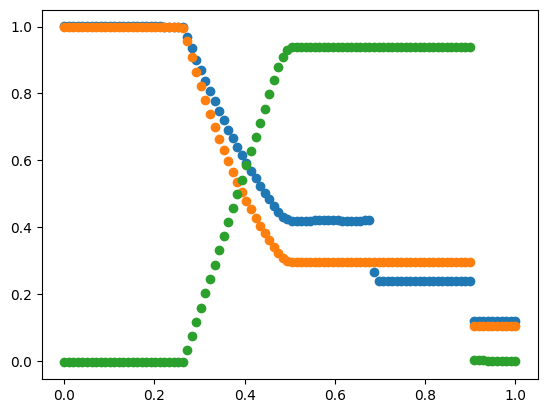

In [152]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()


In [117]:
new_array = np.array(u_pred[:,2])
#new_array = np.array(x)
file = open("p.txt", "w+")
content = str(new_array)
file.write(content)
file.close()


In [103]:
(0.377*6-0.125)/(0.125*6-0.377)*0.1

0.5729222520107239

In [153]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('Sodstatus1_100.dat', uxy)

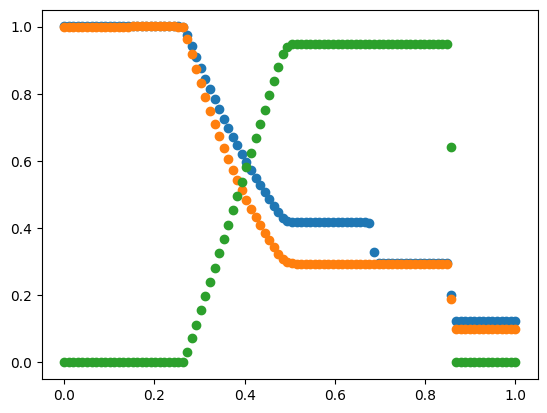

In [65]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

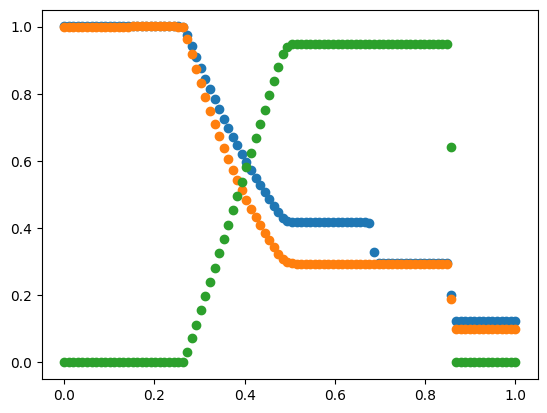

In [66]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [67]:
#np.size(id_f)
x_int_train = np.hstack((t_int, x_int))    # Random (x,t) - vectorized
#np.size(x_int_train)
#np.size(x_int)
#np.size(t_int)

In [68]:
def NewPoint(x,t):
    xl = -0.2
    xr = 1.8
    dgt = 0.0
    dg1 = np.array([])
    M = np.array([])
    N = np.size(x)
    L = np.array([])
    y = np.copy(x)
    for i in range(N):
        if i == 0:
            L = np.append(L,x[0]-xl)
            dgl = dg(x[0],t)
            dgr = dg(xl,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        elif i < N-1:
            L = np.append(L,x[i+1]-x[i])
            dgl = dg(x[i],t)
            dgr = dg(x[i+1],t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        else:
            L = np.append(L,xr-x[N-1])
            dgl = dg(x[N-1],t)
            dgr = dg(xr,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[N-1]
    for i in range(N):
        M = np.append(M,int((dg1[i]*L[i])/dgt*N+0.5))

    print("M")
  #  print(M)
  #  print("L")
  #  print(L)
    print("dg1")
    print(dg1)
    Mt = 0

    for i in range(N):
        if i ==0 and M[0] > 0:
            for j in range(int(M[0])):
                y[j] = (x[0] - xl)/M[0]*(j+1) + xl
        elif i < N-1 and M[i]> 0 and Mt<N:
            for j in range(int(M[i])):
                y[j+Mt] = (x[i] - x[i-1])/M[i]*(j+1) + x[i-1]
        elif i==N-1 and M[N-1] >0:
            for j in range(int(M[N-1])):
                y[j+Mt] = (xr - x[N-1])/M[N-1]*(j+1) + x[N-1]
        
        Mt = Mt + int(M[i])
    return dg1



In [69]:
x = np.linspace(-0.2, 1.8, 100)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 100)                                   # Partitioned spatial axis

In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
i=0
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x[0:99],t[99])
    t_r[i*100:99+i*100] =t[i]

In [70]:
x_r[600:699]

array([1.60326131e+22, 5.76465166e+22, 3.70957999e+24, 2.36209280e+08,
       5.44426439e-05, 1.62787000e+31, 2.71339503e+20, 8.00166625e+05,
       2.30321930e-07, 1.63223644e+34, 9.21301453e+02, 1.04500940e+12,
       8.04466938e+05, 8.82407375e+05, 4.04630494e+30, 1.30378596e+16,
       3.74023992e+33, 5.69934527e+13, 2.48317636e+26, 1.35164815e+10,
       6.66888847e+10, 5.99938017e+22, 6.24761462e+13, 3.97429464e+27,
       9.15677632e+14, 5.88571517e+22, 6.25707169e+01, 1.52182157e+25,
       1.58646385e+16, 1.00809555e+09, 6.25212734e+04, 4.01251659e+27,
       5.91548866e+13, 7.31270681e+28, 2.80446143e+03, 3.15070821e+12,
       7.32291394e-10, 2.61014860e+14, 3.98053244e+33, 3.54250340e-09,
       8.04056745e-13, 1.10771648e+33, 7.17675236e+25, 2.96474181e+35,
       1.19384877e-05, 7.46800288e-10, 8.82343000e+05, 6.35693008e+04,
       9.44837312e+08, 3.37953381e+21, 1.60242736e-10, 2.82971350e+20,
       1.65894244e+13, 6.38337681e+25, 1.14916658e+24, 1.61912344e+28,
      

In [71]:
plt.scatter(x[0:99],x_r[0:99])

ERROR! Session/line number was not unique in database. History logging moved to new session 4629


In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x_r[i*100:99+i*100],t[i])
    #t_r[i*100:99+i*100] =t[i]

In [ ]:
t[0]

In [ ]:
T = t_r.flatten()[:, None]                                         # Vectorized t_grid
X = x_r.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain

In [ ]:

y =NewPoint(x,t[1])

In [ ]:
dg(1.8,0.2)

In [ ]:
def dg(x,t):
    y_t=np.array([[x]])
    t_t=np.array([[t]])
    x_t = np.hstack((y_t,t_t))

    x_t = torch.tensor(x_t, requires_grad=True, dtype=torch.float32).to(device)
    loss = model.loss_pde(x_t)                                    # Loss function of PDE
    y = model.net(x_t)                                                # Neural network
    rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
    drho_g = gradients(rho, x_t)[0]
    d = torch.tensor(drho_g, dtype=torch.float32).to(device1)
    return d.numpy()[0][0]


In [ ]:
x = np.linspace(-0.2, 1.8, 1000)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test1 = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred1 = to_numpy(model(x_test1))

In [ ]:

plt.plot(x[:],u_pred[:,0])

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x[:],u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [ ]:
y = model.net(x_int_train)                                                # Neural network
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
drho_g = gradients(rho, x_int_train)[0]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x,u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [386]:
#device1 = torch.device('cpu')                                          # Run on CPU
torch.save(model,'1.pt')

In [ ]:
model.load(torch.load(PATH))
model.to(device)

# 文件读取模型

In [ ]:

import matplotlib.pyplot as plt
x = np.linspace(-8.0 / 28.0, 20.0 / 28.0, num_x)  # Partitioned spatial axis
t = np.linspace(2.0, 2.0, 1)  # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)  # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]  # Vectorized t_grid
X = x_grid.flatten()[:, None]  # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to('cpu')
u_pred = to_numpy(model(x_test))
plt.plot(x,u_pred[:,0])
plt.plot(x,u_pred[:,1])
plt.plot(x,u_pred[:,2])
plt.plot(x,u_pred[:,3])
plt.plot(x,u_pred[:,4])

In [ ]:

plt.plot(x,u_pred[:,4])

In [ ]:
#u_pred[:,0]
import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
x = np.linspace(-1.5, 3.125, num_x)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
def fun(x):
    return x.mean()

fun([1,2,3,4;1,2,3,4])

In [ ]:
(1,2,3,4).mean()

In [ ]:
p = np.zeros(100)

In [ ]:
p.mean()